# NYC taxis tips 

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import sklearn
import optuna
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
import logging

c:\Users\PabloHueso\miniconda3\envs\EntornoML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup de pandas pour la visualisation de dataframes
pd.set_option('display.max_columns', None)

In [3]:
#Import des datasets
train = pd.read_parquet("C:\Datasets\\taxis\\train.parquet")
test = pd.read_parquet("C:\Datasets\\taxis\\test.parquet")

In [4]:
#On garde en copie les datasets originelles en memoire au cas ou on a besoin plus tard
train_original = train.copy()
test_original = test.copy()

## Exploration des donnees

### Presentation de features

In [5]:
train.head()
test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
row_ID,,,,,,,,,,,,,,,,,,,
0,2,2024-01-24 08:02:47,2024-01-24 08:04:45,1.0,0.36,1.0,N,1,4.4,0.0,0.5,0.0,1.0,2.5,0.0,40.740439,-73.976495,40.747746,-73.978492
1,2,2024-01-26 14:34:58,2024-01-26 14:42:51,1.0,1.78,1.0,N,1,10.7,0.0,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.790011,-73.945750
2,2,2024-01-24 15:47:27,2024-01-24 15:51:48,2.0,0.43,1.0,N,2,5.8,0.0,0.5,0.0,1.0,0.0,0.0,40.791705,-73.973049,40.797962,-73.968168
3,2,2024-01-04 14:40:17,2024-01-04 14:44:21,1.0,0.61,1.0,N,1,5.8,0.0,0.5,0.0,1.0,2.5,0.0,40.783961,-73.978632,40.791705,-73.973049
4,2,2024-01-16 05:54:03,2024-01-16 05:55:59,1.0,0.71,1.0,N,2,5.1,1.0,0.5,0.0,1.0,2.5,0.0,40.748427,-73.999918,40.748427,-73.999918


### Nettoyage et preparation des données

On commence d'abord par un nettoyage rutinaire des données, visant se débarraserd es valeurs NaN. On remarque qu'il n'y a pas de données manquantes.

In [6]:
# NaNs per colonne
missing_values = train.isnull().sum()

# Colonnes avec des NaN
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

Series([], dtype: int64)


Avant de procéder à une étude univariée et bivariée, nous devons transformer certaines variables en formats numériques. Pour l'instant, nous effectuerons des transformations de base pour procéder à une étude, et dans une section ultérieure, nous effectuerons des transformations plus avancées des variables.

In [7]:
# Nous créons une unique variable à partir des variables avec format datetype
train['trip_duration'] = (train['tpep_dropoff_datetime'] - train['tpep_pickup_datetime']).dt.total_seconds() / 60 # Trip duration in minutes
test['trip_duration'] = (test['tpep_dropoff_datetime'] - test['tpep_pickup_datetime']).dt.total_seconds() / 60 

# Encoding des variables categorielles: d'abord on teste des encodings basiques
# Store_and_fwd_flag: dummy
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

### Étude univariée et bivariée

##### Univariée
Nous examinons ici les distributions de certaines covariables. Nous nous intéressons en particulier à la cohérence des valeurs prises par les covariables ainsi qu'aux valeurs extrêmes.

##### Trip duration
We first look for extreme values. We can safely assume that any trip that is over 5 hours (300 min) long is an error. In the same way, the duration for a trip can't be 0.

   

In [8]:
len(train[train['trip_duration']>300]['trip_duration']) # 63 such trips in the training set
len(test[test['trip_duration']>300]['trip_duration']) #!! 1689 trips in the test set

#This suggests that distributions might not be similar across train and test sets. Let's now check trips of duration 0:

len(train[train['trip_duration']==0]['trip_duration']) #1
len(test[test['trip_duration']==0]['trip_duration']) #33

# We have less cases. Let's investigate if these are cancelled trips or just errors:

33

In [9]:
test[test['trip_duration']==0].head()
#We notice how the trip distance is nonzero, as well as the fare_amount, so these are errors and not cancelled trips. 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration
row_ID,,,,,,,,,,,,,,,,,,,,
125498,1,2024-01-08 15:16:40,2024-01-08 15:16:40,0.0,4.20,1.0,0,2,3.0,0.0,0.5,0.0,1.0,0.0,0.0,40.745379,-73.948892,40.745379,-73.948892,0.0
189900,2,2024-01-09 17:40:00,2024-01-09 17:40:00,1.0,18.60,2.0,0,1,70.0,0.0,0.5,0.0,1.0,2.5,0.0,40.646985,-73.786530,40.723888,-74.001538,0.0
258501,1,2024-01-30 07:32:57,2024-01-30 07:32:57,1.0,0.70,1.0,0,1,5.1,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0
482498,2,2024-01-23 00:00:00,2024-01-23 00:00:00,5.0,3.64,1.0,0,1,102.4,2.5,0.5,0.0,1.0,2.5,0.0,40.791705,-73.973049,40.791705,-73.973049,0.0
504436,1,2024-01-16 01:00:18,2024-01-16 01:00:18,1.0,0.70,1.0,0,2,5.8,3.5,0.5,0.0,1.0,2.5,0.0,40.756688,-73.972356,40.756688,-73.972356,0.0


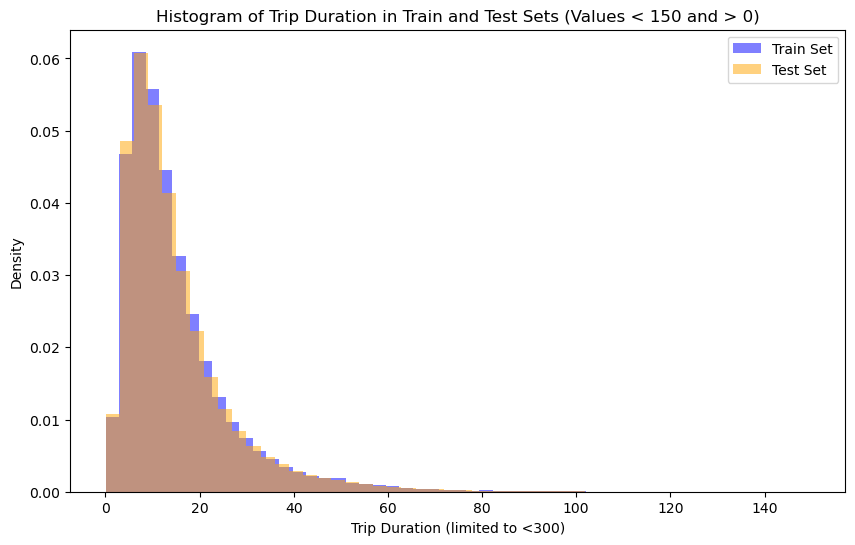

In [10]:
# Filter values to include only those less than 150 (provides clearer visualization than with <300)
train_filtered = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 150)]
test_filtered = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 150)]

# Plot the histograms
plt.figure(figsize=(10, 6))

# Train set histogram
plt.hist(train_filtered['trip_duration'], bins=50, color='blue', alpha=0.5, density=True, label='Train Set')

# Test set histogram
plt.hist(test_filtered['trip_duration'], bins=50, color='orange', alpha=0.5, density=True, label='Test Set')

# Add labels and title
plt.xlabel('Trip Duration (limited to <300)')
plt.ylabel('Density')
plt.title('Histogram of Trip Duration in Train and Test Sets (Values < 150 and > 0)')
plt.legend()
plt.show()


Distributions are very similar. We now need a way of handling the measurement errors. A very natural idea is to use the trip_distance variable. I expect this variable to be highly correlated with trip_duration. Let's verify:

In [11]:
train[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2614, which is super low
test[['trip_distance', 'trip_duration']].corr().iloc[0, 1] # 0.2656, similar

#Of course, this is the general case with the outliers. Let's see how it should be:

train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7934
test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)][['trip_distance', 'trip_duration']].corr().iloc[0, 1] #0.7888



0.7888151400475526

We find much more reasonable values. 

In [12]:
df1 = train[(train['trip_duration'] > 0) & (train['trip_duration'] < 300)].drop(columns=['tip_amount'])
df2 = test[(test['trip_duration'] > 0) & (test['trip_duration'] < 300)]

combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

X = combined_df[['trip_distance']]  # Predictor needs to be a 2D array
y = combined_df['trip_duration']    # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]

In [13]:
# We now replace the nonsensical values with a simple estimation of them
# Replace nonsensical values in 'train' DataFrame
train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_duration'] = train.loc[(train['trip_duration'] == 0) | (train['trip_duration'] > 300), 'trip_distance'] * slope


# Replace nonsensical values in 'test' DataFrame
test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_duration'] = test.loc[(test['trip_duration'] == 0) | (test['trip_duration'] > 300), 'trip_distance'] * slope



##### Passenger count

In [14]:
#We replace instances where the passenger count is 0 by instances where it is one

train.loc[train['passenger_count'] == 0, 'passenger_count'] = 1
test.loc[test['passenger_count'] == 0, 'passenger_count'] = 1

In [15]:
test['passenger_count'].value_counts()

passenger_count
1.0    2066425
2.0     376190
3.0      84638
4.0      46990
5.0      31707
6.0      21198
8.0         11
7.0          3
9.0          1
Name: count, dtype: int64

##### Fare amount
We seem to have the same outlier problem we had with the ```trip_duration``` variable. In principle, ```fare_amount``` should be highly correlated with ```trip_distance```, but we notice how the test set presents a considerable number of outliers that seem to be measuring errors. In this section we investigate the matter and do some processing.

In [16]:
train[train['fare_amount']>200] # Only one instance with an appropiate trip_distance. No problems here.
test[test['fare_amount']>200] # although some values seem correct, we notice how how some people got charged devious amounts of money for no apparent reason

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,trip_duration
row_ID,,,,,,,,,,,,,,,,,,,,
19899,2,2024-01-11 11:44:34,2024-01-11 12:16:56,2.0,16.23,5.0,0,2,367.0,0.00,0.0,0.00,1.0,0.0,1.75,40.646985,-73.786530,40.646985,-73.786530,32.366667
20605,2,2024-01-30 23:53:27,2024-01-31 04:34:51,1.0,2.73,1.0,0,1,201.1,1.00,0.5,0.00,1.0,2.5,0.00,40.768615,-73.965635,40.768615,-73.965635,281.400000
20741,2,2024-01-01 02:12:04,2024-01-01 02:13:28,2.0,0.18,5.0,0,1,250.0,0.00,0.0,0.00,1.0,2.5,0.00,40.747746,-73.978492,40.749914,-73.970443,1.400000
37439,2,2024-01-02 15:02:50,2024-01-02 15:04:30,3.0,0.12,5.0,0,4,300.0,0.00,0.0,0.00,1.0,0.0,1.75,40.646985,-73.786530,40.646985,-73.786530,1.666667
39402,2,2024-01-06 09:51:10,2024-01-06 16:09:25,1.0,4.31,1.0,0,2,273.9,0.00,0.5,0.00,1.0,2.5,0.00,40.734576,-74.002875,40.735035,-74.008984,9.540156
69822,1,2024-01-30 20:14:25,2024-01-30 20:15:42,1.0,0.10,5.0,0,2,350.0,0.00,0.0,0.00,1.0,0.0,0.00,40.790011,-73.945750,40.790011,-73.945750,1.283333
108106,2,2024-01-24 15:57:16,2024-01-24 17:20:02,1.0,33.10,4.0,0,1,208.1,5.00,0.0,29.32,1.0,0.0,1.75,40.763352,-73.868395,40.691830,-74.174002,82.766667
189193,2,2024-01-14 23:40:00,2024-01-14 23:40:08,1.0,0.05,5.0,0,1,300.0,0.00,0.0,0.00,1.0,0.0,0.00,40.646985,-73.786530,40.646985,-73.786530,0.133333
309495,2,2024-01-01 21:59:33,2024-01-01 21:59:55,4.0,0.21,5.0,0,2,820.0,0.00,0.0,0.00,1.0,0.0,0.00,40.646985,-73.786530,40.646985,-73.786530,0.366667


Given that the relationship between ```fare_amount``` and ```trip_distance``` should be linear or almost linear, we fit a linear regression line on ```fare_amount``` using only the ```trip_distance``` variable.

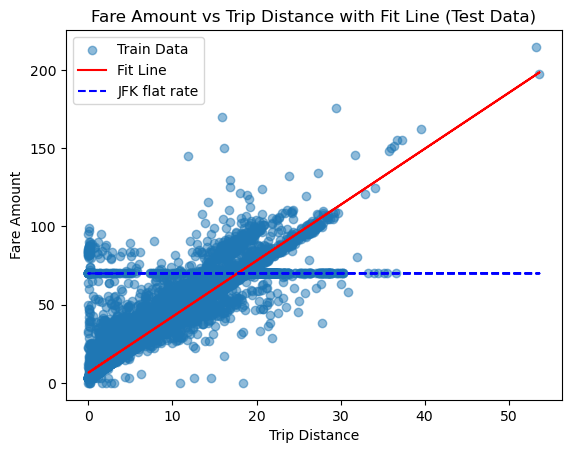

In [17]:

# Fit the model on training data
X_train = train[['trip_distance']]
y_train = train['fare_amount']
model = LinearRegression()
model.fit(X_train, y_train)

# Create scatter plot of test data
plt.scatter(X_train, y_train, alpha=0.5, label='Train Data')

# Plot the regression line using the trained model
plt.plot(X_train, model.predict(X_train), color='red', label='Fit Line')

# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_train, custom_slope * X_train + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance with Fit Line (Test Data)')
plt.legend()

# Display the plot
plt.show()


We notice how there seem to exist a secondary regime in which people are charged with a flat rate. After investigation, we realize this corresponds to the JFK airport flat rate.  Let's now compare with the test data:

c:\Users\PabloHueso\miniconda3\envs\EntornoML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


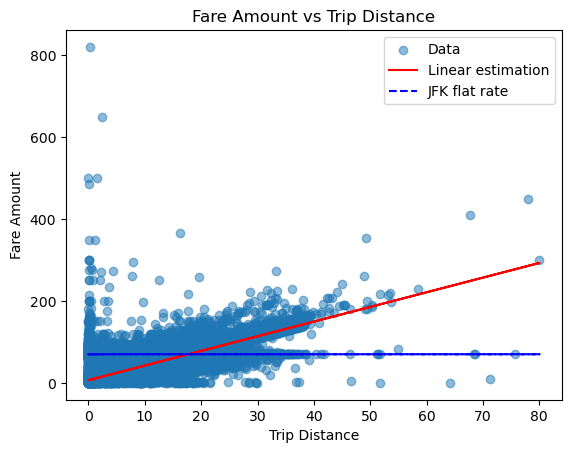

In [18]:

# Prepare test data
X_test = test[['trip_distance']]
y_test = test['fare_amount']

# Create scatter plot of test data
plt.scatter(X_test, y_test, alpha=0.5, label='Data')

# Plot the regression line using the trained model
plt.plot(X_test, model.predict(X_test), color='red', label='Linear estimation')

# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_test, custom_slope * X_test + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance')
plt.legend()

# Display the plot
plt.show()


We notice how there are multiple values in which the trip distance is close to 0, but the fare_amount exploded, most probably because of an error when inputing the data. In a similar manner, we have long trips whose fare_amount is 3$. This is because the standard taxi fare is 3$ + a rate depending mostly on distance. In that scenario, probably the fare wasn't being calculated correctly. Let's handle these errors:

In [19]:

low_regime_errors_train = (train['fare_amount']<=4) & (train['trip_distance']>5)
high_regime_errors_train = (train['fare_amount']>140) & (train['trip_distance']<8) & (train['RatecodeID']!=2)
superhigh_regime_errors_train = (train['fare_amount']>45) & (train['trip_distance']<1) & (train['RatecodeID']!=2)
jfk_rate_train = (train['RatecodeID']==2)

low_regime_errors_test = (test['fare_amount']<=4) & (test['trip_distance']>5)
high_regime_errors_test = (test['fare_amount']>140) & (test['trip_distance']<8) & (test['RatecodeID']!=2)
superhigh_regime_errors_test = (test['fare_amount']>45) & (test['trip_distance']<1) & (test['RatecodeID']!=2)
jfk_rate_test = (test['RatecodeID']==2)

X_train = train[~(low_regime_errors_train)& ~(high_regime_errors_train) & ~(jfk_rate_train)][['trip_distance']]
y_train = train[~(low_regime_errors_train) & ~(high_regime_errors_train) & ~(jfk_rate_train)]['fare_amount']

model_dist_to_amount = LinearRegression()
model_dist_to_amount.fit(X_train, y_train)

X_train = train[~(low_regime_errors_train)& ~(high_regime_errors_train) & ~(jfk_rate_train)][['fare_amount']]
y_train = train[~(low_regime_errors_train) & ~(high_regime_errors_train) & ~(jfk_rate_train)]['trip_distance']

model_amount_to_dist = LinearRegression()
model_amount_to_dist.fit(X_train, y_train)



LinearRegression()

In [20]:
# Count instances in each error regime for the train set
low_regime_count_train = low_regime_errors_train.sum()
high_regime_count_train = high_regime_errors_train.sum()
superhigh_regime_count_train = superhigh_regime_errors_train.sum()
jfk_rate_count_train = jfk_rate_train.sum()

# Count instances in each error regime for the test set
low_regime_count_test = low_regime_errors_test.sum()
high_regime_count_test = high_regime_errors_test.sum()
superhigh_regime_count_test = superhigh_regime_errors_test.sum()
jfk_rate_count_test = jfk_rate_test.sum()

# Display counts for the train set
print("Train Set Error Regime Counts:")
print(f"Low Regime Errors: {low_regime_count_train}")
print(f"High Regime Errors: {high_regime_count_train}")
print(f"Superhigh Regime Errors: {superhigh_regime_count_train}")
print(f"JFK Rate: {jfk_rate_count_train}")

# Display counts for the test set
print("\nTest Set Error Regime Counts:")
print(f"Low Regime Errors: {low_regime_count_test}")
print(f"High Regime Errors: {high_regime_count_test}")
print(f"Superhigh Regime Errors: {superhigh_regime_count_test}")
print(f"JFK Rate: {jfk_rate_count_test}")

# Total number of low regime errors in train and test sets
total_low_regime_errors = low_regime_errors_train.sum() + low_regime_errors_test.sum()

# Total number of high regime errors (high + superhigh) in train and test sets
total_high_regime_errors = (high_regime_errors_train.sum() + superhigh_regime_errors_train.sum() +
                            high_regime_errors_test.sum() + superhigh_regime_errors_test.sum())

print("Total Low Regime Errors:", total_low_regime_errors)
print("Total High Regime Errors (High + Superhigh):", total_high_regime_errors)

# Calculate the correlation between fare_amount and trip_distance
# 1. When NOT in low regime
no_low_regime = ~(low_regime_errors_train | low_regime_errors_test)
correlation_no_low_regime = train[no_low_regime]['fare_amount'].corr(train[no_low_regime]['trip_distance'])

# 2. When NOT in high or superhigh regime
no_high_superhigh_regime = ~(high_regime_errors_train | superhigh_regime_errors_train |
                             high_regime_errors_test | superhigh_regime_errors_test)
correlation_no_high_superhigh_regime = train[no_high_superhigh_regime]['fare_amount'].corr(train[no_high_superhigh_regime]['trip_distance'])

print("\nCorrelation between fare_amount and trip_distance:")
print("When NOT in Low Regime:", correlation_no_low_regime)
print("When NOT in High or Superhigh Regime:", correlation_no_high_superhigh_regime)



Train Set Error Regime Counts:
Low Regime Errors: 4
High Regime Errors: 0
Superhigh Regime Errors: 51
JFK Rate: 3439

Test Set Error Regime Counts:
Low Regime Errors: 169
High Regime Errors: 60
Superhigh Regime Errors: 1496
JFK Rate: 90231
Total Low Regime Errors: 173
Total High Regime Errors (High + Superhigh): 1607


C:\Users\PabloHueso\AppData\Local\Temp\ipykernel_52080\881084116.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correlation_no_low_regime = train[no_low_regime]['fare_amount'].corr(train[no_low_regime]['trip_distance'])
C:\Users\PabloHueso\AppData\Local\Temp\ipykernel_52080\881084116.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correlation_no_low_regime = train[no_low_regime]['fare_amount'].corr(train[no_low_regime]['trip_distance'])



Correlation between fare_amount and trip_distance:
When NOT in Low Regime: 0.9535502319163452
When NOT in High or Superhigh Regime: 0.9586358360308532


C:\Users\PabloHueso\AppData\Local\Temp\ipykernel_52080\881084116.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correlation_no_high_superhigh_regime = train[no_high_superhigh_regime]['fare_amount'].corr(train[no_high_superhigh_regime]['trip_distance'])
C:\Users\PabloHueso\AppData\Local\Temp\ipykernel_52080\881084116.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correlation_no_high_superhigh_regime = train[no_high_superhigh_regime]['fare_amount'].corr(train[no_high_superhigh_regime]['trip_distance'])


In [21]:
test.loc[high_regime_errors_test, 'trip_distance'] = test.loc[high_regime_errors_test, 'fare_amount'] * model_amount_to_dist.coef_[0]
test.loc[superhigh_regime_errors_test, 'trip_distance'] = test.loc[superhigh_regime_errors_test, 'fare_amount'] * model_amount_to_dist.coef_[0]
test.loc[low_regime_errors_test, 'fare_amount'] = test.loc[low_regime_errors_test, 'trip_distance'] * model_dist_to_amount.coef_[0]  


train.loc[high_regime_errors_train, 'trip_distance'] = train.loc[high_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]
train.loc[superhigh_regime_errors_train, 'trip_distance'] = train.loc[superhigh_regime_errors_train, 'fare_amount'] * model_amount_to_dist.coef_[0]
train.loc[low_regime_errors_train, 'fare_amount'] = train.loc[low_regime_errors_train, 'trip_distance'] * model_dist_to_amount.coef_[0]

Final result

c:\Users\PabloHueso\miniconda3\envs\EntornoML\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


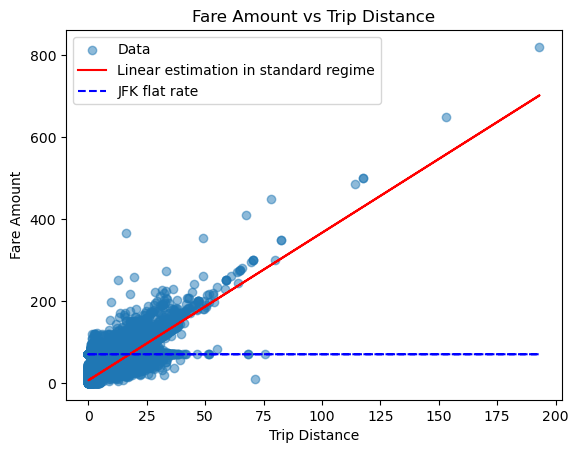

In [22]:

X_test = test[['trip_distance']]
y_test = test['fare_amount']


model = LinearRegression()
model.fit(X_test, y_test)


# Create scatter plot of test data
plt.scatter(X_test, y_test, alpha=0.5, label='Data')


# Plot the regression line using the trained model
plt.plot(X_test, model.predict(X_test), color='red', label='Linear estimation in standard regime')

# Custom line to show secondary regime
custom_slope = 0
custom_intercept = 70
plt.plot(X_test, custom_slope * X_test + custom_intercept, color='blue', linestyle='--', label='JFK flat rate')


# Add labels and title
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Trip Distance')
plt.legend()

# Display the plot
plt.show()


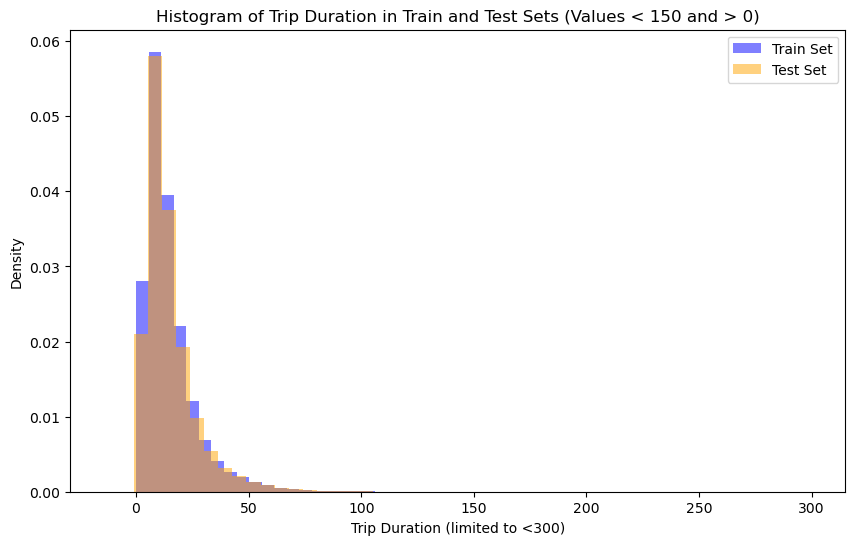

In [23]:
# Plot the histograms
plt.figure(figsize=(10, 6))

# Train set histogram
plt.hist(train['trip_duration'], bins=50, color='blue', alpha=0.5, density=True, label='Train Set')

# Test set histogram
plt.hist(test['trip_duration'], bins=50, color='orange', alpha=0.5, density=True, label='Test Set')

# Add labels and title
plt.xlabel('Trip Duration (limited to <300)')
plt.ylabel('Density')
plt.title('Histogram of Trip Duration in Train and Test Sets (Values < 150 and > 0)')
plt.legend()
plt.show()

#### Bivariée

In [24]:
numerical_vars = train.select_dtypes(include=['float64', 'int64']).columns

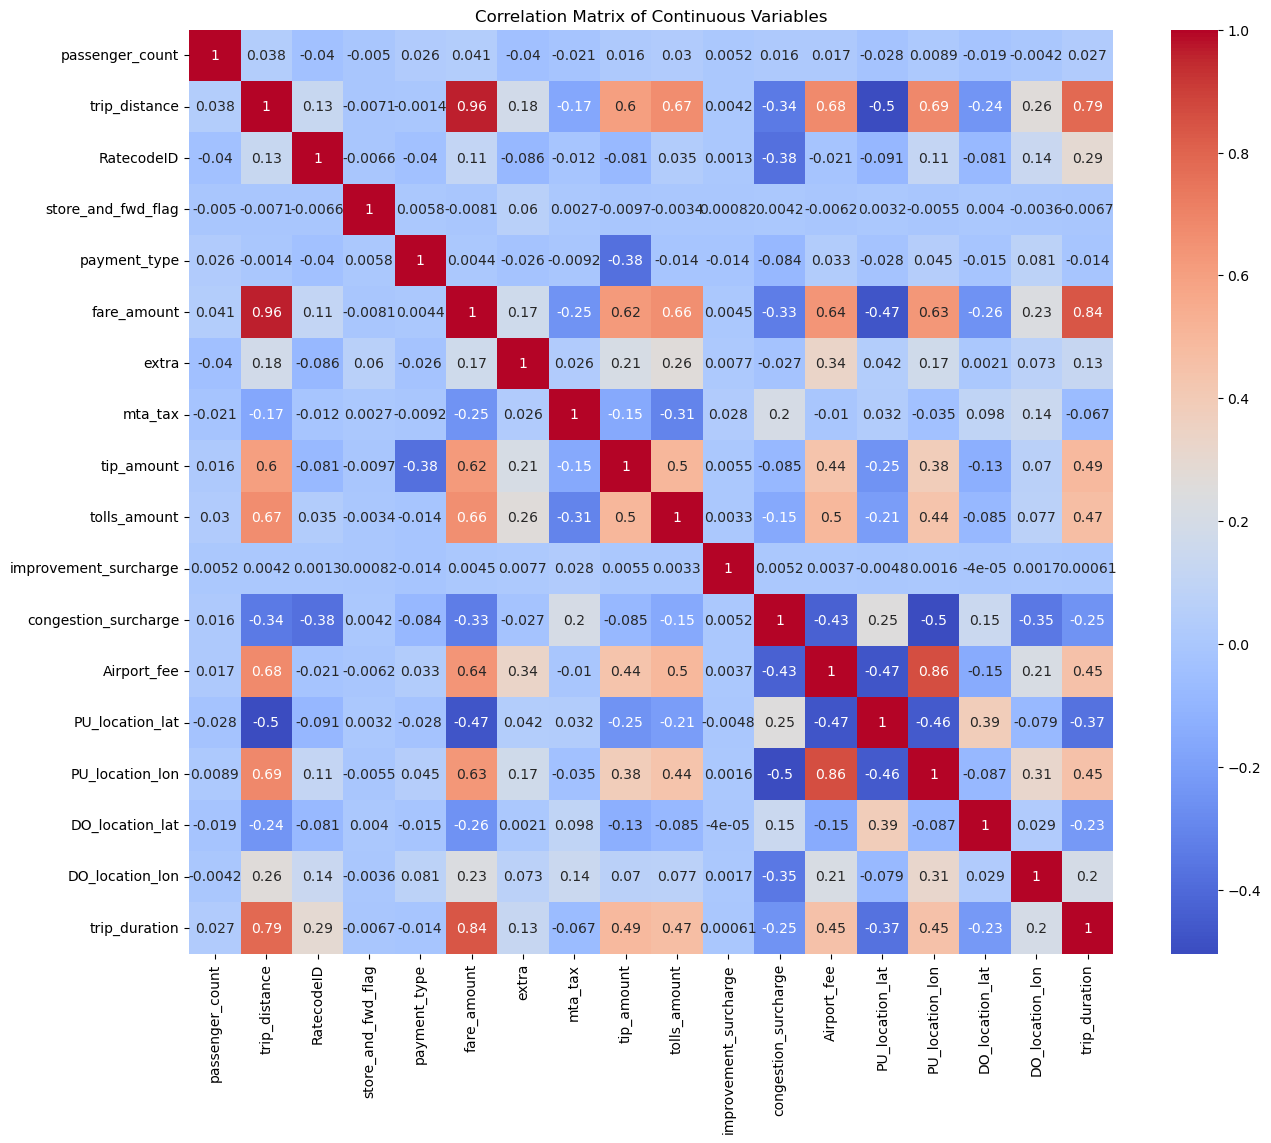

In [25]:
# Plotting the correlation matrix
plt.figure(figsize=(15, 12))
#sns.heatmap(train[numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)
sns.heatmap(train[train['trip_duration'] < 300][numerical_vars].corr(), annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Matrix of Continuous Variables')
plt.show()

#### Location variables

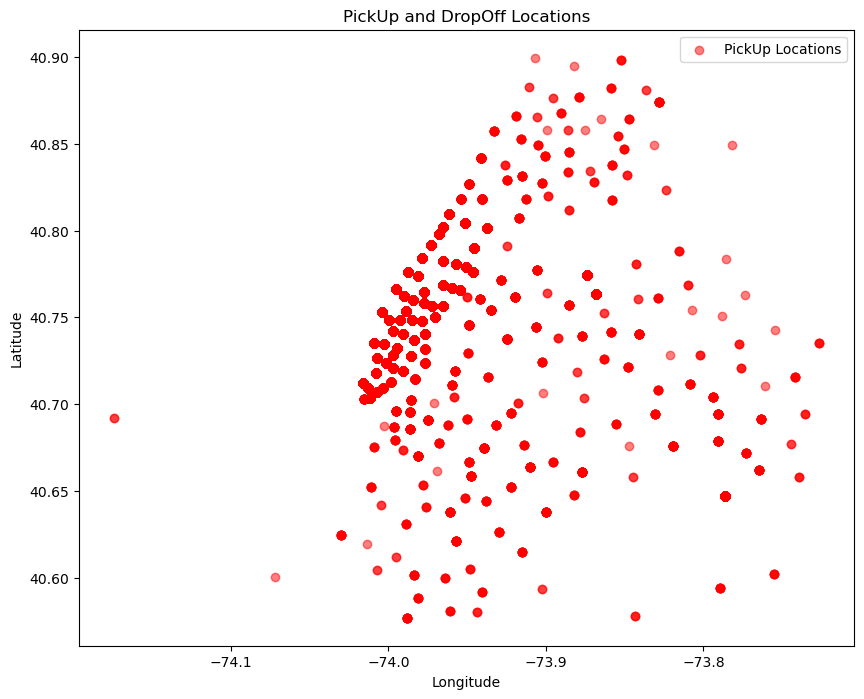

In [26]:
import matplotlib.pyplot as plt

# Extract coordinates for pickup and dropoff locations
PU_lat = train['PU_location_lat']
PU_lon = train['PU_location_lon']
DO_lat = train['DO_location_lat']
DO_lon = train['DO_location_lon']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot pickup locations in red
plt.scatter(PU_lon, PU_lat, color='red', label='PickUp Locations', alpha=0.5)

#Plot dropoff locations in green
#plt.scatter(DO_lon, DO_lat, color='green', label='DropOff Locations', alpha=0.5)

# Draw a dashed line between each pickup and dropoff point for the same trip
'''
for i in range(len(PU_lat)):
    plt.plot([PU_lon[i], DO_lon[i]], [PU_lat[i], DO_lat[i]], 'k--', alpha=0.3)
'''
# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PickUp and DropOff Locations')
plt.legend()
plt.show()


## Feature engineering

On se dispose dans cette section a creer de covariables supplementaires potentiellement representatives et informatives

### Categorical variable encoding

In [27]:
# VendorID, RateCodeID et Payment_type: one-hot

categorical_features = ['VendorID', 'RateCodeID', 'Payment_type']

train = pd.get_dummies(train, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int) # On ajoute dtype int à la fin pour assurer un format non-booléen afin de garantir la compatibilité avec scikit learn
test = pd.get_dummies(test, columns=['VendorID', 'RatecodeID', 'payment_type'], dtype=int)

train, test = train.align(test, join='left', axis=1, fill_value=0) # Certaines catégories n'apparaissent que dans le train set, il faut donc adapter l'encoding dans le test set. 
test = test.drop(columns=['tip_amount'])


### Features derivées des pickup_datetime et dropoff_datetime

In [30]:
# trip speed
train['trip_speed'] = train['trip_distance'] / train['trip_duration']
test['trip_speed'] = test['trip_distance'] / test['trip_duration']


In [31]:
#is_fast_trip

# Fit a linear model to predict trip_duration from trip_distance
X = train[['trip_distance']]
y = train['trip_duration']
model = LinearRegression()
model.fit(X, y)

# Coefficient representing the expected rate
c = model.coef_[0]

# Define is_fast_trip variable
train['is_fast_trip'] = (c * train['trip_distance'] / train['trip_duration']) > 1
train['is_fast_trip'] = train['is_fast_trip'].astype(int)  # Convert to binary (0 or 1)

# Over the test set:
# Fit a linear model on the test set to predict trip_duration from trip_distance
X_test = test[['trip_distance']]
y_test = test['trip_duration']
model_test = LinearRegression()
model_test.fit(X_test, y_test)

# Coefficient representing the expected rate for the test set
c_test = model_test.coef_[0]

# Define is_fast_trip variable for the test set based on its own coefficient
test['is_fast_trip'] = (c_test * test['trip_distance'] / test['trip_duration']) > 1
test['is_fast_trip'] = test['is_fast_trip'].astype(int)  # Convert to binary (0 or 1)

In [33]:
# Cyclical encoding for the time variable
# Convert 'tpep_pickup_datetime' to datetime if it's not already
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Extract hour, minute, and second
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train['minute'] = train['tpep_pickup_datetime'].dt.minute
train['second'] = train['tpep_pickup_datetime'].dt.second

# Calculate total seconds from midnight for each datetime entry
train['seconds_from_midnight'] = train['hour'] * 3600 + train['minute'] * 60 + train['second']

# Perform cyclic encoding using sine and cosine
train['time_sin'] = np.sin(2 * np.pi * train['seconds_from_midnight'] / 86400)  # 86400 seconds in a day
train['time_cos'] = np.cos(2 * np.pi * train['seconds_from_midnight'] / 86400)

# Drop intermediate columns if not needed
train.drop(columns=['hour', 'minute', 'second', 'seconds_from_midnight'], inplace=True)


test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Extract hour, minute, and second
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test['minute'] = test['tpep_pickup_datetime'].dt.minute
test['second'] = test['tpep_pickup_datetime'].dt.second

# Calculate total seconds from midnight for each datetime entry
test['seconds_from_midnight'] = test['hour'] * 3600 + test['minute'] * 60 + test['second']

# Perform cyclic encoding using sine and cosine
test['time_sin'] = np.sin(2 * np.pi * test['seconds_from_midnight'] / 86400)  # 86400 seconds in a day
test['time_cos'] = np.cos(2 * np.pi * test['seconds_from_midnight'] / 86400)

# Drop intermediate columns if not needed
test.drop(columns=['hour', 'minute', 'second', 'seconds_from_midnight'], inplace=True)




### Features derivées de variables d'emplacement

In [35]:
# Create a combined pickup location column
'''
train['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)
# Factorize the unique pickup locations
train['PU_location_level'] = pd.factorize(train['PU_location'])[0]

# Create a combined dropoff location column
train['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)
# Factorize the unique dropoff locations
train['DO_location_level'] = pd.factorize(train['DO_location'])[0]

# Drop the temporary combined columns if not needed
train = train.drop(['PU_location', 'DO_location'], axis=1)
'''


"\ntrain['PU_location'] = train[['PU_location_lat', 'PU_location_lon']].apply(tuple, axis=1)\n# Factorize the unique pickup locations\ntrain['PU_location_level'] = pd.factorize(train['PU_location'])[0]\n\n# Create a combined dropoff location column\ntrain['DO_location'] = train[['DO_location_lat', 'DO_location_lon']].apply(tuple, axis=1)\n# Factorize the unique dropoff locations\ntrain['DO_location_level'] = pd.factorize(train['DO_location'])[0]\n\n# Drop the temporary combined columns if not needed\ntrain = train.drop(['PU_location', 'DO_location'], axis=1)\n"

### Feature importance

                  Feature  Importance
23         payment_type_1    0.335675
22        RatecodeID_99.0    0.330677
3             fare_amount    0.205654
1           trip_distance    0.025443
17         RatecodeID_1.0    0.020339
6            tolls_amount    0.009245
20         RatecodeID_4.0    0.007317
11        PU_location_lon    0.005525
4                   extra    0.004841
18         RatecodeID_2.0    0.004409
12        DO_location_lat    0.004364
13        DO_location_lon    0.004326
21         RatecodeID_5.0    0.004047
9             Airport_fee    0.003976
30               time_cos    0.003917
29               time_sin    0.003913
14          trip_duration    0.003759
27             trip_speed    0.003617
10        PU_location_lat    0.003088
5                 mta_tax    0.002998
15             VendorID_1    0.002978
8    congestion_surcharge    0.002683
0         passenger_count    0.002572
19         RatecodeID_3.0    0.002527
2      store_and_fwd_flag    0.001876
24         p

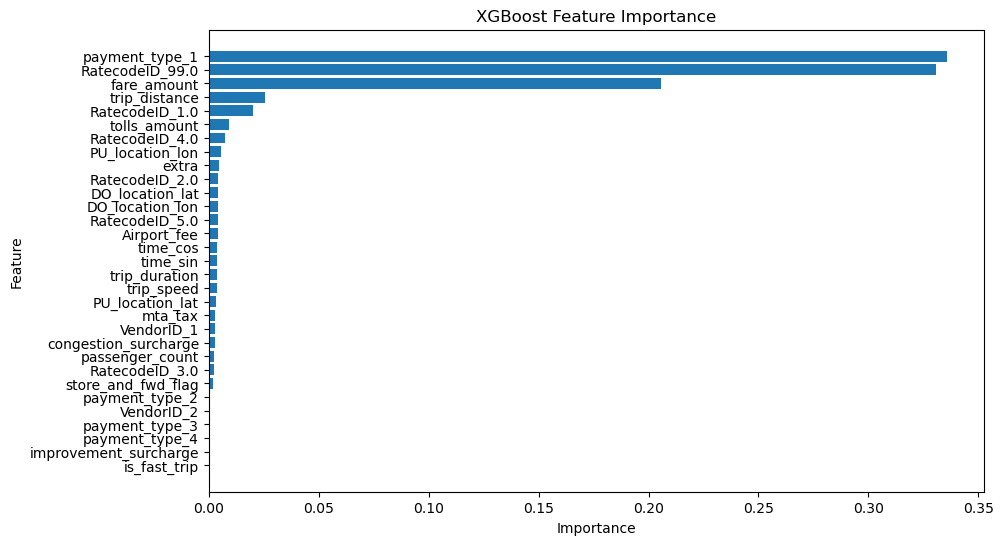

In [37]:
train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])
test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])

X_train = train.drop(columns=['tip_amount'])
y_train = train['tip_amount']


xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for easier interpretation (optional)
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances (optional)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Model fitting

In [ ]:
## Model fitting
#train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])
#test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon'])

train = train.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])
test = test.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',])

X_train = train.drop(columns=['tip_amount'])
y_train = train['tip_amount']

X_test = test

In [ ]:
#Linear regression
'''
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
'''

'\nfrom sklearn.linear_model import LinearRegression\n\nmodel = LinearRegression()\n\nmodel.fit(X_train, y_train)\ny_pred = model.predict(X_test)\n'

In [ ]:
#GAM
'''
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit a GLM with Gaussian family (similar to linear regression)
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Predict on the test set
y_pred = glm_results.predict(X_test)
'''

'\nimport statsmodels.api as sm\nX_train = sm.add_constant(X_train)\nX_test = sm.add_constant(X_test)\n\n# Fit a GLM with Gaussian family (similar to linear regression)\nglm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())\nglm_results = glm_model.fit()\n\n# Predict on the test set\ny_pred = glm_results.predict(X_test)\n'

##### Random Forest

Native Categorical Handling in XGB

In [ ]:
'''
# Ensure categorical columns are of 'category' dtype in both X_train and X_test
categorical_cols = ['VendorID', 'RatecodeID', 'payment_type', 'store_and_fwd_flag']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Initialize the model with CPU-based training and native categorical handling
model = xgb.XGBRegressor(
    tree_method='hist',       # Use CPU-optimized histogram-based tree construction
    enable_categorical=True,  # Enable native categorical feature support
    # Add other parameters as needed
)

# Fit the model
model.fit(X_train, y_train)
'''

"\n# Ensure categorical columns are of 'category' dtype in both X_train and X_test\ncategorical_cols = ['VendorID', 'RatecodeID', 'payment_type', 'store_and_fwd_flag']\nfor col in categorical_cols:\n    X_train[col] = X_train[col].astype('category')\n    X_test[col] = X_test[col].astype('category')\n\n# Initialize the model with CPU-based training and native categorical handling\nmodel = xgb.XGBRegressor(\n    tree_method='hist',       # Use CPU-optimized histogram-based tree construction\n    enable_categorical=True,  # Enable native categorical feature support\n    # Add other parameters as needed\n)\n\n# Fit the model\nmodel.fit(X_train, y_train)\n"

##### Boosting

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,  # Use all available CPU cores
    }

    # Initialize the model with the current hyperparameters
    model = xgb.XGBRegressor(**param)

    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1
    )

    # Calculate the mean R² score
    mean_score = scores.mean()

    # Print progress information
    trial.report(-mean_score, step=0)

    # Return the negative mean R² score (since we are minimizing)
    return -mean_score


In [ ]:
study = optuna.create_study(
    study_name='xgb_regressor_optimization',
    direction='minimize',
    storage='sqlite:///xgb_study.db',  # Save progress to a SQLite database
    load_if_exists=True,
)

[I 2024-11-11 02:05:20,044] Using an existing study with name 'xgb_regressor_optimization' instead of creating a new one.


In [ ]:
study.optimize(
    objective,
    n_trials=1000,         # Large number for overnight run
    n_jobs=2,              # Single process to avoid overloading the system
    show_progress_bar=True,
    gc_after_trial=True,   # Clean up memory after each trial
)

Best trial: 1. Best value: -0.702865:   0%|          | 1/1000 [00:15<4:14:48, 15.30s/it]

[I 2024-11-11 02:05:35,232] Trial 1 finished with value: -0.7028651893100536 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.031125235881168823, 'subsample': 0.5159100131740648, 'colsample_bytree': 0.6740663295934071, 'gamma': 1.5716457180612249, 'reg_alpha': 2.568060374113141, 'reg_lambda': 1.4445914114818089e-08, 'min_child_weight': 9}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   0%|          | 1/1000 [00:15<4:14:48, 15.30s/it]

[I 2024-11-11 02:05:35,847] Trial 0 finished with value: -0.5401405543626597 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.003786446038780989, 'subsample': 0.7044317144337686, 'colsample_bytree': 0.5994077496060793, 'gamma': 1.9453231528736403, 'reg_alpha': 0.9674062776709381, 'reg_lambda': 7.383502441213287e-05, 'min_child_weight': 2}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   0%|          | 3/1000 [00:36<3:32:46, 12.80s/it]

[I 2024-11-11 02:05:55,957] Trial 3 finished with value: -0.6774319414376014 and parameters: {'n_estimators': 362, 'max_depth': 15, 'learning_rate': 0.08000506472577781, 'subsample': 0.8128434403642841, 'colsample_bytree': 0.7607920120040386, 'gamma': 3.194280405525552, 'reg_alpha': 0.00927663216443381, 'reg_lambda': 5.213943287219306, 'min_child_weight': 10}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   0%|          | 3/1000 [00:49<3:32:46, 12.80s/it]

[I 2024-11-11 02:06:09,281] Trial 2 finished with value: -0.7012064598777574 and parameters: {'n_estimators': 527, 'max_depth': 10, 'learning_rate': 0.0053296670887506455, 'subsample': 0.8400700477693411, 'colsample_bytree': 0.8611369758515348, 'gamma': 1.0464937174742217, 'reg_alpha': 2.7194900009207947e-08, 'reg_lambda': 3.534459516040963e-07, 'min_child_weight': 5}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   0%|          | 4/1000 [00:53<3:36:20, 13.03s/it]

[I 2024-11-11 02:06:13,618] Trial 4 finished with value: -0.6710333725071976 and parameters: {'n_estimators': 458, 'max_depth': 8, 'learning_rate': 0.0974558836943376, 'subsample': 0.6106655008149364, 'colsample_bytree': 0.7444538985963813, 'gamma': 0.2652239379771748, 'reg_alpha': 2.6459987234024757e-08, 'reg_lambda': 2.5783649876449606, 'min_child_weight': 3}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   1%|          | 6/1000 [01:06<3:00:13, 10.88s/it]

[I 2024-11-11 02:06:26,450] Trial 5 finished with value: -0.6727175205753658 and parameters: {'n_estimators': 489, 'max_depth': 6, 'learning_rate': 0.003687945084996329, 'subsample': 0.6811207688388073, 'colsample_bytree': 0.5147518664227327, 'gamma': 1.8868561673227675, 'reg_alpha': 1.2402005596578894e-08, 'reg_lambda': 2.536057113775121e-05, 'min_child_weight': 4}. Best is trial 1 with value: -0.7028651893100536.


Best trial: 1. Best value: -0.702865:   1%|          | 6/1000 [01:07<3:00:13, 10.88s/it]

[I 2024-11-11 02:06:27,737] Trial 6 finished with value: -0.7048381424729602 and parameters: {'n_estimators': 630, 'max_depth': 3, 'learning_rate': 0.00978204928664812, 'subsample': 0.6400778515068352, 'colsample_bytree': 0.848298717713822, 'gamma': 2.4069799366521965, 'reg_alpha': 8.456202104265117e-06, 'reg_lambda': 1.9602245511510072e-08, 'min_child_weight': 7}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 7/1000 [01:15<2:09:08,  7.80s/it]

[I 2024-11-11 02:06:35,745] Trial 7 finished with value: -0.6421100330750917 and parameters: {'n_estimators': 230, 'max_depth': 7, 'learning_rate': 0.29921296433716477, 'subsample': 0.7548557744245254, 'colsample_bytree': 0.5730877257568194, 'gamma': 4.200185773482669, 'reg_alpha': 2.482828376887427e-07, 'reg_lambda': 0.0001357571812650956, 'min_child_weight': 2}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 8/1000 [01:43<2:09:57,  7.86s/it]

[I 2024-11-11 02:07:03,571] Trial 9 finished with value: -0.6939099254206987 and parameters: {'n_estimators': 327, 'max_depth': 11, 'learning_rate': 0.027791128561694273, 'subsample': 0.6501873515368315, 'colsample_bytree': 0.9747328046402163, 'gamma': 3.44296003970599, 'reg_alpha': 0.00015409714064105011, 'reg_lambda': 1.0387863605523303e-05, 'min_child_weight': 10}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 10/1000 [02:25<6:13:12, 22.62s/it]

[I 2024-11-11 02:07:45,394] Trial 8 finished with value: -0.6388596798405242 and parameters: {'n_estimators': 434, 'max_depth': 15, 'learning_rate': 0.0028288167341458444, 'subsample': 0.9607827116584655, 'colsample_bytree': 0.7990613520669763, 'gamma': 2.2140150501213283, 'reg_alpha': 2.0235254426447957, 'reg_lambda': 3.6602506616404764e-08, 'min_child_weight': 10}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 10/1000 [02:41<6:13:12, 22.62s/it]

[I 2024-11-11 02:08:01,744] Trial 11 finished with value: -0.7046675021698104 and parameters: {'n_estimators': 843, 'max_depth': 3, 'learning_rate': 0.011162753947575113, 'subsample': 0.5132215233820457, 'colsample_bytree': 0.9968728169851321, 'gamma': 4.624871787747454, 'reg_alpha': 2.7228421224796106e-05, 'reg_lambda': 0.0155685971884615, 'min_child_weight': 7}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 12/1000 [02:58<5:21:17, 19.51s/it]

[I 2024-11-11 02:08:18,610] Trial 12 finished with value: -0.7046109778314229 and parameters: {'n_estimators': 859, 'max_depth': 3, 'learning_rate': 0.012050268649870678, 'subsample': 0.5065178625680143, 'colsample_bytree': 0.983608516888086, 'gamma': 4.88718553824702, 'reg_alpha': 1.2394634591532997e-05, 'reg_lambda': 0.0017583398085825866, 'min_child_weight': 7}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|          | 12/1000 [03:01<5:21:17, 19.51s/it]

[I 2024-11-11 02:08:21,292] Trial 10 finished with value: -0.684867437346675 and parameters: {'n_estimators': 876, 'max_depth': 14, 'learning_rate': 0.002289782825135133, 'subsample': 0.663418381269762, 'colsample_bytree': 0.6257438011950811, 'gamma': 1.8670324072445772, 'reg_alpha': 8.367804465881754, 'reg_lambda': 0.003977318867094229, 'min_child_weight': 6}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   1%|▏         | 14/1000 [03:18<4:08:36, 15.13s/it]

[I 2024-11-11 02:08:38,090] Trial 13 finished with value: -0.5502678565729199 and parameters: {'n_estimators': 769, 'max_depth': 5, 'learning_rate': 0.0010209492242734821, 'subsample': 0.5759436953903445, 'colsample_bytree': 0.8874273921018454, 'gamma': 3.0216937247796793, 'reg_alpha': 3.9265429040634345e-06, 'reg_lambda': 0.026985683393141825, 'min_child_weight': 7}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 6. Best value: -0.704838:   2%|▏         | 15/1000 [03:19<2:58:30, 10.87s/it]

[I 2024-11-11 02:08:39,072] Trial 14 finished with value: -0.5453906606262393 and parameters: {'n_estimators': 706, 'max_depth': 5, 'learning_rate': 0.0010881618560985953, 'subsample': 0.5779923242228633, 'colsample_bytree': 0.8737309394317301, 'gamma': 3.121659006193206, 'reg_alpha': 3.7113586731736202e-06, 'reg_lambda': 0.11239705590312594, 'min_child_weight': 8}. Best is trial 6 with value: -0.7048381424729602.


Best trial: 15. Best value: -0.704949:   2%|▏         | 16/1000 [03:30<3:01:45, 11.08s/it]

[I 2024-11-11 02:08:50,668] Trial 15 finished with value: -0.7049488804372083 and parameters: {'n_estimators': 694, 'max_depth': 3, 'learning_rate': 0.01263940643566916, 'subsample': 0.5618979293808068, 'colsample_bytree': 0.919784202696615, 'gamma': 3.9828677959244914, 'reg_alpha': 0.0032794489767764847, 'reg_lambda': 0.11808276122215929, 'min_child_weight': 8}. Best is trial 15 with value: -0.7049488804372083.


Best trial: 16. Best value: -0.705017:   2%|▏         | 16/1000 [03:37<3:01:45, 11.08s/it]

[I 2024-11-11 02:08:56,910] Trial 16 finished with value: -0.7050167348546392 and parameters: {'n_estimators': 986, 'max_depth': 3, 'learning_rate': 0.010057364278732876, 'subsample': 0.5535777076865527, 'colsample_bytree': 0.9412936060937136, 'gamma': 3.9723552075770283, 'reg_alpha': 0.003981620434802369, 'reg_lambda': 1.0364946578976662e-06, 'min_child_weight': 6}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 18/1000 [03:50<2:56:29, 10.78s/it]

[I 2024-11-11 02:09:10,375] Trial 17 finished with value: -0.7046821830376365 and parameters: {'n_estimators': 649, 'max_depth': 7, 'learning_rate': 0.010725622490932857, 'subsample': 0.7745153890364374, 'colsample_bytree': 0.9113979344423988, 'gamma': 3.9111631578279855, 'reg_alpha': 0.0026679412450223597, 'reg_lambda': 2.1048583934299235e-06, 'min_child_weight': 8}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 18/1000 [04:26<2:56:29, 10.78s/it]

[I 2024-11-11 02:09:46,597] Trial 19 finished with value: -0.6897136221471286 and parameters: {'n_estimators': 939, 'max_depth': 12, 'learning_rate': 0.02306867473303434, 'subsample': 0.8997974978529065, 'colsample_bytree': 0.9306413906650467, 'gamma': 4.406803252844863, 'reg_alpha': 0.05254576096270489, 'reg_lambda': 0.24694839307008848, 'min_child_weight': 5}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 20/1000 [04:31<3:51:46, 14.19s/it]

[I 2024-11-11 02:09:50,952] Trial 18 finished with value: -0.6766152866906346 and parameters: {'n_estimators': 942, 'max_depth': 12, 'learning_rate': 0.024615874788605677, 'subsample': 0.5714944116671269, 'colsample_bytree': 0.9311344113216024, 'gamma': 3.8314520050820313, 'reg_alpha': 0.010740102192722777, 'reg_lambda': 2.0847168790236043e-06, 'min_child_weight': 5}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 21/1000 [04:48<4:09:16, 15.28s/it]

[I 2024-11-11 02:10:08,801] Trial 21 finished with value: -0.693217632115686 and parameters: {'n_estimators': 760, 'max_depth': 5, 'learning_rate': 0.054858560414615155, 'subsample': 0.7246636906659149, 'colsample_bytree': 0.8116744201730448, 'gamma': 2.726586477604427, 'reg_alpha': 0.14261089422364548, 'reg_lambda': 0.0013988237163648674, 'min_child_weight': 6}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 22/1000 [04:49<2:59:44, 11.03s/it]

[I 2024-11-11 02:10:09,868] Trial 20 finished with value: -0.6851787905437015 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.05688737320973881, 'subsample': 0.5640632613585232, 'colsample_bytree': 0.8084650591710001, 'gamma': 3.7524976307939744, 'reg_alpha': 0.10042523794108962, 'reg_lambda': 8.568309630574711e-07, 'min_child_weight': 4}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 23/1000 [05:00<2:58:19, 10.95s/it]

[I 2024-11-11 02:10:20,658] Trial 22 finished with value: -0.702438997023903 and parameters: {'n_estimators': 608, 'max_depth': 3, 'learning_rate': 0.006904152605784976, 'subsample': 0.6248307319742986, 'colsample_bytree': 0.8212845731555061, 'gamma': 2.506564312377167, 'reg_alpha': 0.0005350750746776206, 'reg_lambda': 2.2402671123743862e-07, 'min_child_weight': 8}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▏         | 24/1000 [05:02<2:14:18,  8.26s/it]

[I 2024-11-11 02:10:22,640] Trial 23 finished with value: -0.7001154783940022 and parameters: {'n_estimators': 612, 'max_depth': 3, 'learning_rate': 0.0058282016281831685, 'subsample': 0.6280704495085612, 'colsample_bytree': 0.8444389096146699, 'gamma': 2.570106289500962, 'reg_alpha': 0.0006640852838598557, 'reg_lambda': 1.3023021337526725e-07, 'min_child_weight': 8}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 16. Best value: -0.705017:   2%|▎         | 25/1000 [05:03<1:38:42,  6.07s/it]

[I 2024-11-11 02:10:23,619] Trial 24 finished with value: -0.5324523936679727 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.007202157309245454, 'subsample': 0.6178150506094967, 'colsample_bytree': 0.9448833081540026, 'gamma': 4.988125762389573, 'reg_alpha': 0.0002750720672003368, 'reg_lambda': 8.332816060304114e-08, 'min_child_weight': 9}. Best is trial 16 with value: -0.7050167348546392.


Best trial: 26. Best value: -0.705246:   3%|▎         | 26/1000 [05:16<2:11:55,  8.13s/it]

[I 2024-11-11 02:10:36,544] Trial 26 finished with value: -0.7052456732323298 and parameters: {'n_estimators': 702, 'max_depth': 4, 'learning_rate': 0.015244396740853944, 'subsample': 0.542526951605831, 'colsample_bytree': 0.7423827143480166, 'gamma': 1.089157666707929, 'reg_alpha': 7.141545600449676e-05, 'reg_lambda': 1.201962851592903e-08, 'min_child_weight': 6}. Best is trial 26 with value: -0.7052456732323298.
[I 2024-11-11 02:10:36,683] Trial 25 finished with value: -0.7042968467421249 and parameters: {'n_estimators': 791, 'max_depth': 4, 'learning_rate': 0.01600682614598555, 'subsample': 0.5404262962664069, 'colsample_bytree': 0.9433299442699804, 'gamma': 1.2449285336599158, 'reg_alpha': 5.808638996717334e-05, 'reg_lambda': 1.0996087771986838e-08, 'min_child_weight': 6}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 28/1000 [05:31<2:17:00,  8.46s/it]

[I 2024-11-11 02:10:51,511] Trial 27 finished with value: -0.7026063690402916 and parameters: {'n_estimators': 695, 'max_depth': 6, 'learning_rate': 0.01821750288347095, 'subsample': 0.5528342756342114, 'colsample_bytree': 0.7060733961699298, 'gamma': 0.5755664906136123, 'reg_alpha': 0.00279408478233124, 'reg_lambda': 0.9139281424299395, 'min_child_weight': 4}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 29/1000 [05:34<1:50:55,  6.85s/it]

[I 2024-11-11 02:10:54,611] Trial 28 finished with value: -0.7003436699725134 and parameters: {'n_estimators': 738, 'max_depth': 7, 'learning_rate': 0.017189260756435714, 'subsample': 0.5460809125245103, 'colsample_bytree': 0.6957581476433103, 'gamma': 0.060536093223784615, 'reg_alpha': 0.002829182080166121, 'reg_lambda': 0.7469589892628846, 'min_child_weight': 4}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 30/1000 [05:44<2:05:59,  7.79s/it]

[I 2024-11-11 02:11:04,609] Trial 30 finished with value: -0.700937669842322 and parameters: {'n_estimators': 546, 'max_depth': 4, 'learning_rate': 0.04615018913534895, 'subsample': 0.6854339849259724, 'colsample_bytree': 0.7742316964445091, 'gamma': 3.585900965332943, 'reg_alpha': 0.3449511195739688, 'reg_lambda': 1.0994612164910888e-05, 'min_child_weight': 1}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 31/1000 [05:55<2:20:44,  8.71s/it]

[I 2024-11-11 02:11:15,449] Trial 29 finished with value: -0.6792101951816523 and parameters: {'n_estimators': 898, 'max_depth': 8, 'learning_rate': 0.04183814092380794, 'subsample': 0.5866293893745202, 'colsample_bytree': 0.7646725775194982, 'gamma': 0.04709953911476328, 'reg_alpha': 7.023797759308536e-07, 'reg_lambda': 8.724332430899451e-06, 'min_child_weight': 9}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 32/1000 [06:07<2:35:55,  9.66s/it]

[I 2024-11-11 02:11:27,330] Trial 32 finished with value: -0.7048961476260514 and parameters: {'n_estimators': 678, 'max_depth': 3, 'learning_rate': 0.00924524597956761, 'subsample': 0.6000415469103996, 'colsample_bytree': 0.8833997181854665, 'gamma': 0.823431672613772, 'reg_alpha': 9.361015073479381e-05, 'reg_lambda': 3.554186725779613e-08, 'min_child_weight': 7}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 26. Best value: -0.705246:   3%|▎         | 33/1000 [06:15<2:26:39,  9.10s/it]

[I 2024-11-11 02:11:35,151] Trial 31 finished with value: -0.7043778518159861 and parameters: {'n_estimators': 879, 'max_depth': 9, 'learning_rate': 0.0039509727675206665, 'subsample': 0.5932780975872192, 'colsample_bytree': 0.7309331145256455, 'gamma': 4.260094893658532, 'reg_alpha': 0.02411678286397044, 'reg_lambda': 0.00023295033336613325, 'min_child_weight': 9}. Best is trial 26 with value: -0.7052456732323298.


Best trial: 33. Best value: -0.705519:   3%|▎         | 34/1000 [06:22<2:16:14,  8.46s/it]

[I 2024-11-11 02:11:42,111] Trial 33 finished with value: -0.7055190615140747 and parameters: {'n_estimators': 815, 'max_depth': 4, 'learning_rate': 0.008352164011862076, 'subsample': 0.5008406105145085, 'colsample_bytree': 0.9045625800056779, 'gamma': 0.820498735341971, 'reg_alpha': 0.016490179910194178, 'reg_lambda': 5.0028194270234856e-08, 'min_child_weight': 6}. Best is trial 33 with value: -0.7055190615140747.


Best trial: 34. Best value: -0.705674:   4%|▎         | 35/1000 [06:29<2:11:48,  8.20s/it]

[I 2024-11-11 02:11:49,691] Trial 34 finished with value: -0.7056738313961697 and parameters: {'n_estimators': 816, 'max_depth': 4, 'learning_rate': 0.00860541641360206, 'subsample': 0.5276175091815543, 'colsample_bytree': 0.8950498084144903, 'gamma': 0.5931380751610782, 'reg_alpha': 4.916063936055338e-05, 'reg_lambda': 4.6237605102776605e-08, 'min_child_weight': 6}. Best is trial 34 with value: -0.7056738313961697.


Best trial: 34. Best value: -0.705674:   4%|▎         | 36/1000 [06:38<2:16:42,  8.51s/it]

[I 2024-11-11 02:11:58,920] Trial 35 finished with value: -0.7024953163895485 and parameters: {'n_estimators': 817, 'max_depth': 6, 'learning_rate': 0.014268514839763097, 'subsample': 0.500228583143003, 'colsample_bytree': 0.9102023648163092, 'gamma': 1.3315917523147864, 'reg_alpha': 0.0011272387457524902, 'reg_lambda': 2.594071109553921e-07, 'min_child_weight': 6}. Best is trial 34 with value: -0.7056738313961697.


Best trial: 36. Best value: -0.706185:   4%|▎         | 37/1000 [06:49<2:26:56,  9.15s/it]

[I 2024-11-11 02:12:09,590] Trial 36 finished with value: -0.7061854978197875 and parameters: {'n_estimators': 837, 'max_depth': 6, 'learning_rate': 0.005566088389645526, 'subsample': 0.5014325075590456, 'colsample_bytree': 0.637138057965293, 'gamma': 1.273391487822513, 'reg_alpha': 0.0008891379751559448, 'reg_lambda': 4.7059634793169593e-07, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 38/1000 [06:57<2:21:49,  8.85s/it]

[I 2024-11-11 02:12:17,712] Trial 37 finished with value: -0.7051562236559528 and parameters: {'n_estimators': 994, 'max_depth': 4, 'learning_rate': 0.004554633770863024, 'subsample': 0.527491744606188, 'colsample_bytree': 0.6338719241474977, 'gamma': 0.5587497625587331, 'reg_alpha': 0.014033269552333888, 'reg_lambda': 6.961615571519597e-07, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 39/1000 [07:11<2:44:01, 10.24s/it]

[I 2024-11-11 02:12:31,191] Trial 38 finished with value: -0.6668826968380333 and parameters: {'n_estimators': 814, 'max_depth': 6, 'learning_rate': 0.0019364136221196018, 'subsample': 0.5331138768614327, 'colsample_bytree': 0.6510776240493199, 'gamma': 0.6050538594674396, 'reg_alpha': 5.499392737064426e-05, 'reg_lambda': 6.66391634735418e-08, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 40/1000 [07:18<2:30:58,  9.44s/it]

[I 2024-11-11 02:12:38,769] Trial 39 finished with value: -0.6528732792365652 and parameters: {'n_estimators': 808, 'max_depth': 6, 'learning_rate': 0.0018445719249541616, 'subsample': 0.5269919122908104, 'colsample_bytree': 0.5635420111816225, 'gamma': 1.671662842933752, 'reg_alpha': 9.544417576637448e-07, 'reg_lambda': 6.034075951901245e-08, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 41/1000 [07:28<2:34:05,  9.64s/it]

[I 2024-11-11 02:12:48,863] Trial 40 finished with value: -0.6931895447294665 and parameters: {'n_estimators': 742, 'max_depth': 5, 'learning_rate': 0.003161015209387925, 'subsample': 0.5040493843476788, 'colsample_bytree': 0.5784896906459087, 'gamma': 1.6311632307585335, 'reg_alpha': 0.0008562120469151169, 'reg_lambda': 1.0046689973028598e-08, 'min_child_weight': 3}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 42/1000 [07:35<2:19:37,  8.75s/it]

[I 2024-11-11 02:12:55,551] Trial 41 finished with value: -0.6896557180782578 and parameters: {'n_estimators': 738, 'max_depth': 5, 'learning_rate': 0.0031195346459724493, 'subsample': 0.8459215422295012, 'colsample_bytree': 0.5148398605502317, 'gamma': 0.9675264169771942, 'reg_alpha': 0.00024578984401503294, 'reg_lambda': 1.0138960210728339e-08, 'min_child_weight': 3}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 43/1000 [07:46<2:30:18,  9.42s/it]

[I 2024-11-11 02:13:06,549] Trial 42 finished with value: -0.7047033465867756 and parameters: {'n_estimators': 914, 'max_depth': 4, 'learning_rate': 0.004671200833912699, 'subsample': 0.5289840494367419, 'colsample_bytree': 0.6222482218701062, 'gamma': 0.9406343260612482, 'reg_alpha': 0.00024202742917345534, 'reg_lambda': 8.299025837329828e-07, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 44/1000 [07:53<2:16:02,  8.54s/it]

[I 2024-11-11 02:13:13,017] Trial 43 finished with value: -0.7050319221832813 and parameters: {'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.004863811334848791, 'subsample': 0.5276689734210258, 'colsample_bytree': 0.659345655007543, 'gamma': 0.526195180536773, 'reg_alpha': 0.01967006180966903, 'reg_lambda': 2.435040161626584e-07, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   4%|▍         | 45/1000 [08:01<2:15:57,  8.54s/it]

[I 2024-11-11 02:13:21,577] Trial 44 finished with value: -0.7056814912889517 and parameters: {'n_estimators': 838, 'max_depth': 4, 'learning_rate': 0.007657183726605928, 'subsample': 0.5252959489240636, 'colsample_bytree': 0.6690949189301605, 'gamma': 0.4974159124054581, 'reg_alpha': 0.016388943204577334, 'reg_lambda': 3.0374670841734507e-07, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▍         | 46/1000 [08:08<2:09:10,  8.12s/it]

[I 2024-11-11 02:13:28,711] Trial 45 finished with value: -0.7054667715621289 and parameters: {'n_estimators': 836, 'max_depth': 4, 'learning_rate': 0.006709968524290319, 'subsample': 0.5052887213322269, 'colsample_bytree': 0.607948059699055, 'gamma': 0.324086794217904, 'reg_alpha': 0.6273506513658847, 'reg_lambda': 2.7372433328390774e-08, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▍         | 47/1000 [08:26<2:54:36, 10.99s/it]

[I 2024-11-11 02:13:46,400] Trial 46 finished with value: -0.7039055519099999 and parameters: {'n_estimators': 852, 'max_depth': 8, 'learning_rate': 0.007484591580944141, 'subsample': 0.5958188614640588, 'colsample_bytree': 0.6823685368822651, 'gamma': 1.1752566951776835, 'reg_alpha': 1.7511199428840235e-05, 'reg_lambda': 3.492092140707021e-08, 'min_child_weight': 7}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▍         | 48/1000 [08:34<2:38:23,  9.98s/it]

[I 2024-11-11 02:13:54,028] Trial 47 finished with value: -0.7041593711895837 and parameters: {'n_estimators': 846, 'max_depth': 8, 'learning_rate': 0.006985896118866216, 'subsample': 0.5007538632956001, 'colsample_bytree': 0.6005194240648455, 'gamma': 0.23781131292690727, 'reg_alpha': 0.7146103626151378, 'reg_lambda': 3.417819552030948e-06, 'min_child_weight': 4}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▍         | 49/1000 [08:41<2:27:14,  9.29s/it]

[I 2024-11-11 02:14:01,702] Trial 48 finished with value: -0.6583480505855694 and parameters: {'n_estimators': 828, 'max_depth': 5, 'learning_rate': 0.15909186188851243, 'subsample': 0.5074170390395843, 'colsample_bytree': 0.5932102875048595, 'gamma': 0.25573182427789354, 'reg_alpha': 1.3638394240975258, 'reg_lambda': 3.641789126109048e-05, 'min_child_weight': 4}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▌         | 50/1000 [08:49<2:18:31,  8.75s/it]

[I 2024-11-11 02:14:09,173] Trial 49 finished with value: -0.6745182098506387 and parameters: {'n_estimators': 786, 'max_depth': 5, 'learning_rate': 0.1919262781569895, 'subsample': 0.9631006200854777, 'colsample_bytree': 0.7110619055936572, 'gamma': 0.2594346561878187, 'reg_alpha': 8.158713427729454, 'reg_lambda': 5.4792955351487176e-05, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▌         | 51/1000 [08:59<2:26:57,  9.29s/it]

[I 2024-11-11 02:14:19,724] Trial 50 finished with value: -0.7059658401903008 and parameters: {'n_estimators': 777, 'max_depth': 6, 'learning_rate': 0.008739663254785826, 'subsample': 0.657787288827373, 'colsample_bytree': 0.5411416408774521, 'gamma': 1.3983023293217758, 'reg_alpha': 0.04910146115194682, 'reg_lambda': 1.555499824812632e-07, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▌         | 52/1000 [09:02<1:53:31,  7.18s/it]

[I 2024-11-11 02:14:21,987] Trial 51 finished with value: -0.704669641692969 and parameters: {'n_estimators': 423, 'max_depth': 7, 'learning_rate': 0.008476919576146269, 'subsample': 0.6557982489480294, 'colsample_bytree': 0.5492734259472735, 'gamma': 0.7536825388258466, 'reg_alpha': 0.29116606771178494, 'reg_lambda': 1.330950928218205e-07, 'min_child_weight': 7}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▌         | 53/1000 [09:21<2:53:41, 11.01s/it]

[I 2024-11-11 02:14:41,927] Trial 52 finished with value: -0.7045988613918327 and parameters: {'n_estimators': 886, 'max_depth': 7, 'learning_rate': 0.008822734419413445, 'subsample': 0.6748591843577479, 'colsample_bytree': 0.5435980372659442, 'gamma': 1.4244600847968114, 'reg_alpha': 0.24879193826701496, 'reg_lambda': 1.162891033753225e-07, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   5%|▌         | 54/1000 [09:23<2:10:14,  8.26s/it]

[I 2024-11-11 02:14:43,770] Trial 53 finished with value: -0.7061436895428665 and parameters: {'n_estimators': 886, 'max_depth': 6, 'learning_rate': 0.005425653889644854, 'subsample': 0.5569086713049091, 'colsample_bytree': 0.5380595937496655, 'gamma': 1.4408973993011236, 'reg_alpha': 0.10459594833334403, 'reg_lambda': 2.717785208006387e-08, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 55/1000 [09:38<2:41:00, 10.22s/it]

[I 2024-11-11 02:14:58,595] Trial 54 finished with value: -0.7060297889974032 and parameters: {'n_estimators': 659, 'max_depth': 6, 'learning_rate': 0.005905341015731373, 'subsample': 0.7756067686403484, 'colsample_bytree': 0.6119340497036617, 'gamma': 2.1640292239328467, 'reg_alpha': 0.05142335432420184, 'reg_lambda': 2.6427758240695995e-08, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 56/1000 [09:41<2:06:03,  8.01s/it]

[I 2024-11-11 02:15:01,410] Trial 55 finished with value: -0.6601874153869376 and parameters: {'n_estimators': 650, 'max_depth': 6, 'learning_rate': 0.0024733281770636297, 'subsample': 0.7044558813463717, 'colsample_bytree': 0.5040135010261214, 'gamma': 1.8104752597957487, 'reg_alpha': 0.03814006510819871, 'reg_lambda': 4.4978644405827504e-07, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 57/1000 [10:01<3:03:56, 11.70s/it]

[I 2024-11-11 02:15:21,748] Trial 56 finished with value: -0.7026165523970344 and parameters: {'n_estimators': 564, 'max_depth': 9, 'learning_rate': 0.0058651654541806405, 'subsample': 0.7844085867711728, 'colsample_bytree': 0.5047886598139391, 'gamma': 2.1990921758180573, 'reg_alpha': 0.05850720560302855, 'reg_lambda': 3.7224146335373723e-07, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 58/1000 [10:04<2:23:07,  9.12s/it]

[I 2024-11-11 02:15:24,838] Trial 57 finished with value: -0.7030009640752676 and parameters: {'n_estimators': 580, 'max_depth': 9, 'learning_rate': 0.0056991646698934945, 'subsample': 0.7852936761866659, 'colsample_bytree': 0.5438216255300894, 'gamma': 2.147503575067877, 'reg_alpha': 0.06758741257720317, 'reg_lambda': 2.5321818498441744e-06, 'min_child_weight': 7}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 59/1000 [10:26<3:22:16, 12.90s/it]

[I 2024-11-11 02:15:46,545] Trial 58 finished with value: -0.704250279963553 and parameters: {'n_estimators': 959, 'max_depth': 6, 'learning_rate': 0.003607972514657789, 'subsample': 0.7408530529125826, 'colsample_bytree': 0.5285274757390598, 'gamma': 2.1121925616020416, 'reg_alpha': 0.007049562427827632, 'reg_lambda': 4.060175105910864e-06, 'min_child_weight': 7}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 59/1000 [10:30<3:22:16, 12.90s/it]

[I 2024-11-11 02:15:50,251] Trial 59 finished with value: -0.7048862845588018 and parameters: {'n_estimators': 958, 'max_depth': 6, 'learning_rate': 0.00368772652316268, 'subsample': 0.833292806321252, 'colsample_bytree': 0.5317194979824587, 'gamma': 1.4365552128660601, 'reg_alpha': 0.005934457332104478, 'reg_lambda': 2.7768415190889854e-08, 'min_child_weight': 3}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 61/1000 [10:48<3:17:24, 12.61s/it]

[I 2024-11-11 02:16:08,691] Trial 60 finished with value: -0.7018990270492977 and parameters: {'n_estimators': 725, 'max_depth': 8, 'learning_rate': 0.01124799359842045, 'subsample': 0.7580849136588687, 'colsample_bytree': 0.647041602883833, 'gamma': 1.4089560053127972, 'reg_alpha': 0.13591016225078156, 'reg_lambda': 2.167625264547064e-08, 'min_child_weight': 3}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▌         | 62/1000 [10:49<2:22:37,  9.12s/it]

[I 2024-11-11 02:16:09,611] Trial 61 finished with value: -0.7032152461631156 and parameters: {'n_estimators': 772, 'max_depth': 7, 'learning_rate': 0.011938195605086098, 'subsample': 0.5699129141923035, 'colsample_bytree': 0.5777083684053855, 'gamma': 2.905037346321342, 'reg_alpha': 0.12024129148837553, 'reg_lambda': 1.5763277059442131e-06, 'min_child_weight': 5}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▋         | 63/1000 [11:07<3:02:40, 11.70s/it]

[I 2024-11-11 02:16:27,383] Trial 62 finished with value: -0.7030365907225418 and parameters: {'n_estimators': 769, 'max_depth': 7, 'learning_rate': 0.012331559566678101, 'subsample': 0.5686927605104732, 'colsample_bytree': 0.5848758693506977, 'gamma': 0.7888066748840035, 'reg_alpha': 0.029051542118425165, 'reg_lambda': 6.09130062828942e-08, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▋         | 64/1000 [11:07<2:08:58,  8.27s/it]

[I 2024-11-11 02:16:27,643] Trial 63 finished with value: -0.7058589689996854 and parameters: {'n_estimators': 874, 'max_depth': 5, 'learning_rate': 0.0084560682822428, 'subsample': 0.5611841997318152, 'colsample_bytree': 0.6675361353185725, 'gamma': 0.7452258717120379, 'reg_alpha': 0.0016146402247023282, 'reg_lambda': 6.388426868270358e-08, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 36. Best value: -0.706185:   6%|▋         | 65/1000 [11:23<2:44:15, 10.54s/it]

[I 2024-11-11 02:16:43,473] Trial 65 finished with value: -0.7027457405887382 and parameters: {'n_estimators': 866, 'max_depth': 5, 'learning_rate': 0.019311635578204027, 'subsample': 0.6427865410375894, 'colsample_bytree': 0.6163296872591066, 'gamma': 1.0631441835480115, 'reg_alpha': 0.008042081888945106, 'reg_lambda': 1.444465648831107e-07, 'min_child_weight': 6}. Best is trial 36 with value: -0.7061854978197875.


Best trial: 64. Best value: -0.706385:   7%|▋         | 66/1000 [11:24<1:58:27,  7.61s/it]

[I 2024-11-11 02:16:44,227] Trial 64 finished with value: -0.7063854528921654 and parameters: {'n_estimators': 855, 'max_depth': 5, 'learning_rate': 0.008191711819746293, 'subsample': 0.8135073682314311, 'colsample_bytree': 0.5630057995120327, 'gamma': 1.1095387727703603, 'reg_alpha': 3.3516260578316377, 'reg_lambda': 1.4302765171404328e-07, 'min_child_weight': 6}. Best is trial 64 with value: -0.7063854528921654.


Best trial: 64. Best value: -0.706385:   7%|▋         | 67/1000 [11:35<2:16:26,  8.77s/it]

[I 2024-11-11 02:16:55,707] Trial 67 finished with value: -0.7002688212212917 and parameters: {'n_estimators': 506, 'max_depth': 5, 'learning_rate': 0.005704530083071578, 'subsample': 0.9071826293227278, 'colsample_bytree': 0.5580662301034097, 'gamma': 1.9426672066251147, 'reg_alpha': 3.029390638606426, 'reg_lambda': 3.9630925183457607e-07, 'min_child_weight': 4}. Best is trial 64 with value: -0.7063854528921654.


Best trial: 66. Best value: -0.706653:   7%|▋         | 67/1000 [11:42<2:16:26,  8.77s/it]

[I 2024-11-11 02:17:02,767] Trial 66 finished with value: -0.7066533381662908 and parameters: {'n_estimators': 909, 'max_depth': 5, 'learning_rate': 0.005604270341591896, 'subsample': 0.6086361946220886, 'colsample_bytree': 0.6709254757310377, 'gamma': 1.8017966097220617, 'reg_alpha': 0.0014194941305459474, 'reg_lambda': 1.843710307991512e-07, 'min_child_weight': 4}. Best is trial 66 with value: -0.7066533381662908.


Best trial: 66. Best value: -0.706653:   7%|▋         | 69/1000 [11:58<2:42:31, 10.47s/it]

[I 2024-11-11 02:17:18,446] Trial 68 finished with value: -0.7062354688112735 and parameters: {'n_estimators': 906, 'max_depth': 6, 'learning_rate': 0.004227249846605144, 'subsample': 0.8141417173360281, 'colsample_bytree': 0.6746905103793029, 'gamma': 1.7113401728576374, 'reg_alpha': 0.0014643252525386081, 'reg_lambda': 1.7164522174381243e-07, 'min_child_weight': 5}. Best is trial 66 with value: -0.7066533381662908.


Best trial: 69. Best value: -0.706666:   7%|▋         | 70/1000 [12:04<2:22:31,  9.20s/it]

[I 2024-11-11 02:17:24,640] Trial 69 finished with value: -0.7066658160942205 and parameters: {'n_estimators': 908, 'max_depth': 6, 'learning_rate': 0.004751107199322195, 'subsample': 0.8286547260288721, 'colsample_bytree': 0.6287517176928806, 'gamma': 1.7507572908445743, 'reg_alpha': 3.778491942529319, 'reg_lambda': 2.051012247445573e-08, 'min_child_weight': 4}. Best is trial 69 with value: -0.7066658160942205.


Best trial: 69. Best value: -0.706666:   7%|▋         | 71/1000 [12:21<2:55:40, 11.35s/it]

[I 2024-11-11 02:17:41,000] Trial 70 finished with value: -0.7064711623718462 and parameters: {'n_estimators': 922, 'max_depth': 6, 'learning_rate': 0.004238673873605479, 'subsample': 0.8260722198554202, 'colsample_bytree': 0.6379791808736951, 'gamma': 1.7697816782718105, 'reg_alpha': 3.202223534804426, 'reg_lambda': 1.6457625994284817e-07, 'min_child_weight': 4}. Best is trial 69 with value: -0.7066658160942205.


Best trial: 69. Best value: -0.706666:   7%|▋         | 72/1000 [12:26<2:30:05,  9.70s/it]

[I 2024-11-11 02:17:46,874] Trial 71 finished with value: -0.6288212365551822 and parameters: {'n_estimators': 906, 'max_depth': 6, 'learning_rate': 0.0013314653634594585, 'subsample': 0.8654343844575363, 'colsample_bytree': 0.6409211059569787, 'gamma': 1.813947644356894, 'reg_alpha': 4.521691766646251, 'reg_lambda': 2.0567608789707035e-08, 'min_child_weight': 4}. Best is trial 69 with value: -0.7066658160942205.


Best trial: 72. Best value: -0.706686:   7%|▋         | 73/1000 [12:43<3:03:48, 11.90s/it]

[I 2024-11-11 02:18:03,886] Trial 72 finished with value: -0.7066857922070954 and parameters: {'n_estimators': 920, 'max_depth': 6, 'learning_rate': 0.00438963024176148, 'subsample': 0.8123260740672468, 'colsample_bytree': 0.6947048969037426, 'gamma': 2.3271877301283292, 'reg_alpha': 3.69232642746086, 'reg_lambda': 2.0174440749613478e-08, 'min_child_weight': 4}. Best is trial 72 with value: -0.7066857922070954.


Best trial: 72. Best value: -0.706686:   7%|▋         | 74/1000 [12:53<2:50:54, 11.07s/it]

[I 2024-11-11 02:18:13,029] Trial 73 finished with value: -0.7060373294599092 and parameters: {'n_estimators': 931, 'max_depth': 7, 'learning_rate': 0.004151252753323157, 'subsample': 0.8193382155572706, 'colsample_bytree': 0.6256136942444577, 'gamma': 2.3018566804711647, 'reg_alpha': 2.0558417756537626, 'reg_lambda': 1.0491462492088575e-07, 'min_child_weight': 4}. Best is trial 72 with value: -0.7066857922070954.


Best trial: 72. Best value: -0.706686:   8%|▊         | 75/1000 [13:09<3:17:09, 12.79s/it]

[I 2024-11-11 02:18:29,822] Trial 74 finished with value: -0.7061369661081363 and parameters: {'n_estimators': 925, 'max_depth': 7, 'learning_rate': 0.004104417884181757, 'subsample': 0.8133034918662766, 'colsample_bytree': 0.7245339357387552, 'gamma': 1.5649745536698274, 'reg_alpha': 1.7713334137101722, 'reg_lambda': 6.302560716358362e-07, 'min_child_weight': 4}. Best is trial 72 with value: -0.7066857922070954.


Best trial: 72. Best value: -0.706686:   8%|▊         | 76/1000 [13:22<3:14:35, 12.64s/it]

[I 2024-11-11 02:18:42,078] Trial 75 finished with value: -0.6979652907989033 and parameters: {'n_estimators': 980, 'max_depth': 7, 'learning_rate': 0.0024041358227764836, 'subsample': 0.8047151388153743, 'colsample_bytree': 0.6914720419829297, 'gamma': 1.5787834199797568, 'reg_alpha': 4.678205469498057, 'reg_lambda': 6.481289755153968e-07, 'min_child_weight': 4}. Best is trial 72 with value: -0.7066857922070954.


Best trial: 77. Best value: -0.70709:   8%|▊         | 77/1000 [13:48<4:15:43, 16.62s/it] 

[I 2024-11-11 02:19:07,991] Trial 77 finished with value: -0.7070904047384359 and parameters: {'n_estimators': 999, 'max_depth': 6, 'learning_rate': 0.0048696270670185275, 'subsample': 0.8708527229955384, 'colsample_bytree': 0.6814295252511373, 'gamma': 1.7369627863394226, 'reg_alpha': 8.070052955567986, 'reg_lambda': 1.9969590586909685e-07, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 78/1000 [14:26<5:55:20, 23.12s/it]

[I 2024-11-11 02:19:46,315] Trial 76 finished with value: -0.6968783655897403 and parameters: {'n_estimators': 981, 'max_depth': 13, 'learning_rate': 0.002657493451875986, 'subsample': 0.8828668545738142, 'colsample_bytree': 0.6734905035022903, 'gamma': 2.0112377652097253, 'reg_alpha': 9.867964024333183, 'reg_lambda': 1.8727150080996845e-07, 'min_child_weight': 2}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 79/1000 [14:48<5:50:49, 22.85s/it]

[I 2024-11-11 02:20:08,550] Trial 79 finished with value: -0.7034929378534434 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.0031309431199094333, 'subsample': 0.931419646334452, 'colsample_bytree': 0.7100006844868642, 'gamma': 2.409472488301752, 'reg_alpha': 4.035203539067847, 'reg_lambda': 1.3316198994536373e-06, 'min_child_weight': 2}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 80/1000 [15:11<5:50:30, 22.86s/it]

[I 2024-11-11 02:20:31,436] Trial 80 finished with value: -0.6778809125385405 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0018058477639083508, 'subsample': 0.8543214608001396, 'colsample_bytree': 0.6518296656920836, 'gamma': 2.643512240855282, 'reg_alpha': 0.9459088571167775, 'reg_lambda': 0.0011806391429388982, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 81/1000 [15:12<4:10:48, 16.37s/it]

[I 2024-11-11 02:20:32,654] Trial 78 finished with value: -0.6973845281736974 and parameters: {'n_estimators': 993, 'max_depth': 14, 'learning_rate': 0.0027941517278261586, 'subsample': 0.8725877199100178, 'colsample_bytree': 0.6834064033102537, 'gamma': 1.9536588959025956, 'reg_alpha': 9.57989875712222, 'reg_lambda': 1.992907233825461e-07, 'min_child_weight': 2}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 82/1000 [15:36<4:42:51, 18.49s/it]

[I 2024-11-11 02:20:56,069] Trial 82 finished with value: -0.7068619058310455 and parameters: {'n_estimators': 902, 'max_depth': 6, 'learning_rate': 0.005070136162730431, 'subsample': 0.8316537946788402, 'colsample_bytree': 0.6956391670545827, 'gamma': 1.7395094975163394, 'reg_alpha': 0.00047278692337924166, 'reg_lambda': 1.587280277838459e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 83/1000 [16:00<5:07:49, 20.14s/it]

[I 2024-11-11 02:21:20,047] Trial 81 finished with value: -0.7015474967443811 and parameters: {'n_estimators': 906, 'max_depth': 11, 'learning_rate': 0.00468402735607484, 'subsample': 0.7973460442844374, 'colsample_bytree': 0.686643861915686, 'gamma': 1.8090585313665057, 'reg_alpha': 7.762934999628401, 'reg_lambda': 8.883841764187474e-06, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 84/1000 [16:17<4:55:45, 19.37s/it]

[I 2024-11-11 02:21:37,667] Trial 83 finished with value: -0.701999207937015 and parameters: {'n_estimators': 907, 'max_depth': 10, 'learning_rate': 0.004914949969758786, 'subsample': 0.8298229657727424, 'colsample_bytree': 0.69553533443325, 'gamma': 1.812470487359252, 'reg_alpha': 0.0017843420291829976, 'reg_lambda': 1.500888506655979e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   8%|▊         | 85/1000 [16:23<3:53:40, 15.32s/it]

[I 2024-11-11 02:21:43,548] Trial 84 finished with value: -0.7070247241008859 and parameters: {'n_estimators': 955, 'max_depth': 6, 'learning_rate': 0.0048538101820261225, 'subsample': 0.8339661331906277, 'colsample_bytree': 0.7258380516647539, 'gamma': 1.6828380980794462, 'reg_alpha': 0.00038343233348846575, 'reg_lambda': 1.389077691745315e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   9%|▊         | 86/1000 [16:42<4:08:09, 16.29s/it]

[I 2024-11-11 02:22:02,077] Trial 85 finished with value: -0.7063142875763957 and parameters: {'n_estimators': 955, 'max_depth': 6, 'learning_rate': 0.0036923977645155325, 'subsample': 0.848730364610386, 'colsample_bytree': 0.7274744807923276, 'gamma': 1.6483493088854209, 'reg_alpha': 0.000470066216162267, 'reg_lambda': 4.3623144976319655e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   9%|▊         | 87/1000 [16:47<3:20:07, 13.15s/it]

[I 2024-11-11 02:22:07,875] Trial 86 finished with value: -0.7053892162355724 and parameters: {'n_estimators': 958, 'max_depth': 6, 'learning_rate': 0.003280267953002041, 'subsample': 0.8486745194368622, 'colsample_bytree': 0.7619050629836777, 'gamma': 2.3628006863360405, 'reg_alpha': 0.00047362067919454545, 'reg_lambda': 7.815864795361059e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   9%|▉         | 88/1000 [17:03<3:30:54, 13.88s/it]

[I 2024-11-11 02:22:23,468] Trial 87 finished with value: -0.7049759637637291 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.0033001424864504084, 'subsample': 0.8471899691156444, 'colsample_bytree': 0.783757377087149, 'gamma': 2.0613153301148364, 'reg_alpha': 0.0004031903667496278, 'reg_lambda': 1.700611474559435e-08, 'min_child_weight': 2}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   9%|▉         | 89/1000 [17:19<3:40:25, 14.52s/it]

[I 2024-11-11 02:22:39,487] Trial 88 finished with value: -0.6918001429288193 and parameters: {'n_estimators': 942, 'max_depth': 8, 'learning_rate': 0.0021377970583878613, 'subsample': 0.8889826612728, 'colsample_bytree': 0.7412666834605526, 'gamma': 1.1883413759658321, 'reg_alpha': 1.2384598861555516, 'reg_lambda': 1.2928785812183941e-08, 'min_child_weight': 1}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 77. Best value: -0.70709:   9%|▉         | 90/1000 [17:36<3:48:53, 15.09s/it]

[I 2024-11-11 02:22:55,929] Trial 89 finished with value: -0.6951120059234089 and parameters: {'n_estimators': 971, 'max_depth': 8, 'learning_rate': 0.0022029366354717676, 'subsample': 0.8277211651487602, 'colsample_bytree': 0.7431521034090993, 'gamma': 1.5415092008000366, 'reg_alpha': 0.00017502165557715116, 'reg_lambda': 3.830711078948867e-08, 'min_child_weight': 3}. Best is trial 77 with value: -0.7070904047384359.


Best trial: 90. Best value: -0.707103:   9%|▉         | 91/1000 [17:39<2:54:37, 11.53s/it]

[I 2024-11-11 02:22:59,139] Trial 90 finished with value: -0.707103220864119 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.006166100402300535, 'subsample': 0.9961113996744788, 'colsample_bytree': 0.7233946862118947, 'gamma': 1.7070495786850068, 'reg_alpha': 0.00013560242136173128, 'reg_lambda': 6.079705898986783, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:   9%|▉         | 92/1000 [17:53<3:08:31, 12.46s/it]

[I 2024-11-11 02:23:13,769] Trial 91 finished with value: -0.706819325307199 and parameters: {'n_estimators': 866, 'max_depth': 5, 'learning_rate': 0.006511139282913699, 'subsample': 0.8617830721657196, 'colsample_bytree': 0.7239578010183046, 'gamma': 1.71366205209035, 'reg_alpha': 2.663807008893905, 'reg_lambda': 4.4147972614747824e-08, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:   9%|▉         | 93/1000 [17:56<2:25:15,  9.61s/it]

[I 2024-11-11 02:23:16,725] Trial 92 finished with value: -0.70677492206428 and parameters: {'n_estimators': 866, 'max_depth': 5, 'learning_rate': 0.006897456985269435, 'subsample': 0.9951132416690839, 'colsample_bytree': 0.7229618907393504, 'gamma': 1.676409815968955, 'reg_alpha': 3.418255618656408e-05, 'reg_lambda': 0.022377273482511686, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:   9%|▉         | 94/1000 [17:59<1:53:32,  7.52s/it]

[I 2024-11-11 02:23:19,374] Trial 93 finished with value: -0.6612643670652918 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.0064404873397057106, 'subsample': 0.9791884139473633, 'colsample_bytree': 0.715214646299319, 'gamma': 1.9213276061918363, 'reg_alpha': 2.817624640098492, 'reg_lambda': 9.490205933492577, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|▉         | 95/1000 [18:15<2:29:48,  9.93s/it]

[I 2024-11-11 02:23:34,932] Trial 94 finished with value: -0.7069402580459719 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.006697823815017494, 'subsample': 0.9713449049196105, 'colsample_bytree': 0.7154913064364854, 'gamma': 1.7301658571298204, 'reg_alpha': 0.00011965436407843232, 'reg_lambda': 4.83014906531144, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|▉         | 96/1000 [18:18<1:59:14,  7.91s/it]

[I 2024-11-11 02:23:38,142] Trial 95 finished with value: -0.7068691878375806 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.00495772565740676, 'subsample': 0.9959515746523935, 'colsample_bytree': 0.700583931213798, 'gamma': 2.278528344973239, 'reg_alpha': 3.747331889520525e-06, 'reg_lambda': 0.009107586434548879, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|▉         | 97/1000 [18:32<2:29:36,  9.94s/it]

[I 2024-11-11 02:23:52,817] Trial 96 finished with value: -0.7070730023570854 and parameters: {'n_estimators': 878, 'max_depth': 5, 'learning_rate': 0.006527401693480746, 'subsample': 0.992004972415278, 'colsample_bytree': 0.7024965967215672, 'gamma': 1.5292621221618123, 'reg_alpha': 2.6783210929459064e-05, 'reg_lambda': 1.3938235484882049, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|▉         | 98/1000 [18:33<1:48:27,  7.21s/it]

[I 2024-11-11 02:23:53,657] Trial 97 finished with value: -0.7065000043975718 and parameters: {'n_estimators': 885, 'max_depth': 4, 'learning_rate': 0.006466715607942686, 'subsample': 0.9817281098103631, 'colsample_bytree': 0.7216924787941732, 'gamma': 2.762886301065076, 'reg_alpha': 4.619099775261158e-06, 'reg_lambda': 0.8653469955334502, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|▉         | 99/1000 [18:48<2:20:50,  9.38s/it]

[I 2024-11-11 02:24:08,135] Trial 98 finished with value: -0.7066004325639876 and parameters: {'n_estimators': 884, 'max_depth': 4, 'learning_rate': 0.006994050147164846, 'subsample': 0.9897343348265429, 'colsample_bytree': 0.7514554016160857, 'gamma': 2.7710196365916246, 'reg_alpha': 5.0986639210050025e-06, 'reg_lambda': 1.713305511777204, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|█         | 100/1000 [18:48<1:40:03,  6.67s/it]

[I 2024-11-11 02:24:08,457] Trial 99 finished with value: -0.7065431806947728 and parameters: {'n_estimators': 870, 'max_depth': 4, 'learning_rate': 0.010463105565463785, 'subsample': 0.9935577729244156, 'colsample_bytree': 0.7539014343513083, 'gamma': 2.2504601043535963, 'reg_alpha': 2.883015334693459e-05, 'reg_lambda': 3.6870834576851985, 'min_child_weight': 2}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|█         | 101/1000 [19:01<2:07:10,  8.49s/it]

[I 2024-11-11 02:24:21,188] Trial 101 finished with value: -0.7014842800008474 and parameters: {'n_estimators': 792, 'max_depth': 3, 'learning_rate': 0.00505638290917881, 'subsample': 0.9524841296642709, 'colsample_bytree': 0.6998873053235727, 'gamma': 2.4815669614960614, 'reg_alpha': 0.00010274132296619792, 'reg_lambda': 0.02782923770579956, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.
[I 2024-11-11 02:24:21,303] Trial 100 finished with value: -0.7057756882863319 and parameters: {'n_estimators': 797, 'max_depth': 4, 'learning_rate': 0.01358935296233738, 'subsample': 0.9991329357561862, 'colsample_bytree': 0.6995972198869737, 'gamma': 2.2818684758413936, 'reg_alpha': 2.6802289429809518e-05, 'reg_lambda': 0.026768511754094965, 'min_child_weight': 2}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|█         | 103/1000 [19:18<2:17:59,  9.23s/it]

[I 2024-11-11 02:24:38,133] Trial 103 finished with value: -0.7061194540827239 and parameters: {'n_estimators': 856, 'max_depth': 5, 'learning_rate': 0.00987026408756483, 'subsample': 0.9631822472500162, 'colsample_bytree': 0.732172029772289, 'gamma': 1.6928645404828082, 'reg_alpha': 1.352336819497785e-06, 'reg_lambda': 0.3892007380445011, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|█         | 104/1000 [19:20<1:49:01,  7.30s/it]

[I 2024-11-11 02:24:40,876] Trial 102 finished with value: -0.7069872013772878 and parameters: {'n_estimators': 927, 'max_depth': 5, 'learning_rate': 0.005031398775936026, 'subsample': 0.9646875461639522, 'colsample_bytree': 0.7371513286691832, 'gamma': 1.3026794649602063, 'reg_alpha': 2.418138728770761e-06, 'reg_lambda': 0.35269152447385393, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  10%|█         | 105/1000 [19:37<2:30:04, 10.06s/it]

[I 2024-11-11 02:24:57,408] Trial 104 finished with value: -0.7070284500442899 and parameters: {'n_estimators': 931, 'max_depth': 5, 'learning_rate': 0.006263972730058195, 'subsample': 0.9425828795970276, 'colsample_bytree': 0.7763472470516128, 'gamma': 1.3135237283247265, 'reg_alpha': 1.1270543471389299e-07, 'reg_lambda': 9.057833652919875, 'min_child_weight': 4}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 106/1000 [19:40<2:00:11,  8.07s/it]

[I 2024-11-11 02:25:00,819] Trial 105 finished with value: -0.7069973909948256 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.0063558757685337535, 'subsample': 0.9444300847979108, 'colsample_bytree': 0.7725986097488526, 'gamma': 1.597632762628325, 'reg_alpha': 1.3105346122098275e-07, 'reg_lambda': 1.8352235405247932, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 107/1000 [19:56<2:35:32, 10.45s/it]

[I 2024-11-11 02:25:16,846] Trial 106 finished with value: -0.706799597557756 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.007511609011374591, 'subsample': 0.9492817182959091, 'colsample_bytree': 0.7354328445502882, 'gamma': 1.2661184819358784, 'reg_alpha': 1.9638602291177138e-07, 'reg_lambda': 8.658819652727525, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 108/1000 [20:00<2:06:37,  8.52s/it]

[I 2024-11-11 02:25:20,844] Trial 107 finished with value: -0.707023420707419 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.006078925502361876, 'subsample': 0.9277478923640106, 'colsample_bytree': 0.7893711833511615, 'gamma': 1.2909295125502627, 'reg_alpha': 5.02918338864598e-08, 'reg_lambda': 1.5578194133350947, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 109/1000 [20:16<2:38:41, 10.69s/it]

[I 2024-11-11 02:25:36,600] Trial 108 finished with value: -0.7070194059468558 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.006281325750906809, 'subsample': 0.9261081574867196, 'colsample_bytree': 0.7940650494447417, 'gamma': 1.4981522347707454, 'reg_alpha': 2.1654671379828267e-08, 'reg_lambda': 1.4304193190302867, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 110/1000 [20:18<2:00:52,  8.15s/it]

[I 2024-11-11 02:25:38,823] Trial 109 finished with value: -0.7065010674787432 and parameters: {'n_estimators': 999, 'max_depth': 4, 'learning_rate': 0.0060655264197308776, 'subsample': 0.9264800508515914, 'colsample_bytree': 0.7865449237450607, 'gamma': 1.4947267239643225, 'reg_alpha': 4.5891188559522507e-08, 'reg_lambda': 4.136428084393418, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 111/1000 [20:33<2:27:59,  9.99s/it]

[I 2024-11-11 02:25:53,115] Trial 110 finished with value: -0.7063152236251773 and parameters: {'n_estimators': 999, 'max_depth': 4, 'learning_rate': 0.009335611913227482, 'subsample': 0.927251521629254, 'colsample_bytree': 0.7842302317788619, 'gamma': 1.5230991079309553, 'reg_alpha': 4.7311265214667253e-08, 'reg_lambda': 1.6375826286100108, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 90. Best value: -0.707103:  11%|█         | 112/1000 [20:35<1:52:54,  7.63s/it]

[I 2024-11-11 02:25:55,192] Trial 111 finished with value: -0.706257985306461 and parameters: {'n_estimators': 939, 'max_depth': 4, 'learning_rate': 0.009817759635230447, 'subsample': 0.920977465112069, 'colsample_bytree': 0.8324215311647626, 'gamma': 1.2971531577387716, 'reg_alpha': 1.3168814425460825e-08, 'reg_lambda': 2.1829712710006772, 'min_child_weight': 3}. Best is trial 90 with value: -0.707103220864119.


Best trial: 112. Best value: -0.707355:  11%|█▏        | 113/1000 [20:53<2:39:03, 10.76s/it]

[I 2024-11-11 02:26:13,288] Trial 112 finished with value: -0.7073548638207745 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.0050967426374586575, 'subsample': 0.9765052671316755, 'colsample_bytree': 0.7757856728015377, 'gamma': 1.283006132059656, 'reg_alpha': 1.1701395718135065e-08, 'reg_lambda': 0.49938263712947784, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  11%|█▏        | 114/1000 [20:55<1:59:38,  8.10s/it]

[I 2024-11-11 02:26:15,185] Trial 113 finished with value: -0.70728093668488 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.005305436971117674, 'subsample': 0.9721564426925662, 'colsample_bytree': 0.799941442463381, 'gamma': 0.9319418242553745, 'reg_alpha': 1.6835016780696124e-07, 'reg_lambda': 0.5445851483663386, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 115/1000 [21:12<2:39:34, 10.82s/it]

[I 2024-11-11 02:26:32,364] Trial 114 finished with value: -0.7062792851468206 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.00779482608524103, 'subsample': 0.9702222211807852, 'colsample_bytree': 0.8028683788870027, 'gamma': 0.9632940317212763, 'reg_alpha': 1.3502891923785853e-07, 'reg_lambda': 0.21164653185053872, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 116/1000 [21:14<1:59:38,  8.12s/it]

[I 2024-11-11 02:26:34,166] Trial 115 finished with value: -0.7063559308672143 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.007587995379369326, 'subsample': 0.9703769861727624, 'colsample_bytree': 0.8010693723727794, 'gamma': 1.0066119530846311, 'reg_alpha': 1.4874385181016358e-07, 'reg_lambda': 0.40743001127822553, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 117/1000 [21:32<2:42:35, 11.05s/it]

[I 2024-11-11 02:26:52,067] Trial 116 finished with value: -0.7071867807224944 and parameters: {'n_estimators': 960, 'max_depth': 5, 'learning_rate': 0.005441203121877237, 'subsample': 0.9437107343493852, 'colsample_bytree': 0.7938331773472802, 'gamma': 1.1555911794923581, 'reg_alpha': 7.526916870148737e-08, 'reg_lambda': 0.6418945172220483, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 118/1000 [21:33<1:58:20,  8.05s/it]

[I 2024-11-11 02:26:53,109] Trial 117 finished with value: -0.7071552159170553 and parameters: {'n_estimators': 935, 'max_depth': 5, 'learning_rate': 0.005386880719497735, 'subsample': 0.9408387439952454, 'colsample_bytree': 0.7765612490914237, 'gamma': 1.1398827068883244, 'reg_alpha': 3.9592745082257825e-07, 'reg_lambda': 5.986540948974571, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 119/1000 [21:50<2:40:56, 10.96s/it]

[I 2024-11-11 02:27:10,887] Trial 119 finished with value: -0.7044606998236019 and parameters: {'n_estimators': 958, 'max_depth': 4, 'learning_rate': 0.0037607262773608667, 'subsample': 0.942257491735121, 'colsample_bytree': 0.8192507852325, 'gamma': 1.1615224147064644, 'reg_alpha': 4.955957105726403e-07, 'reg_lambda': 2.73130938379437, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 120/1000 [21:51<1:55:55,  7.90s/it]

[I 2024-11-11 02:27:11,618] Trial 118 finished with value: -0.7056535481501939 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.003571750305020476, 'subsample': 0.9383559717064434, 'colsample_bytree': 0.770232976970596, 'gamma': 1.1740782681859236, 'reg_alpha': 7.940971878412032e-08, 'reg_lambda': 1.3017427164695585, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 121/1000 [22:10<2:44:53, 11.26s/it]

[I 2024-11-11 02:27:30,709] Trial 120 finished with value: -0.7071353700201509 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.005476615787928238, 'subsample': 0.9134285973817163, 'colsample_bytree': 0.772407520562443, 'gamma': 0.9179601002843929, 'reg_alpha': 7.582024227808109e-08, 'reg_lambda': 1.2262053139194586, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 122/1000 [22:14<2:11:19,  8.97s/it]

[I 2024-11-11 02:27:34,358] Trial 121 finished with value: -0.7067219862315914 and parameters: {'n_estimators': 979, 'max_depth': 6, 'learning_rate': 0.005479239325609784, 'subsample': 0.9183364305926274, 'colsample_bytree': 0.8392308538459418, 'gamma': 0.8734417830736383, 'reg_alpha': 1.5041842231922838e-08, 'reg_lambda': 0.5791353276973897, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 123/1000 [22:33<2:54:07, 11.91s/it]

[I 2024-11-11 02:27:53,129] Trial 122 finished with value: -0.7066095034188742 and parameters: {'n_estimators': 985, 'max_depth': 6, 'learning_rate': 0.00607125518612981, 'subsample': 0.9151011468322422, 'colsample_bytree': 0.7941598358423083, 'gamma': 0.8570613471436561, 'reg_alpha': 1.6207170158343984e-08, 'reg_lambda': 0.5780032907454226, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▏        | 123/1000 [22:34<2:54:07, 11.91s/it]

[I 2024-11-11 02:27:54,370] Trial 123 finished with value: -0.7070986200138434 and parameters: {'n_estimators': 985, 'max_depth': 5, 'learning_rate': 0.005960182222802962, 'subsample': 0.9132251077356536, 'colsample_bytree': 0.7918089182225505, 'gamma': 1.3429188055032468, 'reg_alpha': 4.0511483411486187e-07, 'reg_lambda': 6.74009497113481, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  12%|█▎        | 125/1000 [22:52<2:49:09, 11.60s/it]

[I 2024-11-11 02:28:12,737] Trial 124 finished with value: -0.7072132655973646 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.005412706253404219, 'subsample': 0.9519388562474573, 'colsample_bytree': 0.8155602119819666, 'gamma': 1.3668183362534536, 'reg_alpha': 3.773671840324396e-07, 'reg_lambda': 6.183316015204286, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 126/1000 [22:54<2:06:33,  8.69s/it]

[I 2024-11-11 02:28:14,629] Trial 125 finished with value: -0.7068705051461406 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.004351098581617849, 'subsample': 0.8965005116234521, 'colsample_bytree': 0.8212047854289538, 'gamma': 1.3602978043297604, 'reg_alpha': 3.750854919389221e-07, 'reg_lambda': 6.84624825390459, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 127/1000 [23:09<2:35:16, 10.67s/it]

[I 2024-11-11 02:28:29,916] Trial 126 finished with value: -0.7054715234621554 and parameters: {'n_estimators': 945, 'max_depth': 4, 'learning_rate': 0.004288587804002312, 'subsample': 0.8957984060351778, 'colsample_bytree': 0.8230731284543883, 'gamma': 1.0554395592384476, 'reg_alpha': 4.4563817998638646e-07, 'reg_lambda': 6.59104585856893, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 128/1000 [23:11<1:56:55,  8.05s/it]

[I 2024-11-11 02:28:31,828] Trial 127 finished with value: -0.7063461099104736 and parameters: {'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.005294276567673513, 'subsample': 0.9553682255247079, 'colsample_bytree': 0.782702335573513, 'gamma': 1.0653060751917536, 'reg_alpha': 7.4218261231339e-08, 'reg_lambda': 3.0796706315964864, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 128/1000 [23:30<1:56:55,  8.05s/it]

[I 2024-11-11 02:28:50,224] Trial 128 finished with value: -0.7069734863435724 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.005591504876110159, 'subsample': 0.9567287238384207, 'colsample_bytree': 0.8113701115756781, 'gamma': 0.6763994834059086, 'reg_alpha': 6.772553938719736e-08, 'reg_lambda': 0.11444000019215735, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.
[I 2024-11-11 02:28:50,335] Trial 129 finished with value: -0.6968230416423721 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.03349415699279269, 'subsample': 0.9826031109454099, 'colsample_bytree': 0.8099179734434298, 'gamma': 0.6766951537466597, 'reg_alpha': 3.224580954897067e-08, 'reg_lambda': 0.10925566130338887, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 131/1000 [23:53<2:45:15, 11.41s/it]

[I 2024-11-11 02:29:13,726] Trial 130 finished with value: -0.7073160944626513 and parameters: {'n_estimators': 990, 'max_depth': 6, 'learning_rate': 0.004695834848971133, 'subsample': 0.9354300369832932, 'colsample_bytree': 0.7602014487283766, 'gamma': 1.366033036833686, 'reg_alpha': 3.246010157656141e-07, 'reg_lambda': 5.748983172617322, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 132/1000 [23:54<2:05:23,  8.67s/it]

[I 2024-11-11 02:29:14,045] Trial 131 finished with value: -0.7069169984756328 and parameters: {'n_estimators': 981, 'max_depth': 6, 'learning_rate': 0.004006962562623824, 'subsample': 0.9069704526100781, 'colsample_bytree': 0.7535811608735573, 'gamma': 0.4044074768021402, 'reg_alpha': 2.465118208859378e-07, 'reg_lambda': 4.945945218504842, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 133/1000 [24:15<2:54:39, 12.09s/it]

[I 2024-11-11 02:29:35,781] Trial 133 finished with value: -0.7071036899912608 and parameters: {'n_estimators': 922, 'max_depth': 6, 'learning_rate': 0.004853022769570491, 'subsample': 0.9366934984235271, 'colsample_bytree': 0.8524954613022366, 'gamma': 1.3427983081492576, 'reg_alpha': 1.1244263547104094e-06, 'reg_lambda': 0.9945619122477485, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  13%|█▎        | 134/1000 [24:17<2:13:23,  9.24s/it]

[I 2024-11-11 02:29:37,372] Trial 132 finished with value: -0.7069223479724671 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.004016729376574419, 'subsample': 0.9093797272761976, 'colsample_bytree': 0.75449673877232, 'gamma': 1.3636098292408043, 'reg_alpha': 3.227399038924701e-07, 'reg_lambda': 5.3422527935394575, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▎        | 135/1000 [24:37<2:56:11, 12.22s/it]

[I 2024-11-11 02:29:57,283] Trial 134 finished with value: -0.7070915591865015 and parameters: {'n_estimators': 922, 'max_depth': 6, 'learning_rate': 0.00479598763209152, 'subsample': 0.9350563272364415, 'colsample_bytree': 0.8584079329239207, 'gamma': 1.417465293027717, 'reg_alpha': 7.909403668190791e-07, 'reg_lambda': 0.9201806353579328, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▎        | 136/1000 [24:39<2:13:25,  9.27s/it]

[I 2024-11-11 02:29:59,153] Trial 135 finished with value: -0.7071322833443519 and parameters: {'n_estimators': 924, 'max_depth': 6, 'learning_rate': 0.004579044996298274, 'subsample': 0.9392264316395267, 'colsample_bytree': 0.8779641690693031, 'gamma': 1.2224647033841265, 'reg_alpha': 9.505662042700128e-07, 'reg_lambda': 2.907883879319574, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▎        | 137/1000 [24:59<3:00:34, 12.55s/it]

[I 2024-11-11 02:30:19,771] Trial 136 finished with value: -0.7070190835524807 and parameters: {'n_estimators': 929, 'max_depth': 6, 'learning_rate': 0.004517098423641318, 'subsample': 0.9383706085363818, 'colsample_bytree': 0.8560713714704757, 'gamma': 1.1936718005746603, 'reg_alpha': 8.380811605156813e-07, 'reg_lambda': 1.0843277453400981, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 138/1000 [25:05<2:31:47, 10.57s/it]

[I 2024-11-11 02:30:25,511] Trial 137 finished with value: -0.7052953095673834 and parameters: {'n_estimators': 915, 'max_depth': 7, 'learning_rate': 0.003375704340987304, 'subsample': 0.9376794459479765, 'colsample_bytree': 0.8644581339609481, 'gamma': 1.1633469022713916, 'reg_alpha': 7.902077291074754e-07, 'reg_lambda': 1.109269108121861, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 139/1000 [25:09<2:02:48,  8.56s/it]

[I 2024-11-11 02:30:29,286] Trial 138 finished with value: -0.5975468800912385 and parameters: {'n_estimators': 318, 'max_depth': 7, 'learning_rate': 0.0029824234081092475, 'subsample': 0.982789692892051, 'colsample_bytree': 0.8723677368086593, 'gamma': 0.964159929925273, 'reg_alpha': 1.2001224361183517e-06, 'reg_lambda': 0.19177028068756205, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 139/1000 [25:31<2:02:48,  8.56s/it]

[I 2024-11-11 02:30:51,734] Trial 139 finished with value: -0.7062184739474879 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.005276242852227783, 'subsample': 0.9774665452859916, 'colsample_bytree': 0.8777951927871561, 'gamma': 0.9332654920426868, 'reg_alpha': 1.533871949152096e-06, 'reg_lambda': 2.727337410398121, 'min_child_weight': 2}. Best is trial 112 with value: -0.7073548638207745.
[I 2024-11-11 02:30:51,832] Trial 140 finished with value: -0.7070597050042142 and parameters: {'n_estimators': 990, 'max_depth': 6, 'learning_rate': 0.005259707013021336, 'subsample': 0.9533196785502354, 'colsample_bytree': 0.890228169194183, 'gamma': 1.4376034989296542, 'reg_alpha': 1.9267452966291063e-06, 'reg_lambda': 2.720101077638664, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 142/1000 [25:54<3:28:19, 14.57s/it]

[I 2024-11-11 02:31:14,073] Trial 142 finished with value: -0.7070705207121473 and parameters: {'n_estimators': 946, 'max_depth': 6, 'learning_rate': 0.004540296667211688, 'subsample': 0.9538509382429179, 'colsample_bytree': 0.8971639019451292, 'gamma': 1.4492468189241885, 'reg_alpha': 9.814455657550734e-06, 'reg_lambda': 0.641898873598844, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.
[I 2024-11-11 02:31:14,075] Trial 141 finished with value: -0.7070515764441139 and parameters: {'n_estimators': 948, 'max_depth': 6, 'learning_rate': 0.004596312055662241, 'subsample': 0.9553055130725674, 'colsample_bytree': 0.8951491067863885, 'gamma': 1.4111169867929325, 'reg_alpha': 2.6367970736824073e-07, 'reg_lambda': 0.7044470641095778, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 144/1000 [26:16<3:08:44, 13.23s/it]

[I 2024-11-11 02:31:36,787] Trial 143 finished with value: -0.7062629763439181 and parameters: {'n_estimators': 918, 'max_depth': 6, 'learning_rate': 0.0036877098648537237, 'subsample': 0.9668279584655088, 'colsample_bytree': 0.8465906910793115, 'gamma': 1.1038179805772097, 'reg_alpha': 1.1069943909668389e-05, 'reg_lambda': 0.06234007015564437, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  14%|█▍        | 145/1000 [26:18<2:29:25, 10.49s/it]

[I 2024-11-11 02:31:37,943] Trial 144 finished with value: -0.7067425791966114 and parameters: {'n_estimators': 962, 'max_depth': 6, 'learning_rate': 0.00383639675237178, 'subsample': 0.9679970116842881, 'colsample_bytree': 0.7655477644204062, 'gamma': 1.1228873235984942, 'reg_alpha': 4.4822933218324615e-07, 'reg_lambda': 3.6348411329443904, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▍        | 146/1000 [26:38<3:03:14, 12.87s/it]

[I 2024-11-11 02:31:58,180] Trial 145 finished with value: -0.7070366989485966 and parameters: {'n_estimators': 899, 'max_depth': 6, 'learning_rate': 0.004528181493995947, 'subsample': 0.9360790767332731, 'colsample_bytree': 0.8325708329346279, 'gamma': 1.1954167513187857, 'reg_alpha': 5.270106921963343e-07, 'reg_lambda': 0.8701446182014755, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▍        | 147/1000 [26:39<2:19:06,  9.79s/it]

[I 2024-11-11 02:31:59,133] Trial 146 finished with value: -0.7068805347983169 and parameters: {'n_estimators': 895, 'max_depth': 6, 'learning_rate': 0.004565408348076467, 'subsample': 0.8793241653822442, 'colsample_bytree': 0.8345350451744323, 'gamma': 1.2508416401617937, 'reg_alpha': 6.287072517903196e-07, 'reg_lambda': 0.2868698137839051, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▍        | 148/1000 [26:56<2:47:38, 11.81s/it]

[I 2024-11-11 02:32:16,422] Trial 147 finished with value: -0.7062696272028168 and parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.007708357959337294, 'subsample': 0.8776977913926076, 'colsample_bytree': 0.8986950206498103, 'gamma': 3.309183440689946, 'reg_alpha': 2.6829331342179114e-06, 'reg_lambda': 0.0006309809680916833, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▍        | 149/1000 [26:58<2:08:19,  9.05s/it]

[I 2024-11-11 02:32:18,316] Trial 148 finished with value: -0.706993633026684 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.005626854503294767, 'subsample': 0.9151012045641759, 'colsample_bytree': 0.8570591554136323, 'gamma': 1.4948827144467478, 'reg_alpha': 7.545975207701596e-06, 'reg_lambda': 0.639119225115486, 'min_child_weight': 1}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▌        | 150/1000 [27:15<2:40:38, 11.34s/it]

[I 2024-11-11 02:32:35,404] Trial 149 finished with value: -0.706450485077043 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.005570248972817851, 'subsample': 0.9125378973001643, 'colsample_bytree': 0.8566090028010851, 'gamma': 1.5895399861629225, 'reg_alpha': 7.0263896736388825e-06, 'reg_lambda': 0.45567048736997456, 'min_child_weight': 10}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▌        | 151/1000 [27:23<2:27:02, 10.39s/it]

[I 2024-11-11 02:32:43,469] Trial 150 finished with value: -0.7028960414047853 and parameters: {'n_estimators': 918, 'max_depth': 7, 'learning_rate': 0.0028668786551801647, 'subsample': 0.9881606759673993, 'colsample_bytree': 0.9188120598803284, 'gamma': 1.3746035952429865, 'reg_alpha': 1.8572456536152098e-07, 'reg_lambda': 2.247488430209475, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▌        | 152/1000 [27:42<3:02:43, 12.93s/it]

[I 2024-11-11 02:33:02,504] Trial 151 finished with value: -0.7055072735664971 and parameters: {'n_estimators': 967, 'max_depth': 7, 'learning_rate': 0.0032825266738734094, 'subsample': 0.9468665070667035, 'colsample_bytree': 0.9222683759272474, 'gamma': 1.3705646108483511, 'reg_alpha': 1.9067270986882465e-07, 'reg_lambda': 2.2478999705002236, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▌        | 153/1000 [27:46<2:24:00, 10.20s/it]

[I 2024-11-11 02:33:06,217] Trial 152 finished with value: -0.7070628450476488 and parameters: {'n_estimators': 984, 'max_depth': 6, 'learning_rate': 0.005189107587987104, 'subsample': 0.9546115808093053, 'colsample_bytree': 0.8916464399749708, 'gamma': 1.4560196578985904, 'reg_alpha': 1.7221285622445518e-06, 'reg_lambda': 5.821803157179031, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  15%|█▌        | 154/1000 [28:04<2:57:56, 12.62s/it]

[I 2024-11-11 02:33:24,591] Trial 153 finished with value: -0.7070182584664124 and parameters: {'n_estimators': 981, 'max_depth': 6, 'learning_rate': 0.0051887503437696315, 'subsample': 0.9583150327708208, 'colsample_bytree': 0.8705822293236574, 'gamma': 1.505743954765141, 'reg_alpha': 2.2047769262709527e-06, 'reg_lambda': 5.895295279336359, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  16%|█▌        | 155/1000 [28:07<2:16:37,  9.70s/it]

[I 2024-11-11 02:33:27,375] Trial 154 finished with value: -0.7065745792280891 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.007265669031890569, 'subsample': 0.9575084118253492, 'colsample_bytree': 0.881299336429536, 'gamma': 1.487590747468819, 'reg_alpha': 1.051039329691806e-06, 'reg_lambda': 6.707481821961075, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  16%|█▌        | 156/1000 [28:25<2:50:56, 12.15s/it]

[I 2024-11-11 02:33:45,314] Trial 155 finished with value: -0.7066382739392332 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.006941620906127292, 'subsample': 0.9730660036396358, 'colsample_bytree': 0.905162761639189, 'gamma': 1.0036341644907396, 'reg_alpha': 9.722278103021183e-07, 'reg_lambda': 4.339811686883795, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  16%|█▌        | 157/1000 [28:27<2:07:47,  9.10s/it]

[I 2024-11-11 02:33:47,225] Trial 156 finished with value: -0.7068962681973856 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.004131531205819963, 'subsample': 0.9755312827067332, 'colsample_bytree': 0.9064771218199068, 'gamma': 1.0307246653310191, 'reg_alpha': 3.1029419103102255e-07, 'reg_lambda': 3.6603807992234234, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  16%|█▌        | 158/1000 [28:45<2:44:58, 11.76s/it]

[I 2024-11-11 02:34:05,219] Trial 157 finished with value: -0.7072475362335275 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.004763404630900166, 'subsample': 0.9276815247573653, 'colsample_bytree': 0.8023946893717311, 'gamma': 1.2705704907443391, 'reg_alpha': 2.870252418695194e-07, 'reg_lambda': 1.3101314287444674, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 112. Best value: -0.707355:  16%|█▌        | 159/1000 [28:46<2:02:17,  8.72s/it]

[I 2024-11-11 02:34:06,810] Trial 158 finished with value: -0.7072778825073274 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.004885201997362485, 'subsample': 0.9463740622564139, 'colsample_bytree': 0.7783522886992345, 'gamma': 1.2655789638116206, 'reg_alpha': 1.0108209650938814e-08, 'reg_lambda': 1.1047609173049837, 'min_child_weight': 3}. Best is trial 112 with value: -0.7073548638207745.


Best trial: 159. Best value: -0.707359:  16%|█▌        | 160/1000 [29:05<2:43:23, 11.67s/it]

[I 2024-11-11 02:34:25,418] Trial 159 finished with value: -0.7073590398515235 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.0046833153568212205, 'subsample': 0.9322245132525849, 'colsample_bytree': 0.7771955241367972, 'gamma': 1.2530114958462457, 'reg_alpha': 1.0611891636547374e-07, 'reg_lambda': 1.125250415317209, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  16%|█▌        | 161/1000 [29:08<2:05:26,  8.97s/it]

[I 2024-11-11 02:34:28,072] Trial 160 finished with value: -0.7070275708506502 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.00576263807840181, 'subsample': 0.9313979156842622, 'colsample_bytree': 0.7759796743054518, 'gamma': 1.2399570398660544, 'reg_alpha': 9.118195620040962e-08, 'reg_lambda': 1.0582958777099825, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  16%|█▌        | 162/1000 [29:24<2:38:15, 11.33s/it]

[I 2024-11-11 02:34:44,958] Trial 162 finished with value: -0.6897716058932811 and parameters: {'n_estimators': 931, 'max_depth': 5, 'learning_rate': 0.07042583680788167, 'subsample': 0.9048110025077629, 'colsample_bytree': 0.8013970708333001, 'gamma': 1.2599232598560977, 'reg_alpha': 4.1042636268048085e-08, 'reg_lambda': 1.0229676994770867, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  16%|█▋        | 163/1000 [29:25<1:51:51,  8.02s/it]

[I 2024-11-11 02:34:45,217] Trial 161 finished with value: -0.7065751347181972 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.003951046345985414, 'subsample': 0.9316052541095392, 'colsample_bytree': 0.7741518076679794, 'gamma': 0.867438065919023, 'reg_alpha': 1.0222262097457468e-08, 'reg_lambda': 1.0440313801448649, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  16%|█▋        | 164/1000 [29:35<2:01:01,  8.69s/it]

[I 2024-11-11 02:34:55,420] Trial 163 finished with value: -0.6800595912950306 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.003993283877810797, 'subsample': 0.9219969547385971, 'colsample_bytree': 0.7654299464681883, 'gamma': 1.0900754088382165, 'reg_alpha': 2.2498774750910748e-08, 'reg_lambda': 2.1583481087051495, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  16%|█▋        | 165/1000 [29:45<2:06:58,  9.12s/it]

[I 2024-11-11 02:35:05,576] Trial 164 finished with value: -0.707050447965041 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.004756594164392962, 'subsample': 0.9218718669244426, 'colsample_bytree': 0.7625532371666915, 'gamma': 1.0907963120925117, 'reg_alpha': 2.6904700935210485e-08, 'reg_lambda': 1.648192838183936, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 166/1000 [29:55<2:08:22,  9.24s/it]

[I 2024-11-11 02:35:15,089] Trial 165 finished with value: -0.7072058672589625 and parameters: {'n_estimators': 909, 'max_depth': 5, 'learning_rate': 0.004851231989933399, 'subsample': 0.9409137015401956, 'colsample_bytree': 0.7958370619222549, 'gamma': 1.3203893893596108, 'reg_alpha': 2.3941650239034616e-07, 'reg_lambda': 1.3376578736700917, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 167/1000 [30:02<2:01:15,  8.73s/it]

[I 2024-11-11 02:35:22,657] Trial 166 finished with value: -0.7064947325620017 and parameters: {'n_estimators': 961, 'max_depth': 4, 'learning_rate': 0.0062320750923158825, 'subsample': 0.943934272046674, 'colsample_bytree': 0.7942047613804317, 'gamma': 1.287826128582072, 'reg_alpha': 1.0617649478280588e-07, 'reg_lambda': 0.19840892970837493, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 168/1000 [30:12<2:06:33,  9.13s/it]

[I 2024-11-11 02:35:32,691] Trial 167 finished with value: -0.7036861901490938 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.003537884359822228, 'subsample': 0.9402440208956524, 'colsample_bytree': 0.7957292485225708, 'gamma': 1.2939104893972795, 'reg_alpha': 1.0676365878718515e-07, 'reg_lambda': 0.00011322125644214193, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 169/1000 [30:22<2:08:34,  9.28s/it]

[I 2024-11-11 02:35:42,319] Trial 168 finished with value: -0.7071153382846225 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.004902887432219836, 'subsample': 0.8940277294328199, 'colsample_bytree': 0.8122911985781455, 'gamma': 0.9017300176026203, 'reg_alpha': 2.2872030738520692e-07, 'reg_lambda': 9.677501411782359, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 170/1000 [30:31<2:09:14,  9.34s/it]

[I 2024-11-11 02:35:51,822] Trial 169 finished with value: -0.7070755268497104 and parameters: {'n_estimators': 917, 'max_depth': 5, 'learning_rate': 0.005037579585150455, 'subsample': 0.8958137142132951, 'colsample_bytree': 0.8171858536844862, 'gamma': 0.7393997385894618, 'reg_alpha': 2.3538645285630887e-07, 'reg_lambda': 8.961447700943793, 'min_child_weight': 4}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 171/1000 [30:41<2:10:39,  9.46s/it]

[I 2024-11-11 02:36:01,548] Trial 170 finished with value: -0.7070468383858215 and parameters: {'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.005002203344855096, 'subsample': 0.8918272602389622, 'colsample_bytree': 0.8174902389212497, 'gamma': 0.7105547552772595, 'reg_alpha': 2.1636448945871537e-07, 'reg_lambda': 9.195487812610438, 'min_child_weight': 4}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 172/1000 [30:45<1:48:44,  7.88s/it]

[I 2024-11-11 02:36:05,753] Trial 172 finished with value: -0.49221869727035567 and parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.004421550811804386, 'subsample': 0.9316835463352945, 'colsample_bytree': 0.8051109950777782, 'gamma': 0.8891388348537881, 'reg_alpha': 5.72801933504348e-07, 'reg_lambda': 3.7125612670382084, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 173/1000 [30:51<1:38:07,  7.12s/it]

[I 2024-11-11 02:36:11,087] Trial 171 finished with value: -0.7066834195562726 and parameters: {'n_estimators': 894, 'max_depth': 5, 'learning_rate': 0.004320513453316637, 'subsample': 0.9341964391588662, 'colsample_bytree': 0.781686003541941, 'gamma': 0.9126428509062683, 'reg_alpha': 6.051356500159818e-07, 'reg_lambda': 3.5120637643983645, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  17%|█▋        | 174/1000 [31:05<2:07:48,  9.28s/it]

[I 2024-11-11 02:36:25,431] Trial 173 finished with value: -0.7070999853646157 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.004756335289487771, 'subsample': 0.90346097310783, 'colsample_bytree': 0.7811861526400252, 'gamma': 1.1661382906920217, 'reg_alpha': 3.661805287921802e-07, 'reg_lambda': 2.9713444123284165, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 175/1000 [31:10<1:50:17,  8.02s/it]

[I 2024-11-11 02:36:30,487] Trial 174 finished with value: -0.7070360305681345 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.0057764286035166335, 'subsample': 0.9075007971636325, 'colsample_bytree': 0.7802804936621804, 'gamma': 1.223108456185047, 'reg_alpha': 3.183985396093885e-07, 'reg_lambda': 0.45986823280152794, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 176/1000 [31:22<2:07:34,  9.29s/it]

[I 2024-11-11 02:36:42,747] Trial 175 finished with value: -0.706321952041107 and parameters: {'n_estimators': 938, 'max_depth': 4, 'learning_rate': 0.005554071824336141, 'subsample': 0.9042429537767007, 'colsample_bytree': 0.7860953319404906, 'gamma': 1.1853489747969639, 'reg_alpha': 3.1066634934534624e-07, 'reg_lambda': 1.9694972706348692, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 177/1000 [31:27<1:49:38,  7.99s/it]

[I 2024-11-11 02:36:47,684] Trial 176 finished with value: -0.706469485179365 and parameters: {'n_estimators': 970, 'max_depth': 4, 'learning_rate': 0.005683238926291974, 'subsample': 0.9417787342966988, 'colsample_bytree': 0.790110328340163, 'gamma': 1.1481063762285726, 'reg_alpha': 1.5113848483606463e-07, 'reg_lambda': 2.067160759015499, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 178/1000 [31:48<2:41:26, 11.78s/it]

[I 2024-11-11 02:37:08,306] Trial 178 finished with value: -0.7052429694963163 and parameters: {'n_estimators': 902, 'max_depth': 5, 'learning_rate': 0.003528663203454525, 'subsample': 0.918035217871581, 'colsample_bytree': 0.8063308819409827, 'gamma': 0.9986534539898424, 'reg_alpha': 5.625322472965649e-08, 'reg_lambda': 0.792852138602126, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 179/1000 [32:17<3:53:04, 17.03s/it]

[I 2024-11-11 02:37:37,599] Trial 177 finished with value: -0.7029188665706189 and parameters: {'n_estimators': 974, 'max_depth': 11, 'learning_rate': 0.0037269683111661464, 'subsample': 0.9195767837857746, 'colsample_bytree': 0.8086599038541064, 'gamma': 0.9974831959493298, 'reg_alpha': 1.650571617787454e-07, 'reg_lambda': 5.2945654586436905, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 180/1000 [32:36<4:00:00, 17.56s/it]

[I 2024-11-11 02:37:56,425] Trial 179 finished with value: -0.7007014552434455 and parameters: {'n_estimators': 952, 'max_depth': 11, 'learning_rate': 0.006949146305094823, 'subsample': 0.9476877504663515, 'colsample_bytree': 0.7487339463524472, 'gamma': 1.3718975507180484, 'reg_alpha': 4.2002744676717276e-07, 'reg_lambda': 5.058328006909797, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 181/1000 [32:37<2:52:29, 12.64s/it]

[I 2024-11-11 02:37:57,560] Trial 180 finished with value: -0.7073121729472823 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.004908122828732208, 'subsample': 0.9625334012597075, 'colsample_bytree': 0.7451087971327343, 'gamma': 0.7918695788974247, 'reg_alpha': 4.0400814926989015e-07, 'reg_lambda': 2.925424975334764, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 182/1000 [32:55<3:15:18, 14.33s/it]

[I 2024-11-11 02:38:15,848] Trial 181 finished with value: -0.7072429708045 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.00486575622581724, 'subsample': 0.9324944315830085, 'colsample_bytree': 0.8286563472446121, 'gamma': 1.335757187909226, 'reg_alpha': 3.3000874390633164e-08, 'reg_lambda': 0.28815586816681066, 'min_child_weight': 3}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 183/1000 [32:57<2:21:30, 10.39s/it]

[I 2024-11-11 02:38:17,036] Trial 182 finished with value: -0.7072823897353733 and parameters: {'n_estimators': 927, 'max_depth': 5, 'learning_rate': 0.004861552953363912, 'subsample': 0.9485766964514694, 'colsample_bytree': 0.7580787591509376, 'gamma': 1.1239440386480988, 'reg_alpha': 9.055515280664906e-07, 'reg_lambda': 2.974688358592867, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 184/1000 [33:15<2:54:54, 12.86s/it]

[I 2024-11-11 02:38:35,672] Trial 183 finished with value: -0.7069391764053906 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.004211010398577709, 'subsample': 0.9636006291574915, 'colsample_bytree': 0.8261205520946734, 'gamma': 1.0827775194755607, 'reg_alpha': 1.9409510056500475e-08, 'reg_lambda': 2.788443533269421, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  18%|█▊        | 185/1000 [33:16<2:06:39,  9.32s/it]

[I 2024-11-11 02:38:36,738] Trial 184 finished with value: -0.707115373010911 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.004392614386604321, 'subsample': 0.9639058349360634, 'colsample_bytree': 0.7597706935509314, 'gamma': 1.0689657817236207, 'reg_alpha': 7.489023764319484e-08, 'reg_lambda': 1.4159410168420383, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▊        | 186/1000 [33:35<2:44:07, 12.10s/it]

[I 2024-11-11 02:38:55,334] Trial 185 finished with value: -0.7072702060437409 and parameters: {'n_estimators': 935, 'max_depth': 5, 'learning_rate': 0.0048490916091876255, 'subsample': 0.9485346687236074, 'colsample_bytree': 0.7584155333579651, 'gamma': 0.802870825910732, 'reg_alpha': 3.330069400435654e-08, 'reg_lambda': 1.4443616020492456, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▊        | 187/1000 [33:36<1:57:40,  8.68s/it]

[I 2024-11-11 02:38:56,034] Trial 186 finished with value: -0.7073345057673508 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.005230467257383071, 'subsample': 0.9487739944099534, 'colsample_bytree': 0.7554454560351545, 'gamma': 0.8392044780486959, 'reg_alpha': 3.7338229240238314e-08, 'reg_lambda': 0.3021006112769906, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 188/1000 [33:52<2:30:40, 11.13s/it]

[I 2024-11-11 02:39:12,874] Trial 188 finished with value: -0.704660568522663 and parameters: {'n_estimators': 898, 'max_depth': 4, 'learning_rate': 0.004151538962910892, 'subsample': 0.9494575658757317, 'colsample_bytree': 0.7615304239492013, 'gamma': 0.823313244408006, 'reg_alpha': 3.1966091114158524e-08, 'reg_lambda': 0.29355732398520684, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 188/1000 [33:54<2:30:40, 11.13s/it]

[I 2024-11-11 02:39:14,380] Trial 187 finished with value: -0.7068722159632078 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.00433009958995555, 'subsample': 0.948647703059399, 'colsample_bytree': 0.7570776587264787, 'gamma': 0.7824827903137908, 'reg_alpha': 3.698870304695867e-08, 'reg_lambda': 1.3905920789158241, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 190/1000 [34:12<2:32:36, 11.30s/it]

[I 2024-11-11 02:39:32,890] Trial 189 finished with value: -0.7071347794613594 and parameters: {'n_estimators': 929, 'max_depth': 5, 'learning_rate': 0.004513802202658546, 'subsample': 0.9624632921534454, 'colsample_bytree': 0.748569393293304, 'gamma': 0.5961445531249145, 'reg_alpha': 6.137453055781778e-08, 'reg_lambda': 0.5940424456989905, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 191/1000 [34:13<1:47:44,  7.99s/it]

[I 2024-11-11 02:39:33,095] Trial 190 finished with value: -0.7072778498542069 and parameters: {'n_estimators': 879, 'max_depth': 5, 'learning_rate': 0.005307079888836014, 'subsample': 0.9634503922917429, 'colsample_bytree': 0.7408214189014631, 'gamma': 0.43222939937925964, 'reg_alpha': 7.369649179229443e-08, 'reg_lambda': 0.577896152737693, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 192/1000 [34:31<2:30:21, 11.17s/it]

[I 2024-11-11 02:39:51,705] Trial 192 finished with value: -0.7072972161106051 and parameters: {'n_estimators': 878, 'max_depth': 5, 'learning_rate': 0.005291470910646757, 'subsample': 0.9640494842531883, 'colsample_bytree': 0.7434831205180817, 'gamma': 0.46579007008414464, 'reg_alpha': 6.518634831769038e-08, 'reg_lambda': 0.5465136675447447, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 193/1000 [34:32<1:46:36,  7.93s/it]

[I 2024-11-11 02:39:52,023] Trial 191 finished with value: -0.702952115089003 and parameters: {'n_estimators': 880, 'max_depth': 5, 'learning_rate': 0.0031979370658443704, 'subsample': 0.9687426644519925, 'colsample_bytree': 0.7673659467277528, 'gamma': 0.6769833819318181, 'reg_alpha': 7.09958486229124e-08, 'reg_lambda': 0.5276573125657437, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  19%|█▉        | 194/1000 [34:50<2:28:07, 11.03s/it]

[I 2024-11-11 02:40:10,325] Trial 194 finished with value: -0.707189574781107 and parameters: {'n_estimators': 849, 'max_depth': 5, 'learning_rate': 0.005367994611270737, 'subsample': 0.9596491367463884, 'colsample_bytree': 0.7431987161650347, 'gamma': 0.47489239165541614, 'reg_alpha': 1.0285817715975609e-08, 'reg_lambda': 0.1555301787710791, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:40:10,439] Trial 193 finished with value: -0.7072114637392749 and parameters: {'n_estimators': 880, 'max_depth': 5, 'learning_rate': 0.0053910728573974805, 'subsample': 0.9634562652790312, 'colsample_bytree': 0.7449050197886454, 'gamma': 0.4664547066667142, 'reg_alpha': 5.7211733986414344e-08, 'reg_lambda': 0.40592597847545303, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|█▉        | 195/1000 [35:09<1:44:03,  7.76s/it]

[I 2024-11-11 02:40:29,179] Trial 195 finished with value: -0.7072075574410647 and parameters: {'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.00543634396122061, 'subsample': 0.9818949645924764, 'colsample_bytree': 0.7404410842222922, 'gamma': 0.12909750757811428, 'reg_alpha': 1.809681470275932e-08, 'reg_lambda': 0.1553385617806001, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:40:29,180] Trial 196 finished with value: -0.707201941149188 and parameters: {'n_estimators': 848, 'max_depth': 5, 'learning_rate': 0.005542848635064719, 'subsample': 0.9847908322837708, 'colsample_bytree': 0.74327134417901, 'gamma': 0.4476452969951526, 'reg_alpha': 1.6564517225798736e-08, 'reg_lambda': 0.15527587516532987, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|█▉        | 198/1000 [35:27<2:14:49, 10.09s/it]

[I 2024-11-11 02:40:47,122] Trial 197 finished with value: -0.7069774614497037 and parameters: {'n_estimators': 843, 'max_depth': 5, 'learning_rate': 0.006477484122274175, 'subsample': 0.9828876658718103, 'colsample_bytree': 0.7426647223160018, 'gamma': 0.13893751018661893, 'reg_alpha': 1.1605087884730825e-08, 'reg_lambda': 0.08022339698958217, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:40:47,248] Trial 198 finished with value: -0.7069017845235994 and parameters: {'n_estimators': 852, 'max_depth': 5, 'learning_rate': 0.006429117589803448, 'subsample': 0.9772268660261854, 'colsample_bytree': 0.7536273211653186, 'gamma': 0.13731829070717988, 'reg_alpha': 1.0735373000179418e-08, 'reg_lambda': 0.1716710393283192, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 200/1000 [35:42<2:08:13,  9.62s/it]

[I 2024-11-11 02:41:02,552] Trial 200 finished with value: -0.7057881071421569 and parameters: {'n_estimators': 824, 'max_depth': 4, 'learning_rate': 0.005218557561532901, 'subsample': 0.9859552055430904, 'colsample_bytree': 0.7441387465059431, 'gamma': 0.42419862340891923, 'reg_alpha': 2.0012565937012376e-08, 'reg_lambda': 0.0520060230205361, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 201/1000 [35:42<1:34:18,  7.08s/it]

[I 2024-11-11 02:41:02,820] Trial 199 finished with value: -0.7059376528900477 and parameters: {'n_estimators': 865, 'max_depth': 4, 'learning_rate': 0.0052143247182958475, 'subsample': 0.986777579116592, 'colsample_bytree': 0.7380217487716081, 'gamma': 0.4260108254813196, 'reg_alpha': 2.0504918653499545e-08, 'reg_lambda': 0.30293161641318345, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 202/1000 [35:58<2:05:21,  9.43s/it]

[I 2024-11-11 02:41:18,241] Trial 201 finished with value: -0.7060512870215856 and parameters: {'n_estimators': 871, 'max_depth': 4, 'learning_rate': 0.00553034130599997, 'subsample': 0.9734261590441347, 'colsample_bytree': 0.7311984919886961, 'gamma': 0.46761666062773544, 'reg_alpha': 2.9152478693014768e-08, 'reg_lambda': 0.1491761961258961, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 203/1000 [36:01<1:41:06,  7.61s/it]

[I 2024-11-11 02:41:21,306] Trial 202 finished with value: -0.7070500524023803 and parameters: {'n_estimators': 896, 'max_depth': 5, 'learning_rate': 0.005769038204994184, 'subsample': 0.9614181501846158, 'colsample_bytree': 0.7341649007766197, 'gamma': 0.27742215785152263, 'reg_alpha': 2.7218804704584658e-08, 'reg_lambda': 0.25282269309131333, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 204/1000 [36:16<2:10:25,  9.83s/it]

[I 2024-11-11 02:41:36,611] Trial 203 finished with value: -0.7071844656803105 and parameters: {'n_estimators': 832, 'max_depth': 5, 'learning_rate': 0.005782942904901765, 'subsample': 0.9585118599359504, 'colsample_bytree': 0.745049275449228, 'gamma': 0.3071837041379153, 'reg_alpha': 4.41568079190198e-08, 'reg_lambda': 0.35403416014039346, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  20%|██        | 205/1000 [36:19<1:45:01,  7.93s/it]

[I 2024-11-11 02:41:39,921] Trial 204 finished with value: -0.7069945800292683 and parameters: {'n_estimators': 848, 'max_depth': 5, 'learning_rate': 0.006004659755954792, 'subsample': 0.9494477615531116, 'colsample_bytree': 0.7449236507844983, 'gamma': 0.014095648467017163, 'reg_alpha': 1.5673617485987816e-08, 'reg_lambda': 0.12385412135251742, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 206/1000 [36:34<2:09:52,  9.81s/it]

[I 2024-11-11 02:41:54,252] Trial 205 finished with value: -0.7068907766933755 and parameters: {'n_estimators': 841, 'max_depth': 5, 'learning_rate': 0.00712379273469973, 'subsample': 0.9575486748962448, 'colsample_bytree': 0.7457622548352373, 'gamma': 0.35104479359302915, 'reg_alpha': 1.6218240244908354e-08, 'reg_lambda': 0.35990819080311426, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 207/1000 [36:37<1:43:03,  7.80s/it]

[I 2024-11-11 02:41:57,246] Trial 206 finished with value: -0.7067454094689044 and parameters: {'n_estimators': 839, 'max_depth': 5, 'learning_rate': 0.007392115468094913, 'subsample': 0.970746760252202, 'colsample_bytree': 0.7538284560251639, 'gamma': 0.1781942396298618, 'reg_alpha': 4.1512002151232533e-08, 'reg_lambda': 0.31989568659941786, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 208/1000 [36:53<2:14:47, 10.21s/it]

[I 2024-11-11 02:42:13,172] Trial 207 finished with value: -0.7072352936544741 and parameters: {'n_estimators': 881, 'max_depth': 5, 'learning_rate': 0.005022582864039221, 'subsample': 0.9776141545255026, 'colsample_bytree': 0.760855592608719, 'gamma': 0.524231880569091, 'reg_alpha': 5.022159194164999e-08, 'reg_lambda': 0.37091017571517426, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 209/1000 [36:56<1:46:56,  8.11s/it]

[I 2024-11-11 02:42:16,328] Trial 208 finished with value: -0.7072389946409542 and parameters: {'n_estimators': 880, 'max_depth': 5, 'learning_rate': 0.00498409169808445, 'subsample': 0.9780763344567537, 'colsample_bytree': 0.770231769108686, 'gamma': 0.5332647503337333, 'reg_alpha': 4.702071575690752e-08, 'reg_lambda': 0.45503358706118696, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 210/1000 [37:12<2:17:35, 10.45s/it]

[I 2024-11-11 02:42:32,281] Trial 209 finished with value: -0.7071830365418807 and parameters: {'n_estimators': 886, 'max_depth': 5, 'learning_rate': 0.0049166519527404145, 'subsample': 0.9766003988414574, 'colsample_bytree': 0.7644443903811556, 'gamma': 0.5473305774084366, 'reg_alpha': 1.1496217392502758e-07, 'reg_lambda': 0.21257322041471277, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 211/1000 [37:15<1:48:54,  8.28s/it]

[I 2024-11-11 02:42:35,478] Trial 210 finished with value: -0.7057829327626196 and parameters: {'n_estimators': 876, 'max_depth': 5, 'learning_rate': 0.003876035011839458, 'subsample': 0.9784711907253775, 'colsample_bytree': 0.7676235001603534, 'gamma': 0.5650652077438885, 'reg_alpha': 2.805433832253762e-08, 'reg_lambda': 0.2281370723115167, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██        | 212/1000 [37:31<2:18:13, 10.52s/it]

[I 2024-11-11 02:42:51,263] Trial 211 finished with value: -0.705899449940811 and parameters: {'n_estimators': 871, 'max_depth': 5, 'learning_rate': 0.003943176859947414, 'subsample': 0.988691775230904, 'colsample_bytree': 0.7700411260612436, 'gamma': 0.4633669574815269, 'reg_alpha': 3.2477152960285324e-08, 'reg_lambda': 0.4268760532663205, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██▏       | 213/1000 [37:33<1:46:52,  8.15s/it]

[I 2024-11-11 02:42:53,848] Trial 212 finished with value: -0.7073366556623671 and parameters: {'n_estimators': 857, 'max_depth': 5, 'learning_rate': 0.0051433022392431485, 'subsample': 0.9901617220641942, 'colsample_bytree': 0.735739667374698, 'gamma': 0.5272767944265018, 'reg_alpha': 4.7000921234701934e-08, 'reg_lambda': 0.5874325699176387, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  21%|██▏       | 214/1000 [37:50<2:18:12, 10.55s/it]

[I 2024-11-11 02:43:10,016] Trial 213 finished with value: -0.7071795516033309 and parameters: {'n_estimators': 862, 'max_depth': 5, 'learning_rate': 0.005185713876092921, 'subsample': 0.9647603466795517, 'colsample_bytree': 0.7332535970280547, 'gamma': 0.6255063806123335, 'reg_alpha': 5.2410965269529594e-08, 'reg_lambda': 0.653342497449902, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 215/1000 [37:51<1:41:05,  7.73s/it]

[I 2024-11-11 02:43:11,145] Trial 214 finished with value: -0.7068633970199226 and parameters: {'n_estimators': 812, 'max_depth': 5, 'learning_rate': 0.004946209775999317, 'subsample': 0.9926532775600752, 'colsample_bytree': 0.7330899038375904, 'gamma': 0.6388818644032581, 'reg_alpha': 1.1299158677514404e-08, 'reg_lambda': 0.08310785151590107, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 216/1000 [38:09<2:22:27, 10.90s/it]

[I 2024-11-11 02:43:29,485] Trial 215 finished with value: -0.7070715437876078 and parameters: {'n_estimators': 889, 'max_depth': 5, 'learning_rate': 0.004739110950234344, 'subsample': 0.9992734983054509, 'colsample_bytree': 0.7167801926415139, 'gamma': 0.4755206719335781, 'reg_alpha': 1.0560879737689268e-08, 'reg_lambda': 0.08758884169140838, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 217/1000 [38:10<1:43:05,  7.90s/it]

[I 2024-11-11 02:43:30,342] Trial 216 finished with value: -0.7069774416888912 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.004594966027378937, 'subsample': 0.9732009931251278, 'colsample_bytree': 0.7165895080607384, 'gamma': 0.5123373827503571, 'reg_alpha': 1.7713751224542385e-08, 'reg_lambda': 0.4795247982422933, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 218/1000 [38:28<2:20:47, 10.80s/it]

[I 2024-11-11 02:43:47,969] Trial 217 finished with value: -0.7070880410246974 and parameters: {'n_estimators': 864, 'max_depth': 5, 'learning_rate': 0.005989003855398726, 'subsample': 0.9732456042267352, 'colsample_bytree': 0.7524972654578942, 'gamma': 0.39496966578745085, 'reg_alpha': 1.9977014748536295e-08, 'reg_lambda': 0.4807122512624272, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 219/1000 [38:28<1:39:42,  7.66s/it]

[I 2024-11-11 02:43:48,280] Trial 218 finished with value: -0.7072036029345524 and parameters: {'n_estimators': 854, 'max_depth': 5, 'learning_rate': 0.0052558090098219455, 'subsample': 0.9999004227532639, 'colsample_bytree': 0.7584759903746748, 'gamma': 0.36317340890330807, 'reg_alpha': 1.0075474270081518e-07, 'reg_lambda': 0.8110907289233809, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 220/1000 [38:42<2:05:19,  9.64s/it]

[I 2024-11-11 02:44:02,530] Trial 219 finished with value: -0.6606851665057831 and parameters: {'n_estimators': 907, 'max_depth': 4, 'learning_rate': 0.26964820525763733, 'subsample': 0.9829327940838282, 'colsample_bytree': 0.7588106886413515, 'gamma': 0.32450378003606745, 'reg_alpha': 4.8564040537251105e-08, 'reg_lambda': 0.15502949589247744, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 220/1000 [38:43<2:05:19,  9.64s/it]

[I 2024-11-11 02:44:03,770] Trial 220 finished with value: -0.7063721290588008 and parameters: {'n_estimators': 896, 'max_depth': 4, 'learning_rate': 0.00648186478801826, 'subsample': 0.9979606775793879, 'colsample_bytree': 0.7569209660053321, 'gamma': 0.31353063520420577, 'reg_alpha': 1.2336691257246157e-07, 'reg_lambda': 0.7988213377221863, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 222/1000 [39:01<2:14:50, 10.40s/it]

[I 2024-11-11 02:44:21,889] Trial 221 finished with value: -0.7064588315218752 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.004049325223327295, 'subsample': 0.9905854653095966, 'colsample_bytree': 0.7702204317795898, 'gamma': 0.21834347063885093, 'reg_alpha': 9.036912777723729e-08, 'reg_lambda': 1.0704193391601449, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 223/1000 [39:02<1:36:21,  7.44s/it]

[I 2024-11-11 02:44:22,387] Trial 222 finished with value: -0.7072466093058558 and parameters: {'n_estimators': 862, 'max_depth': 5, 'learning_rate': 0.005165617510437127, 'subsample': 0.9859973703079796, 'colsample_bytree': 0.7390082336196553, 'gamma': 0.5808974626382548, 'reg_alpha': 1.0619950676024773e-07, 'reg_lambda': 0.004646727606696436, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▏       | 224/1000 [39:20<2:16:17, 10.54s/it]

[I 2024-11-11 02:44:40,152] Trial 223 finished with value: -0.7071980378691035 and parameters: {'n_estimators': 850, 'max_depth': 5, 'learning_rate': 0.0052502120491758906, 'subsample': 0.9648474512792871, 'colsample_bytree': 0.7381623825728181, 'gamma': 0.5084268783516839, 'reg_alpha': 3.1015277893994e-08, 'reg_lambda': 0.3131049535601795, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  22%|██▎       | 225/1000 [39:21<1:39:01,  7.67s/it]

[I 2024-11-11 02:44:41,091] Trial 224 finished with value: -0.7071404426336121 and parameters: {'n_estimators': 874, 'max_depth': 5, 'learning_rate': 0.005066336852543313, 'subsample': 0.9840717441086257, 'colsample_bytree': 0.7381919313438746, 'gamma': 0.5568104644898138, 'reg_alpha': 5.500792245657543e-08, 'reg_lambda': 0.0025657748148108905, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 226/1000 [39:39<2:18:25, 10.73s/it]

[I 2024-11-11 02:44:59,008] Trial 225 finished with value: -0.7069237960036506 and parameters: {'n_estimators': 864, 'max_depth': 5, 'learning_rate': 0.00474209354916634, 'subsample': 0.9996528099260588, 'colsample_bytree': 0.7277476041659513, 'gamma': 0.607364624852155, 'reg_alpha': 1.5037183331385868e-07, 'reg_lambda': 0.00452223569579223, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 227/1000 [39:40<1:41:00,  7.84s/it]

[I 2024-11-11 02:45:00,074] Trial 226 finished with value: -0.7070294782992728 and parameters: {'n_estimators': 883, 'max_depth': 5, 'learning_rate': 0.0045068091071539095, 'subsample': 0.9803717622997151, 'colsample_bytree': 0.7598671561484384, 'gamma': 0.7326393697397692, 'reg_alpha': 1.529395932549144e-07, 'reg_lambda': 0.713918177885383, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 228/1000 [39:57<2:19:00, 10.80s/it]

[I 2024-11-11 02:45:17,845] Trial 228 finished with value: -0.7073247767868857 and parameters: {'n_estimators': 832, 'max_depth': 5, 'learning_rate': 0.00583519200312457, 'subsample': 0.948615992292547, 'colsample_bytree': 0.7505441781090574, 'gamma': 0.37084259155227267, 'reg_alpha': 9.502546336260075e-08, 'reg_lambda': 0.44573234534356476, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 229/1000 [39:58<1:38:21,  7.65s/it]

[I 2024-11-11 02:45:18,085] Trial 227 finished with value: -0.7068062417226054 and parameters: {'n_estimators': 884, 'max_depth': 5, 'learning_rate': 0.004301883932425613, 'subsample': 0.9790654638099784, 'colsample_bytree': 0.7758507967399354, 'gamma': 0.752142832286286, 'reg_alpha': 1.0202916474397194e-07, 'reg_lambda': 0.7121908855239769, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 230/1000 [40:15<2:14:08, 10.45s/it]

[I 2024-11-11 02:45:35,099] Trial 229 finished with value: -0.7071862977704001 and parameters: {'n_estimators': 829, 'max_depth': 5, 'learning_rate': 0.006298610631647255, 'subsample': 0.9505735522474247, 'colsample_bytree': 0.7793070265901837, 'gamma': 0.8021776068278608, 'reg_alpha': 9.844706012234643e-08, 'reg_lambda': 0.7418700725322384, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:45:35,227] Trial 230 finished with value: -0.707152981157753 and parameters: {'n_estimators': 818, 'max_depth': 5, 'learning_rate': 0.006284433026935882, 'subsample': 0.9496487546908646, 'colsample_bytree': 0.754732592753218, 'gamma': 0.3692861684428018, 'reg_alpha': 7.115182671962678e-08, 'reg_lambda': 0.526292788322242, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 232/1000 [40:33<2:16:50, 10.69s/it]

[I 2024-11-11 02:45:53,706] Trial 231 finished with value: -0.7071910638701828 and parameters: {'n_estimators': 859, 'max_depth': 5, 'learning_rate': 0.005652270312015441, 'subsample': 0.9685948995324658, 'colsample_bytree': 0.7489498208620713, 'gamma': 0.10289676532750125, 'reg_alpha': 4.286980622750873e-08, 'reg_lambda': 0.378015942750559, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:45:53,821] Trial 232 finished with value: -0.7072029620544591 and parameters: {'n_estimators': 863, 'max_depth': 5, 'learning_rate': 0.005447406122110942, 'subsample': 0.9695304261539461, 'colsample_bytree': 0.7467458342293738, 'gamma': 0.21296353124956657, 'reg_alpha': 3.93651016198826e-08, 'reg_lambda': 0.40755213355461456, 'min_child_weight': 1}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  23%|██▎       | 234/1000 [40:53<2:22:48, 11.19s/it]

[I 2024-11-11 02:46:13,504] Trial 234 finished with value: -0.7073389569053786 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.004926835686504433, 'subsample': 0.9577986359762559, 'colsample_bytree': 0.7628997506287836, 'gamma': 0.24702345053273017, 'reg_alpha': 6.117431058630348e-08, 'reg_lambda': 1.32737042153249, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.
[I 2024-11-11 02:46:13,509] Trial 233 finished with value: -0.7073045152845014 and parameters: {'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.005012811125894657, 'subsample': 0.9573334606791972, 'colsample_bytree': 0.7676768339703512, 'gamma': 0.1858091007779129, 'reg_alpha': 7.150291492610577e-08, 'reg_lambda': 1.378459872973634, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▎       | 236/1000 [41:13<2:13:54, 10.52s/it]

[I 2024-11-11 02:46:33,059] Trial 235 finished with value: -0.7072406252723727 and parameters: {'n_estimators': 911, 'max_depth': 5, 'learning_rate': 0.004760879207117449, 'subsample': 0.9517916882637268, 'colsample_bytree': 0.7689953607392638, 'gamma': 0.03291303458497512, 'reg_alpha': 1.9473159100342873e-07, 'reg_lambda': 1.6252391433639914, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▎       | 237/1000 [41:13<1:41:27,  7.98s/it]

[I 2024-11-11 02:46:33,300] Trial 236 finished with value: -0.707275239660746 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.004666729132164466, 'subsample': 0.9545592623342994, 'colsample_bytree': 0.7672126382826999, 'gamma': 0.23494174006342608, 'reg_alpha': 6.472180449169715e-08, 'reg_lambda': 1.2455209096019568, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 238/1000 [41:33<2:21:14, 11.12s/it]

[I 2024-11-11 02:46:53,332] Trial 237 finished with value: -0.7067174284711635 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.004104551346324662, 'subsample': 0.9561418369695548, 'colsample_bytree': 0.7685266299776278, 'gamma': 0.0934663344651967, 'reg_alpha': 6.290711317180504e-08, 'reg_lambda': 1.2984260812845192, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 239/1000 [41:33<1:43:47,  8.18s/it]

[I 2024-11-11 02:46:53,585] Trial 238 finished with value: -0.7067601164315942 and parameters: {'n_estimators': 915, 'max_depth': 5, 'learning_rate': 0.0041439708778654135, 'subsample': 0.9548043474928124, 'colsample_bytree': 0.7730001803929099, 'gamma': 0.1833224150674081, 'reg_alpha': 6.185488635324917e-08, 'reg_lambda': 1.6306437813894705, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 240/1000 [41:53<2:23:44, 11.35s/it]

[I 2024-11-11 02:47:13,126] Trial 239 finished with value: -0.7056497694280224 and parameters: {'n_estimators': 909, 'max_depth': 5, 'learning_rate': 0.0036661207267562907, 'subsample': 0.9481891954240477, 'colsample_bytree': 0.771456434740094, 'gamma': 0.0028470881280014924, 'reg_alpha': 1.637023254074185e-07, 'reg_lambda': 2.0107900616722, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 241/1000 [41:53<1:44:27,  8.26s/it]

[I 2024-11-11 02:47:13,628] Trial 240 finished with value: -0.7059352055445738 and parameters: {'n_estimators': 931, 'max_depth': 5, 'learning_rate': 0.0037101866182963033, 'subsample': 0.9479765470014178, 'colsample_bytree': 0.7624961350068962, 'gamma': 0.062277019486892446, 'reg_alpha': 1.855987774386548e-07, 'reg_lambda': 1.7129223492235905, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 242/1000 [42:08<2:07:09, 10.07s/it]

[I 2024-11-11 02:47:28,126] Trial 241 finished with value: -0.689688966530192 and parameters: {'n_estimators': 924, 'max_depth': 4, 'learning_rate': 0.10599967084197078, 'subsample': 0.9293316518590268, 'colsample_bytree': 0.7622816768805936, 'gamma': 0.25148184604795154, 'reg_alpha': 8.302368884342002e-08, 'reg_lambda': 0.9717867907107345, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 243/1000 [42:12<1:46:19,  8.43s/it]

[I 2024-11-11 02:47:32,582] Trial 242 finished with value: -0.7072547934802019 and parameters: {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.004698573779319308, 'subsample': 0.9621773940237, 'colsample_bytree': 0.7857861423365962, 'gamma': 0.2617210418020819, 'reg_alpha': 8.308312670501481e-08, 'reg_lambda': 1.0090848106920904, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 244/1000 [42:28<2:14:36, 10.68s/it]

[I 2024-11-11 02:47:48,657] Trial 243 finished with value: -0.6486954597771157 and parameters: {'n_estimators': 889, 'max_depth': 5, 'learning_rate': 0.001504108765018163, 'subsample': 0.963476033998095, 'colsample_bytree': 0.7840055610987905, 'gamma': 0.18616290609634437, 'reg_alpha': 3.2361862622863585e-08, 'reg_lambda': 0.010081152751253115, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  24%|██▍       | 245/1000 [42:32<1:46:47,  8.49s/it]

[I 2024-11-11 02:47:51,941] Trial 244 finished with value: -0.707226864377092 and parameters: {'n_estimators': 893, 'max_depth': 5, 'learning_rate': 0.004693574074421794, 'subsample': 0.9595382927185181, 'colsample_bytree': 0.7857140054609, 'gamma': 0.2741476330158531, 'reg_alpha': 5.897451762300644e-08, 'reg_lambda': 1.063904949225015, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▍       | 246/1000 [42:48<2:15:50, 10.81s/it]

[I 2024-11-11 02:48:08,252] Trial 245 finished with value: -0.7072684807954894 and parameters: {'n_estimators': 903, 'max_depth': 5, 'learning_rate': 0.004714940325134845, 'subsample': 0.9577820246106354, 'colsample_bytree': 0.7851531731394359, 'gamma': 0.27343082754376563, 'reg_alpha': 5.975106341707105e-08, 'reg_lambda': 1.0680069082499524, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▍       | 247/1000 [42:51<1:48:28,  8.64s/it]

[I 2024-11-11 02:48:11,782] Trial 246 finished with value: -0.7072687265576361 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.004608539736779166, 'subsample': 0.9419404556629498, 'colsample_bytree': 0.7884857804105233, 'gamma': 0.2703580673587045, 'reg_alpha': 1.2844768767561756e-07, 'reg_lambda': 1.1377844997935869, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▍       | 248/1000 [43:07<2:16:18, 10.88s/it]

[I 2024-11-11 02:48:27,904] Trial 247 finished with value: -0.7071567346981715 and parameters: {'n_estimators': 904, 'max_depth': 5, 'learning_rate': 0.004524110886199536, 'subsample': 0.9419211555932581, 'colsample_bytree': 0.7871104517307036, 'gamma': 0.30101993169151914, 'reg_alpha': 1.1614547833141834e-07, 'reg_lambda': 1.7394268951943493e-05, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▍       | 249/1000 [43:12<1:50:29,  8.83s/it]

[I 2024-11-11 02:48:31,909] Trial 248 finished with value: -0.7071345364018924 and parameters: {'n_estimators': 917, 'max_depth': 5, 'learning_rate': 0.004447639695391835, 'subsample': 0.9396528268605969, 'colsample_bytree': 0.7780421730249555, 'gamma': 0.287022295015612, 'reg_alpha': 1.1538489853667455e-07, 'reg_lambda': 1.4913935166352086, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▌       | 250/1000 [43:33<2:36:10, 12.49s/it]

[I 2024-11-11 02:48:52,977] Trial 250 finished with value: -0.7072614696893889 and parameters: {'n_estimators': 929, 'max_depth': 5, 'learning_rate': 0.004651939838003773, 'subsample': 0.9272987979112896, 'colsample_bytree': 0.7971773196016111, 'gamma': 0.39372032341389857, 'reg_alpha': 8.237207225356311e-08, 'reg_lambda': 0.908563198078361, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▌       | 251/1000 [43:44<2:31:27, 12.13s/it]

[I 2024-11-11 02:49:04,270] Trial 251 finished with value: -0.6893821009184947 and parameters: {'n_estimators': 532, 'max_depth': 4, 'learning_rate': 0.0040792663010984385, 'subsample': 0.9312808417318985, 'colsample_bytree': 0.7981076020934365, 'gamma': 0.39674161244748873, 'reg_alpha': 8.366376962330216e-08, 'reg_lambda': 1.0146278582102037, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▌       | 252/1000 [44:05<3:05:32, 14.88s/it]

[I 2024-11-11 02:49:25,562] Trial 252 finished with value: -0.7072522962065934 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.0047219183477126125, 'subsample': 0.9259093974965686, 'colsample_bytree': 0.7976969814504915, 'gamma': 0.20429443402381064, 'reg_alpha': 1.926796926871327e-07, 'reg_lambda': 1.6457089375926175, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▌       | 253/1000 [44:16<2:48:36, 13.54s/it]

[I 2024-11-11 02:49:35,968] Trial 249 finished with value: -0.6989362094680762 and parameters: {'n_estimators': 924, 'max_depth': 12, 'learning_rate': 0.004377829762362935, 'subsample': 0.9256518245488964, 'colsample_bytree': 0.775510789083432, 'gamma': 0.22960374888065627, 'reg_alpha': 8.710191980909027e-08, 'reg_lambda': 1.4510115243273982, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  25%|██▌       | 253/1000 [44:38<2:48:36, 13.54s/it]

[I 2024-11-11 02:49:58,859] Trial 254 finished with value: -0.7060584874949217 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.003711312407868866, 'subsample': 0.9321241603693297, 'colsample_bytree': 0.7982785275694781, 'gamma': 0.1933792272114806, 'reg_alpha': 2.3542398611153876e-07, 'reg_lambda': 2.540672003123293, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  26%|██▌       | 255/1000 [46:38<9:45:45, 47.18s/it]

[I 2024-11-11 02:51:58,010] Trial 253 finished with value: -0.695388523518354 and parameters: {'n_estimators': 928, 'max_depth': 15, 'learning_rate': 0.0043027094809839, 'subsample': 0.9266216242699308, 'colsample_bytree': 0.7949908166843226, 'gamma': 0.23391288001303126, 'reg_alpha': 2.052246120422835e-07, 'reg_lambda': 2.4170917532782674, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  26%|██▌       | 256/1000 [46:58<8:06:01, 39.20s/it]

[I 2024-11-11 02:52:18,641] Trial 256 finished with value: -0.7073476137673708 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.004871946251911138, 'subsample': 0.9458804193982618, 'colsample_bytree': 0.7858541548657967, 'gamma': 0.10097659825348013, 'reg_alpha': 1.4130400696595955e-07, 'reg_lambda': 0.7943631933125407, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 159. Best value: -0.707359:  26%|██▌       | 257/1000 [47:08<6:14:37, 30.25s/it]

[I 2024-11-11 02:52:28,007] Trial 255 finished with value: -0.6939311898257812 and parameters: {'n_estimators': 934, 'max_depth': 15, 'learning_rate': 0.004656622612028963, 'subsample': 0.9461496975771788, 'colsample_bytree': 0.7902395736824976, 'gamma': 0.07539756052031671, 'reg_alpha': 1.6157929096006787e-07, 'reg_lambda': 1.901222166055214, 'min_child_weight': 2}. Best is trial 159 with value: -0.7073590398515235.


Best trial: 257. Best value: -0.70741:  26%|██▌       | 258/1000 [47:15<4:49:20, 23.40s/it] 

[I 2024-11-11 02:52:35,402] Trial 257 finished with value: -0.7074097244915446 and parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.0047170379825443596, 'subsample': 0.9419266572264431, 'colsample_bytree': 0.7878137495270361, 'gamma': 0.3579566755063672, 'reg_alpha': 1.3776342969895254e-07, 'reg_lambda': 0.7535803170826003, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▌       | 259/1000 [47:29<4:12:52, 20.48s/it]

[I 2024-11-11 02:52:49,055] Trial 258 finished with value: -0.7057818326212654 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.003468676500044513, 'subsample': 0.9412844820984521, 'colsample_bytree': 0.80638729901419, 'gamma': 0.36669206339746735, 'reg_alpha': 1.2988361735580158e-07, 'reg_lambda': 0.7839957848648184, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▌       | 260/1000 [47:37<3:26:20, 16.73s/it]

[I 2024-11-11 02:52:57,063] Trial 259 finished with value: -0.7057582186911737 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.0034591425063420023, 'subsample': 0.9411785471639733, 'colsample_bytree': 0.808768281937723, 'gamma': 0.32883478820487677, 'reg_alpha': 1.2376173081907034e-07, 'reg_lambda': 0.7480525233667081, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▌       | 261/1000 [47:46<2:59:37, 14.58s/it]

[I 2024-11-11 02:53:06,625] Trial 260 finished with value: -0.7051391555517289 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.00396225443360185, 'subsample': 0.9585725267976368, 'colsample_bytree': 0.7857343493631335, 'gamma': 4.554936198383185, 'reg_alpha': 8.876240308169765e-08, 'reg_lambda': 0.0003455923986836593, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▌       | 262/1000 [47:55<2:36:21, 12.71s/it]

[I 2024-11-11 02:53:14,953] Trial 261 finished with value: -0.7052557712925334 and parameters: {'n_estimators': 965, 'max_depth': 4, 'learning_rate': 0.00395616088886327, 'subsample': 0.9614459358318302, 'colsample_bytree': 0.9642036956651485, 'gamma': 0.1401109978980063, 'reg_alpha': 8.28897498762944e-08, 'reg_lambda': 1.0654747605648183, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▋       | 263/1000 [48:06<2:32:24, 12.41s/it]

[I 2024-11-11 02:53:26,684] Trial 262 finished with value: -0.7071651471011258 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.005802265098691381, 'subsample': 0.9531925887010946, 'colsample_bytree': 0.7875893225329563, 'gamma': 0.15547310278038762, 'reg_alpha': 7.40615354327027e-08, 'reg_lambda': 1.1544113609334605, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▋       | 264/1000 [48:14<2:14:36, 10.97s/it]

[I 2024-11-11 02:53:34,329] Trial 263 finished with value: -0.7070998179675034 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.006000823971198412, 'subsample': 0.9486631139169777, 'colsample_bytree': 0.7994228043574801, 'gamma': 0.36005623326147673, 'reg_alpha': 1.424808639750629e-07, 'reg_lambda': 0.6321916104304719, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  26%|██▋       | 265/1000 [48:18<1:48:47,  8.88s/it]

[I 2024-11-11 02:53:38,288] Trial 264 finished with value: -0.7042788196880065 and parameters: {'n_estimators': 591, 'max_depth': 5, 'learning_rate': 0.023125675451091586, 'subsample': 0.9242834199037482, 'colsample_bytree': 0.7990342048671846, 'gamma': 0.3350585955930122, 'reg_alpha': 1.560233366260185e-07, 'reg_lambda': 0.5608816089808024, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 266/1000 [48:38<2:28:50, 12.17s/it]

[I 2024-11-11 02:53:58,180] Trial 265 finished with value: -0.6975167797529302 and parameters: {'n_estimators': 495, 'max_depth': 10, 'learning_rate': 0.004806275538493956, 'subsample': 0.9238813243986803, 'colsample_bytree': 0.7825326816049352, 'gamma': 0.2637793921256772, 'reg_alpha': 2.8353174757161164e-07, 'reg_lambda': 1.2348471221670436, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 267/1000 [48:38<1:45:39,  8.65s/it]

[I 2024-11-11 02:53:58,587] Trial 266 finished with value: -0.7073518391476933 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.004944977903947203, 'subsample': 0.9352627386092222, 'colsample_bytree': 0.7801315398774173, 'gamma': 0.6704570378562882, 'reg_alpha': 2.64937908501521e-07, 'reg_lambda': 1.2139947653539946, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 268/1000 [49:00<2:33:59, 12.62s/it]

[I 2024-11-11 02:54:20,507] Trial 267 finished with value: -0.7072931814219451 and parameters: {'n_estimators': 938, 'max_depth': 6, 'learning_rate': 0.00506978145415923, 'subsample': 0.9377004689474681, 'colsample_bytree': 0.778074658957495, 'gamma': 0.6358144303266822, 'reg_alpha': 5.8731258019393694e-08, 'reg_lambda': 2.083076014533553, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 269/1000 [49:01<1:49:46,  9.01s/it]

[I 2024-11-11 02:54:21,059] Trial 268 finished with value: -0.7071769720669516 and parameters: {'n_estimators': 941, 'max_depth': 6, 'learning_rate': 0.004393107342250454, 'subsample': 0.9406463129545543, 'colsample_bytree': 0.7786363735593514, 'gamma': 0.6911558891646823, 'reg_alpha': 2.0765192456262848e-07, 'reg_lambda': 2.6091835601914344, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 270/1000 [49:23<2:37:31, 12.95s/it]

[I 2024-11-11 02:54:43,231] Trial 269 finished with value: -0.7071203725031374 and parameters: {'n_estimators': 943, 'max_depth': 6, 'learning_rate': 0.0042053621409412125, 'subsample': 0.9365662911595769, 'colsample_bytree': 0.7763621963825176, 'gamma': 0.6947033910907343, 'reg_alpha': 5.408683651613436e-08, 'reg_lambda': 2.6154076124815715, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 271/1000 [49:23<1:51:29,  9.18s/it]

[I 2024-11-11 02:54:43,560] Trial 270 finished with value: -0.7066356743898373 and parameters: {'n_estimators': 976, 'max_depth': 6, 'learning_rate': 0.0059103530648652635, 'subsample': 0.9369982843220444, 'colsample_bytree': 0.7766348302409887, 'gamma': 0.807823854628993, 'reg_alpha': 5.168020949216971e-08, 'reg_lambda': 0.804350120522391, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 272/1000 [49:40<2:20:00, 11.54s/it]

[I 2024-11-11 02:55:00,623] Trial 272 finished with value: -0.705955019617733 and parameters: {'n_estimators': 915, 'max_depth': 4, 'learning_rate': 0.0048049225869078865, 'subsample': 0.9505202333819049, 'colsample_bytree': 0.7908269787956448, 'gamma': 0.41585090267417096, 'reg_alpha': 3.8660590273099125e-08, 'reg_lambda': 2.002627383784962, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 273/1000 [49:45<1:55:25,  9.53s/it]

[I 2024-11-11 02:55:05,463] Trial 271 finished with value: -0.7068829277238725 and parameters: {'n_estimators': 976, 'max_depth': 6, 'learning_rate': 0.005835468051375458, 'subsample': 0.9484933331935161, 'colsample_bytree': 0.7890696973719307, 'gamma': 0.4471360019897554, 'reg_alpha': 3.807563079140827e-08, 'reg_lambda': 0.9101651116171571, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  27%|██▋       | 274/1000 [50:00<2:14:09, 11.09s/it]

[I 2024-11-11 02:55:20,188] Trial 273 finished with value: -0.70725353292349 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.005258092523731434, 'subsample': 0.9597424244086014, 'colsample_bytree': 0.7663244201028743, 'gamma': 0.4705710216437841, 'reg_alpha': 2.4883623144141528e-08, 'reg_lambda': 3.888685797967903, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 02:55:20,304] Trial 274 finished with value: -0.7060227908732912 and parameters: {'n_estimators': 682, 'max_depth': 5, 'learning_rate': 0.00520261717721719, 'subsample': 0.9658700308360235, 'colsample_bytree': 0.7641413130912841, 'gamma': 0.5803731857190745, 'reg_alpha': 6.602536109060572e-08, 'reg_lambda': 3.8036697983508083, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 275/1000 [50:18<1:34:16,  7.80s/it]

[I 2024-11-11 02:55:38,637] Trial 275 finished with value: -0.7069455960740478 and parameters: {'n_estimators': 908, 'max_depth': 5, 'learning_rate': 0.0067798948357924195, 'subsample': 0.9575014078611063, 'colsample_bytree': 0.7533701497751377, 'gamma': 0.656886645491697, 'reg_alpha': 2.4502520512362048e-08, 'reg_lambda': 0.6409254776645396, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 02:55:38,731] Trial 276 finished with value: -0.7070878919888584 and parameters: {'n_estimators': 903, 'max_depth': 5, 'learning_rate': 0.006488306114766943, 'subsample': 0.9588980331223144, 'colsample_bytree': 0.7547464020255078, 'gamma': 0.6555688254023242, 'reg_alpha': 3.188167414786651e-08, 'reg_lambda': 3.9333709487805457, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 277/1000 [50:38<2:12:16, 10.98s/it]

[I 2024-11-11 02:55:58,737] Trial 277 finished with value: -0.7071902663194772 and parameters: {'n_estimators': 926, 'max_depth': 5, 'learning_rate': 0.005239651267375225, 'subsample': 0.7411808551814075, 'colsample_bytree': 0.7676674561112249, 'gamma': 0.8114955491967352, 'reg_alpha': 2.7630047963957532e-08, 'reg_lambda': 1.3213141056094835, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 02:55:58,861] Trial 278 finished with value: -0.7073429610577616 and parameters: {'n_estimators': 931, 'max_depth': 5, 'learning_rate': 0.005263897783464523, 'subsample': 0.9718937907609912, 'colsample_bytree': 0.7649087645076693, 'gamma': 0.8335789156139972, 'reg_alpha': 2.6883457887344026e-08, 'reg_lambda': 1.2178453381356769, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 280/1000 [50:56<1:58:15,  9.85s/it]

[I 2024-11-11 02:56:16,423] Trial 279 finished with value: -0.6997827125732579 and parameters: {'n_estimators': 958, 'max_depth': 5, 'learning_rate': 0.02914584197037839, 'subsample': 0.97228755656238, 'colsample_bytree': 0.7796152611118965, 'gamma': 0.8828214212511479, 'reg_alpha': 7.144086296181532e-08, 'reg_lambda': 0.6138138966975581, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 281/1000 [50:59<1:39:30,  8.30s/it]

[I 2024-11-11 02:56:19,256] Trial 280 finished with value: -0.7068685323587317 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.004221905746832689, 'subsample': 0.715579393638456, 'colsample_bytree': 0.7771081640097404, 'gamma': 0.9336245364147739, 'reg_alpha': 7.260709187804294e-08, 'reg_lambda': 0.5455980866230931, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 282/1000 [51:16<2:05:00, 10.45s/it]

[I 2024-11-11 02:56:36,471] Trial 281 finished with value: -0.7068543520881608 and parameters: {'n_estimators': 902, 'max_depth': 5, 'learning_rate': 0.0042765538879032125, 'subsample': 0.9659553879535432, 'colsample_bytree': 0.7541644682850991, 'gamma': 0.7573594234576947, 'reg_alpha': 1.0626947559846955e-07, 'reg_lambda': 1.0222854930948808, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 283/1000 [51:31<2:19:41, 11.69s/it]

[I 2024-11-11 02:56:51,807] Trial 283 finished with value: -0.7045950232001711 and parameters: {'n_estimators': 920, 'max_depth': 3, 'learning_rate': 0.005754495451862527, 'subsample': 0.9465172429983034, 'colsample_bytree': 0.7644489392236159, 'gamma': 0.4085235316431063, 'reg_alpha': 4.3138677484427195e-08, 'reg_lambda': 2.237151983749505, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 284/1000 [51:33<1:46:02,  8.89s/it]

[I 2024-11-11 02:56:52,997] Trial 282 finished with value: -0.7037157668013714 and parameters: {'n_estimators': 901, 'max_depth': 9, 'learning_rate': 0.0038233017610244005, 'subsample': 0.9671122063390872, 'colsample_bytree': 0.7543687627300766, 'gamma': 0.7547438809331516, 'reg_alpha': 1.0641587813492506e-07, 'reg_lambda': 0.9022909199571785, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  28%|██▊       | 285/1000 [51:51<2:16:18, 11.44s/it]

[I 2024-11-11 02:57:11,125] Trial 285 finished with value: -0.7063206597929201 and parameters: {'n_estimators': 989, 'max_depth': 4, 'learning_rate': 0.00511637878279043, 'subsample': 0.9359086398285839, 'colsample_bytree': 0.7855715851361581, 'gamma': 0.5590464879076947, 'reg_alpha': 5.082173159096496e-08, 'reg_lambda': 1.7255658932138829, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▊       | 286/1000 [51:54<1:50:03,  9.25s/it]

[I 2024-11-11 02:57:14,811] Trial 284 finished with value: -0.7071477721623589 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.005002810923242108, 'subsample': 0.9697710781105034, 'colsample_bytree': 0.7863417361538375, 'gamma': 0.280615204339559, 'reg_alpha': 1.1775611015209496e-07, 'reg_lambda': 0.8193844421614225, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▊       | 287/1000 [52:01<1:40:42,  8.47s/it]

[I 2024-11-11 02:57:21,389] Trial 286 finished with value: -0.6832913513964018 and parameters: {'n_estimators': 385, 'max_depth': 6, 'learning_rate': 0.0046237431108966005, 'subsample': 0.9491514757143295, 'colsample_bytree': 0.7720956496275595, 'gamma': 0.27068489122165434, 'reg_alpha': 1.3526486397426862e-07, 'reg_lambda': 1.1180377912641106, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 288/1000 [52:03<1:17:13,  6.51s/it]

[I 2024-11-11 02:57:23,104] Trial 287 finished with value: -0.6923939325798576 and parameters: {'n_estimators': 349, 'max_depth': 5, 'learning_rate': 0.006042234875661119, 'subsample': 0.9528719897719078, 'colsample_bytree': 0.7696646113545825, 'gamma': 0.9770985125419976, 'reg_alpha': 2.3486860789456272e-08, 'reg_lambda': 1.2178725931823962, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 289/1000 [52:20<1:54:31,  9.66s/it]

[I 2024-11-11 02:57:40,368] Trial 288 finished with value: -0.7069880175847397 and parameters: {'n_estimators': 930, 'max_depth': 5, 'learning_rate': 0.006195914332054974, 'subsample': 0.9558966578497933, 'colsample_bytree': 0.7626545625413519, 'gamma': 0.8824356077962053, 'reg_alpha': 2.1984390085644215e-08, 'reg_lambda': 0.5253127217789111, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 290/1000 [52:24<1:33:25,  7.89s/it]

[I 2024-11-11 02:57:44,041] Trial 289 finished with value: -0.7065288562549149 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.0038553297125420156, 'subsample': 0.9418139921929295, 'colsample_bytree': 0.7595065471104133, 'gamma': 0.1214905102920858, 'reg_alpha': 2.9857996778719076e-07, 'reg_lambda': 0.5304640644118004, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 291/1000 [52:37<1:54:21,  9.68s/it]

[I 2024-11-11 02:57:57,934] Trial 290 finished with value: -0.7042190489027272 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.0038367450286558996, 'subsample': 0.9375050052073816, 'colsample_bytree': 0.7296365886466264, 'gamma': 0.09591846425726461, 'reg_alpha': 2.6029040665362076e-07, 'reg_lambda': 1.8514320527015649, 'min_child_weight': 9}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 292/1000 [52:44<1:44:22,  8.84s/it]

[I 2024-11-11 02:58:04,805] Trial 291 finished with value: -0.7072409029697916 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.004499453613686157, 'subsample': 0.9688744008785437, 'colsample_bytree': 0.7257093299674329, 'gamma': 0.37211806077974674, 'reg_alpha': 6.591751767422767e-08, 'reg_lambda': 1.7073676722219715, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 293/1000 [52:57<1:58:32, 10.06s/it]

[I 2024-11-11 02:58:17,728] Trial 292 finished with value: -0.7023972592260794 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.0030257756982577048, 'subsample': 0.9680073074068535, 'colsample_bytree': 0.7503324695472144, 'gamma': 0.38243839611615404, 'reg_alpha': 6.45077033688495e-08, 'reg_lambda': 1.6924933702563916, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  29%|██▉       | 294/1000 [53:05<1:48:45,  9.24s/it]

[I 2024-11-11 02:58:25,040] Trial 293 finished with value: -0.7030226209905942 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.003100109228529689, 'subsample': 0.9451545213005502, 'colsample_bytree': 0.747655901817523, 'gamma': 0.6514208577849899, 'reg_alpha': 3.771730746572976e-08, 'reg_lambda': 0.8245378114215133, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|██▉       | 295/1000 [53:19<2:06:39, 10.78s/it]

[I 2024-11-11 02:58:39,447] Trial 294 finished with value: -0.7069265330462764 and parameters: {'n_estimators': 935, 'max_depth': 6, 'learning_rate': 0.005527693216027762, 'subsample': 0.944551219562608, 'colsample_bytree': 0.7795914865854275, 'gamma': 4.162918988941504, 'reg_alpha': 3.505535612395433e-08, 'reg_lambda': 0.8488014184429623, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|██▉       | 296/1000 [53:26<1:53:31,  9.68s/it]

[I 2024-11-11 02:58:46,488] Trial 295 finished with value: -0.7071993371964674 and parameters: {'n_estimators': 898, 'max_depth': 6, 'learning_rate': 0.005486302027493777, 'subsample': 0.9566904353662553, 'colsample_bytree': 0.7789840575434911, 'gamma': 0.5901892784784945, 'reg_alpha': 1.4061248464347203e-08, 'reg_lambda': 2.9307851829739646, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|██▉       | 297/1000 [53:39<2:03:06, 10.51s/it]

[I 2024-11-11 02:58:58,984] Trial 296 finished with value: -0.7072456185112489 and parameters: {'n_estimators': 899, 'max_depth': 5, 'learning_rate': 0.004989044709919556, 'subsample': 0.9577518022248259, 'colsample_bytree': 0.7906754235449079, 'gamma': 0.49926518447122786, 'reg_alpha': 8.682238586846374e-08, 'reg_lambda': 3.015862409258258, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|██▉       | 298/1000 [53:47<1:56:39,  9.97s/it]

[I 2024-11-11 02:59:07,706] Trial 297 finished with value: -0.7073828236398245 and parameters: {'n_estimators': 969, 'max_depth': 5, 'learning_rate': 0.004774006470901736, 'subsample': 0.9344410209106279, 'colsample_bytree': 0.7937697511838399, 'gamma': 0.48323562380818846, 'reg_alpha': 5.237704760011092e-07, 'reg_lambda': 0.2718002872375558, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|██▉       | 299/1000 [53:56<1:52:49,  9.66s/it]

[I 2024-11-11 02:59:16,626] Trial 298 finished with value: -0.7059280541123767 and parameters: {'n_estimators': 971, 'max_depth': 4, 'learning_rate': 0.0044080112552501265, 'subsample': 0.9323142115428702, 'colsample_bytree': 0.7729804685463026, 'gamma': 0.8243730132824175, 'reg_alpha': 4.124261794576027e-07, 'reg_lambda': 0.32767446680027634, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 300/1000 [53:59<1:28:55,  7.62s/it]

[I 2024-11-11 02:59:19,482] Trial 299 finished with value: -0.6985004147111251 and parameters: {'n_estimators': 623, 'max_depth': 4, 'learning_rate': 0.00426624074004691, 'subsample': 0.9143572074274287, 'colsample_bytree': 0.8047563313432445, 'gamma': 0.8139541723941974, 'reg_alpha': 4.4268072621815834e-07, 'reg_lambda': 0.37398677402577296, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 301/1000 [54:16<2:02:18, 10.50s/it]

[I 2024-11-11 02:59:36,713] Trial 300 finished with value: -0.70652853964033 and parameters: {'n_estimators': 995, 'max_depth': 5, 'learning_rate': 0.006766098077802463, 'subsample': 0.6923715714164479, 'colsample_bytree': 0.8113978349317249, 'gamma': 0.509038081775074, 'reg_alpha': 5.796569036153359e-07, 'reg_lambda': 0.2743176559224787, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 302/1000 [54:19<1:35:23,  8.20s/it]

[I 2024-11-11 02:59:39,524] Trial 301 finished with value: -0.7063483800468682 and parameters: {'n_estimators': 997, 'max_depth': 5, 'learning_rate': 0.006936164843906884, 'subsample': 0.6863108124547576, 'colsample_bytree': 0.7616589566959717, 'gamma': 0.6627019985207266, 'reg_alpha': 1.8492977907218872e-07, 'reg_lambda': 0.25947307513664364, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 303/1000 [54:36<2:05:54, 10.84s/it]

[I 2024-11-11 02:59:56,546] Trial 302 finished with value: -0.7071068793925093 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.005628083302101572, 'subsample': 0.9206467138838318, 'colsample_bytree': 0.7607911440249876, 'gamma': 0.6692575594067379, 'reg_alpha': 1.899790020011362e-07, 'reg_lambda': 0.5075339259267337, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 304/1000 [54:39<1:38:41,  8.51s/it]

[I 2024-11-11 02:59:59,583] Trial 303 finished with value: -0.7070544788969528 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.0055831226432455205, 'subsample': 0.9181792746506949, 'colsample_bytree': 0.7945607967252507, 'gamma': 0.44994686974957754, 'reg_alpha': 1.588855700815461e-08, 'reg_lambda': 0.49667546734439666, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  30%|███       | 305/1000 [54:57<2:10:02, 11.23s/it]

[I 2024-11-11 03:00:17,187] Trial 304 finished with value: -0.7073046739417441 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.005014667039322233, 'subsample': 0.930187364591278, 'colsample_bytree': 0.7949381183211701, 'gamma': 0.9860141299834584, 'reg_alpha': 3.052227630928973e-07, 'reg_lambda': 0.5557696013801487, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 306/1000 [55:00<1:43:43,  8.97s/it]

[I 2024-11-11 03:00:20,858] Trial 305 finished with value: -0.7061008497564243 and parameters: {'n_estimators': 941, 'max_depth': 6, 'learning_rate': 0.008138390226898887, 'subsample': 0.9373501319059782, 'colsample_bytree': 0.7375792106220213, 'gamma': 0.9777477262711514, 'reg_alpha': 7.186230598358279e-07, 'reg_lambda': 1.4221092115209637, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 307/1000 [55:19<2:18:11, 11.96s/it]

[I 2024-11-11 03:00:39,832] Trial 306 finished with value: -0.7072359992262827 and parameters: {'n_estimators': 944, 'max_depth': 6, 'learning_rate': 0.004971745646885969, 'subsample': 0.9338462182548719, 'colsample_bytree': 0.7398672892707138, 'gamma': 0.9896505483274793, 'reg_alpha': 7.600510996299096e-07, 'reg_lambda': 0.6155872801812765, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 308/1000 [55:21<1:40:52,  8.75s/it]

[I 2024-11-11 03:00:41,038] Trial 307 finished with value: -0.7072980767783057 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.005016805148271981, 'subsample': 0.9324959073837987, 'colsample_bytree': 0.770001407961137, 'gamma': 1.069042714848651, 'reg_alpha': 2.96920971348188e-07, 'reg_lambda': 0.6173063390189129, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 309/1000 [55:39<2:12:55, 11.54s/it]

[I 2024-11-11 03:00:59,141] Trial 308 finished with value: -0.7066992724031912 and parameters: {'n_estimators': 979, 'max_depth': 5, 'learning_rate': 0.006178848393331138, 'subsample': 0.9746399753342492, 'colsample_bytree': 0.7701140399259827, 'gamma': 3.742967193804044, 'reg_alpha': 3.189979814183525e-07, 'reg_lambda': 0.24838879148969914, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 310/1000 [55:41<1:40:18,  8.72s/it]

[I 2024-11-11 03:01:01,261] Trial 309 finished with value: -0.7067850432182419 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.006084648330527478, 'subsample': 0.9330412929575819, 'colsample_bytree': 0.7490117615864598, 'gamma': 1.0492322534109924, 'reg_alpha': 3.3985902591886005e-07, 'reg_lambda': 0.22033800227158262, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 311/1000 [55:56<2:03:05, 10.72s/it]

[I 2024-11-11 03:01:16,657] Trial 310 finished with value: -0.706353971101491 and parameters: {'n_estimators': 977, 'max_depth': 4, 'learning_rate': 0.005306445330261664, 'subsample': 0.9437546629619351, 'colsample_bytree': 0.7495336785431846, 'gamma': 1.0768938458190978, 'reg_alpha': 3.9246115322297556e-07, 'reg_lambda': 0.4192505028856999, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███       | 312/1000 [55:58<1:32:42,  8.08s/it]

[I 2024-11-11 03:01:18,596] Trial 311 finished with value: -0.7063194998679809 and parameters: {'n_estimators': 965, 'max_depth': 4, 'learning_rate': 0.00525669296909896, 'subsample': 0.9467653488871668, 'colsample_bytree': 0.7723518288864277, 'gamma': 0.8750936458073129, 'reg_alpha': 4.094783493800074e-07, 'reg_lambda': 0.43110305707203445, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███▏      | 313/1000 [56:03<1:20:09,  7.00s/it]

[I 2024-11-11 03:01:23,066] Trial 312 finished with value: -0.5809836574834943 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.0035137368187047055, 'subsample': 0.9231362110246174, 'colsample_bytree': 0.773303614775139, 'gamma': 0.8880184238131051, 'reg_alpha': 2.444883554834736e-07, 'reg_lambda': 0.6467904969500292, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  31%|███▏      | 314/1000 [56:19<1:51:46,  9.78s/it]

[I 2024-11-11 03:01:39,324] Trial 313 finished with value: -0.7068820147599989 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.004101141404505793, 'subsample': 0.9220663282922291, 'colsample_bytree': 0.7620573998310199, 'gamma': 0.9301202891276146, 'reg_alpha': 2.441628877478533e-07, 'reg_lambda': 0.6910176415751268, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 315/1000 [56:23<1:32:11,  8.07s/it]

[I 2024-11-11 03:01:43,418] Trial 314 finished with value: -0.7067621621093914 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.004122059707720345, 'subsample': 0.9288288224481839, 'colsample_bytree': 0.7578613219279092, 'gamma': 1.0127911710278183, 'reg_alpha': 5.045540575699377e-07, 'reg_lambda': 2.288673536459612, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 316/1000 [56:39<1:59:10, 10.45s/it]

[I 2024-11-11 03:01:59,418] Trial 315 finished with value: -0.7072719727588233 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.005002347244890388, 'subsample': 0.950437183286353, 'colsample_bytree': 0.7581694010918402, 'gamma': 1.1283755859353963, 'reg_alpha': 5.486407206350741e-07, 'reg_lambda': 2.3272745225156544, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 317/1000 [56:43<1:36:13,  8.45s/it]

[I 2024-11-11 03:02:03,223] Trial 316 finished with value: -0.7073003749505048 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.005014208140309648, 'subsample': 0.9474996469530813, 'colsample_bytree': 0.7802467759197931, 'gamma': 1.1790675878470402, 'reg_alpha': 1.516792121238512e-07, 'reg_lambda': 1.2731927326842438, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 318/1000 [56:58<1:59:09, 10.48s/it]

[I 2024-11-11 03:02:18,430] Trial 317 finished with value: -0.7068174482416024 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.007449957535424138, 'subsample': 0.9514684480432524, 'colsample_bytree': 0.7505636554027861, 'gamma': 1.12724976755279, 'reg_alpha': 9.125190308009947e-07, 'reg_lambda': 3.8441683425469084, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 319/1000 [57:03<1:39:29,  8.77s/it]

[I 2024-11-11 03:02:23,191] Trial 318 finished with value: -0.7023648884391228 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.018989639630397657, 'subsample': 0.975585048249338, 'colsample_bytree': 0.7793734530610288, 'gamma': 1.1544452176435291, 'reg_alpha': 6.550198122255331e-07, 'reg_lambda': 3.5173137098522615, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 320/1000 [57:18<2:02:46, 10.83s/it]

[I 2024-11-11 03:02:38,844] Trial 319 finished with value: -0.7024637384032417 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.019280143384504657, 'subsample': 0.9758001571331303, 'colsample_bytree': 0.7307373144551832, 'gamma': 1.2100140821356524, 'reg_alpha': 5.968584368425357e-07, 'reg_lambda': 2.559818477661391, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 321/1000 [57:22<1:38:37,  8.71s/it]

[I 2024-11-11 03:02:42,620] Trial 320 finished with value: -0.7068650845341822 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.006572017840796413, 'subsample': 0.9642647684730766, 'colsample_bytree': 0.7311729751643288, 'gamma': 1.2413752201047696, 'reg_alpha': 6.211560171032706e-07, 'reg_lambda': 2.170885394059047, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 322/1000 [57:38<2:01:56, 10.79s/it]

[I 2024-11-11 03:02:58,256] Trial 321 finished with value: -0.7066474322030896 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.006624737936198096, 'subsample': 0.9630237209812303, 'colsample_bytree': 0.7666733728003516, 'gamma': 2.9920549611340896, 'reg_alpha': 1.521568039095932e-07, 'reg_lambda': 0.3436043602092406, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 323/1000 [57:42<1:38:24,  8.72s/it]

[I 2024-11-11 03:03:02,145] Trial 322 finished with value: -0.7070601114591127 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.005844342669813969, 'subsample': 0.9369232919370292, 'colsample_bytree': 0.7671773173209429, 'gamma': 1.0681044104350523, 'reg_alpha': 2.5897646174769534e-07, 'reg_lambda': 0.3359770351319538, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▏      | 324/1000 [57:57<2:01:30, 10.78s/it]

[I 2024-11-11 03:03:17,756] Trial 323 finished with value: -0.707121771399114 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.005703531022134321, 'subsample': 0.9337023151443077, 'colsample_bytree': 0.7099539709080229, 'gamma': 0.9709443161077833, 'reg_alpha': 2.710117139851673e-07, 'reg_lambda': 4.836131357372811, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  32%|███▎      | 325/1000 [57:58<1:27:06,  7.74s/it]

[I 2024-11-11 03:03:18,396] Trial 324 finished with value: -0.7062571880286592 and parameters: {'n_estimators': 926, 'max_depth': 4, 'learning_rate': 0.0051815358020527195, 'subsample': 0.9530519495928352, 'colsample_bytree': 0.743018125269302, 'gamma': 1.1113085996112249, 'reg_alpha': 2.8423930242873294e-07, 'reg_lambda': 1.362333144065565, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 326/1000 [58:14<1:55:37, 10.29s/it]

[I 2024-11-11 03:03:34,638] Trial 325 finished with value: -0.7062092187190128 and parameters: {'n_estimators': 927, 'max_depth': 4, 'learning_rate': 0.005067047548397031, 'subsample': 0.9531645404198464, 'colsample_bytree': 0.780290983949751, 'gamma': 1.0797397863503606, 'reg_alpha': 1.3447843542269398e-06, 'reg_lambda': 1.363578245499474, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 327/1000 [58:18<1:31:59,  8.20s/it]

[I 2024-11-11 03:03:37,929] Trial 326 finished with value: -0.7072541013357652 and parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.004998235462271465, 'subsample': 0.9112933416701107, 'colsample_bytree': 0.7791831124151086, 'gamma': 0.7365337616107543, 'reg_alpha': 1.6157075889848647e-07, 'reg_lambda': 0.7154301093565583, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 328/1000 [58:34<2:01:11, 10.82s/it]

[I 2024-11-11 03:03:54,878] Trial 327 finished with value: -0.7072587540865524 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.004403053918683467, 'subsample': 0.9454276800734923, 'colsample_bytree': 0.7515712500096918, 'gamma': 0.7280183850628577, 'reg_alpha': 1.5832114652937156e-07, 'reg_lambda': 0.7377881390870117, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 329/1000 [58:38<1:37:45,  8.74s/it]

[I 2024-11-11 03:03:58,768] Trial 328 finished with value: -0.7070999139232178 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.004208120422866697, 'subsample': 0.9439045097560286, 'colsample_bytree': 0.7561725484423863, 'gamma': 1.245665301802294, 'reg_alpha': 4.796458533476967e-07, 'reg_lambda': 0.6104909142668545, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 330/1000 [58:54<2:00:42, 10.81s/it]

[I 2024-11-11 03:04:14,420] Trial 329 finished with value: -0.7070259563501737 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.005864243204469427, 'subsample': 0.9702725017326509, 'colsample_bytree': 0.7927210361465642, 'gamma': 1.1429296427878035, 'reg_alpha': 4.685983265783808e-07, 'reg_lambda': 0.522541696383974, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 331/1000 [59:01<1:47:10,  9.61s/it]

[I 2024-11-11 03:04:21,233] Trial 330 finished with value: -0.7070512827749496 and parameters: {'n_estimators': 981, 'max_depth': 6, 'learning_rate': 0.00600731320337601, 'subsample': 0.9875513193892023, 'colsample_bytree': 0.7945089732868996, 'gamma': 0.5727366705397094, 'reg_alpha': 1.2109219736658753e-07, 'reg_lambda': 2.355394103200911, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 332/1000 [59:14<1:57:49, 10.58s/it]

[I 2024-11-11 03:04:34,058] Trial 331 finished with value: -0.7037482019976148 and parameters: {'n_estimators': 928, 'max_depth': 6, 'learning_rate': 0.01590205825074808, 'subsample': 0.9840410671776703, 'colsample_bytree': 0.7659889823836142, 'gamma': 0.00041999506206513715, 'reg_alpha': 1.1885244904636788e-07, 'reg_lambda': 1.9198195216643377, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 333/1000 [59:21<1:47:28,  9.67s/it]

[I 2024-11-11 03:04:41,615] Trial 332 finished with value: -0.7057265830400155 and parameters: {'n_estimators': 923, 'max_depth': 5, 'learning_rate': 0.0035862608562074855, 'subsample': 0.9572787673660982, 'colsample_bytree': 0.7690576488357139, 'gamma': 0.9589130918158285, 'reg_alpha': 1.8346291048207657e-07, 'reg_lambda': 0.22667503392331767, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  33%|███▎      | 334/1000 [59:34<1:58:49, 10.71s/it]

[I 2024-11-11 03:04:54,718] Trial 333 finished with value: -0.7073340391850315 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.004722392524230178, 'subsample': 0.9579288097327932, 'colsample_bytree': 0.7191200728638919, 'gamma': 1.001077489994924, 'reg_alpha': 1.0299996298226024e-08, 'reg_lambda': 0.22255449229644267, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▎      | 335/1000 [59:42<1:50:14,  9.95s/it]

[I 2024-11-11 03:05:02,906] Trial 334 finished with value: -0.707297137440236 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.004718974226028072, 'subsample': 0.9292815120420214, 'colsample_bytree': 0.8037955660638832, 'gamma': 1.2756427367674044, 'reg_alpha': 5.374783437498689e-08, 'reg_lambda': 0.9733087947451603, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▎      | 336/1000 [59:56<2:01:35, 10.99s/it]

[I 2024-11-11 03:05:16,311] Trial 335 finished with value: -0.7072020914921565 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.004467196579084078, 'subsample': 0.9687330886813358, 'colsample_bytree': 0.7198425538993514, 'gamma': 4.9708942373826455, 'reg_alpha': 1.4430720693351545e-08, 'reg_lambda': 0.20287099917214377, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▎      | 337/1000 [1:00:14<2:25:18, 13.15s/it]

[I 2024-11-11 03:05:34,473] Trial 337 finished with value: -0.7062733941744677 and parameters: {'n_estimators': 990, 'max_depth': 4, 'learning_rate': 0.005259152244319039, 'subsample': 0.9316915589963708, 'colsample_bytree': 0.8172597855451843, 'gamma': 1.2281006639693954, 'reg_alpha': 2.1802051783744434e-08, 'reg_lambda': 0.38267055673800005, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:05:34,478] Trial 336 finished with value: -0.7052576136651264 and parameters: {'n_estimators': 981, 'max_depth': 8, 'learning_rate': 0.003858852095933237, 'subsample': 0.9137110754991269, 'colsample_bytree': 0.7189029982545976, 'gamma': 1.3187971969487915, 'reg_alpha': 1.4846216504377512e-08, 'reg_lambda': 5.5536506733251895e-06, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 339/1000 [1:00:34<2:08:31, 11.67s/it]

[I 2024-11-11 03:05:54,398] Trial 339 finished with value: -0.7069862350250518 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.005293214763360817, 'subsample': 0.9231513926502659, 'colsample_bytree': 0.8174484074927912, 'gamma': 0.8255643212983412, 'reg_alpha': 1.1438404511156608e-08, 'reg_lambda': 0.29332211935080454, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:05:54,526] Trial 338 finished with value: -0.7066409308465632 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.005495418130043049, 'subsample': 0.9254102966515131, 'colsample_bytree': 0.813016279224826, 'gamma': 0.8811559007608731, 'reg_alpha': 2.1975559091688732e-08, 'reg_lambda': 0.30239806963912375, 'min_child_weight': 8}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 341/1000 [1:00:54<2:07:33, 11.61s/it]

[I 2024-11-11 03:06:14,061] Trial 340 finished with value: -0.7067735622429544 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.006597493050956507, 'subsample': 0.9381885860823017, 'colsample_bytree': 0.7087399306350225, 'gamma': 1.0553253582574469, 'reg_alpha': 3.7056017247196216e-08, 'reg_lambda': 0.932844008774968, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 342/1000 [1:01:09<2:19:39, 12.74s/it]

[I 2024-11-11 03:06:29,812] Trial 341 finished with value: -0.7037024321515233 and parameters: {'n_estimators': 937, 'max_depth': 9, 'learning_rate': 0.004474122658814746, 'subsample': 0.9414375936295426, 'colsample_bytree': 0.7951222932076081, 'gamma': 1.0424407727390361, 'reg_alpha': 1.0065113683552141e-08, 'reg_lambda': 0.47754755107867203, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 343/1000 [1:01:14<1:54:16, 10.44s/it]

[I 2024-11-11 03:06:34,315] Trial 342 finished with value: -0.7073725846219102 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.004580849924182043, 'subsample': 0.9370421419781673, 'colsample_bytree': 0.8029637707922487, 'gamma': 0.9725691242292069, 'reg_alpha': 1.4361794792263425e-08, 'reg_lambda': 0.48707129114908637, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 344/1000 [1:01:25<1:56:04, 10.62s/it]

[I 2024-11-11 03:06:45,368] Trial 343 finished with value: -0.5257071646474964 and parameters: {'n_estimators': 711, 'max_depth': 5, 'learning_rate': 0.0010175762643455143, 'subsample': 0.9651546424178172, 'colsample_bytree': 0.7999009755882658, 'gamma': 1.3591389204044693, 'reg_alpha': 4.472038569246428e-08, 'reg_lambda': 0.8484339452608773, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  34%|███▍      | 345/1000 [1:01:37<2:01:01, 11.09s/it]

[I 2024-11-11 03:06:57,635] Trial 344 finished with value: -0.7067761868415221 and parameters: {'n_estimators': 949, 'max_depth': 6, 'learning_rate': 0.004032014652064876, 'subsample': 0.7571279398375097, 'colsample_bytree': 0.8066572919637671, 'gamma': 0.9939112707471731, 'reg_alpha': 1.8799077272750267e-08, 'reg_lambda': 0.17365270784751097, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▍      | 346/1000 [1:01:48<1:59:03, 10.92s/it]

[I 2024-11-11 03:07:08,166] Trial 345 finished with value: -0.7069207512194591 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.003956552052832802, 'subsample': 0.9149766925736595, 'colsample_bytree': 0.8037367835087236, 'gamma': 0.9896741455031656, 'reg_alpha': 1.0536737280556717e-08, 'reg_lambda': 0.41527100761357044, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▍      | 347/1000 [1:01:55<1:46:36,  9.79s/it]

[I 2024-11-11 03:07:15,259] Trial 346 finished with value: -0.7032037124412783 and parameters: {'n_estimators': 952, 'max_depth': 4, 'learning_rate': 0.003419180031812416, 'subsample': 0.9151568275598544, 'colsample_bytree': 0.8048259498324707, 'gamma': 0.8771738607413779, 'reg_alpha': 1.1988517210707872e-08, 'reg_lambda': 0.4310761949442496, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▍      | 347/1000 [1:02:06<1:46:36,  9.79s/it]

[I 2024-11-11 03:07:26,023] Trial 347 finished with value: -0.7060352735005783 and parameters: {'n_estimators': 984, 'max_depth': 4, 'learning_rate': 0.00452402592106598, 'subsample': 0.9317199647425981, 'colsample_bytree': 0.7880468992867805, 'gamma': 0.893490028616481, 'reg_alpha': 1.7154552656052184e-08, 'reg_lambda': 0.12110292306896736, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:07:26,146] Trial 348 finished with value: -0.69530017350181 and parameters: {'n_estimators': 471, 'max_depth': 5, 'learning_rate': 0.004730440024797977, 'subsample': 0.9290460661150527, 'colsample_bytree': 0.7871973785467673, 'gamma': 1.2047283641148345, 'reg_alpha': 1.727759028479459e-08, 'reg_lambda': 0.11536692393569793, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▌      | 350/1000 [1:02:26<1:50:18, 10.18s/it]

[I 2024-11-11 03:07:46,595] Trial 349 finished with value: -0.7072439368738201 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.00488727401251198, 'subsample': 0.9055892553840312, 'colsample_bytree': 0.7806380930859325, 'gamma': 0.7357748172524919, 'reg_alpha': 2.6124076609289884e-08, 'reg_lambda': 0.9643533789981188, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:07:46,596] Trial 350 finished with value: -0.7073610561423205 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.004916102821238038, 'subsample': 0.9401426706015705, 'colsample_bytree': 0.7817975445941868, 'gamma': 0.7823011246143975, 'reg_alpha': 2.6192188589351467e-08, 'reg_lambda': 0.8878332689957595, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▌      | 351/1000 [1:02:46<1:50:08, 10.18s/it]

[I 2024-11-11 03:08:06,875] Trial 352 finished with value: -0.7070634929218276 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.005789815278206977, 'subsample': 0.9368435032219063, 'colsample_bytree': 0.8253488891728668, 'gamma': 0.7820700862904533, 'reg_alpha': 0.004360485544092172, 'reg_lambda': 0.5792277711481045, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:08:06,984] Trial 351 finished with value: -0.7071135049111781 and parameters: {'n_estimators': 987, 'max_depth': 5, 'learning_rate': 0.0058066992151388115, 'subsample': 0.9376949565820598, 'colsample_bytree': 0.8262693086769577, 'gamma': 0.8094898390476942, 'reg_alpha': 2.8365534753366374e-08, 'reg_lambda': 0.6743124092061723, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  35%|███▌      | 354/1000 [1:03:08<1:52:04, 10.41s/it]

[I 2024-11-11 03:08:28,619] Trial 353 finished with value: -0.7065588789374992 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.003773791082601864, 'subsample': 0.6695924876604739, 'colsample_bytree': 0.8008604150250938, 'gamma': 0.6250559913598743, 'reg_alpha': 3.7060312587808985e-08, 'reg_lambda': 0.27994959797512176, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:08:28,743] Trial 354 finished with value: -0.7068230819823359 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0038117925861050556, 'subsample': 0.9252894025426112, 'colsample_bytree': 0.796879987575603, 'gamma': 0.6354244792926866, 'reg_alpha': 3.8065231279491817e-08, 'reg_lambda': 0.2879238124957362, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 356/1000 [1:03:30<2:01:43, 11.34s/it]

[I 2024-11-11 03:08:50,477] Trial 356 finished with value: -0.7060573466797067 and parameters: {'n_estimators': 966, 'max_depth': 6, 'learning_rate': 0.007427838603092929, 'subsample': 0.6357606406278835, 'colsample_bytree': 0.7878003763446164, 'gamma': 0.9597870029607869, 'reg_alpha': 4.9754629946002244e-08, 'reg_lambda': 1.157564708277541, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 357/1000 [1:03:31<1:34:08,  8.78s/it]

[I 2024-11-11 03:08:51,344] Trial 355 finished with value: -0.7071516245127435 and parameters: {'n_estimators': 936, 'max_depth': 6, 'learning_rate': 0.004324248720482447, 'subsample': 0.946869888036808, 'colsample_bytree': 0.7865259626317782, 'gamma': 0.9285620819555145, 'reg_alpha': 5.320947305586503e-08, 'reg_lambda': 1.3697806903275187, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 358/1000 [1:03:50<2:01:32, 11.36s/it]

[I 2024-11-11 03:09:10,105] Trial 357 finished with value: -0.7071022030600757 and parameters: {'n_estimators': 934, 'max_depth': 5, 'learning_rate': 0.004316195109662016, 'subsample': 0.9527083938834158, 'colsample_bytree': 0.8125321188355339, 'gamma': 0.7501547536232301, 'reg_alpha': 3.218266189037431e-07, 'reg_lambda': 1.5208928270136557, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 359/1000 [1:03:50<1:29:34,  8.38s/it]

[I 2024-11-11 03:09:10,435] Trial 358 finished with value: -0.7073306043021896 and parameters: {'n_estimators': 923, 'max_depth': 5, 'learning_rate': 0.004947479405565515, 'subsample': 0.9775570932353669, 'colsample_bytree': 0.8071667761322413, 'gamma': 0.8151113192336166, 'reg_alpha': 2.2459319449968013e-07, 'reg_lambda': 0.4588848230748187, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 360/1000 [1:04:07<1:55:58, 10.87s/it]

[I 2024-11-11 03:09:27,709] Trial 360 finished with value: -0.7018380576737695 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.03322956328208116, 'subsample': 0.9903621880178132, 'colsample_bytree': 0.7735109428770227, 'gamma': 0.6322794262543155, 'reg_alpha': 2.201186207580629e-07, 'reg_lambda': 5.0344950914813875, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 361/1000 [1:04:23<2:10:10, 12.22s/it]

[I 2024-11-11 03:09:43,326] Trial 361 finished with value: -0.6982215924645845 and parameters: {'n_estimators': 921, 'max_depth': 4, 'learning_rate': 0.05078514132122182, 'subsample': 0.9278482419492581, 'colsample_bytree': 0.7776377015134526, 'gamma': 0.5446221810075311, 'reg_alpha': 1.103615717198948e-07, 'reg_lambda': 0.18436251872705134, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▌      | 362/1000 [1:05:03<3:34:19, 20.16s/it]

[I 2024-11-11 03:10:22,987] Trial 359 finished with value: -0.7018946022804353 and parameters: {'n_estimators': 920, 'max_depth': 13, 'learning_rate': 0.004960310647063328, 'subsample': 0.5807298489022039, 'colsample_bytree': 0.7768366237470365, 'gamma': 0.8454154259899902, 'reg_alpha': 1.056376329765979e-07, 'reg_lambda': 5.045750830581831, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▋      | 363/1000 [1:05:23<3:33:46, 20.14s/it]

[I 2024-11-11 03:10:43,085] Trial 363 finished with value: -0.706848363792291 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.006288960101074655, 'subsample': 0.9795769715124003, 'colsample_bytree': 0.8062193532707186, 'gamma': 0.7202083259792748, 'reg_alpha': 2.5139638709554794e-08, 'reg_lambda': 0.432086153837951, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▋      | 364/1000 [1:05:44<3:36:44, 20.45s/it]

[I 2024-11-11 03:11:04,329] Trial 364 finished with value: -0.6996166195431441 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.002667087175411127, 'subsample': 0.9420943209623835, 'colsample_bytree': 0.7369434945670164, 'gamma': 1.0659564363535556, 'reg_alpha': 3.3507449580852344e-07, 'reg_lambda': 0.8283218154231057, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  36%|███▋      | 365/1000 [1:05:48<2:44:37, 15.55s/it]

[I 2024-11-11 03:11:08,227] Trial 362 finished with value: -0.6937144805084088 and parameters: {'n_estimators': 946, 'max_depth': 13, 'learning_rate': 0.005153398333210785, 'subsample': 0.978603501953669, 'colsample_bytree': 0.8068355311137346, 'gamma': 0.8120025081350838, 'reg_alpha': 2.2279849550106864e-08, 'reg_lambda': 0.7339787638284083, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 366/1000 [1:06:04<2:47:00, 15.80s/it]

[I 2024-11-11 03:11:24,640] Trial 365 finished with value: -0.7054449177511007 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.003385763071243375, 'subsample': 0.9209396942517215, 'colsample_bytree': 0.7924811377758759, 'gamma': 0.5151183149932523, 'reg_alpha': 2.4624587321181703e-08, 'reg_lambda': 0.560307127337126, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 367/1000 [1:06:08<2:08:54, 12.22s/it]

[I 2024-11-11 03:11:28,419] Trial 366 finished with value: -0.7071737053640497 and parameters: {'n_estimators': 919, 'max_depth': 5, 'learning_rate': 0.004572030871235232, 'subsample': 0.9588328283606177, 'colsample_bytree': 0.7276498182221824, 'gamma': 0.514617442505136, 'reg_alpha': 1.777935234293491e-07, 'reg_lambda': 0.44285183527371397, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 368/1000 [1:06:23<2:17:44, 13.08s/it]

[I 2024-11-11 03:11:43,515] Trial 367 finished with value: -0.7071556320180022 and parameters: {'n_estimators': 907, 'max_depth': 5, 'learning_rate': 0.004561786418858488, 'subsample': 0.9590403691613999, 'colsample_bytree': 0.9981996543971982, 'gamma': 0.6908345616957511, 'reg_alpha': 1.708795265681653e-07, 'reg_lambda': 3.3071781111943306, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 369/1000 [1:06:24<1:39:25,  9.45s/it]

[I 2024-11-11 03:11:44,471] Trial 368 finished with value: -0.7043727297201137 and parameters: {'n_estimators': 893, 'max_depth': 4, 'learning_rate': 0.004042512664066691, 'subsample': 0.9340471524225576, 'colsample_bytree': 0.7528184656150088, 'gamma': 1.162041291541913, 'reg_alpha': 7.421193946767632e-08, 'reg_lambda': 1.8086446733659958, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 370/1000 [1:06:39<1:57:24, 11.18s/it]

[I 2024-11-11 03:11:59,701] Trial 369 finished with value: -0.706259434594091 and parameters: {'n_estimators': 893, 'max_depth': 4, 'learning_rate': 0.005527010717741971, 'subsample': 0.9350996110962112, 'colsample_bytree': 0.746864564393181, 'gamma': 1.2017736762748075, 'reg_alpha': 8.345643819522563e-08, 'reg_lambda': 1.6440631989309078, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 371/1000 [1:06:44<1:36:49,  9.24s/it]

[I 2024-11-11 03:12:04,371] Trial 370 finished with value: -0.7071501764881016 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.0053970317588997755, 'subsample': 0.9466212851895351, 'colsample_bytree': 0.7679741199878383, 'gamma': 0.9059786699682654, 'reg_alpha': 1.7560350615567993e-05, 'reg_lambda': 0.2314430444672562, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 372/1000 [1:07:02<2:05:33, 12.00s/it]

[I 2024-11-11 03:12:22,825] Trial 371 finished with value: -0.7072993424891305 and parameters: {'n_estimators': 959, 'max_depth': 6, 'learning_rate': 0.0049520217198402725, 'subsample': 0.9469225861815124, 'colsample_bytree': 0.7652624411400354, 'gamma': 0.9218714237855409, 'reg_alpha': 3.384555988752423e-07, 'reg_lambda': 0.9395432707807282, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 373/1000 [1:07:08<1:45:48, 10.13s/it]

[I 2024-11-11 03:12:28,575] Trial 372 finished with value: -0.7059455364347974 and parameters: {'n_estimators': 933, 'max_depth': 7, 'learning_rate': 0.0063349160151266294, 'subsample': 0.9042169587562668, 'colsample_bytree': 0.7845494225576748, 'gamma': 1.0237061606770579, 'reg_alpha': 3.2862785521932526e-07, 'reg_lambda': 0.9828737797250642, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  37%|███▋      | 374/1000 [1:07:25<2:05:55, 12.07s/it]

[I 2024-11-11 03:12:45,190] Trial 373 finished with value: -0.7063508726369011 and parameters: {'n_estimators': 978, 'max_depth': 6, 'learning_rate': 0.006510770108458664, 'subsample': 0.9724087639269723, 'colsample_bytree': 0.7829844197713406, 'gamma': 0.7834656153861437, 'reg_alpha': 2.2443162600447538e-07, 'reg_lambda': 0.803070233394081, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 375/1000 [1:07:32<1:50:30, 10.61s/it]

[I 2024-11-11 03:12:52,354] Trial 374 finished with value: -0.70700176038407 and parameters: {'n_estimators': 960, 'max_depth': 6, 'learning_rate': 0.004136487865243638, 'subsample': 0.796581911633136, 'colsample_bytree': 0.7741471754926178, 'gamma': 0.8450522126578656, 'reg_alpha': 4.967489284615484e-08, 'reg_lambda': 0.7130021124481984, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 376/1000 [1:07:37<1:31:29,  8.80s/it]

[I 2024-11-11 03:12:56,932] Trial 376 finished with value: -0.5119740915748519 and parameters: {'n_estimators': 140, 'max_depth': 6, 'learning_rate': 0.0047950666131161964, 'subsample': 0.9192090394347683, 'colsample_bytree': 0.7956750089971023, 'gamma': 0.6939286205694098, 'reg_alpha': 1.3543180735373086e-07, 'reg_lambda': 0.3613499422116119, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 377/1000 [1:07:48<1:40:54,  9.72s/it]

[I 2024-11-11 03:13:08,824] Trial 375 finished with value: -0.7070550171722736 and parameters: {'n_estimators': 960, 'max_depth': 6, 'learning_rate': 0.0041454198921432334, 'subsample': 0.9177543363430232, 'colsample_bytree': 0.7711624463296444, 'gamma': 0.6328298814640294, 'reg_alpha': 4.627610149413037e-08, 'reg_lambda': 0.3563173821460158, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 378/1000 [1:07:58<1:41:17,  9.77s/it]

[I 2024-11-11 03:13:18,724] Trial 377 finished with value: -0.7067205320111969 and parameters: {'n_estimators': 954, 'max_depth': 6, 'learning_rate': 0.005632940268424037, 'subsample': 0.9418031832237166, 'colsample_bytree': 0.8382511269329496, 'gamma': 3.1993434847213957, 'reg_alpha': 1.46137080755707e-08, 'reg_lambda': 0.4809004223986759, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 379/1000 [1:08:11<1:50:04, 10.63s/it]

[I 2024-11-11 03:13:31,368] Trial 378 finished with value: -0.706967349473899 and parameters: {'n_estimators': 977, 'max_depth': 6, 'learning_rate': 0.005705608497818305, 'subsample': 0.9431378278821949, 'colsample_bytree': 0.8191391979416288, 'gamma': 0.9316458500150475, 'reg_alpha': 1.5239531991313776e-08, 'reg_lambda': 1.1221535704676477, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 380/1000 [1:08:22<1:51:52, 10.83s/it]

[I 2024-11-11 03:13:42,626] Trial 379 finished with value: -0.706891991259707 and parameters: {'n_estimators': 980, 'max_depth': 6, 'learning_rate': 0.004759503003912719, 'subsample': 0.9547240948015271, 'colsample_bytree': 0.7591089417800132, 'gamma': 0.5795111929737556, 'reg_alpha': 2.4222074878345944e-07, 'reg_lambda': 1.1325131375041952, 'min_child_weight': 5}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 381/1000 [1:08:36<2:00:07, 11.64s/it]

[I 2024-11-11 03:13:56,192] Trial 380 finished with value: -0.7062223959630418 and parameters: {'n_estimators': 938, 'max_depth': 7, 'learning_rate': 0.004916324267457294, 'subsample': 0.9891300959640684, 'colsample_bytree': 0.76257531204354, 'gamma': 3.5121786199748923, 'reg_alpha': 2.2814277021393442e-07, 'reg_lambda': 0.6298352672175173, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 382/1000 [1:08:42<1:43:54, 10.09s/it]

[I 2024-11-11 03:14:02,660] Trial 381 finished with value: -0.7073439220584998 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.005144680197716177, 'subsample': 0.9877024600512567, 'colsample_bytree': 0.7918751005598704, 'gamma': 0.747156411267552, 'reg_alpha': 1.0810701078921347e-07, 'reg_lambda': 0.6220736873573925, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 383/1000 [1:08:56<1:55:25, 11.22s/it]

[I 2024-11-11 03:14:16,492] Trial 382 finished with value: -0.7056601154330275 and parameters: {'n_estimators': 915, 'max_depth': 5, 'learning_rate': 0.003598895595236665, 'subsample': 0.9655407348702094, 'colsample_bytree': 0.7927745658497005, 'gamma': 0.7378205618416905, 'reg_alpha': 1.0535717860041367e-07, 'reg_lambda': 0.0008173792587553647, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 384/1000 [1:09:02<1:39:05,  9.65s/it]

[I 2024-11-11 03:14:22,512] Trial 383 finished with value: -0.7058553011913281 and parameters: {'n_estimators': 915, 'max_depth': 5, 'learning_rate': 0.0036507663173575323, 'subsample': 0.9949176478699638, 'colsample_bytree': 0.8013460425380009, 'gamma': 2.6188748765021135, 'reg_alpha': 1.163164549007874e-07, 'reg_lambda': 0.2459768869827836, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  38%|███▊      | 385/1000 [1:09:15<1:49:34, 10.69s/it]

[I 2024-11-11 03:14:35,631] Trial 384 finished with value: -0.7061753789140799 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.007075625078578035, 'subsample': 0.986868669935056, 'colsample_bytree': 0.808483116034041, 'gamma': 0.8505380067905879, 'reg_alpha': 1.0309605036706383e-07, 'reg_lambda': 0.22933840621774562, 'min_child_weight': 10}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▊      | 386/1000 [1:09:21<1:33:09,  9.10s/it]

[I 2024-11-11 03:14:41,033] Trial 385 finished with value: -0.7065638704205821 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.007209125321059522, 'subsample': 0.980268054907786, 'colsample_bytree': 0.8113490972490368, 'gamma': 0.85823460079375, 'reg_alpha': 3.9789197769487163e-07, 'reg_lambda': 0.516429513691517, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▊      | 387/1000 [1:09:36<1:52:55, 11.05s/it]

[I 2024-11-11 03:14:56,636] Trial 386 finished with value: -0.7071162224002828 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.004326304826292609, 'subsample': 0.9801790223920782, 'colsample_bytree': 0.7387373461404183, 'gamma': 0.9413824478244086, 'reg_alpha': 3.2588975037756733e-07, 'reg_lambda': 0.05356710090356108, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 388/1000 [1:09:38<1:23:42,  8.21s/it]

[I 2024-11-11 03:14:58,133] Trial 387 finished with value: -0.7065020686808059 and parameters: {'n_estimators': 985, 'max_depth': 4, 'learning_rate': 0.0060805069075917225, 'subsample': 0.9745539314352204, 'colsample_bytree': 0.7410316873803615, 'gamma': 0.9636164425972097, 'reg_alpha': 1.4907706162334286e-07, 'reg_lambda': 0.769330291596227, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 389/1000 [1:09:55<1:52:19, 11.03s/it]

[I 2024-11-11 03:15:15,809] Trial 388 finished with value: -0.7071259826046699 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.005953302687658332, 'subsample': 0.9919487776069842, 'colsample_bytree': 0.7247082081961613, 'gamma': 1.0319767252476173, 'reg_alpha': 1.507717892470931e-07, 'reg_lambda': 0.6867445665401283, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 390/1000 [1:09:59<1:28:38,  8.72s/it]

[I 2024-11-11 03:15:19,121] Trial 389 finished with value: -0.665986041434266 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.0016403080043455942, 'subsample': 0.7728790558731404, 'colsample_bytree': 0.7902176570412133, 'gamma': 1.0679333507621507, 'reg_alpha': 2.7130097391852407e-08, 'reg_lambda': 0.3578783510015607, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 391/1000 [1:10:14<1:49:35, 10.80s/it]

[I 2024-11-11 03:15:34,788] Trial 390 finished with value: -0.7061664492747324 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.008432345532804818, 'subsample': 0.9669664247611262, 'colsample_bytree': 0.7885941367965396, 'gamma': 0.14110107856269558, 'reg_alpha': 3.517756651905134e-08, 'reg_lambda': 0.40190421341214233, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 392/1000 [1:10:17<1:25:04,  8.39s/it]

[I 2024-11-11 03:15:37,551] Trial 391 finished with value: -0.7062139171499735 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.008626760362625196, 'subsample': 0.9998971655740003, 'colsample_bytree': 0.7841195227287339, 'gamma': 0.1265344476850613, 'reg_alpha': 8.767123040859495e-08, 'reg_lambda': 1.0600072195707408, 'min_child_weight': 8}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 393/1000 [1:10:35<1:52:24, 11.11s/it]

[I 2024-11-11 03:15:55,025] Trial 392 finished with value: -0.7072666558929808 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.005186412779034535, 'subsample': 0.9577977863466887, 'colsample_bytree': 0.7496634884046715, 'gamma': 0.39360909218016416, 'reg_alpha': 7.366353159062199e-08, 'reg_lambda': 6.872208404059006e-05, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  39%|███▉      | 394/1000 [1:10:36<1:23:40,  8.28s/it]

[I 2024-11-11 03:15:56,705] Trial 393 finished with value: -0.7073254200611201 and parameters: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.005260179890376758, 'subsample': 0.9580208803420274, 'colsample_bytree': 0.7481975519453795, 'gamma': 1.422732542663969, 'reg_alpha': 2.2089601734350805e-07, 'reg_lambda': 0.1585153079283347, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|███▉      | 395/1000 [1:10:51<1:43:36, 10.27s/it]

[I 2024-11-11 03:16:11,643] Trial 394 finished with value: -0.7057559199428053 and parameters: {'n_estimators': 909, 'max_depth': 4, 'learning_rate': 0.004503686823497885, 'subsample': 0.9507457970661656, 'colsample_bytree': 0.7671977936030729, 'gamma': 0.7839294710705503, 'reg_alpha': 2.707769522692643e-07, 'reg_lambda': 0.18252601567523272, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|███▉      | 396/1000 [1:10:52<1:15:02,  7.45s/it]

[I 2024-11-11 03:16:12,511] Trial 395 finished with value: -0.7061998737357496 and parameters: {'n_estimators': 874, 'max_depth': 4, 'learning_rate': 0.005444173959606005, 'subsample': 0.9629752255597229, 'colsample_bytree': 0.7506774009710662, 'gamma': 0.7962934518059794, 'reg_alpha': 4.66076955992333e-07, 'reg_lambda': 0.116092028967626, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|███▉      | 397/1000 [1:11:10<1:45:41, 10.52s/it]

[I 2024-11-11 03:16:30,187] Trial 396 finished with value: -0.7073314885307058 and parameters: {'n_estimators': 896, 'max_depth': 5, 'learning_rate': 0.005360436842821513, 'subsample': 0.9707478941206608, 'colsample_bytree': 0.7494383867765688, 'gamma': 1.5423900555913803, 'reg_alpha': 4.6312697744336355e-07, 'reg_lambda': 0.2527687214884084, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|███▉      | 398/1000 [1:11:11<1:16:29,  7.62s/it]

[I 2024-11-11 03:16:31,035] Trial 397 finished with value: -0.7071142988055061 and parameters: {'n_estimators': 888, 'max_depth': 5, 'learning_rate': 0.0052656720325719416, 'subsample': 0.9724240770795041, 'colsample_bytree': 0.7332989318306197, 'gamma': 1.500526654434768, 'reg_alpha': 2.0525541114338722e-07, 'reg_lambda': 0.15993909673092643, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|███▉      | 399/1000 [1:11:26<1:38:31,  9.84s/it]

[I 2024-11-11 03:16:46,046] Trial 399 finished with value: -0.704780978421134 and parameters: {'n_estimators': 909, 'max_depth': 3, 'learning_rate': 0.006170756900528579, 'subsample': 0.9814565281916354, 'colsample_bytree': 0.7596995669327973, 'gamma': 1.4838483439537804, 'reg_alpha': 7.449552103850861e-07, 'reg_lambda': 0.24233152146657347, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 400/1000 [1:11:28<1:15:17,  7.53s/it]

[I 2024-11-11 03:16:48,157] Trial 398 finished with value: -0.706813133705145 and parameters: {'n_estimators': 914, 'max_depth': 5, 'learning_rate': 0.006315045821446743, 'subsample': 0.9741339790541301, 'colsample_bytree': 0.759968778961675, 'gamma': 1.3679541409676366, 'reg_alpha': 5.718673498004267e-07, 'reg_lambda': 0.14387340189649972, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 401/1000 [1:11:45<1:45:17, 10.55s/it]

[I 2024-11-11 03:17:05,772] Trial 400 finished with value: -0.7067796689662627 and parameters: {'n_estimators': 927, 'max_depth': 5, 'learning_rate': 0.004070084305374242, 'subsample': 0.9711186722578454, 'colsample_bytree': 0.7720291148623187, 'gamma': 1.3931125841434107, 'reg_alpha': 4.834585280333108e-07, 'reg_lambda': 0.18999463252389193, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 402/1000 [1:11:48<1:20:23,  8.07s/it]

[I 2024-11-11 03:17:08,045] Trial 401 finished with value: -0.7066012559233164 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.003963151607772752, 'subsample': 0.9556120067964716, 'colsample_bytree': 0.7731496701667646, 'gamma': 1.427762317533124, 'reg_alpha': 3.345163250146177e-07, 'reg_lambda': 0.30291482549785387, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 403/1000 [1:11:59<1:28:52,  8.93s/it]

[I 2024-11-11 03:17:19,004] Trial 402 finished with value: -0.6883782590618142 and parameters: {'n_estimators': 764, 'max_depth': 5, 'learning_rate': 0.10033187576753454, 'subsample': 0.9884687534013494, 'colsample_bytree': 0.7538073295716607, 'gamma': 1.2768960162704661, 'reg_alpha': 3.502629786555906e-07, 'reg_lambda': 0.3007178762021045, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 404/1000 [1:12:05<1:22:13,  8.28s/it]

[I 2024-11-11 03:17:25,745] Trial 403 finished with value: -0.7066092061228959 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.004744316653286872, 'subsample': 0.9888146177429076, 'colsample_bytree': 0.7124221876252099, 'gamma': 1.169088575823157, 'reg_alpha': 2.482925396743551e-07, 'reg_lambda': 0.10199764594736484, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  40%|████      | 405/1000 [1:12:12<1:17:42,  7.84s/it]

[I 2024-11-11 03:17:32,532] Trial 404 finished with value: -0.6818490767358533 and parameters: {'n_estimators': 566, 'max_depth': 5, 'learning_rate': 0.0032570641998241304, 'subsample': 0.9497736384437963, 'colsample_bytree': 0.7077097920186319, 'gamma': 1.1399252976431458, 'reg_alpha': 2.0924854001936619e-07, 'reg_lambda': 0.09606342136949271, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 406/1000 [1:12:22<1:23:51,  8.47s/it]

[I 2024-11-11 03:17:42,483] Trial 405 finished with value: -0.7060396871856366 and parameters: {'n_estimators': 898, 'max_depth': 4, 'learning_rate': 0.005559655195441617, 'subsample': 0.951821350153734, 'colsample_bytree': 0.7454486101666485, 'gamma': 1.638636557685758, 'reg_alpha': 8.224874477395317e-07, 'reg_lambda': 0.4645791408390094, 'min_child_weight': 7}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 407/1000 [1:12:43<2:02:08, 12.36s/it]

[I 2024-11-11 03:18:03,922] Trial 407 finished with value: -0.7072261625420758 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.004508207826856061, 'subsample': 0.9649246029540264, 'colsample_bytree': 0.7639582918317701, 'gamma': 1.552867052462414, 'reg_alpha': 7.092689818843807e-05, 'reg_lambda': 0.06814235705154727, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 408/1000 [1:12:48<1:39:59, 10.13s/it]

[I 2024-11-11 03:18:08,869] Trial 406 finished with value: -0.7018403677052584 and parameters: {'n_estimators': 896, 'max_depth': 10, 'learning_rate': 0.005452067835921503, 'subsample': 0.9625086056095637, 'colsample_bytree': 0.7447294872354763, 'gamma': 1.5799683472671109, 'reg_alpha': 7.418402699749236e-07, 'reg_lambda': 0.4766432726328865, 'min_child_weight': 7}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 409/1000 [1:13:02<1:50:31, 11.22s/it]

[I 2024-11-11 03:18:22,640] Trial 408 finished with value: -0.7068291258358189 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.006841053144682666, 'subsample': 0.9596743355523487, 'colsample_bytree': 0.7223036292143146, 'gamma': 1.012235902698343, 'reg_alpha': 1.0834990460538787e-06, 'reg_lambda': 0.5319718580576347, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 410/1000 [1:13:08<1:34:20,  9.59s/it]

[I 2024-11-11 03:18:28,428] Trial 409 finished with value: -0.7073189904631062 and parameters: {'n_estimators': 925, 'max_depth': 5, 'learning_rate': 0.004916987161830227, 'subsample': 0.9400923356046584, 'colsample_bytree': 0.780824084890006, 'gamma': 1.0311681514951507, 'reg_alpha': 1.266337684233805e-06, 'reg_lambda': 0.22717946474372183, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 411/1000 [1:13:28<2:05:38, 12.80s/it]

[I 2024-11-11 03:18:48,705] Trial 411 finished with value: -0.7070923409953481 and parameters: {'n_estimators': 914, 'max_depth': 5, 'learning_rate': 0.004370273330811153, 'subsample': 0.9451312187865604, 'colsample_bytree': 0.779609840181636, 'gamma': 0.9038517377464952, 'reg_alpha': 1.830463289677263e-06, 'reg_lambda': 0.24094386240932117, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████      | 412/1000 [1:13:31<1:36:02,  9.80s/it]

[I 2024-11-11 03:18:51,516] Trial 410 finished with value: -0.704731376494441 and parameters: {'n_estimators': 935, 'max_depth': 8, 'learning_rate': 0.005020836454545544, 'subsample': 0.9417417610246116, 'colsample_bytree': 0.7789684182655503, 'gamma': 0.8999286479214786, 'reg_alpha': 3.918804964266462e-07, 'reg_lambda': 0.034152270269514555, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████▏     | 413/1000 [1:13:39<1:30:23,  9.24s/it]

[I 2024-11-11 03:18:59,463] Trial 413 finished with value: -0.6939464346957104 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.0059431769830198605, 'subsample': 0.9788059384828143, 'colsample_bytree': 0.7951170670724944, 'gamma': 0.7319417167261291, 'reg_alpha': 1.8170077929461462e-07, 'reg_lambda': 0.1565885921245615, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  41%|████▏     | 414/1000 [1:13:43<1:14:37,  7.64s/it]

[I 2024-11-11 03:19:03,352] Trial 412 finished with value: -0.6778794102827966 and parameters: {'n_estimators': 892, 'max_depth': 4, 'learning_rate': 0.16365100838946203, 'subsample': 0.9788757523412885, 'colsample_bytree': 0.7960189651727377, 'gamma': 0.6825049313040911, 'reg_alpha': 4.1746976513673604e-07, 'reg_lambda': 3.5526044581963824e-05, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 415/1000 [1:13:59<1:37:49, 10.03s/it]

[I 2024-11-11 03:19:18,981] Trial 414 finished with value: -0.7057489566656416 and parameters: {'n_estimators': 894, 'max_depth': 5, 'learning_rate': 0.003755533453851356, 'subsample': 0.9699717361193775, 'colsample_bytree': 0.7342847575594909, 'gamma': 1.3111756270368322, 'reg_alpha': 1.0075240634600373e-08, 'reg_lambda': 0.20941935796381062, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 416/1000 [1:14:03<1:22:20,  8.46s/it]

[I 2024-11-11 03:19:23,768] Trial 415 finished with value: -0.6236145973918449 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.0012517401307721814, 'subsample': 0.9526775937577414, 'colsample_bytree': 0.7341319852980622, 'gamma': 1.3295474735215793, 'reg_alpha': 1.5801723278657586e-08, 'reg_lambda': 0.21788530392389477, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 417/1000 [1:14:18<1:41:15, 10.42s/it]

[I 2024-11-11 03:19:38,759] Trial 416 finished with value: -0.707138770075022 and parameters: {'n_estimators': 919, 'max_depth': 5, 'learning_rate': 0.00438485422759542, 'subsample': 0.9538749986544182, 'colsample_bytree': 0.7833192073982128, 'gamma': 0.8151250154064605, 'reg_alpha': 1.3968179610351764e-06, 'reg_lambda': 0.2878725025242135, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 418/1000 [1:14:23<1:25:21,  8.80s/it]

[I 2024-11-11 03:19:43,786] Trial 417 finished with value: -0.70730226508787 and parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.004661509632116568, 'subsample': 0.9442521259302976, 'colsample_bytree': 0.7825568188959569, 'gamma': 0.8142093278743527, 'reg_alpha': 1.4181719010335513e-07, 'reg_lambda': 0.3270780469206956, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 419/1000 [1:14:39<1:45:50, 10.93s/it]

[I 2024-11-11 03:19:59,682] Trial 418 finished with value: -0.7074038422034385 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.004953242893003611, 'subsample': 0.9373081760610529, 'colsample_bytree': 0.7547884349807111, 'gamma': 0.9571199334806205, 'reg_alpha': 5.707538365303199e-07, 'reg_lambda': 0.3694444258639984, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 420/1000 [1:14:44<1:28:43,  9.18s/it]

[I 2024-11-11 03:20:04,769] Trial 419 finished with value: -0.7070265494853835 and parameters: {'n_estimators': 935, 'max_depth': 5, 'learning_rate': 0.0042080802688462746, 'subsample': 0.9324314676170088, 'colsample_bytree': 0.7891336395229558, 'gamma': 0.5950515626671561, 'reg_alpha': 8.784376041266236e-08, 'reg_lambda': 0.13727884022762776, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 421/1000 [1:15:00<1:46:11, 11.00s/it]

[I 2024-11-11 03:20:20,042] Trial 420 finished with value: -0.7068975169669747 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.004105434263556733, 'subsample': 0.9296293343882998, 'colsample_bytree': 0.7550865413955793, 'gamma': 0.7170209539862388, 'reg_alpha': 1.1018972025765713e-06, 'reg_lambda': 0.14578626020606683, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 422/1000 [1:15:04<1:25:42,  8.90s/it]

[I 2024-11-11 03:20:24,014] Trial 421 finished with value: -0.7071677304438797 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.0057881149761567, 'subsample': 0.9371873748695586, 'colsample_bytree': 0.7560873558196775, 'gamma': 0.7795175096497519, 'reg_alpha': 3.3708083451221973e-06, 'reg_lambda': 0.32509632301672553, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 423/1000 [1:15:15<1:33:09,  9.69s/it]

[I 2024-11-11 03:20:35,543] Trial 422 finished with value: -0.6921908608830267 and parameters: {'n_estimators': 873, 'max_depth': 5, 'learning_rate': 0.06454691664889403, 'subsample': 0.99882309621968, 'colsample_bytree': 0.7466253772877001, 'gamma': 0.7978039054310164, 'reg_alpha': 6.344602685970013e-07, 'reg_lambda': 0.38733705874252106, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▏     | 424/1000 [1:15:22<1:26:05,  8.97s/it]

[I 2024-11-11 03:20:42,843] Trial 423 finished with value: -0.7070800141996717 and parameters: {'n_estimators': 872, 'max_depth': 5, 'learning_rate': 0.004598497318003282, 'subsample': 0.9914481609561016, 'colsample_bytree': 0.7457814709401069, 'gamma': 0.8505747812753961, 'reg_alpha': 6.772642367862467e-07, 'reg_lambda': 0.33995447126035766, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  42%|████▎     | 425/1000 [1:15:35<1:34:58,  9.91s/it]

[I 2024-11-11 03:20:54,957] Trial 424 finished with value: -0.7073383709913991 and parameters: {'n_estimators': 911, 'max_depth': 5, 'learning_rate': 0.004765100556000501, 'subsample': 0.9659980450691497, 'colsample_bytree': 0.8177314141870052, 'gamma': 0.004636368435758709, 'reg_alpha': 5.186426715182943e-07, 'reg_lambda': 0.08366710827347298, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 426/1000 [1:15:38<1:17:36,  8.11s/it]

[I 2024-11-11 03:20:58,863] Trial 425 finished with value: -0.7050726697012383 and parameters: {'n_estimators': 947, 'max_depth': 4, 'learning_rate': 0.013273272966204052, 'subsample': 0.9229072857236305, 'colsample_bytree': 0.8020415407399449, 'gamma': 0.32152745820390544, 'reg_alpha': 1.424772821995836e-07, 'reg_lambda': 0.00022881766921565249, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 427/1000 [1:15:50<1:26:52,  9.10s/it]

[I 2024-11-11 03:21:10,258] Trial 426 finished with value: -0.7055066803686472 and parameters: {'n_estimators': 901, 'max_depth': 4, 'learning_rate': 0.013020734917480814, 'subsample': 0.9700131522922996, 'colsample_bytree': 0.8285999075096251, 'gamma': 0.04473795149320575, 'reg_alpha': 9.233218893206229e-07, 'reg_lambda': 0.07494497927597844, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 428/1000 [1:15:54<1:13:51,  7.75s/it]

[I 2024-11-11 03:21:14,844] Trial 427 finished with value: -0.6966794122304947 and parameters: {'n_estimators': 884, 'max_depth': 5, 'learning_rate': 0.040655310927032014, 'subsample': 0.9717208419598428, 'colsample_bytree': 0.8130995634376067, 'gamma': 0.12300904181992792, 'reg_alpha': 5.562953830830034e-07, 'reg_lambda': 0.04348167544337532, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 429/1000 [1:16:04<1:20:15,  8.43s/it]

[I 2024-11-11 03:21:24,883] Trial 428 finished with value: -0.7061954855236182 and parameters: {'n_estimators': 646, 'max_depth': 5, 'learning_rate': 0.0053667120674336525, 'subsample': 0.9823836597928004, 'colsample_bytree': 0.8150147809603709, 'gamma': 0.03630023156504025, 'reg_alpha': 5.845111666260234e-07, 'reg_lambda': 0.043499497871765144, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 430/1000 [1:16:15<1:25:23,  8.99s/it]

[I 2024-11-11 03:21:35,168] Trial 429 finished with value: -0.7033323850652213 and parameters: {'n_estimators': 914, 'max_depth': 5, 'learning_rate': 0.003181618903280719, 'subsample': 0.9604011224798944, 'colsample_bytree': 0.7263816533031657, 'gamma': 0.1956876996016691, 'reg_alpha': 1.172063331408369e-06, 'reg_lambda': 0.1042393527439101, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 431/1000 [1:16:21<1:17:42,  8.19s/it]

[I 2024-11-11 03:21:41,520] Trial 430 finished with value: -0.6985943111578352 and parameters: {'n_estimators': 733, 'max_depth': 5, 'learning_rate': 0.003252803212471408, 'subsample': 0.9635977929229484, 'colsample_bytree': 0.823201520577565, 'gamma': 0.025118788412693126, 'reg_alpha': 1.2664983815094933e-06, 'reg_lambda': 0.13101054269029505, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 432/1000 [1:16:35<1:34:36,  9.99s/it]

[I 2024-11-11 03:21:55,713] Trial 431 finished with value: -0.7054071326897147 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.0036276998223547115, 'subsample': 0.6017072744883344, 'colsample_bytree': 0.8247216365032644, 'gamma': 0.1508321223473051, 'reg_alpha': 2.1202807931108898e-08, 'reg_lambda': 0.12521441751582382, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 433/1000 [1:16:41<1:23:02,  8.79s/it]

[I 2024-11-11 03:22:01,683] Trial 432 finished with value: -0.7061455409420416 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.0037448033080257365, 'subsample': 0.9807665017159586, 'colsample_bytree': 0.8360298459663653, 'gamma': 0.004206178544684044, 'reg_alpha': 4.23644481628394e-07, 'reg_lambda': 0.08098492658849524, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  43%|████▎     | 434/1000 [1:16:54<1:35:08, 10.09s/it]

[I 2024-11-11 03:22:14,798] Trial 433 finished with value: -0.706772715375951 and parameters: {'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.006788228593449822, 'subsample': 0.9832500259795893, 'colsample_bytree': 0.8025956171016208, 'gamma': 0.0029112069925403324, 'reg_alpha': 2.638595046129339e-07, 'reg_lambda': 0.20081938401929986, 'min_child_weight': 4}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▎     | 435/1000 [1:17:00<1:22:58,  8.81s/it]

[I 2024-11-11 03:22:20,638] Trial 434 finished with value: -0.706781110703791 and parameters: {'n_estimators': 925, 'max_depth': 5, 'learning_rate': 0.00634530436419666, 'subsample': 0.9573898072292935, 'colsample_bytree': 0.8019941196732744, 'gamma': 0.23594377104721861, 'reg_alpha': 0.21181186026985216, 'reg_lambda': 0.2015658056325559, 'min_child_weight': 4}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▎     | 436/1000 [1:17:07<1:16:44,  8.16s/it]

[I 2024-11-11 03:22:27,274] Trial 436 finished with value: -0.6680796569531282 and parameters: {'n_estimators': 310, 'max_depth': 4, 'learning_rate': 0.005415490122027462, 'subsample': 0.9707249270815983, 'colsample_bytree': 0.7647609878254038, 'gamma': 0.3531344068655644, 'reg_alpha': 1.723873194190413e-08, 'reg_lambda': 0.018258341881268823, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▎     | 437/1000 [1:17:17<1:21:18,  8.66s/it]

[I 2024-11-11 03:22:37,128] Trial 435 finished with value: -0.7072049169161657 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.00554540528703501, 'subsample': 0.9566079738270656, 'colsample_bytree': 0.7646031218089564, 'gamma': 0.2206561813905064, 'reg_alpha': 4.506610791635564e-07, 'reg_lambda': 0.18911668684390473, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 438/1000 [1:17:26<1:23:04,  8.87s/it]

[I 2024-11-11 03:22:46,463] Trial 437 finished with value: -0.7073148454431634 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.005031468670328936, 'subsample': 0.9391758425359676, 'colsample_bytree': 0.7374357801898123, 'gamma': 0.49506873034516213, 'reg_alpha': 0.0002413879331027949, 'reg_lambda': 0.26374152423529856, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 439/1000 [1:17:36<1:25:46,  9.17s/it]

[I 2024-11-11 03:22:56,349] Trial 438 finished with value: -0.7072832443890573 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.0048601108477326765, 'subsample': 0.9397694785163738, 'colsample_bytree': 0.7552535603294995, 'gamma': 0.4613824466445209, 'reg_alpha': 2.662976402258215e-08, 'reg_lambda': 0.009912516503224817, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 440/1000 [1:17:47<1:30:40,  9.72s/it]

[I 2024-11-11 03:23:07,319] Trial 439 finished with value: -0.7073290741697733 and parameters: {'n_estimators': 960, 'max_depth': 5, 'learning_rate': 0.004662575325770914, 'subsample': 0.9367929570536836, 'colsample_bytree': 0.7231457511375095, 'gamma': 0.6019522176766472, 'reg_alpha': 0.00024096210287997508, 'reg_lambda': 0.2667188626254158, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 441/1000 [1:18:00<1:39:49, 10.71s/it]

[I 2024-11-11 03:23:20,367] Trial 440 finished with value: -0.7071916926315287 and parameters: {'n_estimators': 960, 'max_depth': 6, 'learning_rate': 0.00431081864525412, 'subsample': 0.9293521057150257, 'colsample_bytree': 0.7186237394327016, 'gamma': 0.5684738485315678, 'reg_alpha': 0.00021299286265409628, 'reg_lambda': 0.35335350668000115, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 442/1000 [1:18:05<1:23:55,  9.02s/it]

[I 2024-11-11 03:23:25,466] Trial 441 finished with value: -0.7056322966497863 and parameters: {'n_estimators': 989, 'max_depth': 4, 'learning_rate': 0.004180475287891274, 'subsample': 0.9219373279677195, 'colsample_bytree': 0.7177112367714213, 'gamma': 0.5517470057904924, 'reg_alpha': 0.0003809498250235162, 'reg_lambda': 0.26727269522010405, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 443/1000 [1:18:19<1:36:16, 10.37s/it]

[I 2024-11-11 03:23:38,964] Trial 442 finished with value: -0.7053156146448106 and parameters: {'n_estimators': 988, 'max_depth': 4, 'learning_rate': 0.0040096907135247885, 'subsample': 0.918097332918241, 'colsample_bytree': 0.7236375425463328, 'gamma': 0.5031448333790544, 'reg_alpha': 0.00012742343623970418, 'reg_lambda': 0.20159473373785297, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 444/1000 [1:18:25<1:26:03,  9.29s/it]

[I 2024-11-11 03:23:45,729] Trial 443 finished with value: -0.7069652381929948 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.005958443694129783, 'subsample': 0.942924694162506, 'colsample_bytree': 0.7308743269338908, 'gamma': 0.6048522252730725, 'reg_alpha': 0.0002502403149794717, 'reg_lambda': 0.16501805373339454, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  44%|████▍     | 445/1000 [1:18:39<1:36:49, 10.47s/it]

[I 2024-11-11 03:23:58,941] Trial 444 finished with value: -0.7068174861354463 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.005934133325288288, 'subsample': 0.7255670213458323, 'colsample_bytree': 0.7051419168668286, 'gamma': 0.6373011657440559, 'reg_alpha': 0.00044865561708127194, 'reg_lambda': 0.14300651082111562, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▍     | 446/1000 [1:18:47<1:30:36,  9.81s/it]

[I 2024-11-11 03:24:07,228] Trial 445 finished with value: -0.6892118453475594 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.002112492109630579, 'subsample': 0.9359321616207176, 'colsample_bytree': 0.7412964888326994, 'gamma': 0.6839795298257524, 'reg_alpha': 0.0012640612424816707, 'reg_lambda': 0.10640968082643572, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▍     | 447/1000 [1:18:59<1:37:24, 10.57s/it]

[I 2024-11-11 03:24:19,568] Trial 446 finished with value: -0.7073804879327931 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.004667396109229495, 'subsample': 0.9372654589092871, 'colsample_bytree': 0.736063933541369, 'gamma': 0.431676922134238, 'reg_alpha': 0.00018371566888944433, 'reg_lambda': 0.2795478198117362, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▍     | 448/1000 [1:19:10<1:38:52, 10.75s/it]

[I 2024-11-11 03:24:30,726] Trial 447 finished with value: -0.7071051693117436 and parameters: {'n_estimators': 947, 'max_depth': 6, 'learning_rate': 0.004650160575188339, 'subsample': 0.9074585611227836, 'colsample_bytree': 0.7336997393311362, 'gamma': 0.43426485394115316, 'reg_alpha': 1.4417369137398953e-08, 'reg_lambda': 0.27960650275036525, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▍     | 449/1000 [1:19:23<1:43:02, 11.22s/it]

[I 2024-11-11 03:24:43,043] Trial 448 finished with value: -0.7071440814646472 and parameters: {'n_estimators': 940, 'max_depth': 6, 'learning_rate': 0.004537511805814936, 'subsample': 0.9376136659072162, 'colsample_bytree': 0.7169525702286854, 'gamma': 0.4671979746549745, 'reg_alpha': 0.00013545098883759708, 'reg_lambda': 0.2654333799116548, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▌     | 450/1000 [1:19:32<1:37:31, 10.64s/it]

[I 2024-11-11 03:24:52,345] Trial 449 finished with value: -0.7072937765184044 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004595270925008054, 'subsample': 0.9352910210147107, 'colsample_bytree': 0.7296948192584078, 'gamma': 0.4393616379308837, 'reg_alpha': 0.0007239055680964073, 'reg_lambda': 0.27325809464521666, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▌     | 451/1000 [1:19:42<1:35:43, 10.46s/it]

[I 2024-11-11 03:25:02,388] Trial 450 finished with value: -0.7064585470345646 and parameters: {'n_estimators': 974, 'max_depth': 5, 'learning_rate': 0.007496880891118117, 'subsample': 0.9242051355586985, 'colsample_bytree': 0.6973453182078446, 'gamma': 0.3897819070408476, 'reg_alpha': 3.9076424832032634e-05, 'reg_lambda': 0.07608478365628202, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▌     | 452/1000 [1:19:53<1:37:49, 10.71s/it]

[I 2024-11-11 03:25:13,669] Trial 451 finished with value: -0.706067588016826 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.0037439534009017657, 'subsample': 0.9246079408633667, 'colsample_bytree': 0.6978471445700953, 'gamma': 0.4134383889685771, 'reg_alpha': 4.3514979355100865e-05, 'reg_lambda': 0.4202184455868094, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▌     | 453/1000 [1:20:02<1:32:52, 10.19s/it]

[I 2024-11-11 03:25:22,628] Trial 452 finished with value: -0.7071204826802199 and parameters: {'n_estimators': 969, 'max_depth': 5, 'learning_rate': 0.005288813968598498, 'subsample': 0.9117706384294909, 'colsample_bytree': 0.7047105094449532, 'gamma': 0.3324119068706687, 'reg_alpha': 0.0002653706519204494, 'reg_lambda': 0.41005732984832355, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  45%|████▌     | 454/1000 [1:20:13<1:34:53, 10.43s/it]

[I 2024-11-11 03:25:33,631] Trial 453 finished with value: -0.7071693771519051 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.005209020302072984, 'subsample': 0.9484464605683989, 'colsample_bytree': 0.7346988914436227, 'gamma': 2.0154287941730207, 'reg_alpha': 0.0003292487032531379, 'reg_lambda': 0.17501703871404056, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 455/1000 [1:20:22<1:30:40,  9.98s/it]

[I 2024-11-11 03:25:42,574] Trial 454 finished with value: -0.7066514857182419 and parameters: {'n_estimators': 930, 'max_depth': 5, 'learning_rate': 0.004068047674239968, 'subsample': 0.9453846963653418, 'colsample_bytree': 0.7365423742486472, 'gamma': 0.5665661098053829, 'reg_alpha': 0.00017767886735713296, 'reg_lambda': 0.1786205296643158, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 456/1000 [1:20:33<1:32:39, 10.22s/it]

[I 2024-11-11 03:25:53,351] Trial 455 finished with value: -0.7062404087509919 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.004077478765252014, 'subsample': 0.9439101829850152, 'colsample_bytree': 0.7358735365697502, 'gamma': 0.5474789341199079, 'reg_alpha': 0.00010225545872587921, 'reg_lambda': 0.49320748479638704, 'min_child_weight': 5}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 457/1000 [1:20:42<1:28:21,  9.76s/it]

[I 2024-11-11 03:26:02,051] Trial 456 finished with value: -0.707233458809059 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.005728765755514927, 'subsample': 0.935626366623099, 'colsample_bytree': 0.7422646209809973, 'gamma': 0.5355218121006333, 'reg_alpha': 0.0001607542196266536, 'reg_lambda': 0.4798324110237992, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 458/1000 [1:20:57<1:42:33, 11.35s/it]

[I 2024-11-11 03:26:17,124] Trial 457 finished with value: -0.7033175658183316 and parameters: {'n_estimators': 952, 'max_depth': 6, 'learning_rate': 0.0029237581534006215, 'subsample': 0.9310752303650407, 'colsample_bytree': 0.7190029937394113, 'gamma': 1.4540987951892983, 'reg_alpha': 0.0008104319839639546, 'reg_lambda': 0.26656939004456676, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 459/1000 [1:20:59<1:16:47,  8.52s/it]

[I 2024-11-11 03:26:18,982] Trial 458 finished with value: -0.7064732186088183 and parameters: {'n_estimators': 951, 'max_depth': 4, 'learning_rate': 0.006661714636616259, 'subsample': 0.9906087906583219, 'colsample_bytree': 0.7244357835578195, 'gamma': 0.6837464902532775, 'reg_alpha': 9.661146475553691e-05, 'reg_lambda': 0.2640207060701127, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 460/1000 [1:21:13<1:31:18, 10.15s/it]

[I 2024-11-11 03:26:32,959] Trial 459 finished with value: -0.7064140942855639 and parameters: {'n_estimators': 864, 'max_depth': 4, 'learning_rate': 0.006613371912880248, 'subsample': 0.9944157359082685, 'colsample_bytree': 0.7493224070932796, 'gamma': 0.36120504982813795, 'reg_alpha': 0.00017464994135164686, 'reg_lambda': 0.12412461554977909, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 461/1000 [1:21:18<1:18:30,  8.74s/it]

[I 2024-11-11 03:26:38,420] Trial 460 finished with value: -0.7072321544622588 and parameters: {'n_estimators': 856, 'max_depth': 5, 'learning_rate': 0.004961816880102547, 'subsample': 0.9511077103411523, 'colsample_bytree': 0.7489528767415011, 'gamma': 0.3705641356346774, 'reg_alpha': 0.00030680864429494665, 'reg_lambda': 0.09981194083882959, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▌     | 462/1000 [1:21:33<1:36:24, 10.75s/it]

[I 2024-11-11 03:26:53,857] Trial 461 finished with value: -0.7072353732567654 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.004836327145548787, 'subsample': 0.9502108490525559, 'colsample_bytree': 0.6892007208117262, 'gamma': 0.30760194193461987, 'reg_alpha': 0.00023557279577790218, 'reg_lambda': 0.37904849428749104, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▋     | 463/1000 [1:21:39<1:23:03,  9.28s/it]

[I 2024-11-11 03:26:59,694] Trial 462 finished with value: -0.7072443140412916 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.004473782655465467, 'subsample': 0.9644566343598314, 'colsample_bytree': 0.7265453924780895, 'gamma': 0.48391655591073857, 'reg_alpha': 0.00047263855146553426, 'reg_lambda': 0.38119244158891163, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▋     | 464/1000 [1:21:57<1:45:44, 11.84s/it]

[I 2024-11-11 03:27:17,507] Trial 463 finished with value: -0.7055482516765651 and parameters: {'n_estimators': 928, 'max_depth': 6, 'learning_rate': 0.0034363664789503405, 'subsample': 0.9678541598117109, 'colsample_bytree': 0.7111733492329967, 'gamma': 0.47699267084236097, 'reg_alpha': 0.0005943712260500794, 'reg_lambda': 0.6234724846052777, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▋     | 465/1000 [1:21:59<1:18:13,  8.77s/it]

[I 2024-11-11 03:27:19,092] Trial 464 finished with value: -0.7072204564717417 and parameters: {'n_estimators': 929, 'max_depth': 5, 'learning_rate': 0.005441604371961568, 'subsample': 0.9739117709964145, 'colsample_bytree': 0.7133126695208583, 'gamma': 0.6969919526873335, 'reg_alpha': 0.023613649454261795, 'reg_lambda': 0.6594419296009268, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  46%|████▋     | 465/1000 [1:22:15<1:18:13,  8.77s/it]

[I 2024-11-11 03:27:35,855] Trial 466 finished with value: -0.7037192616104914 and parameters: {'n_estimators': 882, 'max_depth': 4, 'learning_rate': 0.0038612347436302427, 'subsample': 0.9017703731457596, 'colsample_bytree': 0.756028450791208, 'gamma': 0.6168432230405855, 'reg_alpha': 0.008661484889310818, 'reg_lambda': 0.19525437405539411, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:27:35,989] Trial 465 finished with value: -0.7072337372194812 and parameters: {'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.005584885329592774, 'subsample': 0.9166432044264781, 'colsample_bytree': 0.7561959179488865, 'gamma': 0.6358544346723167, 'reg_alpha': 0.03061859312510054, 'reg_lambda': 0.2023776312929946, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 468/1000 [1:22:36<1:34:55, 10.71s/it]

[I 2024-11-11 03:27:56,238] Trial 468 finished with value: -0.7071458236593917 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.004508595697922405, 'subsample': 0.9403524054622435, 'colsample_bytree': 0.7741179714646232, 'gamma': 1.3964266280797688, 'reg_alpha': 7.657870557890577e-05, 'reg_lambda': 0.3110723243359119, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:27:56,366] Trial 467 finished with value: -0.7069113049869417 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.004410609858021403, 'subsample': 0.858616343660893, 'colsample_bytree': 0.7419898350717102, 'gamma': 1.5634195371442674, 'reg_alpha': 0.00209832273847995, 'reg_lambda': 0.3406945784409033, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 470/1000 [1:22:54<1:34:16, 10.67s/it]

[I 2024-11-11 03:28:14,330] Trial 469 finished with value: -0.7071989994902397 and parameters: {'n_estimators': 836, 'max_depth': 5, 'learning_rate': 0.0050437347077392294, 'subsample': 0.9277072188861003, 'colsample_bytree': 0.7732794159699248, 'gamma': 0.2534021065981828, 'reg_alpha': 1.136902718567268e-08, 'reg_lambda': 0.6150217070997158, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 471/1000 [1:22:55<1:11:23,  8.10s/it]

[I 2024-11-11 03:28:15,546] Trial 470 finished with value: -0.7073797967914434 and parameters: {'n_estimators': 913, 'max_depth': 5, 'learning_rate': 0.005082881784004077, 'subsample': 0.9584664219278656, 'colsample_bytree': 0.7738288741720436, 'gamma': 0.2718546868986734, 'reg_alpha': 2.1420471967197225e-05, 'reg_lambda': 0.597449103471521, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 472/1000 [1:23:13<1:35:36, 10.86s/it]

[I 2024-11-11 03:28:33,558] Trial 471 finished with value: -0.7069740079864426 and parameters: {'n_estimators': 909, 'max_depth': 5, 'learning_rate': 0.006094284787241373, 'subsample': 0.8407044569250641, 'colsample_bytree': 0.8191678788713637, 'gamma': 0.10787850622683187, 'reg_alpha': 3.07889335827737e-08, 'reg_lambda': 0.5228195956384638, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 473/1000 [1:23:17<1:17:20,  8.81s/it]

[I 2024-11-11 03:28:37,160] Trial 472 finished with value: -0.7067481643154452 and parameters: {'n_estimators': 908, 'max_depth': 6, 'learning_rate': 0.006068816362292108, 'subsample': 0.980110103321991, 'colsample_bytree': 0.7903565102839507, 'gamma': 0.28676035354490476, 'reg_alpha': 6.712820010921854e-06, 'reg_lambda': 0.7396562523452489, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  47%|████▋     | 474/1000 [1:23:34<1:39:49, 11.39s/it]

[I 2024-11-11 03:28:54,949] Trial 473 finished with value: -0.706897260643121 and parameters: {'n_estimators': 905, 'max_depth': 6, 'learning_rate': 0.005895259546051707, 'subsample': 0.9565155679365959, 'colsample_bytree': 0.7914174092155053, 'gamma': 0.2082588847693792, 'reg_alpha': 1.3643594625770741e-05, 'reg_lambda': 0.80005522389349, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 475/1000 [1:23:35<1:11:26,  8.16s/it]

[I 2024-11-11 03:28:55,311] Trial 474 finished with value: -0.7064753127134258 and parameters: {'n_estimators': 903, 'max_depth': 5, 'learning_rate': 0.007875034432549718, 'subsample': 0.6503561989375077, 'colsample_bytree': 0.7812388572463201, 'gamma': 0.18546246017438717, 'reg_alpha': 3.816008061116561e-08, 'reg_lambda': 0.8952522769118142, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 476/1000 [1:23:51<1:32:13, 10.56s/it]

[I 2024-11-11 03:29:11,593] Trial 475 finished with value: -0.649479643055376 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.2878581987969854, 'subsample': 0.9633304976561187, 'colsample_bytree': 0.7697242278239131, 'gamma': 0.3274265209527839, 'reg_alpha': 2.0452363005792352e-08, 'reg_lambda': 0.47418438096205373, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 477/1000 [1:23:52<1:07:34,  7.75s/it]

[I 2024-11-11 03:29:12,645] Trial 476 finished with value: -0.7035908700908597 and parameters: {'n_estimators': 928, 'max_depth': 4, 'learning_rate': 0.0035919390665314723, 'subsample': 0.9607705368212179, 'colsample_bytree': 0.7707006275469758, 'gamma': 0.12108425806020624, 'reg_alpha': 5.24012630320009e-06, 'reg_lambda': 0.43548573375536437, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 478/1000 [1:24:08<1:28:24, 10.16s/it]

[I 2024-11-11 03:29:28,529] Trial 477 finished with value: -0.7031555183212796 and parameters: {'n_estimators': 925, 'max_depth': 4, 'learning_rate': 0.0035617476739613256, 'subsample': 0.9727620315824027, 'colsample_bytree': 0.8126288022196881, 'gamma': 0.10142312101034011, 'reg_alpha': 2.4961449316194088e-05, 'reg_lambda': 0.4598289886396378, 'min_child_weight': 6}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 479/1000 [1:24:11<1:10:07,  8.08s/it]

[I 2024-11-11 03:29:31,684] Trial 478 finished with value: -0.7072948275487272 and parameters: {'n_estimators': 920, 'max_depth': 5, 'learning_rate': 0.00519967910301393, 'subsample': 0.9715404314652326, 'colsample_bytree': 0.7620090635497524, 'gamma': 2.5135107872690194, 'reg_alpha': 1.996202290517955e-06, 'reg_lambda': 0.6770321807668422, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 480/1000 [1:24:24<1:20:57,  9.34s/it]

[I 2024-11-11 03:29:44,011] Trial 480 finished with value: -0.6951627367150699 and parameters: {'n_estimators': 521, 'max_depth': 5, 'learning_rate': 0.004263855960413941, 'subsample': 0.9871194372862077, 'colsample_bytree': 0.7827401710743447, 'gamma': 1.000306500234567, 'reg_alpha': 1.7640033690838846e-08, 'reg_lambda': 0.06373753655008584, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 481/1000 [1:24:28<1:08:35,  7.93s/it]

[I 2024-11-11 03:29:48,583] Trial 479 finished with value: -0.706505928030667 and parameters: {'n_estimators': 872, 'max_depth': 5, 'learning_rate': 0.0041536358750467565, 'subsample': 0.9530517598601395, 'colsample_bytree': 0.7837107294727935, 'gamma': 0.9871671486423055, 'reg_alpha': 1.5982536528773578e-08, 'reg_lambda': 0.7045071804685428, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 482/1000 [1:25:39<3:50:23, 26.69s/it]

[I 2024-11-11 03:30:59,163] Trial 481 finished with value: -0.6965818730960986 and parameters: {'n_estimators': 999, 'max_depth': 12, 'learning_rate': 0.004719795042714068, 'subsample': 0.9461211363776612, 'colsample_bytree': 0.7999103558016538, 'gamma': 0.7404053361487088, 'reg_alpha': 2.0404001603288727e-07, 'reg_lambda': 0.15983215729435377, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 483/1000 [1:25:59<3:33:21, 24.76s/it]

[I 2024-11-11 03:31:19,416] Trial 483 finished with value: -0.7071755837685485 and parameters: {'n_estimators': 894, 'max_depth': 5, 'learning_rate': 0.005184169624603313, 'subsample': 0.8872733840548369, 'colsample_bytree': 0.7610194978701201, 'gamma': 1.2455510227084234, 'reg_alpha': 5.5482106252369724e-05, 'reg_lambda': 0.22022857942515914, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 484/1000 [1:26:11<3:00:43, 21.02s/it]

[I 2024-11-11 03:31:31,738] Trial 482 finished with value: -0.6931880981956157 and parameters: {'n_estimators': 893, 'max_depth': 14, 'learning_rate': 0.004682016544310736, 'subsample': 0.9518131493301116, 'colsample_bytree': 0.7978249352854292, 'gamma': 0.7340603989733213, 'reg_alpha': 4.370454161245712e-08, 'reg_lambda': 0.221700054633061, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  48%|████▊     | 484/1000 [1:26:16<3:00:43, 21.02s/it]

[I 2024-11-11 03:31:36,716] Trial 484 finished with value: -0.707126941166367 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.005588175867480821, 'subsample': 0.9987836235492695, 'colsample_bytree': 0.8449737222541202, 'gamma': 1.4457374715686873, 'reg_alpha': 1.0015916210829819e-08, 'reg_lambda': 0.9719806566393222, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▊     | 486/1000 [1:26:28<2:06:39, 14.79s/it]

[I 2024-11-11 03:31:48,215] Trial 485 finished with value: -0.7069388828806737 and parameters: {'n_estimators': 779, 'max_depth': 5, 'learning_rate': 0.006822736025097476, 'subsample': 0.9614752553671703, 'colsample_bytree': 0.7710191323410617, 'gamma': 0.871324623472278, 'reg_alpha': 1.747664212003402e-05, 'reg_lambda': 0.36300343974651195, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▊     | 487/1000 [1:26:36<1:49:11, 12.77s/it]

[I 2024-11-11 03:31:56,240] Trial 486 finished with value: -0.7066757077189855 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.006876562567157939, 'subsample': 0.9806480925003604, 'colsample_bytree': 0.7707892930820338, 'gamma': 0.9218483725205329, 'reg_alpha': 2.4683235541126154e-06, 'reg_lambda': 0.3540828139386596, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 488/1000 [1:26:48<1:48:08, 12.67s/it]

[I 2024-11-11 03:32:08,690] Trial 487 finished with value: -0.7069118401598934 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.003935724726456343, 'subsample': 0.9823002414890045, 'colsample_bytree': 0.9686992684923026, 'gamma': 1.0936346666502998, 'reg_alpha': 7.574505819486391e-07, 'reg_lambda': 0.11554129937647006, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 489/1000 [1:26:59<1:44:06, 12.22s/it]

[I 2024-11-11 03:32:19,888] Trial 488 finished with value: -0.706755468315782 and parameters: {'n_estimators': 939, 'max_depth': 6, 'learning_rate': 0.003919197415812545, 'subsample': 0.9555687854008629, 'colsample_bytree': 0.7541652488497221, 'gamma': 1.6522587740062176, 'reg_alpha': 9.07296793364162e-07, 'reg_lambda': 0.13144440077961972, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 490/1000 [1:27:11<1:42:46, 12.09s/it]

[I 2024-11-11 03:32:31,670] Trial 489 finished with value: -0.7068088164301113 and parameters: {'n_estimators': 942, 'max_depth': 6, 'learning_rate': 0.005432689402165921, 'subsample': 0.9552756809751669, 'colsample_bytree': 0.7509042591300248, 'gamma': 0.2699655352635355, 'reg_alpha': 2.6948204261568383e-08, 'reg_lambda': 0.0031944766246489826, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 491/1000 [1:27:16<1:22:44,  9.75s/it]

[I 2024-11-11 03:32:35,971] Trial 490 finished with value: -0.7045259269354451 and parameters: {'n_estimators': 978, 'max_depth': 3, 'learning_rate': 0.0053460399588098634, 'subsample': 0.9401843669694396, 'colsample_bytree': 0.7774418601604347, 'gamma': 0.29236402537807266, 'reg_alpha': 2.643805131796275e-08, 'reg_lambda': 1.295281280830924, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 492/1000 [1:27:30<1:35:26, 11.27s/it]

[I 2024-11-11 03:32:50,777] Trial 491 finished with value: -0.7058892413631581 and parameters: {'n_estimators': 917, 'max_depth': 4, 'learning_rate': 0.004627177040404682, 'subsample': 0.9377554790456383, 'colsample_bytree': 0.7902803876781374, 'gamma': 0.40998325016448856, 'reg_alpha': 1.0609772128191879e-07, 'reg_lambda': 0.5962566968193832, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 493/1000 [1:27:33<1:14:03,  8.76s/it]

[I 2024-11-11 03:32:53,669] Trial 492 finished with value: -0.7045978089015354 and parameters: {'n_estimators': 823, 'max_depth': 4, 'learning_rate': 0.0045578580753145225, 'subsample': 0.5402319279597729, 'colsample_bytree': 0.8095192148673555, 'gamma': 0.5824097688731347, 'reg_alpha': 9.50102394150945e-08, 'reg_lambda': 0.5621634240516612, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  49%|████▉     | 494/1000 [1:27:50<1:33:28, 11.08s/it]

[I 2024-11-11 03:33:10,207] Trial 493 finished with value: -0.7071688164132008 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.006048520459463806, 'subsample': 0.9703838445920252, 'colsample_bytree': 0.8095554212646658, 'gamma': 0.5915962351573667, 'reg_alpha': 5.5968071084482876e-08, 'reg_lambda': 0.8620074602405743, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|████▉     | 495/1000 [1:27:52<1:11:36,  8.51s/it]

[I 2024-11-11 03:33:12,634] Trial 494 finished with value: -0.7070026427830742 and parameters: {'n_estimators': 915, 'max_depth': 5, 'learning_rate': 0.0062860751094749295, 'subsample': 0.9701762414190709, 'colsample_bytree': 0.7622252138568776, 'gamma': 1.31474198301074, 'reg_alpha': 1.834966956585713e-07, 'reg_lambda': 0.25772576147751086, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|████▉     | 496/1000 [1:28:12<1:39:06, 11.80s/it]

[I 2024-11-11 03:33:32,124] Trial 496 finished with value: -0.7056021541803075 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.011384631402555925, 'subsample': 0.9279030761315483, 'colsample_bytree': 0.788140490477617, 'gamma': 0.8218670091220038, 'reg_alpha': 3.7312063634302316e-06, 'reg_lambda': 0.37599022404321686, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|████▉     | 497/1000 [1:28:33<2:01:59, 14.55s/it]

[I 2024-11-11 03:33:53,101] Trial 497 finished with value: -0.7073140661724999 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.005048790423557575, 'subsample': 0.9475343503940458, 'colsample_bytree': 0.7754385855990139, 'gamma': 0.17026682401343093, 'reg_alpha': 2.589917984295341e-07, 'reg_lambda': 1.304281079651813, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|████▉     | 498/1000 [1:28:43<1:50:00, 13.15s/it]

[I 2024-11-11 03:34:03,022] Trial 495 finished with value: -0.6946385880518727 and parameters: {'n_estimators': 940, 'max_depth': 11, 'learning_rate': 0.0024483036071704027, 'subsample': 0.9298158358969567, 'colsample_bytree': 0.7594494639119096, 'gamma': 1.3520375597653984, 'reg_alpha': 2.0335772105357725e-07, 'reg_lambda': 0.2689307624897812, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|████▉     | 499/1000 [1:28:51<1:38:42, 11.82s/it]

[I 2024-11-11 03:34:11,724] Trial 498 finished with value: -0.706103865521534 and parameters: {'n_estimators': 856, 'max_depth': 5, 'learning_rate': 0.004253397000674364, 'subsample': 0.9172069821179067, 'colsample_bytree': 0.742366507232314, 'gamma': 1.1222018906097229, 'reg_alpha': 5.248191367328566e-07, 'reg_lambda': 0.8307637527469574, 'min_child_weight': 4}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 500/1000 [1:29:01<1:33:52, 11.27s/it]

[I 2024-11-11 03:34:21,697] Trial 499 finished with value: -0.7056238718874932 and parameters: {'n_estimators': 854, 'max_depth': 5, 'learning_rate': 0.004011178167745475, 'subsample': 0.9137812829819111, 'colsample_bytree': 0.7414897946908445, 'gamma': 1.1559841655238632, 'reg_alpha': 5.126028302406443e-07, 'reg_lambda': 0.5052814644580397, 'min_child_weight': 4}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 501/1000 [1:29:07<1:20:28,  9.68s/it]

[I 2024-11-11 03:34:27,658] Trial 501 finished with value: -0.6107140524720417 and parameters: {'n_estimators': 219, 'max_depth': 5, 'learning_rate': 0.004880749739732947, 'subsample': 0.9610932161106587, 'colsample_bytree': 0.7959784871149792, 'gamma': 0.699341743000343, 'reg_alpha': 3.875481588075994e-08, 'reg_lambda': 0.08423764164756836, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 502/1000 [1:29:10<1:03:49,  7.69s/it]

[I 2024-11-11 03:34:30,708] Trial 500 finished with value: -0.7072927870332703 and parameters: {'n_estimators': 877, 'max_depth': 5, 'learning_rate': 0.004907211266226564, 'subsample': 0.9891318770249107, 'colsample_bytree': 0.7496657819066852, 'gamma': 0.9115644650965748, 'reg_alpha': 1.5313974183717024e-06, 'reg_lambda': 0.5103902049553527, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 503/1000 [1:29:30<1:33:34, 11.30s/it]

[I 2024-11-11 03:34:50,451] Trial 502 finished with value: -0.7065079495603201 and parameters: {'n_estimators': 978, 'max_depth': 6, 'learning_rate': 0.005529346238131163, 'subsample': 0.9454574300514222, 'colsample_bytree': 0.8304893547595948, 'gamma': 0.40020747874117807, 'reg_alpha': 9.78030718832529e-06, 'reg_lambda': 0.16912582525915823, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 504/1000 [1:29:33<1:12:37,  8.79s/it]

[I 2024-11-11 03:34:53,364] Trial 503 finished with value: -0.7065188065143165 and parameters: {'n_estimators': 976, 'max_depth': 6, 'learning_rate': 0.005897422438919235, 'subsample': 0.9447543311213343, 'colsample_bytree': 0.8307409988174975, 'gamma': 0.43866903540791097, 'reg_alpha': 5.993265142873018e-08, 'reg_lambda': 0.16892731016603266, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  50%|█████     | 505/1000 [1:29:47<1:25:39, 10.38s/it]

[I 2024-11-11 03:35:07,486] Trial 504 finished with value: -0.7054221351625742 and parameters: {'n_estimators': 897, 'max_depth': 4, 'learning_rate': 0.004374377074316672, 'subsample': 0.9791031109384066, 'colsample_bytree': 0.7835581304197026, 'gamma': 1.0335026010014035, 'reg_alpha': 6.026471619181452e-08, 'reg_lambda': 0.3555188121064807, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 506/1000 [1:29:53<1:15:18,  9.15s/it]

[I 2024-11-11 03:35:13,751] Trial 505 finished with value: -0.7041441860096974 and parameters: {'n_estimators': 895, 'max_depth': 5, 'learning_rate': 0.0034359784751291996, 'subsample': 0.6176059384766974, 'colsample_bytree': 0.7795623618421894, 'gamma': 0.9863697132591849, 'reg_alpha': 1.0041137381627713e-08, 'reg_lambda': 1.5570356404321413, 'min_child_weight': 9}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 507/1000 [1:30:07<1:27:32, 10.65s/it]

[I 2024-11-11 03:35:27,905] Trial 506 finished with value: -0.7031500778583336 and parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.003484133019199396, 'subsample': 0.9639907151512711, 'colsample_bytree': 0.520593133401184, 'gamma': 1.48071953976661, 'reg_alpha': 0.0031568019795159743, 'reg_lambda': 0.9315144403677496, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 508/1000 [1:30:13<1:15:48,  9.24s/it]

[I 2024-11-11 03:35:33,875] Trial 507 finished with value: -0.7073202240152523 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.005181888547355056, 'subsample': 0.9625279076592599, 'colsample_bytree': 0.7660735423109638, 'gamma': 0.09844796055130134, 'reg_alpha': 2.0126220431811267e-08, 'reg_lambda': 0.9240412246755089, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 509/1000 [1:30:25<1:20:32,  9.84s/it]

[I 2024-11-11 03:35:45,114] Trial 508 finished with value: -0.7061312167753818 and parameters: {'n_estimators': 925, 'max_depth': 4, 'learning_rate': 0.0051294901590226046, 'subsample': 0.9370282301954183, 'colsample_bytree': 0.7664819386043941, 'gamma': 0.08787628858535163, 'reg_alpha': 1.4042028728995144e-07, 'reg_lambda': 9.419167396714073, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 510/1000 [1:30:32<1:15:10,  9.21s/it]

[I 2024-11-11 03:35:52,812] Trial 509 finished with value: -0.7069998149405883 and parameters: {'n_estimators': 926, 'max_depth': 5, 'learning_rate': 0.006371491427017309, 'subsample': 0.9758913233625338, 'colsample_bytree': 0.7646248893149362, 'gamma': 0.0060741055344801734, 'reg_alpha': 1.977812643447384e-08, 'reg_lambda': 1.170053586208741, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 511/1000 [1:30:44<1:19:52,  9.80s/it]

[I 2024-11-11 03:36:04,010] Trial 510 finished with value: -0.7067192583313187 and parameters: {'n_estimators': 931, 'max_depth': 5, 'learning_rate': 0.0074906899189930085, 'subsample': 0.9750541439407875, 'colsample_bytree': 0.8021205727642197, 'gamma': 0.011360536414843886, 'reg_alpha': 1.38669468955327e-08, 'reg_lambda': 1.1743714456560983, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████     | 512/1000 [1:30:52<1:16:17,  9.38s/it]

[I 2024-11-11 03:36:12,402] Trial 511 finished with value: -0.707167657129998 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.00557222774410366, 'subsample': 0.9651796790866735, 'colsample_bytree': 0.8031226510445083, 'gamma': 0.18290339780852538, 'reg_alpha': 1.4134765132024946e-08, 'reg_lambda': 0.7950926000091751, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████▏    | 513/1000 [1:31:04<1:21:33, 10.05s/it]

[I 2024-11-11 03:36:24,019] Trial 512 finished with value: -0.7071433154785869 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.005597601590264306, 'subsample': 0.9636891636527067, 'colsample_bytree': 0.5943122116060497, 'gamma': 0.12832026328753518, 'reg_alpha': 2.719903611425294e-08, 'reg_lambda': 0.7152462994135645, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  51%|█████▏    | 514/1000 [1:31:11<1:14:42,  9.22s/it]

[I 2024-11-11 03:36:31,312] Trial 513 finished with value: -0.7070069080311494 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.0043361199035277485, 'subsample': 0.9581740680760203, 'colsample_bytree': 0.8205018816120153, 'gamma': 4.726584123155428, 'reg_alpha': 2.916588567313215e-08, 'reg_lambda': 0.6323729283005924, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 515/1000 [1:31:22<1:18:06,  9.66s/it]

[I 2024-11-11 03:36:42,007] Trial 514 finished with value: -0.7063732768330186 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.009441640314813413, 'subsample': 0.9863264051334337, 'colsample_bytree': 0.7272774918431738, 'gamma': 0.2544173296315629, 'reg_alpha': 3.4854085247820777e-08, 'reg_lambda': 1.7081466337594637, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 516/1000 [1:31:30<1:15:47,  9.40s/it]

[I 2024-11-11 03:36:50,774] Trial 515 finished with value: -0.7073010453024073 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.0048885874588923215, 'subsample': 0.9845025884608393, 'colsample_bytree': 0.7916837044105344, 'gamma': 0.24064003606947793, 'reg_alpha': 2.1483079277650253e-08, 'reg_lambda': 0.0016516766909672406, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 517/1000 [1:31:42<1:19:56,  9.93s/it]

[I 2024-11-11 03:37:01,970] Trial 516 finished with value: -0.7073429673260941 and parameters: {'n_estimators': 937, 'max_depth': 5, 'learning_rate': 0.004849064876346219, 'subsample': 0.9528200533852799, 'colsample_bytree': 0.7892374676068845, 'gamma': 0.33849182769716346, 'reg_alpha': 2.169358031837389e-08, 'reg_lambda': 0.4434146397856437, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 518/1000 [1:31:50<1:15:26,  9.39s/it]

[I 2024-11-11 03:37:10,084] Trial 517 finished with value: -0.7070335148769015 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.006091851051593767, 'subsample': 0.9988194800179386, 'colsample_bytree': 0.7748877580800316, 'gamma': 0.33703792505859315, 'reg_alpha': 1.688021997122556e-08, 'reg_lambda': 0.423973303597511, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 519/1000 [1:31:55<1:06:07,  8.25s/it]

[I 2024-11-11 03:37:15,678] Trial 518 finished with value: -0.7068508102014438 and parameters: {'n_estimators': 609, 'max_depth': 5, 'learning_rate': 0.006298382483008168, 'subsample': 0.9710273909793585, 'colsample_bytree': 0.7920091255148614, 'gamma': 0.3105267936521673, 'reg_alpha': 1.961335052597924e-08, 'reg_lambda': 0.4329413212125639, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 520/1000 [1:32:07<1:14:33,  9.32s/it]

[I 2024-11-11 03:37:27,491] Trial 519 finished with value: -0.7017781671919613 and parameters: {'n_estimators': 962, 'max_depth': 5, 'learning_rate': 0.026641215500622, 'subsample': 0.9715217534715207, 'colsample_bytree': 0.8170986325502974, 'gamma': 0.17633698711054296, 'reg_alpha': 4.058208579944853e-08, 'reg_lambda': 0.9229679046420777, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 521/1000 [1:32:16<1:12:29,  9.08s/it]

[I 2024-11-11 03:37:36,019] Trial 520 finished with value: -0.7071853162068863 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.004343011893293115, 'subsample': 0.9543723926241721, 'colsample_bytree': 0.8087468131021595, 'gamma': 0.18948471900847008, 'reg_alpha': 1.0031946910238285e-08, 'reg_lambda': 0.91200848421085, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 522/1000 [1:32:27<1:18:58,  9.91s/it]

[I 2024-11-11 03:37:47,874] Trial 521 finished with value: -0.7071672712692075 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.004424163362165714, 'subsample': 0.9552426798055794, 'colsample_bytree': 0.7524390762585331, 'gamma': 0.4592802424815922, 'reg_alpha': 2.1420986312541968e-08, 'reg_lambda': 0.6041535563091074, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 523/1000 [1:32:33<1:08:53,  8.67s/it]

[I 2024-11-11 03:37:53,634] Trial 522 finished with value: -0.7045766769794151 and parameters: {'n_estimators': 942, 'max_depth': 4, 'learning_rate': 0.003854990999226011, 'subsample': 0.953812935667175, 'colsample_bytree': 0.7498921855694792, 'gamma': 0.08849724006173093, 'reg_alpha': 2.530021181657022e-08, 'reg_lambda': 0.5958345560450455, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▏    | 524/1000 [1:32:44<1:13:28,  9.26s/it]

[I 2024-11-11 03:38:04,274] Trial 523 finished with value: -0.7037641627658983 and parameters: {'n_estimators': 878, 'max_depth': 4, 'learning_rate': 0.0038813349130774567, 'subsample': 0.9505475859288435, 'colsample_bytree': 0.7857056652993406, 'gamma': 0.36101619606140467, 'reg_alpha': 3.862936431451119e-08, 'reg_lambda': 1.7671497221618044, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  52%|█████▎    | 525/1000 [1:32:51<1:08:16,  8.62s/it]

[I 2024-11-11 03:38:11,414] Trial 524 finished with value: -0.6856272560846497 and parameters: {'n_estimators': 873, 'max_depth': 6, 'learning_rate': 0.08070680624598457, 'subsample': 0.9654435918167116, 'colsample_bytree': 0.7898603336502575, 'gamma': 0.3638227871197119, 'reg_alpha': 4.013053214183699e-08, 'reg_lambda': 1.6627429319012388, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 526/1000 [1:33:04<1:18:52,  9.99s/it]

[I 2024-11-11 03:38:24,568] Trial 525 finished with value: -0.7071938218136409 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.005382254577147865, 'subsample': 0.9654293443719174, 'colsample_bytree': 0.7288565477054517, 'gamma': 0.5252125067624744, 'reg_alpha': 1.5126160062393814e-08, 'reg_lambda': 0.35668537358641145, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 527/1000 [1:33:11<1:11:06,  9.02s/it]

[I 2024-11-11 03:38:31,343] Trial 526 finished with value: -0.7071570262874717 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.005356178269932317, 'subsample': 0.9900635308950622, 'colsample_bytree': 0.7278721541419383, 'gamma': 2.841548922371845, 'reg_alpha': 0.4660792988272141, 'reg_lambda': 0.31249408136551327, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 528/1000 [1:33:24<1:20:01, 10.17s/it]

[I 2024-11-11 03:38:44,220] Trial 527 finished with value: -0.7073698722538166 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.004928573434723638, 'subsample': 0.9888492938882922, 'colsample_bytree': 0.7769843223516798, 'gamma': 0.4984021312247383, 'reg_alpha': 7.888300398802088e-08, 'reg_lambda': 1.087959835814673, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 529/1000 [1:33:29<1:08:59,  8.79s/it]

[I 2024-11-11 03:38:49,752] Trial 528 finished with value: -0.7067932922780455 and parameters: {'n_estimators': 930, 'max_depth': 5, 'learning_rate': 0.007134709976420295, 'subsample': 0.9788374328322109, 'colsample_bytree': 0.7705621590289332, 'gamma': 0.489767928022281, 'reg_alpha': 5.2496250718910124e-08, 'reg_lambda': 1.2419349375885311, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 530/1000 [1:33:43<1:20:33, 10.28s/it]

[I 2024-11-11 03:39:03,506] Trial 529 finished with value: -0.7072638976291861 and parameters: {'n_estimators': 892, 'max_depth': 5, 'learning_rate': 0.004661765594504181, 'subsample': 0.9930184892251825, 'colsample_bytree': 0.8045051540891663, 'gamma': 0.4867794393022843, 'reg_alpha': 8.550068530387507e-08, 'reg_lambda': 1.2754000218399826, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 531/1000 [1:33:49<1:09:49,  8.93s/it]

[I 2024-11-11 03:39:09,312] Trial 530 finished with value: -0.7072363648426808 and parameters: {'n_estimators': 897, 'max_depth': 5, 'learning_rate': 0.004644644354590586, 'subsample': 0.9987926403561077, 'colsample_bytree': 0.8000540976964413, 'gamma': 0.6512385772439947, 'reg_alpha': 8.798878895641942e-08, 'reg_lambda': 0.00012499799087990437, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 532/1000 [1:33:59<1:11:21,  9.15s/it]

[I 2024-11-11 03:39:18,971] Trial 532 finished with value: -0.6834528670816244 and parameters: {'n_estimators': 424, 'max_depth': 6, 'learning_rate': 0.12633543927408294, 'subsample': 0.9820747526241668, 'colsample_bytree': 0.7795190036017328, 'gamma': 0.5871809148959826, 'reg_alpha': 7.442710676782305e-08, 'reg_lambda': 0.5478385892628866, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 533/1000 [1:34:05<1:05:41,  8.44s/it]

[I 2024-11-11 03:39:25,742] Trial 531 finished with value: -0.7070824024524256 and parameters: {'n_estimators': 923, 'max_depth': 6, 'learning_rate': 0.0047263462710650204, 'subsample': 0.9879101137550724, 'colsample_bytree': 0.7961800016400858, 'gamma': 0.614666759739847, 'reg_alpha': 8.55756645205085e-08, 'reg_lambda': 0.4900838171517381, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  53%|█████▎    | 534/1000 [1:34:19<1:16:59,  9.91s/it]

[I 2024-11-11 03:39:39,106] Trial 533 finished with value: -0.7022849309709298 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.002971678580636716, 'subsample': 0.988611206971161, 'colsample_bytree': 0.7967191795698652, 'gamma': 0.5499905396618041, 'reg_alpha': 1.189600061449864e-07, 'reg_lambda': 0.2659751342023348, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▎    | 535/1000 [1:34:22<1:00:31,  7.81s/it]

[I 2024-11-11 03:39:41,974] Trial 534 finished with value: -0.7053435928473819 and parameters: {'n_estimators': 749, 'max_depth': 5, 'learning_rate': 0.004153821075588913, 'subsample': 0.9776893258103765, 'colsample_bytree': 0.9844248875520079, 'gamma': 0.709866280577051, 'reg_alpha': 1.1104441544518847e-07, 'reg_lambda': 0.2802541476535924, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▎    | 536/1000 [1:34:39<1:21:49, 10.58s/it]

[I 2024-11-11 03:39:59,055] Trial 535 finished with value: -0.706955775520082 and parameters: {'n_estimators': 934, 'max_depth': 5, 'learning_rate': 0.004154207337178972, 'subsample': 0.9737350795245245, 'colsample_bytree': 0.7783681236069684, 'gamma': 0.41218562415217175, 'reg_alpha': 6.017901739933757e-08, 'reg_lambda': 0.6447317714569613, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▎    | 537/1000 [1:34:41<1:02:07,  8.05s/it]

[I 2024-11-11 03:40:01,195] Trial 536 finished with value: -0.7071089955556357 and parameters: {'n_estimators': 934, 'max_depth': 5, 'learning_rate': 0.005659895866529265, 'subsample': 0.9759199382013628, 'colsample_bytree': 0.7770410205100219, 'gamma': 2.1336194230708725, 'reg_alpha': 4.430404285398569e-08, 'reg_lambda': 0.7275298096925005, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 538/1000 [1:34:57<1:20:26, 10.45s/it]

[I 2024-11-11 03:40:17,257] Trial 537 finished with value: -0.7071646608854534 and parameters: {'n_estimators': 911, 'max_depth': 5, 'learning_rate': 0.005882429125553597, 'subsample': 0.9482754456316593, 'colsample_bytree': 0.7869029494320736, 'gamma': 4.006364466767568, 'reg_alpha': 5.566285723077761e-08, 'reg_lambda': 0.7185742460777406, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 539/1000 [1:34:57<57:17,  7.46s/it]  

[I 2024-11-11 03:40:17,729] Trial 538 finished with value: -0.7060513087433646 and parameters: {'n_estimators': 912, 'max_depth': 4, 'learning_rate': 0.005047515977772614, 'subsample': 0.9475506012564148, 'colsample_bytree': 0.7166432881824858, 'gamma': 0.3148626850978385, 'reg_alpha': 1.427315898100608e-07, 'reg_lambda': 1.673164334037435e-05, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 540/1000 [1:35:15<1:21:13, 10.59s/it]

[I 2024-11-11 03:40:35,660] Trial 540 finished with value: -0.704062927843166 and parameters: {'n_estimators': 805, 'max_depth': 5, 'learning_rate': 0.003713545572799376, 'subsample': 0.929091123742511, 'colsample_bytree': 0.7593697655910495, 'gamma': 0.7606557109224614, 'reg_alpha': 3.3558579136022266e-08, 'reg_lambda': 0.4544632071751654, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 541/1000 [1:35:16<58:45,  7.68s/it]  

[I 2024-11-11 03:40:36,513] Trial 539 finished with value: -0.7072654351346109 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.005023410502135144, 'subsample': 0.9984058479296547, 'colsample_bytree': 0.8105935274251893, 'gamma': 0.7656779151887022, 'reg_alpha': 1.41690434410203e-07, 'reg_lambda': 0.3850363535058292, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 542/1000 [1:35:32<1:17:37, 10.17s/it]

[I 2024-11-11 03:40:52,508] Trial 541 finished with value: -0.7065777378626665 and parameters: {'n_estimators': 946, 'max_depth': 4, 'learning_rate': 0.006356231115341718, 'subsample': 0.9980629236458449, 'colsample_bytree': 0.8141095545833034, 'gamma': 0.5251286353958999, 'reg_alpha': 6.964368319240199e-08, 'reg_lambda': 2.0073894332216975, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 543/1000 [1:35:37<1:06:36,  8.75s/it]

[I 2024-11-11 03:40:57,927] Trial 542 finished with value: -0.7069814727634797 and parameters: {'n_estimators': 941, 'max_depth': 6, 'learning_rate': 0.00654319437249799, 'subsample': 0.9573326356467183, 'colsample_bytree': 0.7404475716121051, 'gamma': 0.49995749006349843, 'reg_alpha': 6.95795871116332e-08, 'reg_lambda': 2.1380964590918734, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  54%|█████▍    | 544/1000 [1:35:51<1:18:05, 10.28s/it]

[I 2024-11-11 03:41:11,736] Trial 543 finished with value: -0.7067177983961566 and parameters: {'n_estimators': 892, 'max_depth': 5, 'learning_rate': 0.004295837184965912, 'subsample': 0.9571616305193256, 'colsample_bytree': 0.7381156006229803, 'gamma': 0.40194693594325115, 'reg_alpha': 0.0011051744951110956, 'reg_lambda': 1.0781291152295656, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▍    | 545/1000 [1:35:57<1:07:39,  8.92s/it]

[I 2024-11-11 03:41:17,522] Trial 544 finished with value: -0.7070474199696715 and parameters: {'n_estimators': 897, 'max_depth': 5, 'learning_rate': 0.004435456618154161, 'subsample': 0.9376127218746382, 'colsample_bytree': 0.7721043872068779, 'gamma': 0.3946873399417225, 'reg_alpha': 1.9432320821297577e-07, 'reg_lambda': 1.1223684150031976, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▍    | 546/1000 [1:36:07<1:09:03,  9.13s/it]

[I 2024-11-11 03:41:27,135] Trial 545 finished with value: -0.7069069856479372 and parameters: {'n_estimators': 690, 'max_depth': 5, 'learning_rate': 0.005586785580117665, 'subsample': 0.9390499551420187, 'colsample_bytree': 0.7725402988376859, 'gamma': 0.630206599482106, 'reg_alpha': 1.8964574143863042e-07, 'reg_lambda': 0.20856412049667425, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▍    | 547/1000 [1:36:18<1:12:52,  9.65s/it]

[I 2024-11-11 03:41:38,000] Trial 546 finished with value: -0.70704217571407 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.005662003548598465, 'subsample': 0.9853726118703483, 'colsample_bytree': 0.7583114277896024, 'gamma': 0.6394049967189775, 'reg_alpha': 1.4089325335737904e-08, 'reg_lambda': 0.20701012885239387, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▍    | 548/1000 [1:36:26<1:10:59,  9.42s/it]

[I 2024-11-11 03:41:46,904] Trial 547 finished with value: -0.7072972794256815 and parameters: {'n_estimators': 924, 'max_depth': 5, 'learning_rate': 0.0049372170349282025, 'subsample': 0.9825691478357435, 'colsample_bytree': 0.7876754904505505, 'gamma': 0.8400427600356759, 'reg_alpha': 0.07334918730022617, 'reg_lambda': 0.2948451391003689, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▍    | 549/1000 [1:36:40<1:19:58, 10.64s/it]

[I 2024-11-11 03:42:00,370] Trial 548 finished with value: -0.7071477022964257 and parameters: {'n_estimators': 922, 'max_depth': 6, 'learning_rate': 0.00484964450327063, 'subsample': 0.9653825355270513, 'colsample_bytree': 0.7880422838390282, 'gamma': 1.8743939396969145, 'reg_alpha': 3.015865675751611e-08, 'reg_lambda': 0.3782378806557425, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▌    | 550/1000 [1:36:47<1:11:35,  9.55s/it]

[I 2024-11-11 03:42:07,398] Trial 549 finished with value: -0.6482410012107321 and parameters: {'n_estimators': 962, 'max_depth': 6, 'learning_rate': 0.22246214010879908, 'subsample': 0.9687453670900071, 'colsample_bytree': 0.7478870647745702, 'gamma': 0.26338632182629107, 'reg_alpha': 1.0176379204935245e-08, 'reg_lambda': 1.1064025027468292e-06, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▌    | 551/1000 [1:36:47<50:42,  6.78s/it]  

[I 2024-11-11 03:42:07,664] Trial 550 finished with value: -0.6929511091797315 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.007658955615788668, 'subsample': 0.8696352962109328, 'colsample_bytree': 0.7446084722583174, 'gamma': 0.7231609655123915, 'reg_alpha': 9.087210525460059e-08, 'reg_lambda': 0.13040400720791243, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▌    | 552/1000 [1:37:02<1:09:30,  9.31s/it]

[I 2024-11-11 03:42:22,893] Trial 551 finished with value: -0.7062108721948129 and parameters: {'n_estimators': 867, 'max_depth': 4, 'learning_rate': 0.007806475160403605, 'subsample': 0.9245528117899046, 'colsample_bytree': 0.7065073712192013, 'gamma': 0.6957219751255916, 'reg_alpha': 1.2656294880598532e-07, 'reg_lambda': 2.5987653911293457e-06, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▌    | 553/1000 [1:37:04<52:47,  7.09s/it]  

[I 2024-11-11 03:42:24,804] Trial 552 finished with value: -0.7049362398802572 and parameters: {'n_estimators': 956, 'max_depth': 4, 'learning_rate': 0.0039058860074385983, 'subsample': 0.9249628584005509, 'colsample_bytree': 0.7629056808100886, 'gamma': 0.48811191317175867, 'reg_alpha': 1.235270123099118e-07, 'reg_lambda': 2.609524481833209e-06, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  55%|█████▌    | 554/1000 [1:37:24<1:21:09, 10.92s/it]

[I 2024-11-11 03:42:44,654] Trial 553 finished with value: -0.7042619194578894 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.003142608698595394, 'subsample': 0.9525152734140133, 'colsample_bytree': 0.7621050412195756, 'gamma': 0.3289162241395349, 'reg_alpha': 2.8428446240634445e-08, 'reg_lambda': 0.555429628790626, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 555/1000 [1:37:42<1:37:14, 13.11s/it]

[I 2024-11-11 03:43:02,917] Trial 554 finished with value: -0.7034401271134157 and parameters: {'n_estimators': 983, 'max_depth': 9, 'learning_rate': 0.0032077461000278125, 'subsample': 0.9466094449610405, 'colsample_bytree': 0.7995216688769461, 'gamma': 0.3147649528305313, 'reg_alpha': 3.841083877081898e-08, 'reg_lambda': 0.8452862037940083, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 556/1000 [1:37:45<1:12:36,  9.81s/it]

[I 2024-11-11 03:43:04,993] Trial 555 finished with value: -0.7072600862566139 and parameters: {'n_estimators': 910, 'max_depth': 5, 'learning_rate': 0.0053287017690447705, 'subsample': 0.9460153363958639, 'colsample_bytree': 0.8012840333224339, 'gamma': 0.8756497083478876, 'reg_alpha': 5.5512542447162644e-08, 'reg_lambda': 0.8669824478469712, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 557/1000 [1:38:04<1:33:10, 12.62s/it]

[I 2024-11-11 03:43:24,161] Trial 557 finished with value: -0.7066083983911058 and parameters: {'n_estimators': 843, 'max_depth': 5, 'learning_rate': 0.004461126416347379, 'subsample': 0.9749771566062116, 'colsample_bytree': 0.8222497381350431, 'gamma': 0.5572085699873421, 'reg_alpha': 2.593185032546112e-07, 'reg_lambda': 1.5770341861483272, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 558/1000 [1:38:21<1:42:07, 13.86s/it]

[I 2024-11-11 03:43:40,956] Trial 556 finished with value: -0.7015708941446486 and parameters: {'n_estimators': 846, 'max_depth': 10, 'learning_rate': 0.00529734139106837, 'subsample': 0.974822551805845, 'colsample_bytree': 0.722115396164145, 'gamma': 0.888509658622175, 'reg_alpha': 3.144830263809653e-07, 'reg_lambda': 0.449756736249913, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 559/1000 [1:38:23<1:17:12, 10.50s/it]

[I 2024-11-11 03:43:43,609] Trial 558 finished with value: -0.7070566944030204 and parameters: {'n_estimators': 935, 'max_depth': 5, 'learning_rate': 0.005956550387166752, 'subsample': 0.9631755258652364, 'colsample_bytree': 0.781906240953329, 'gamma': 0.8210034929262394, 'reg_alpha': 1.7667895214476914e-08, 'reg_lambda': 0.5083546770293617, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 560/1000 [1:38:39<1:29:14, 12.17s/it]

[I 2024-11-11 03:43:59,673] Trial 559 finished with value: -0.7064079862305082 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.006757968482683703, 'subsample': 0.9341816690510291, 'colsample_bytree': 0.7823188683538671, 'gamma': 2.412062797043531, 'reg_alpha': 1.7023799042041917e-08, 'reg_lambda': 0.006087197393314483, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 561/1000 [1:38:43<1:09:39,  9.52s/it]

[I 2024-11-11 03:44:02,969] Trial 560 finished with value: -0.7060716534409008 and parameters: {'n_estimators': 882, 'max_depth': 5, 'learning_rate': 0.003948732179059998, 'subsample': 0.936177849618741, 'colsample_bytree': 0.7517702465665822, 'gamma': 0.20450767756001287, 'reg_alpha': 2.8267634929629827e-05, 'reg_lambda': 0.14258393690449742, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▌    | 562/1000 [1:38:58<1:23:30, 11.44s/it]

[I 2024-11-11 03:44:18,935] Trial 561 finished with value: -0.7052558853262297 and parameters: {'n_estimators': 875, 'max_depth': 5, 'learning_rate': 0.0036756715964459557, 'subsample': 0.9894917086145849, 'colsample_bytree': 0.7560133374063905, 'gamma': 0.21359699792314105, 'reg_alpha': 5.2009088787172124e-08, 'reg_lambda': 0.28317318708241723, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▋    | 563/1000 [1:38:59<59:50,  8.22s/it]  

[I 2024-11-11 03:44:19,619] Trial 562 finished with value: -0.7024098540197515 and parameters: {'n_estimators': 916, 'max_depth': 5, 'learning_rate': 0.021976587035170445, 'subsample': 0.9892701772883804, 'colsample_bytree': 0.7342074338318518, 'gamma': 0.44708154372917397, 'reg_alpha': 0.0046555386007268666, 'reg_lambda': 0.28129682493208946, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▋    | 564/1000 [1:39:19<1:25:24, 11.75s/it]

[I 2024-11-11 03:44:39,620] Trial 563 finished with value: -0.7000181991778948 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.02168255859480199, 'subsample': 0.9574209455144099, 'colsample_bytree': 0.7715440057254483, 'gamma': 0.6069654102773472, 'reg_alpha': 9.288475487368974e-08, 'reg_lambda': 1.251859386970213, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  56%|█████▋    | 565/1000 [1:39:22<1:06:43,  9.20s/it]

[I 2024-11-11 03:44:42,875] Trial 564 finished with value: -0.7071017036872396 and parameters: {'n_estimators': 949, 'max_depth': 6, 'learning_rate': 0.004676315055110714, 'subsample': 0.9549644857086711, 'colsample_bytree': 0.7701070012502315, 'gamma': 0.5584459695913788, 'reg_alpha': 1.0050935237192135e-07, 'reg_lambda': 0.08550200420248237, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 566/1000 [1:39:28<58:04,  8.03s/it]  

[I 2024-11-11 03:44:48,151] Trial 566 finished with value: -0.5727008868942803 and parameters: {'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.00481506425660737, 'subsample': 0.8958783829684833, 'colsample_bytree': 0.7925143576039896, 'gamma': 0.3943302610280634, 'reg_alpha': 2.9761849911489915e-08, 'reg_lambda': 0.6918650668301917, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 567/1000 [1:39:40<1:08:08,  9.44s/it]

[I 2024-11-11 03:45:00,888] Trial 565 finished with value: -0.7071688105490848 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.004693721712212473, 'subsample': 0.9463063886183463, 'colsample_bytree': 0.7888566100602913, 'gamma': 0.7664197782548315, 'reg_alpha': 2.614064511696804e-08, 'reg_lambda': 0.08683779645032244, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 568/1000 [1:39:47<1:01:40,  8.57s/it]

[I 2024-11-11 03:45:07,403] Trial 567 finished with value: -0.7052326658742893 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.004287486180293579, 'subsample': 0.7699028228509565, 'colsample_bytree': 0.8059916878603823, 'gamma': 3.304690418216768, 'reg_alpha': 1.613656933184445e-07, 'reg_lambda': 0.1910939445399723, 'min_child_weight': 8}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 569/1000 [1:39:57<1:05:33,  9.13s/it]

[I 2024-11-11 03:45:17,853] Trial 568 finished with value: -0.7062398814411809 and parameters: {'n_estimators': 929, 'max_depth': 4, 'learning_rate': 0.005477549681015763, 'subsample': 0.9683658291746171, 'colsample_bytree': 0.8077035199869871, 'gamma': 0.6610527808341571, 'reg_alpha': 1.8994405135175669e-07, 'reg_lambda': 0.1840805946171406, 'min_child_weight': 5}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 570/1000 [1:40:06<1:03:29,  8.86s/it]

[I 2024-11-11 03:45:26,102] Trial 569 finished with value: -0.7071808897833234 and parameters: {'n_estimators': 901, 'max_depth': 5, 'learning_rate': 0.005710314035911286, 'subsample': 0.965902612000784, 'colsample_bytree': 0.7761759285146712, 'gamma': 0.6636582890552165, 'reg_alpha': 2.4019385464280757e-07, 'reg_lambda': 0.3824325865964573, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 571/1000 [1:40:16<1:06:40,  9.33s/it]

[I 2024-11-11 03:45:36,511] Trial 570 finished with value: -0.7064633155944618 and parameters: {'n_estimators': 905, 'max_depth': 5, 'learning_rate': 0.005902705219113602, 'subsample': 0.93307130247219, 'colsample_bytree': 0.7344553374360828, 'gamma': 0.28592014808432353, 'reg_alpha': 1.39804646128899e-08, 'reg_lambda': 0.3784449432418003, 'min_child_weight': 9}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 572/1000 [1:40:25<1:05:07,  9.13s/it]

[I 2024-11-11 03:45:45,188] Trial 571 finished with value: -0.707010895748342 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.006304346354567651, 'subsample': 0.9098720265636295, 'colsample_bytree': 0.7360361475316648, 'gamma': 4.367557005704905, 'reg_alpha': 1.3796934236353547e-08, 'reg_lambda': 2.4820295350094095, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 573/1000 [1:40:31<58:15,  8.19s/it]  

[I 2024-11-11 03:45:51,172] Trial 572 finished with value: -0.7053638602005121 and parameters: {'n_estimators': 655, 'max_depth': 5, 'learning_rate': 0.004973758402605266, 'subsample': 0.9077981601195125, 'colsample_bytree': 0.7635500141608839, 'gamma': 0.927449808076877, 'reg_alpha': 6.765121538051919e-05, 'reg_lambda': 0.8582622478428593, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▋    | 574/1000 [1:40:35<50:48,  7.16s/it]

[I 2024-11-11 03:45:55,925] Trial 573 finished with value: -0.6871948375049177 and parameters: {'n_estimators': 463, 'max_depth': 5, 'learning_rate': 0.004117053241030855, 'subsample': 0.9790667868610127, 'colsample_bytree': 0.8392603909750346, 'gamma': 0.44878908033165643, 'reg_alpha': 4.154690477408764e-08, 'reg_lambda': 0.8279122875768357, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  57%|█████▊    | 575/1000 [1:40:51<1:08:19,  9.65s/it]

[I 2024-11-11 03:46:11,364] Trial 574 finished with value: -0.7068315563587831 and parameters: {'n_estimators': 924, 'max_depth': 5, 'learning_rate': 0.004232038913954483, 'subsample': 0.9789090205580931, 'colsample_bytree': 0.748243342135333, 'gamma': 0.45476113541638913, 'reg_alpha': 1.001484844950828e-08, 'reg_lambda': 1.2699567269958896, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 576/1000 [1:40:59<1:04:30,  9.13s/it]

[I 2024-11-11 03:46:19,291] Trial 575 finished with value: -0.7055703315560761 and parameters: {'n_estimators': 923, 'max_depth': 6, 'learning_rate': 0.003488179302087516, 'subsample': 0.9432781998723792, 'colsample_bytree': 0.7171276177078294, 'gamma': 0.7934865490673166, 'reg_alpha': 7.582212111855563e-08, 'reg_lambda': 1.3753700371214517, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 577/1000 [1:41:12<1:11:58, 10.21s/it]

[I 2024-11-11 03:46:32,013] Trial 576 finished with value: -0.7072594793235526 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.005072854152703842, 'subsample': 0.920797018343831, 'colsample_bytree': 0.7192516006704242, 'gamma': 0.7475936497259834, 'reg_alpha': 0.0006042471511189718, 'reg_lambda': 0.560177191168061, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 578/1000 [1:41:19<1:06:34,  9.47s/it]

[I 2024-11-11 03:46:39,760] Trial 577 finished with value: -0.7072229328157082 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.005150932976289945, 'subsample': 0.9208204798261623, 'colsample_bytree': 0.7925898463600339, 'gamma': 0.327360377231685, 'reg_alpha': 3.22011184770712e-07, 'reg_lambda': 0.47165376388704144, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 579/1000 [1:41:29<1:06:30,  9.48s/it]

[I 2024-11-11 03:46:49,264] Trial 578 finished with value: -0.7062024886384994 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.007034589831182891, 'subsample': 0.70073525940547, 'colsample_bytree': 0.7947857701823338, 'gamma': 0.1255660138112269, 'reg_alpha': 4.34836514322638e-07, 'reg_lambda': 0.27439641306108536, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 580/1000 [1:41:36<1:00:31,  8.65s/it]

[I 2024-11-11 03:46:55,949] Trial 579 finished with value: -0.7056465492915406 and parameters: {'n_estimators': 888, 'max_depth': 4, 'learning_rate': 0.00454984980688001, 'subsample': 0.9580624179006383, 'colsample_bytree': 0.7796613321101074, 'gamma': 0.13228950098906905, 'reg_alpha': 4.939060806539823e-08, 'reg_lambda': 0.2655648396029343, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 581/1000 [1:41:49<1:10:48, 10.14s/it]

[I 2024-11-11 03:47:09,591] Trial 580 finished with value: -0.7072647867391015 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.004644514945380991, 'subsample': 0.9553265637250313, 'colsample_bytree': 0.7803580244317416, 'gamma': 0.567721109930651, 'reg_alpha': 4.9947812348141015e-08, 'reg_lambda': 0.0005544124114237351, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 582/1000 [1:41:56<1:03:05,  9.06s/it]

[I 2024-11-11 03:47:16,127] Trial 581 finished with value: -0.7066215282511442 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.003919336279102116, 'subsample': 0.9510860279472477, 'colsample_bytree': 0.8218991018912332, 'gamma': 0.553204692936387, 'reg_alpha': 2.3420469441318427e-08, 'reg_lambda': 0.629582583731748, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 583/1000 [1:42:10<1:13:46, 10.61s/it]

[I 2024-11-11 03:47:30,365] Trial 582 finished with value: -0.7063600857411751 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.0038359412730261406, 'subsample': 0.9436380815280893, 'colsample_bytree': 0.757288782048787, 'gamma': 0.8876756026856529, 'reg_alpha': 2.3254890554887975e-08, 'reg_lambda': 0.5932971764879105, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 584/1000 [1:42:15<1:02:34,  9.03s/it]

[I 2024-11-11 03:47:35,699] Trial 583 finished with value: -0.707174483718464 and parameters: {'n_estimators': 918, 'max_depth': 5, 'learning_rate': 0.005531041941733065, 'subsample': 0.9314489802605551, 'colsample_bytree': 0.756644160532664, 'gamma': 0.2516315988178589, 'reg_alpha': 1.3668206452357928e-07, 'reg_lambda': 0.14509411856953958, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  58%|█████▊    | 585/1000 [1:42:30<1:13:22, 10.61s/it]

[I 2024-11-11 03:47:49,998] Trial 584 finished with value: -0.7070321151444914 and parameters: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.005463803191762937, 'subsample': 0.9309250871098833, 'colsample_bytree': 0.7683710737243297, 'gamma': 0.2587812991566869, 'reg_alpha': 1.306818939324485e-07, 'reg_lambda': 0.12510904032280404, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▊    | 586/1000 [1:42:30<52:48,  7.65s/it]  

[I 2024-11-11 03:47:50,755] Trial 585 finished with value: -0.7073448411154757 and parameters: {'n_estimators': 718, 'max_depth': 5, 'learning_rate': 0.006330296627961152, 'subsample': 0.9706716715993271, 'colsample_bytree': 0.932896417875627, 'gamma': 0.3843167376094643, 'reg_alpha': 0.0003630229015907782, 'reg_lambda': 1.6128139652105835, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▊    | 587/1000 [1:42:46<1:08:17,  9.92s/it]

[I 2024-11-11 03:48:05,927] Trial 587 finished with value: -0.7065017420839463 and parameters: {'n_estimators': 565, 'max_depth': 6, 'learning_rate': 0.00629648871719282, 'subsample': 0.9996466631620247, 'colsample_bytree': 0.9592964724796835, 'gamma': 0.9783770461337131, 'reg_alpha': 0.00034406333796108195, 'reg_lambda': 2.0045675343990363, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 588/1000 [1:42:53<1:02:33,  9.11s/it]

[I 2024-11-11 03:48:13,148] Trial 586 finished with value: -0.6162102354894516 and parameters: {'n_estimators': 896, 'max_depth': 6, 'learning_rate': 0.0011669159541190539, 'subsample': 0.9681630094381005, 'colsample_bytree': 0.9375384857971856, 'gamma': 0.3893013701300752, 'reg_alpha': 0.00011516592512910017, 'reg_lambda': 1.8216206361229403, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 589/1000 [1:43:07<1:12:03, 10.52s/it]

[I 2024-11-11 03:48:26,996] Trial 588 finished with value: -0.7070657806248788 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.0046559798879446165, 'subsample': 0.8012170733319973, 'colsample_bytree': 0.9582054193740251, 'gamma': 0.4474359234860906, 'reg_alpha': 0.00015843612468904682, 'reg_lambda': 2.1513036276857544, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 590/1000 [1:43:08<53:56,  7.90s/it]  

[I 2024-11-11 03:48:28,763] Trial 589 finished with value: -0.705406591589703 and parameters: {'n_estimators': 729, 'max_depth': 5, 'learning_rate': 0.004383012974154191, 'subsample': 0.9853674033601925, 'colsample_bytree': 0.885241242217854, 'gamma': 0.7220334506293339, 'reg_alpha': 0.0004338550870489895, 'reg_lambda': 2.1836612633495918, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 591/1000 [1:43:21<1:03:51,  9.37s/it]

[I 2024-11-11 03:48:41,564] Trial 590 finished with value: -0.7052595828758342 and parameters: {'n_estimators': 759, 'max_depth': 5, 'learning_rate': 0.01686685987063112, 'subsample': 0.9741340785355879, 'colsample_bytree': 0.9495785289932198, 'gamma': 0.7556710418564385, 'reg_alpha': 0.00038213193479151337, 'reg_lambda': 2.765498805834165, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 591/1000 [1:43:24<1:03:51,  9.37s/it]

[I 2024-11-11 03:48:44,243] Trial 591 finished with value: -0.7061220211226831 and parameters: {'n_estimators': 703, 'max_depth': 5, 'learning_rate': 0.005186534954826395, 'subsample': 0.9728413052045433, 'colsample_bytree': 0.6979689010203897, 'gamma': 0.6587371222679721, 'reg_alpha': 0.0019742492739335442, 'reg_lambda': 1.1417270575561542, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 593/1000 [1:43:54<1:36:58, 14.30s/it]

[I 2024-11-11 03:49:14,717] Trial 593 finished with value: -0.7040622966706713 and parameters: {'n_estimators': 954, 'max_depth': 8, 'learning_rate': 0.006164647178843493, 'subsample': 0.9869585515027652, 'colsample_bytree': 0.8709563606439413, 'gamma': 1.220175741625381, 'reg_alpha': 0.0001323702191783624, 'reg_lambda': 1.4394480686072855, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  59%|█████▉    | 594/1000 [1:44:13<1:45:46, 15.63s/it]

[I 2024-11-11 03:49:33,435] Trial 594 finished with value: -0.7059850889922886 and parameters: {'n_estimators': 969, 'max_depth': 4, 'learning_rate': 0.00507043462322784, 'subsample': 0.9640828949231588, 'colsample_bytree': 0.6302100615782769, 'gamma': 0.8563983778769961, 'reg_alpha': 0.0007441721536440337, 'reg_lambda': 0.9971801648796615, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|█████▉    | 595/1000 [1:44:31<1:50:00, 16.30s/it]

[I 2024-11-11 03:49:51,307] Trial 592 finished with value: -0.6946214020523978 and parameters: {'n_estimators': 628, 'max_depth': 14, 'learning_rate': 0.005190086531579968, 'subsample': 0.9891322788190041, 'colsample_bytree': 0.7830131637615897, 'gamma': 1.7556198749023257, 'reg_alpha': 0.00017820898474058146, 'reg_lambda': 1.1738649504672924, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.
[I 2024-11-11 03:49:51,478] Trial 595 finished with value: -0.7070061585147884 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.006895457177117014, 'subsample': 0.9818662501184324, 'colsample_bytree': 0.9215874652150782, 'gamma': 0.5084005399119632, 'reg_alpha': 0.00029054230637082885, 'reg_lambda': 3.1047843219773954, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|█████▉    | 597/1000 [1:44:48<1:28:01, 13.11s/it]

[I 2024-11-11 03:50:08,448] Trial 596 finished with value: -0.704253994481034 and parameters: {'n_estimators': 715, 'max_depth': 5, 'learning_rate': 0.00422673796681098, 'subsample': 0.7857241679179713, 'colsample_bytree': 0.7743329591242183, 'gamma': 1.0576878197173467, 'reg_alpha': 0.00026812140791596995, 'reg_lambda': 0.8676756862104564, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|█████▉    | 598/1000 [1:44:53<1:12:09, 10.77s/it]

[I 2024-11-11 03:50:13,779] Trial 597 finished with value: -0.707137309870401 and parameters: {'n_estimators': 988, 'max_depth': 5, 'learning_rate': 0.004221051201705202, 'subsample': 0.9651556214922613, 'colsample_bytree': 0.7058276273497205, 'gamma': 1.0632442712685264, 'reg_alpha': 0.00026593872094939536, 'reg_lambda': 0.05356510395688543, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|█████▉    | 599/1000 [1:45:06<1:15:15, 11.26s/it]

[I 2024-11-11 03:50:26,177] Trial 598 finished with value: -0.6978513924289313 and parameters: {'n_estimators': 673, 'max_depth': 6, 'learning_rate': 0.003505243815770395, 'subsample': 0.9638579201761147, 'colsample_bytree': 0.6887629616767501, 'gamma': 0.22281849713734309, 'reg_alpha': 6.001430371689932e-07, 'reg_lambda': 0.6797991711011934, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 600/1000 [1:45:16<1:13:46, 11.07s/it]

[I 2024-11-11 03:50:36,795] Trial 599 finished with value: -0.7062983492549548 and parameters: {'n_estimators': 953, 'max_depth': 6, 'learning_rate': 0.0035501129321156523, 'subsample': 0.9756126124679976, 'colsample_bytree': 0.9890132597652752, 'gamma': 0.20942926437282602, 'reg_alpha': 0.011925250623554907, 'reg_lambda': 1.6481835512401672, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 601/1000 [1:45:19<56:35,  8.51s/it]  

[I 2024-11-11 03:50:39,322] Trial 600 finished with value: -0.7060108196373898 and parameters: {'n_estimators': 591, 'max_depth': 5, 'learning_rate': 0.005906762241708166, 'subsample': 0.9750500359508506, 'colsample_bytree': 0.7899471446957405, 'gamma': 0.3489142277634719, 'reg_alpha': 1.8264616196603138e-08, 'reg_lambda': 1.5526483705115093, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 602/1000 [1:45:36<1:12:57, 11.00s/it]

[I 2024-11-11 03:50:56,144] Trial 601 finished with value: -0.7068670928203875 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.005901737832510197, 'subsample': 0.9569878469554752, 'colsample_bytree': 0.7882176471306463, 'gamma': 0.055921843975213714, 'reg_alpha': 1.8431613685396504e-08, 'reg_lambda': 0.36758469671824223, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 603/1000 [1:45:39<56:31,  8.54s/it]  

[I 2024-11-11 03:50:58,938] Trial 602 finished with value: -0.7071524989946549 and parameters: {'n_estimators': 923, 'max_depth': 5, 'learning_rate': 0.004703823825928534, 'subsample': 0.9552999097123355, 'colsample_bytree': 0.7671824134568659, 'gamma': 1.5964792672385142, 'reg_alpha': 0.0005589592556777856, 'reg_lambda': 0.3581421152852301, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 604/1000 [1:45:53<1:08:17, 10.35s/it]

[I 2024-11-11 03:51:13,511] Trial 603 finished with value: -0.7056238413450385 and parameters: {'n_estimators': 909, 'max_depth': 4, 'learning_rate': 0.004731721197598296, 'subsample': 0.7469233616170579, 'colsample_bytree': 0.6748944760864465, 'gamma': 1.6044043385275877, 'reg_alpha': 0.0008479201477584799, 'reg_lambda': 0.028625259174273412, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  60%|██████    | 605/1000 [1:45:56<54:21,  8.26s/it]  

[I 2024-11-11 03:51:16,895] Trial 604 finished with value: -0.7055789710263787 and parameters: {'n_estimators': 969, 'max_depth': 4, 'learning_rate': 0.004816546976760601, 'subsample': 0.9914225711777342, 'colsample_bytree': 0.5520810460214569, 'gamma': 0.6337660733049661, 'reg_alpha': 3.091207484840976e-07, 'reg_lambda': 0.8588546160628681, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 606/1000 [1:46:11<1:07:29, 10.28s/it]

[I 2024-11-11 03:51:31,890] Trial 605 finished with value: -0.6977502770375672 and parameters: {'n_estimators': 965, 'max_depth': 4, 'learning_rate': 0.0026613571512083167, 'subsample': 0.7228748486803198, 'colsample_bytree': 0.9142350234710596, 'gamma': 0.6454238598909752, 'reg_alpha': 8.722090779792548e-07, 'reg_lambda': 0.8666281336552843, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 607/1000 [1:46:17<58:00,  8.86s/it]  

[I 2024-11-11 03:51:37,422] Trial 606 finished with value: -0.7064480319674052 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.0039514513599418965, 'subsample': 0.8200724597591689, 'colsample_bytree': 0.7255472765233789, 'gamma': 0.9273127437431149, 'reg_alpha': 1.0148560465575186e-08, 'reg_lambda': 0.2208358534169487, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 608/1000 [1:46:32<1:10:24, 10.78s/it]

[I 2024-11-11 03:51:52,672] Trial 607 finished with value: -0.7065762448827657 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.0039691256259979605, 'subsample': 0.9412913334054216, 'colsample_bytree': 0.7246962797333306, 'gamma': 0.9624805771045455, 'reg_alpha': 3.354227235577574e-08, 'reg_lambda': 0.227352470200093, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 609/1000 [1:46:36<57:02,  8.75s/it]  

[I 2024-11-11 03:51:56,726] Trial 608 finished with value: -0.7071585175773276 and parameters: {'n_estimators': 939, 'max_depth': 5, 'learning_rate': 0.005628733740442032, 'subsample': 0.9429803110514765, 'colsample_bytree': 0.9361167430527674, 'gamma': 0.009800829185136027, 'reg_alpha': 3.1655680011632746e-08, 'reg_lambda': 0.48634257698034483, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 610/1000 [1:46:51<1:08:22, 10.52s/it]

[I 2024-11-11 03:52:11,353] Trial 609 finished with value: -0.7068358765328422 and parameters: {'n_estimators': 896, 'max_depth': 5, 'learning_rate': 0.0054525199331172235, 'subsample': 0.9822516445381638, 'colsample_bytree': 0.7997678165601796, 'gamma': 0.5280093442759459, 'reg_alpha': 3.423528622298364e-07, 'reg_lambda': 0.5239886023699228, 'min_child_weight': 7}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 611/1000 [1:46:54<54:23,  8.39s/it]  

[I 2024-11-11 03:52:14,768] Trial 610 finished with value: -0.7069108969794878 and parameters: {'n_estimators': 896, 'max_depth': 5, 'learning_rate': 0.006865975745790875, 'subsample': 0.9684432349727174, 'colsample_bytree': 0.9060833522141548, 'gamma': 0.505542721747235, 'reg_alpha': 4.2517512450460145e-07, 'reg_lambda': 0.5661343284221451, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████    | 612/1000 [1:47:03<55:02,  8.51s/it]

[I 2024-11-11 03:52:23,565] Trial 611 finished with value: -0.7061167466491164 and parameters: {'n_estimators': 546, 'max_depth': 5, 'learning_rate': 0.006808988668679538, 'subsample': 0.9685355344076446, 'colsample_bytree': 0.7757523018062676, 'gamma': 0.7648257983274636, 'reg_alpha': 2.2032798419305496e-07, 'reg_lambda': 1.0945903536638681, 'min_child_weight': 6}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████▏   | 613/1000 [1:47:14<59:12,  9.18s/it]

[I 2024-11-11 03:52:34,313] Trial 612 finished with value: -0.6953736503472084 and parameters: {'n_estimators': 993, 'max_depth': 6, 'learning_rate': 0.041519277256026624, 'subsample': 0.9995142542617007, 'colsample_bytree': 0.7740737198211249, 'gamma': 0.8097063738115018, 'reg_alpha': 2.2302243436693076e-07, 'reg_lambda': 3.2969024788891037, 'min_child_weight': 6}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  61%|██████▏   | 614/1000 [1:47:27<1:05:56, 10.25s/it]

[I 2024-11-11 03:52:47,047] Trial 613 finished with value: -0.7073457054528349 and parameters: {'n_estimators': 988, 'max_depth': 6, 'learning_rate': 0.004524378232196511, 'subsample': 0.9519335999085825, 'colsample_bytree': 0.7658166956489914, 'gamma': 0.8480760068485285, 'reg_alpha': 7.730495313239773e-08, 'reg_lambda': 2.9293897070212163, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 615/1000 [1:47:34<1:00:35,  9.44s/it]

[I 2024-11-11 03:52:54,609] Trial 614 finished with value: -0.7067378771175041 and parameters: {'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.004471405547478334, 'subsample': 0.9501958775909181, 'colsample_bytree': 0.6576373950921928, 'gamma': 0.34194826544097906, 'reg_alpha': 6.849258779259148e-08, 'reg_lambda': 0.13855320019890366, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 616/1000 [1:47:51<1:14:05, 11.58s/it]

[I 2024-11-11 03:53:11,160] Trial 615 finished with value: -0.7072272499018326 and parameters: {'n_estimators': 998, 'max_depth': 6, 'learning_rate': 0.004381688461928074, 'subsample': 0.9228922797572806, 'colsample_bytree': 0.7657514290674354, 'gamma': 0.8461041466100566, 'reg_alpha': 6.585143585499007e-08, 'reg_lambda': 4.00642965674377, 'min_child_weight': 3}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 617/1000 [1:47:58<1:06:13, 10.37s/it]

[I 2024-11-11 03:53:18,746] Trial 616 finished with value: -0.706750354421514 and parameters: {'n_estimators': 983, 'max_depth': 6, 'learning_rate': 0.004287702393670344, 'subsample': 0.9336575357135802, 'colsample_bytree': 0.5787567706148433, 'gamma': 0.8411108105011609, 'reg_alpha': 0.0012722486861991664, 'reg_lambda': 4.3810480361238495, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 618/1000 [1:48:09<1:06:38, 10.47s/it]

[I 2024-11-11 03:53:29,408] Trial 617 finished with value: -0.7035450991846962 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.0037782357793622926, 'subsample': 0.9342972141891909, 'colsample_bytree': 0.5814913244328851, 'gamma': 0.9739194990487101, 'reg_alpha': 4.4650117035919154e-08, 'reg_lambda': 2.4198983450487175, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 619/1000 [1:48:16<1:00:40,  9.56s/it]

[I 2024-11-11 03:53:36,854] Trial 618 finished with value: -0.7024899255621543 and parameters: {'n_estimators': 980, 'max_depth': 4, 'learning_rate': 0.003233572897382575, 'subsample': 0.9396259876116728, 'colsample_bytree': 0.7813065082832149, 'gamma': 1.0001517797845494, 'reg_alpha': 4.244271270150478e-08, 'reg_lambda': 3.0106798630323865, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 620/1000 [1:48:27<1:01:56,  9.78s/it]

[I 2024-11-11 03:53:47,160] Trial 619 finished with value: -0.7031756029611491 and parameters: {'n_estimators': 977, 'max_depth': 4, 'learning_rate': 0.0033708405656179244, 'subsample': 0.947443101635283, 'colsample_bytree': 0.7957212066246574, 'gamma': 0.7001072622490365, 'reg_alpha': 2.364590851982958e-08, 'reg_lambda': 1.857422367579166, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 621/1000 [1:48:32<52:47,  8.36s/it]  

[I 2024-11-11 03:53:52,200] Trial 620 finished with value: -0.7038300387668304 and parameters: {'n_estimators': 967, 'max_depth': 3, 'learning_rate': 0.004966331976646076, 'subsample': 0.947852535605932, 'colsample_bytree': 0.7972102630673634, 'gamma': 0.7684689309635409, 'reg_alpha': 2.099665237634672e-08, 'reg_lambda': 1.9436605374053177, 'min_child_weight': 1}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 257. Best value: -0.70741:  62%|██████▏   | 622/1000 [1:48:48<1:07:21, 10.69s/it]

[I 2024-11-11 03:54:08,328] Trial 621 finished with value: -0.7073738146710857 and parameters: {'n_estimators': 998, 'max_depth': 5, 'learning_rate': 0.004988066380548848, 'subsample': 0.9786627427382976, 'colsample_bytree': 0.7863891090111492, 'gamma': 0.827297882351205, 'reg_alpha': 8.42040625453972e-08, 'reg_lambda': 1.5269421010905353, 'min_child_weight': 2}. Best is trial 257 with value: -0.7074097244915446.


Best trial: 622. Best value: -0.707437:  62%|██████▏   | 623/1000 [1:48:52<54:50,  8.73s/it]  

[I 2024-11-11 03:54:12,461] Trial 622 finished with value: -0.7074368936068426 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.004965796192275116, 'subsample': 0.9808359704571915, 'colsample_bytree': 0.9735331823054723, 'gamma': 0.8653935810878243, 'reg_alpha': 8.356787122667627e-08, 'reg_lambda': 1.3953921536214444, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  62%|██████▏   | 624/1000 [1:49:11<1:14:31, 11.89s/it]

[I 2024-11-11 03:54:31,747] Trial 623 finished with value: -0.706909546392437 and parameters: {'n_estimators': 992, 'max_depth': 6, 'learning_rate': 0.00519656853515388, 'subsample': 0.5168666620284867, 'colsample_bytree': 0.7840051179434121, 'gamma': 0.9179509103968932, 'reg_alpha': 8.307424167907348e-08, 'reg_lambda': 2.691076396373676, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  62%|██████▎   | 625/1000 [1:49:15<58:15,  9.32s/it]  

[I 2024-11-11 03:54:35,076] Trial 624 finished with value: -0.707000701566019 and parameters: {'n_estimators': 989, 'max_depth': 6, 'learning_rate': 0.0051995071932206946, 'subsample': 0.9869560890410602, 'colsample_bytree': 0.9450112929146499, 'gamma': 0.9084799703229716, 'reg_alpha': 7.154042264038567e-08, 'reg_lambda': 3.0045899139808316, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 626/1000 [1:49:31<1:11:06, 11.41s/it]

[I 2024-11-11 03:54:51,335] Trial 625 finished with value: -0.7072854813476221 and parameters: {'n_estimators': 992, 'max_depth': 5, 'learning_rate': 0.005801529010795856, 'subsample': 0.9897901465083336, 'colsample_bytree': 0.9815743378758363, 'gamma': 1.0983486216882465, 'reg_alpha': 6.503853925216087e-08, 'reg_lambda': 6.105854196041066, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 627/1000 [1:49:34<55:56,  9.00s/it]  

[I 2024-11-11 03:54:54,712] Trial 626 finished with value: -0.7072070122005156 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0058125070075154975, 'subsample': 0.9928193679492456, 'colsample_bytree': 0.947459245870878, 'gamma': 1.016186765382904, 'reg_alpha': 5.701945182383508e-08, 'reg_lambda': 1.4115096336963329, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 628/1000 [1:49:52<1:11:19, 11.51s/it]

[I 2024-11-11 03:55:12,071] Trial 627 finished with value: -0.7072905518461327 and parameters: {'n_estimators': 998, 'max_depth': 5, 'learning_rate': 0.004202984644017773, 'subsample': 0.9800664944328533, 'colsample_bytree': 0.9767820573318281, 'gamma': 0.9261108511339013, 'reg_alpha': 4.4817754623686035e-08, 'reg_lambda': 1.4404452901654166, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 629/1000 [1:49:55<56:11,  9.09s/it]  

[I 2024-11-11 03:55:15,527] Trial 628 finished with value: -0.7070866716111244 and parameters: {'n_estimators': 997, 'max_depth': 5, 'learning_rate': 0.004126187307968219, 'subsample': 0.9772830158389698, 'colsample_bytree': 0.7692537481714966, 'gamma': 0.8984685402015037, 'reg_alpha': 8.82820020016072e-08, 'reg_lambda': 1.7722251980152, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 630/1000 [1:50:10<1:07:33, 10.96s/it]

[I 2024-11-11 03:55:30,844] Trial 629 finished with value: -0.7066576632755119 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.008337746944431623, 'subsample': 0.9752198478969465, 'colsample_bytree': 0.9908081813341617, 'gamma': 0.81809363233706, 'reg_alpha': 1.016689734609445e-07, 'reg_lambda': 1.9429297256437292, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 631/1000 [1:50:15<56:13,  9.14s/it]  

[I 2024-11-11 03:55:35,744] Trial 630 finished with value: -0.7073570408095795 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.004691705852716474, 'subsample': 0.9995232810916005, 'colsample_bytree': 0.964287005473664, 'gamma': 0.8020775578830959, 'reg_alpha': 1.1008577662433732e-07, 'reg_lambda': 3.410546230083459, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 632/1000 [1:50:30<1:06:05, 10.77s/it]

[I 2024-11-11 03:55:50,333] Trial 631 finished with value: -0.7072457846058992 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.004760437315082474, 'subsample': 0.9996433601880131, 'colsample_bytree': 0.9587356378800861, 'gamma': 3.0467509178489607, 'reg_alpha': 3.126855759517347e-08, 'reg_lambda': 4.622015143629094, 'min_child_weight': 3}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 633/1000 [1:50:35<56:20,  9.21s/it]  

[I 2024-11-11 03:55:55,886] Trial 632 finished with value: -0.7062961876088913 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.003721322959197164, 'subsample': 0.9966225114799545, 'colsample_bytree': 0.9631764542532595, 'gamma': 0.7688375152418957, 'reg_alpha': 1.0657385062824538e-07, 'reg_lambda': 6.850146900513376, 'min_child_weight': 3}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  63%|██████▎   | 634/1000 [1:50:51<1:07:57, 11.14s/it]

[I 2024-11-11 03:56:11,513] Trial 633 finished with value: -0.7066089795422663 and parameters: {'n_estimators': 978, 'max_depth': 5, 'learning_rate': 0.0037345682657291004, 'subsample': 0.9920055514217474, 'colsample_bytree': 0.952918794651515, 'gamma': 0.7517369745866137, 'reg_alpha': 1.0897167054627264e-07, 'reg_lambda': 2.67444602461085, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▎   | 635/1000 [1:51:09<1:20:09, 13.18s/it]

[I 2024-11-11 03:56:29,459] Trial 635 finished with value: -0.7059495319169573 and parameters: {'n_estimators': 972, 'max_depth': 4, 'learning_rate': 0.0044607992639499215, 'subsample': 0.9910286456891173, 'colsample_bytree': 0.9669982431458914, 'gamma': 0.8686555729969134, 'reg_alpha': 6.243888741065165e-08, 'reg_lambda': 3.8278797670206477, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▎   | 636/1000 [1:51:12<1:00:46, 10.02s/it]

[I 2024-11-11 03:56:32,123] Trial 634 finished with value: -0.7027965082139527 and parameters: {'n_estimators': 790, 'max_depth': 10, 'learning_rate': 0.004561133566211768, 'subsample': 0.9913272571615233, 'colsample_bytree': 0.9860173701629537, 'gamma': 0.8376558072591321, 'reg_alpha': 6.140144263454412e-08, 'reg_lambda': 3.707681889209002, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▎   | 637/1000 [1:51:26<1:09:01, 11.41s/it]

[I 2024-11-11 03:56:46,767] Trial 636 finished with value: -0.7061998270918227 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.004625400828221168, 'subsample': 0.9856053785922654, 'colsample_bytree': 0.9745390088901809, 'gamma': 0.6924246526626174, 'reg_alpha': 4.54132929556054e-08, 'reg_lambda': 3.697285733707273, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 638/1000 [1:51:39<1:10:14, 11.64s/it]

[I 2024-11-11 03:56:58,944] Trial 637 finished with value: -0.7063152333586642 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.0040257192468721005, 'subsample': 0.9901618831113871, 'colsample_bytree': 0.9574686450488189, 'gamma': 0.663792018179515, 'reg_alpha': 4.011503136309547e-08, 'reg_lambda': 2.292033428522766, 'min_child_weight': 1}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 639/1000 [1:51:51<1:10:47, 11.77s/it]

[I 2024-11-11 03:57:11,016] Trial 638 finished with value: -0.706936770139888 and parameters: {'n_estimators': 999, 'max_depth': 6, 'learning_rate': 0.004064742607830679, 'subsample': 0.999303867897828, 'colsample_bytree': 0.6094414663194888, 'gamma': 0.6770332655639462, 'reg_alpha': 8.538181612435662e-08, 'reg_lambda': 2.439543716492489, 'min_child_weight': 1}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 640/1000 [1:51:59<1:03:59, 10.66s/it]

[I 2024-11-11 03:57:19,113] Trial 639 finished with value: -0.7074141456415208 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.005115663593246988, 'subsample': 0.9831426643413407, 'colsample_bytree': 0.9984824897644304, 'gamma': 0.9563339482144254, 'reg_alpha': 9.228783643738703e-08, 'reg_lambda': 1.5300650629271006, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 641/1000 [1:52:11<1:06:21, 11.09s/it]

[I 2024-11-11 03:57:31,184] Trial 640 finished with value: -0.7073759615926514 and parameters: {'n_estimators': 961, 'max_depth': 5, 'learning_rate': 0.005091114492790878, 'subsample': 0.9805922790484961, 'colsample_bytree': 0.976742535934682, 'gamma': 0.9457671061802349, 'reg_alpha': 1.27962971229157e-07, 'reg_lambda': 1.3090207097583895, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 642/1000 [1:52:18<59:11,  9.92s/it]  

[I 2024-11-11 03:57:38,351] Trial 641 finished with value: -0.7071452752832522 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.006058602144146941, 'subsample': 0.9830182351926388, 'colsample_bytree': 0.9927729595165118, 'gamma': 0.12450442264226172, 'reg_alpha': 1.448926779720881e-07, 'reg_lambda': 1.5085833665625854, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 643/1000 [1:52:30<1:03:15, 10.63s/it]

[I 2024-11-11 03:57:50,686] Trial 642 finished with value: -0.7070855092515538 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.006256246252787176, 'subsample': 0.9834363913685964, 'colsample_bytree': 0.9885153092473328, 'gamma': 0.16487690569608193, 'reg_alpha': 1.3060768470917894e-07, 'reg_lambda': 1.5292801959829843, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 644/1000 [1:52:38<58:19,  9.83s/it]  

[I 2024-11-11 03:57:58,606] Trial 643 finished with value: -0.7073442762915849 and parameters: {'n_estimators': 979, 'max_depth': 5, 'learning_rate': 0.005228510033089273, 'subsample': 0.9984208988269834, 'colsample_bytree': 0.975992430502077, 'gamma': 0.9597482164099493, 'reg_alpha': 1.2360477613592156e-07, 'reg_lambda': 1.5924180414905424, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 622. Best value: -0.707437:  64%|██████▍   | 645/1000 [1:52:59<1:17:50, 13.16s/it]

[I 2024-11-11 03:58:19,521] Trial 645 finished with value: -0.7073237788736882 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.005161118928453526, 'subsample': 0.9822727347657761, 'colsample_bytree': 0.9922241612738816, 'gamma': 1.06437109903744, 'reg_alpha': 1.2286556059068727e-07, 'reg_lambda': 2.772287654106584, 'min_child_weight': 2}. Best is trial 622 with value: -0.7074368936068426.


Best trial: 646. Best value: -0.707443:  65%|██████▍   | 646/1000 [1:53:20<1:31:11, 15.46s/it]

[I 2024-11-11 03:58:40,366] Trial 646 finished with value: -0.7074426966273369 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.005292044700237352, 'subsample': 0.994904547272631, 'colsample_bytree': 0.9784333339917243, 'gamma': 0.9660983929497949, 'reg_alpha': 1.3836079584731723e-07, 'reg_lambda': 6.037532339657059, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▍   | 647/1000 [1:53:29<1:19:00, 13.43s/it]

[I 2024-11-11 03:58:49,076] Trial 644 finished with value: -0.6989783044370788 and parameters: {'n_estimators': 983, 'max_depth': 12, 'learning_rate': 0.005282397218131659, 'subsample': 0.9983473084067938, 'colsample_bytree': 0.9698256066614915, 'gamma': 3.624660470346884, 'reg_alpha': 1.0718000980532961e-07, 'reg_lambda': 6.770221394087687, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▍   | 648/1000 [1:53:42<1:18:45, 13.43s/it]

[I 2024-11-11 03:59:02,477] Trial 647 finished with value: -0.7069491230171117 and parameters: {'n_estimators': 999, 'max_depth': 6, 'learning_rate': 0.006187933896059694, 'subsample': 0.9996143119516213, 'colsample_bytree': 0.9844617200331383, 'gamma': 1.0466612481342903, 'reg_alpha': 1.3608630795457066e-07, 'reg_lambda': 3.9280522434467993, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▍   | 649/1000 [1:53:50<1:09:07, 11.82s/it]

[I 2024-11-11 03:59:10,553] Trial 648 finished with value: -0.706748869328525 and parameters: {'n_estimators': 987, 'max_depth': 6, 'learning_rate': 0.006526506856459192, 'subsample': 0.9966343856950366, 'colsample_bytree': 0.9765132895953924, 'gamma': 0.9839523559602423, 'reg_alpha': 1.541668669568411e-07, 'reg_lambda': 6.404412228872855, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▌   | 650/1000 [1:54:01<1:07:02, 11.49s/it]

[I 2024-11-11 03:59:21,300] Trial 649 finished with value: -0.7069340236594744 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.007367320731777863, 'subsample': 0.999803220717789, 'colsample_bytree': 0.9999559597790996, 'gamma': 0.9814783914575482, 'reg_alpha': 1.5508194865672797e-07, 'reg_lambda': 6.56281070785519, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▌   | 651/1000 [1:54:10<1:01:57, 10.65s/it]

[I 2024-11-11 03:59:29,986] Trial 650 finished with value: -0.7072552558506033 and parameters: {'n_estimators': 978, 'max_depth': 5, 'learning_rate': 0.005603126824411135, 'subsample': 0.9903692627785134, 'colsample_bytree': 0.9947263438873468, 'gamma': 0.9483168099611143, 'reg_alpha': 1.4661457841010717e-07, 'reg_lambda': 9.004250817576574, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▌   | 652/1000 [1:54:18<58:18, 10.05s/it]  

[I 2024-11-11 03:59:38,652] Trial 651 finished with value: -0.706539956238827 and parameters: {'n_estimators': 975, 'max_depth': 4, 'learning_rate': 0.005522935657669887, 'subsample': 0.9883047609754663, 'colsample_bytree': 0.9746711153131372, 'gamma': 0.9184695304424267, 'reg_alpha': 9.54269454198558e-08, 'reg_lambda': 4.480194504380655, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▌   | 653/1000 [1:54:27<56:27,  9.76s/it]

[I 2024-11-11 03:59:47,692] Trial 652 finished with value: -0.7064995657869194 and parameters: {'n_estimators': 998, 'max_depth': 4, 'learning_rate': 0.005139431327379584, 'subsample': 0.9899676959399359, 'colsample_bytree': 0.9733867953959154, 'gamma': 1.1166389362721456, 'reg_alpha': 8.273600046343197e-08, 'reg_lambda': 5.458238109952794, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  65%|██████▌   | 654/1000 [1:54:37<56:32,  9.81s/it]

[I 2024-11-11 03:59:57,635] Trial 653 finished with value: -0.7062855511410356 and parameters: {'n_estimators': 998, 'max_depth': 5, 'learning_rate': 0.010138690657617118, 'subsample': 0.980650327284622, 'colsample_bytree': 0.9831464484406971, 'gamma': 1.0732139427337826, 'reg_alpha': 7.150733267299256e-08, 'reg_lambda': 2.7935920899850823, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  66%|██████▌   | 655/1000 [1:54:47<56:45,  9.87s/it]

[I 2024-11-11 04:00:07,652] Trial 654 finished with value: -0.7073118873094149 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.004445666397392295, 'subsample': 0.9826889904669381, 'colsample_bytree': 0.9772608526526566, 'gamma': 1.1120283633943069, 'reg_alpha': 8.278181756220926e-08, 'reg_lambda': 3.1338132085137342, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  66%|██████▌   | 656/1000 [1:54:58<57:25, 10.02s/it]

[I 2024-11-11 04:00:17,992] Trial 655 finished with value: -0.7072937522014185 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.004469021534975937, 'subsample': 0.9985744563171428, 'colsample_bytree': 0.9791717614938222, 'gamma': 0.8675930977211727, 'reg_alpha': 1.7066638280902585e-07, 'reg_lambda': 2.2823279293196235, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 646. Best value: -0.707443:  66%|██████▌   | 657/1000 [1:55:07<56:43,  9.92s/it]

[I 2024-11-11 04:00:27,700] Trial 656 finished with value: -0.7073694700359919 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.004904699455673467, 'subsample': 0.9918957534011874, 'colsample_bytree': 0.9691211346937477, 'gamma': 0.8671082923316319, 'reg_alpha': 1.3189782273620774e-07, 'reg_lambda': 2.0683116375792157, 'min_child_weight': 2}. Best is trial 646 with value: -0.7074426966273369.


Best trial: 657. Best value: -0.707443:  66%|██████▌   | 658/1000 [1:55:18<58:17, 10.23s/it]

[I 2024-11-11 04:00:38,644] Trial 657 finished with value: -0.707442728164069 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004919000172204844, 'subsample': 0.9843069641034468, 'colsample_bytree': 0.9997991208073431, 'gamma': 0.9587618969830164, 'reg_alpha': 1.2600587341283694e-07, 'reg_lambda': 1.8375359517303163, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▌   | 659/1000 [1:55:27<54:58,  9.67s/it]

[I 2024-11-11 04:00:47,024] Trial 658 finished with value: -0.7072334825266502 and parameters: {'n_estimators': 978, 'max_depth': 5, 'learning_rate': 0.006035860813607569, 'subsample': 0.9912105820301278, 'colsample_bytree': 0.9686707027890286, 'gamma': 0.8499465926491996, 'reg_alpha': 1.588230930806042e-07, 'reg_lambda': 4.421855427838875, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▌   | 660/1000 [1:55:39<59:04, 10.42s/it]

[I 2024-11-11 04:00:59,200] Trial 659 finished with value: -0.7066308855786368 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.0037351575383148686, 'subsample': 0.9915052482797497, 'colsample_bytree': 0.9992653121202655, 'gamma': 0.9893439650521888, 'reg_alpha': 1.8072320328484878e-07, 'reg_lambda': 4.61993034285838, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▌   | 661/1000 [1:55:50<1:00:23, 10.69s/it]

[I 2024-11-11 04:01:10,498] Trial 660 finished with value: -0.7066917085667622 and parameters: {'n_estimators': 988, 'max_depth': 6, 'learning_rate': 0.0037511264775604773, 'subsample': 0.9981426093895318, 'colsample_bytree': 0.9953669050681571, 'gamma': 0.985157137182197, 'reg_alpha': 1.9059421854193972e-07, 'reg_lambda': 2.148826938761444, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▌   | 662/1000 [1:56:01<1:01:18, 10.88s/it]

[I 2024-11-11 04:01:21,845] Trial 661 finished with value: -0.7071300200531178 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.004980094970867975, 'subsample': 0.9984015381185762, 'colsample_bytree': 0.99961816977023, 'gamma': 1.0182396476072384, 'reg_alpha': 1.1097757069423868e-07, 'reg_lambda': 3.4354397150774543, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▋   | 663/1000 [1:56:10<57:29, 10.24s/it]  

[I 2024-11-11 04:01:30,569] Trial 662 finished with value: -0.7074075387582269 and parameters: {'n_estimators': 974, 'max_depth': 5, 'learning_rate': 0.0048213830821548, 'subsample': 0.983828349095217, 'colsample_bytree': 0.9645380998464499, 'gamma': 0.9353786403462656, 'reg_alpha': 1.1015711802779048e-07, 'reg_lambda': 3.4714101879530044, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▋   | 664/1000 [1:56:22<59:53, 10.70s/it]

[I 2024-11-11 04:01:42,332] Trial 663 finished with value: -0.707260351338138 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.004262762254054728, 'subsample': 0.981509325953817, 'colsample_bytree': 0.9617449991609666, 'gamma': 0.9031726198518637, 'reg_alpha': 1.1017520279201834e-07, 'reg_lambda': 1.8562205405404029, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  66%|██████▋   | 665/1000 [1:56:31<56:38, 10.15s/it]

[I 2024-11-11 04:01:51,178] Trial 664 finished with value: -0.7070558756236085 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.0042129951239456955, 'subsample': 0.9846042640341822, 'colsample_bytree': 0.9644621100236498, 'gamma': 1.1390889937677362, 'reg_alpha': 1.1491102169283857e-07, 'reg_lambda': 5.732940506410235, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  67%|██████▋   | 666/1000 [1:56:51<1:12:47, 13.08s/it]

[I 2024-11-11 04:02:11,148] Trial 666 finished with value: -0.7073257659343433 and parameters: {'n_estimators': 987, 'max_depth': 5, 'learning_rate': 0.0055566940108825015, 'subsample': 0.9880970010464001, 'colsample_bytree': 0.9703732483803919, 'gamma': 0.9115680510402869, 'reg_alpha': 1.5573809339577573e-07, 'reg_lambda': 3.194693661107409, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  67%|██████▋   | 667/1000 [1:56:51<51:26,  9.27s/it]  

[I 2024-11-11 04:02:11,500] Trial 665 finished with value: -0.7049045607177067 and parameters: {'n_estimators': 999, 'max_depth': 8, 'learning_rate': 0.005597863006535635, 'subsample': 0.9867228075808665, 'colsample_bytree': 0.9687359450658701, 'gamma': 1.1588653230487382, 'reg_alpha': 1.9221994280886886e-07, 'reg_lambda': 4.769426588306205, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  67%|██████▋   | 668/1000 [1:57:09<1:05:54, 11.91s/it]

[I 2024-11-11 04:02:29,585] Trial 668 finished with value: -0.7033794899430303 and parameters: {'n_estimators': 998, 'max_depth': 4, 'learning_rate': 0.0032930950901837114, 'subsample': 0.9992449612396238, 'colsample_bytree': 0.9844662227833162, 'gamma': 1.0637082126201618, 'reg_alpha': 2.2197174628584286e-07, 'reg_lambda': 7.814301813856826, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  67%|██████▋   | 668/1000 [1:57:10<1:05:54, 11.91s/it]

[I 2024-11-11 04:02:30,855] Trial 667 finished with value: -0.704238142884775 and parameters: {'n_estimators': 996, 'max_depth': 5, 'learning_rate': 0.002981060707529219, 'subsample': 0.9844382989782148, 'colsample_bytree': 0.9833065024801793, 'gamma': 1.0617923166202776, 'reg_alpha': 2.3363644933657672e-07, 'reg_lambda': 9.514696414722106, 'min_child_weight': 2}. Best is trial 657 with value: -0.707442728164069.


Best trial: 657. Best value: -0.707443:  67%|██████▋   | 670/1000 [1:57:30<1:05:19, 11.88s/it]

[I 2024-11-11 04:02:50,153] Trial 669 finished with value: -0.7035145369725313 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.0029056850266533873, 'subsample': 0.9797213149462023, 'colsample_bytree': 0.9793971803136368, 'gamma': 0.9382007944011295, 'reg_alpha': 1.0420261682567249e-07, 'reg_lambda': 2.1419645225359356, 'min_child_weight': 10}. Best is trial 657 with value: -0.707442728164069.


Best trial: 670. Best value: -0.707448:  67%|██████▋   | 671/1000 [1:57:30<46:02,  8.40s/it]  

[I 2024-11-11 04:02:50,380] Trial 670 finished with value: -0.7074479585304153 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.004814710511053815, 'subsample': 0.9791179985022399, 'colsample_bytree': 0.9459127656731926, 'gamma': 0.9321823677395398, 'reg_alpha': 1.318450635343023e-07, 'reg_lambda': 2.449424228826289, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  67%|██████▋   | 672/1000 [1:57:49<1:03:54, 11.69s/it]

[I 2024-11-11 04:03:09,802] Trial 671 finished with value: -0.7073735394135443 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.004852472594431126, 'subsample': 0.9894535769153047, 'colsample_bytree': 0.9498564628887272, 'gamma': 0.8185437401191382, 'reg_alpha': 1.226074257395766e-07, 'reg_lambda': 3.28378889344783, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  67%|██████▋   | 673/1000 [1:57:50<45:06,  8.28s/it]  

[I 2024-11-11 04:03:10,081] Trial 672 finished with value: -0.7073598921281598 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.004757047453247913, 'subsample': 0.9999561463448247, 'colsample_bytree': 0.9535287025701521, 'gamma': 1.1924978965408974, 'reg_alpha': 1.4893032022776742e-07, 'reg_lambda': 3.2892211693762614, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  67%|██████▋   | 674/1000 [1:58:06<58:16, 10.73s/it]

[I 2024-11-11 04:03:26,493] Trial 674 finished with value: -0.7059302163436586 and parameters: {'n_estimators': 962, 'max_depth': 4, 'learning_rate': 0.015094163291744171, 'subsample': 0.989244245972036, 'colsample_bytree': 0.9547806970764614, 'gamma': 1.2610648287848845, 'reg_alpha': 1.961907728012413e-07, 'reg_lambda': 5.274252634690137, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 675/1000 [1:58:10<46:28,  8.58s/it]

[I 2024-11-11 04:03:30,091] Trial 673 finished with value: -0.7068968595850441 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.0040728190127224985, 'subsample': 0.9803157406115829, 'colsample_bytree': 0.9542899882166974, 'gamma': 0.8598274745890909, 'reg_alpha': 1.5209571537740097e-07, 'reg_lambda': 4.267746223039119, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 676/1000 [1:58:27<59:44, 11.06s/it]

[I 2024-11-11 04:03:46,953] Trial 675 finished with value: -0.7067542462448225 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.003954940451394821, 'subsample': 0.9898905398560722, 'colsample_bytree': 0.9399655227669559, 'gamma': 1.1265308224331008, 'reg_alpha': 1.5250877643607833e-07, 'reg_lambda': 4.076497195328109, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 677/1000 [1:58:32<51:10,  9.51s/it]

[I 2024-11-11 04:03:52,810] Trial 676 finished with value: -0.7062300976763823 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.003522893266079238, 'subsample': 0.9942396644892995, 'colsample_bytree': 0.9288958803058232, 'gamma': 1.1695998017649787, 'reg_alpha': 2.5348927577179275e-07, 'reg_lambda': 3.3312263771018875, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 678/1000 [1:58:48<1:01:23, 11.44s/it]

[I 2024-11-11 04:04:08,772] Trial 677 finished with value: -0.7069991169577747 and parameters: {'n_estimators': 957, 'max_depth': 6, 'learning_rate': 0.00466530154671176, 'subsample': 0.977463871976951, 'colsample_bytree': 0.9352911456962198, 'gamma': 1.1810914283817955, 'reg_alpha': 2.701128686729542e-07, 'reg_lambda': 8.635587255048417, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 679/1000 [1:58:50<45:16,  8.46s/it]  

[I 2024-11-11 04:04:10,242] Trial 678 finished with value: -0.7059703265541797 and parameters: {'n_estimators': 960, 'max_depth': 4, 'learning_rate': 0.004515817534906154, 'subsample': 0.976872912662727, 'colsample_bytree': 0.9428419612402478, 'gamma': 1.039947125097758, 'reg_alpha': 8.802313237223498e-08, 'reg_lambda': 3.020160082072048, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 680/1000 [1:59:09<1:02:43, 11.76s/it]

[I 2024-11-11 04:04:29,689] Trial 679 finished with value: -0.7070914314335485 and parameters: {'n_estimators': 975, 'max_depth': 5, 'learning_rate': 0.004527382338198913, 'subsample': 0.9999200215216258, 'colsample_bytree': 0.9515731928522264, 'gamma': 1.0007532294026726, 'reg_alpha': 1.019756933779978e-07, 'reg_lambda': 6.710192097431547, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 681/1000 [1:59:46<1:42:14, 19.23s/it]

[I 2024-11-11 04:05:06,356] Trial 680 finished with value: -0.7016485886456165 and parameters: {'n_estimators': 978, 'max_depth': 11, 'learning_rate': 0.004276672556369357, 'subsample': 0.9998564316096447, 'colsample_bytree': 0.9468170596865256, 'gamma': 0.8356846532032085, 'reg_alpha': 8.665918517186977e-08, 'reg_lambda': 6.533272290188423, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 681/1000 [2:00:07<1:42:14, 19.23s/it]

[I 2024-11-11 04:05:27,420] Trial 682 finished with value: -0.7065075725143549 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.0037633366472156963, 'subsample': 0.9875000136946838, 'colsample_bytree': 0.9589071878178365, 'gamma': 1.2097984901993688, 'reg_alpha': 1.7058959870903052e-07, 'reg_lambda': 3.0097081986698027, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 683/1000 [2:00:28<1:46:41, 20.19s/it]

[I 2024-11-11 04:05:48,640] Trial 683 finished with value: -0.7074159662467153 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.004897399311162896, 'subsample': 0.9793081325461671, 'colsample_bytree': 0.9658611754802491, 'gamma': 0.8218351399093039, 'reg_alpha': 1.2301668772834897e-07, 'reg_lambda': 4.804908202116699, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 684/1000 [2:00:34<1:24:14, 16.00s/it]

[I 2024-11-11 04:05:54,818] Trial 681 finished with value: -0.6958074539732637 and parameters: {'n_estimators': 999, 'max_depth': 13, 'learning_rate': 0.004130000645697089, 'subsample': 0.98830011183641, 'colsample_bytree': 0.9631915952560077, 'gamma': 0.8354371400978913, 'reg_alpha': 8.071029949594589e-08, 'reg_lambda': 2.6550366245837793, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  68%|██████▊   | 685/1000 [2:00:47<1:18:06, 14.88s/it]

[I 2024-11-11 04:06:07,105] Trial 684 finished with value: -0.6853102561781484 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.0019217453369616202, 'subsample': 0.983637630151431, 'colsample_bytree': 0.9638766360230244, 'gamma': 0.9320062941901892, 'reg_alpha': 2.5503514728383165e-07, 'reg_lambda': 9.678935186208998, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▊   | 686/1000 [2:00:55<1:06:53, 12.78s/it]

[I 2024-11-11 04:06:14,987] Trial 685 finished with value: -0.6866470035806376 and parameters: {'n_estimators': 960, 'max_depth': 5, 'learning_rate': 0.0019401427651132763, 'subsample': 0.9787244629275542, 'colsample_bytree': 0.9695470433453951, 'gamma': 0.9321987324783606, 'reg_alpha': 2.408835754268885e-07, 'reg_lambda': 5.1167096536182, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▊   | 687/1000 [2:01:07<1:05:56, 12.64s/it]

[I 2024-11-11 04:06:27,290] Trial 686 finished with value: -0.7073933496537395 and parameters: {'n_estimators': 975, 'max_depth': 5, 'learning_rate': 0.004877305321235094, 'subsample': 0.9773824503884321, 'colsample_bytree': 0.9497488386794454, 'gamma': 1.0930242470966793, 'reg_alpha': 1.8516087969806366e-07, 'reg_lambda': 4.409186869161716, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 688/1000 [2:01:15<58:13, 11.20s/it]  

[I 2024-11-11 04:06:35,133] Trial 687 finished with value: -0.7073634206147746 and parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.004791860003430107, 'subsample': 0.9766568791457799, 'colsample_bytree': 0.946594119072112, 'gamma': 1.0748020348920335, 'reg_alpha': 1.534236707732812e-07, 'reg_lambda': 4.372962372359368, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 689/1000 [2:01:27<1:00:16, 11.63s/it]

[I 2024-11-11 04:06:47,774] Trial 688 finished with value: -0.7072695103844264 and parameters: {'n_estimators': 975, 'max_depth': 5, 'learning_rate': 0.004907532748670879, 'subsample': 0.9760420801559551, 'colsample_bytree': 0.9465147472475375, 'gamma': 1.1965064595353239, 'reg_alpha': 1.4450695091680852e-07, 'reg_lambda': 6.669057989151735, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 690/1000 [2:01:35<53:27, 10.35s/it]  

[I 2024-11-11 04:06:55,109] Trial 689 finished with value: -0.7072088564231432 and parameters: {'n_estimators': 977, 'max_depth': 5, 'learning_rate': 0.0048648283406870834, 'subsample': 0.9800768750629001, 'colsample_bytree': 0.9449339468608666, 'gamma': 1.2317395595520986, 'reg_alpha': 1.360747144010654e-07, 'reg_lambda': 8.99967537079469, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 691/1000 [2:01:48<57:46, 11.22s/it]

[I 2024-11-11 04:07:08,353] Trial 690 finished with value: -0.7073736915804412 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004883422844106177, 'subsample': 0.978367019006382, 'colsample_bytree': 0.9245410111533702, 'gamma': 1.1302921922623743, 'reg_alpha': 1.2475789499177883e-07, 'reg_lambda': 4.3734941722145315, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 692/1000 [2:01:54<50:22,  9.81s/it]

[I 2024-11-11 04:07:14,909] Trial 691 finished with value: -0.7073126183049472 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.0054846099979159926, 'subsample': 0.9899147438828572, 'colsample_bytree': 0.9255369991137891, 'gamma': 1.0584156253256798, 'reg_alpha': 1.0674355006214466e-07, 'reg_lambda': 6.470887788830564, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 693/1000 [2:02:09<57:12, 11.18s/it]

[I 2024-11-11 04:07:29,266] Trial 692 finished with value: -0.7062875915574486 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.003569369609905638, 'subsample': 0.9911543024097275, 'colsample_bytree': 0.934155745764471, 'gamma': 1.0929847578128995, 'reg_alpha': 1.250963826492592e-07, 'reg_lambda': 4.741263918908189, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  69%|██████▉   | 694/1000 [2:02:15<49:49,  9.77s/it]

[I 2024-11-11 04:07:35,775] Trial 693 finished with value: -0.7056463695953987 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.003307939053212178, 'subsample': 0.9821344066070284, 'colsample_bytree': 0.9520349555151346, 'gamma': 1.1170747007891433, 'reg_alpha': 1.622545886470534e-07, 'reg_lambda': 5.029505511977983, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|██████▉   | 695/1000 [2:02:29<56:10, 11.05s/it]

[I 2024-11-11 04:07:49,808] Trial 694 finished with value: -0.707013404195415 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.004163020072915205, 'subsample': 0.9765120791453965, 'colsample_bytree': 0.9547908664080231, 'gamma': 1.0353473666999533, 'reg_alpha': 1.8851844710770993e-07, 'reg_lambda': 4.794127613350981, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|██████▉   | 696/1000 [2:02:36<49:09,  9.70s/it]

[I 2024-11-11 04:07:56,337] Trial 695 finished with value: -0.7066528965207324 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004054079947674052, 'subsample': 0.9992434289116745, 'colsample_bytree': 0.9550020176840256, 'gamma': 1.1142377096048808, 'reg_alpha': 1.9214199702261903e-07, 'reg_lambda': 4.1589979410202895, 'min_child_weight': 8}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|██████▉   | 697/1000 [2:02:50<55:36, 11.01s/it]

[I 2024-11-11 04:08:10,431] Trial 696 finished with value: -0.7074063497894241 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004593561792602201, 'subsample': 0.9901472581855758, 'colsample_bytree': 0.9423947057371507, 'gamma': 1.1368042169192305, 'reg_alpha': 8.192425202365068e-08, 'reg_lambda': 3.9210860910169374, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|██████▉   | 698/1000 [2:02:56<47:36,  9.46s/it]

[I 2024-11-11 04:08:16,234] Trial 697 finished with value: -0.7073495479843113 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.004779373035803614, 'subsample': 0.9744386843730087, 'colsample_bytree': 0.9388051624396716, 'gamma': 1.2414103316637757, 'reg_alpha': 9.217504177457388e-08, 'reg_lambda': 3.962240277886227, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|██████▉   | 699/1000 [2:03:10<54:01, 10.77s/it]

[I 2024-11-11 04:08:30,093] Trial 698 finished with value: -0.7072612736121456 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.004955987835433489, 'subsample': 0.9733630479848723, 'colsample_bytree': 0.938663737317036, 'gamma': 1.2141882521089256, 'reg_alpha': 8.077844785018766e-08, 'reg_lambda': 6.026194020436906, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 700/1000 [2:03:13<43:23,  8.68s/it]

[I 2024-11-11 04:08:33,863] Trial 699 finished with value: -0.7065776819825358 and parameters: {'n_estimators': 983, 'max_depth': 4, 'learning_rate': 0.005616868176391995, 'subsample': 0.973201809170975, 'colsample_bytree': 0.9210069076837838, 'gamma': 1.1426811685259937, 'reg_alpha': 6.224956795029392e-08, 'reg_lambda': 6.446535310811397, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 701/1000 [2:03:28<51:22, 10.31s/it]

[I 2024-11-11 04:08:48,012] Trial 700 finished with value: -0.7049759393575126 and parameters: {'n_estimators': 986, 'max_depth': 4, 'learning_rate': 0.0038362521245539657, 'subsample': 0.9853438311927573, 'colsample_bytree': 0.921748599682199, 'gamma': 1.119198235939253, 'reg_alpha': 2.94594856783887e-07, 'reg_lambda': 9.78365126794213, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 702/1000 [2:03:34<45:38,  9.19s/it]

[I 2024-11-11 04:08:54,543] Trial 701 finished with value: -0.7068162075912137 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.0038008960322019085, 'subsample': 0.9844510312224183, 'colsample_bytree': 0.9499158179866004, 'gamma': 1.0517920851845057, 'reg_alpha': 7.42187026270052e-08, 'reg_lambda': 3.035354122807824, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 703/1000 [2:03:48<51:54, 10.49s/it]

[I 2024-11-11 04:09:08,084] Trial 702 finished with value: -0.7073273011466258 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.005129995224652627, 'subsample': 0.9852468514206221, 'colsample_bytree': 0.9453773986021721, 'gamma': 1.0057812107823338, 'reg_alpha': 1.118232625583999e-07, 'reg_lambda': 3.4855210605080154, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 704/1000 [2:03:54<45:33,  9.24s/it]

[I 2024-11-11 04:09:14,398] Trial 703 finished with value: -0.7071808701288214 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.004457719372695897, 'subsample': 0.9896703035673029, 'colsample_bytree': 0.9312095185640911, 'gamma': 1.000989964340983, 'reg_alpha': 5.940280311748555e-06, 'reg_lambda': 4.596925297463509, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  70%|███████   | 705/1000 [2:04:08<51:58, 10.57s/it]

[I 2024-11-11 04:09:28,088] Trial 704 finished with value: -0.7070875342102015 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.004346932119653048, 'subsample': 0.9759291837082709, 'colsample_bytree': 0.9737872681927908, 'gamma': 1.2868336376976857, 'reg_alpha': 5.375855780025342e-06, 'reg_lambda': 5.44238910986424, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 706/1000 [2:04:14<46:04,  9.40s/it]

[I 2024-11-11 04:09:34,758] Trial 705 finished with value: -0.7071496180422192 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.006016922644354454, 'subsample': 0.9731023739574368, 'colsample_bytree': 0.9743848102926265, 'gamma': 1.285104479615704, 'reg_alpha': 1.7622462929114027e-07, 'reg_lambda': 2.500071453835667, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 707/1000 [2:04:28<52:24, 10.73s/it]

[I 2024-11-11 04:09:48,585] Trial 706 finished with value: -0.7071655892373171 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.005867820183689303, 'subsample': 0.9742663051103656, 'colsample_bytree': 0.9619204012565454, 'gamma': 1.1825678846605674, 'reg_alpha': 1.6668684819756077e-07, 'reg_lambda': 2.3813104386634265, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 708/1000 [2:04:35<46:14,  9.50s/it]

[I 2024-11-11 04:09:55,215] Trial 707 finished with value: -0.7068576292913396 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.005246945079114152, 'subsample': 0.55753856144804, 'colsample_bytree': 0.9615829248923035, 'gamma': 1.1602372113159634, 'reg_alpha': 7.320413923231746e-08, 'reg_lambda': 2.3466557016146674, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 709/1000 [2:04:50<53:51, 11.11s/it]

[I 2024-11-11 04:10:10,074] Trial 708 finished with value: -0.7070328711646202 and parameters: {'n_estimators': 958, 'max_depth': 6, 'learning_rate': 0.005170349600719746, 'subsample': 0.9917534766178842, 'colsample_bytree': 0.9868541189554889, 'gamma': 1.0988783956983337, 'reg_alpha': 1.9090347303797834e-05, 'reg_lambda': 3.697308491032261, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 710/1000 [2:04:52<41:32,  8.59s/it]

[I 2024-11-11 04:10:12,754] Trial 709 finished with value: -0.7058485659208044 and parameters: {'n_estimators': 956, 'max_depth': 4, 'learning_rate': 0.004422399759415653, 'subsample': 0.9896119882669102, 'colsample_bytree': 0.9830438977463817, 'gamma': 1.033673298768435, 'reg_alpha': 1.154657798648884e-07, 'reg_lambda': 3.8546704057776875, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 710/1000 [2:05:14<41:32,  8.59s/it]

[I 2024-11-11 04:10:34,321] Trial 711 finished with value: -0.705723620362835 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.003439944879404912, 'subsample': 0.9804119854833302, 'colsample_bytree': 0.9512118142560632, 'gamma': 0.9341846199156504, 'reg_alpha': 2.9570590517247953e-07, 'reg_lambda': 8.090642901814379, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████   | 712/1000 [2:05:35<1:12:32, 15.11s/it]

[I 2024-11-11 04:10:55,600] Trial 712 finished with value: -0.7070005469405667 and parameters: {'n_estimators': 977, 'max_depth': 5, 'learning_rate': 0.004611561344803012, 'subsample': 0.6648112764536706, 'colsample_bytree': 0.9442879059689906, 'gamma': 0.9929920656056084, 'reg_alpha': 6.539665469071769e-08, 'reg_lambda': 6.156553833047846, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████▏  | 713/1000 [2:05:55<1:19:01, 16.52s/it]

[I 2024-11-11 04:11:15,377] Trial 713 finished with value: -0.7071007874065811 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.006593770463186951, 'subsample': 0.9689139887465311, 'colsample_bytree': 0.9674659756758848, 'gamma': 0.9553364936376726, 'reg_alpha': 3.0537877017791217e-06, 'reg_lambda': 2.822411380569517, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  71%|███████▏  | 714/1000 [2:06:16<1:25:20, 17.90s/it]

[I 2024-11-11 04:11:36,526] Trial 714 finished with value: -0.7068811713027859 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.003905297837351214, 'subsample': 0.9999379855890463, 'colsample_bytree': 0.93114194635647, 'gamma': 1.0906708210102913, 'reg_alpha': 1.2095440759286415e-07, 'reg_lambda': 2.127816099915337, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 715/1000 [2:06:37<1:28:35, 18.65s/it]

[I 2024-11-11 04:11:56,917] Trial 715 finished with value: -0.7073618924275835 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.0049643969992805926, 'subsample': 0.9835423507497587, 'colsample_bytree': 0.9926876471162037, 'gamma': 0.9753911254453075, 'reg_alpha': 2.2635223067295121e-07, 'reg_lambda': 4.404855621152572, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 716/1000 [2:06:49<1:19:16, 16.75s/it]

[I 2024-11-11 04:12:09,263] Trial 710 finished with value: -0.6983585928081315 and parameters: {'n_estimators': 976, 'max_depth': 15, 'learning_rate': 0.004422018096205938, 'subsample': 0.9819881864723958, 'colsample_bytree': 0.9427087418102712, 'gamma': 0.9646174021548368, 'reg_alpha': 1.1914323308010017e-07, 'reg_lambda': 9.74709062031682, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 717/1000 [2:06:53<1:01:08, 12.96s/it]

[I 2024-11-11 04:12:13,387] Trial 716 finished with value: -0.7072619547255159 and parameters: {'n_estimators': 980, 'max_depth': 5, 'learning_rate': 0.005925832314975724, 'subsample': 0.9811908874953266, 'colsample_bytree': 0.9980192602800481, 'gamma': 0.9395576404380744, 'reg_alpha': 3.239023868816128e-07, 'reg_lambda': 4.488215102156683, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 718/1000 [2:07:08<1:03:28, 13.50s/it]

[I 2024-11-11 04:12:28,165] Trial 717 finished with value: -0.7074043547869548 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.005686630474675064, 'subsample': 0.9882268801006504, 'colsample_bytree': 0.9970479513557478, 'gamma': 0.9648392161920669, 'reg_alpha': 2.1247280556702816e-07, 'reg_lambda': 5.712053903992078, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 719/1000 [2:07:10<47:30, 10.14s/it]  

[I 2024-11-11 04:12:30,438] Trial 718 finished with value: -0.706483511862276 and parameters: {'n_estimators': 950, 'max_depth': 4, 'learning_rate': 0.005362122725246703, 'subsample': 0.9857868312070279, 'colsample_bytree': 0.9996113970053708, 'gamma': 0.8896906334317682, 'reg_alpha': 2.610533044697756e-07, 'reg_lambda': 6.300268645877178, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 720/1000 [2:07:29<59:47, 12.81s/it]

[I 2024-11-11 04:12:49,496] Trial 719 finished with value: -0.7066767676843261 and parameters: {'n_estimators': 951, 'max_depth': 6, 'learning_rate': 0.006916177314306999, 'subsample': 0.973530695915298, 'colsample_bytree': 0.9885865392839096, 'gamma': 0.8759261394534419, 'reg_alpha': 3.1601386694631943e-07, 'reg_lambda': 9.043205654707444, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 721/1000 [2:07:32<46:09,  9.93s/it]

[I 2024-11-11 04:12:52,668] Trial 720 finished with value: -0.7064488678947554 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.007110137553878155, 'subsample': 0.9693989011872, 'colsample_bytree': 0.9904753888797374, 'gamma': 0.8813253626920026, 'reg_alpha': 3.3046924674841305e-07, 'reg_lambda': 6.790684089759418, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 722/1000 [2:07:48<54:36, 11.79s/it]

[I 2024-11-11 04:13:08,828] Trial 721 finished with value: -0.707164457080268 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.006303566134193933, 'subsample': 0.9705868336943966, 'colsample_bytree': 0.9905339109928916, 'gamma': 1.0039398495429595, 'reg_alpha': 2.3047494953888308e-07, 'reg_lambda': 5.2004194598712115, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 723/1000 [2:07:51<41:43,  9.04s/it]

[I 2024-11-11 04:13:11,440] Trial 722 finished with value: -0.7072180363222925 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.0062560285900389355, 'subsample': 0.9699196057518247, 'colsample_bytree': 0.9901689535460809, 'gamma': 1.0122292167282105, 'reg_alpha': 2.3622335382987618e-07, 'reg_lambda': 3.7838902843140545, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▏  | 724/1000 [2:08:08<52:02, 11.31s/it]

[I 2024-11-11 04:13:28,066] Trial 723 finished with value: -0.7073083361140684 and parameters: {'n_estimators': 950, 'max_depth': 5, 'learning_rate': 0.005538718452264835, 'subsample': 0.9816615536002254, 'colsample_bytree': 0.9816524640521966, 'gamma': 1.046388236061354, 'reg_alpha': 2.0060887786247623e-07, 'reg_lambda': 4.394887692266539, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  72%|███████▎  | 725/1000 [2:08:10<39:44,  8.67s/it]

[I 2024-11-11 04:13:30,572] Trial 724 finished with value: -0.7074377431876722 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.005603556139846174, 'subsample': 0.9885724285004394, 'colsample_bytree': 0.9802700282351678, 'gamma': 0.7959238533704569, 'reg_alpha': 1.9127473637103282e-07, 'reg_lambda': 5.096950022920849, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 726/1000 [2:08:27<50:59, 11.17s/it]

[I 2024-11-11 04:13:47,558] Trial 725 finished with value: -0.7073438795121191 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.005207123948120052, 'subsample': 0.9908200268156928, 'colsample_bytree': 0.9780688776963136, 'gamma': 0.8201838953153154, 'reg_alpha': 1.7974296293716534e-07, 'reg_lambda': 6.4745763267205225, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 727/1000 [2:08:29<38:02,  8.36s/it]

[I 2024-11-11 04:13:49,377] Trial 726 finished with value: -0.7069169460494116 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.0074936122859317784, 'subsample': 0.9890308327248526, 'colsample_bytree': 0.9753550681924162, 'gamma': 0.9362180097094006, 'reg_alpha': 3.687634354250008e-07, 'reg_lambda': 6.406176706459301, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 728/1000 [2:08:45<47:43, 10.53s/it]

[I 2024-11-11 04:14:04,975] Trial 727 finished with value: -0.7066363413169346 and parameters: {'n_estimators': 984, 'max_depth': 4, 'learning_rate': 0.005705180924865683, 'subsample': 0.9889233078292256, 'colsample_bytree': 0.9745573018903679, 'gamma': 0.9347377940223037, 'reg_alpha': 3.2876028980039333e-07, 'reg_lambda': 6.8693677081346864, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 729/1000 [2:08:46<35:49,  7.93s/it]

[I 2024-11-11 04:14:06,834] Trial 728 finished with value: -0.7066398032935008 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.00566135747819843, 'subsample': 0.980009287731876, 'colsample_bytree': 0.9846861836963242, 'gamma': 1.0855170865847577, 'reg_alpha': 2.1475838978076334e-07, 'reg_lambda': 9.846659942409804, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 730/1000 [2:09:03<47:42, 10.60s/it]

[I 2024-11-11 04:14:23,676] Trial 729 finished with value: -0.7072501922692463 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.0062168485984999185, 'subsample': 0.9799726041676085, 'colsample_bytree': 0.9990708028545234, 'gamma': 1.0704327958203907, 'reg_alpha': 1.7280733870096656e-07, 'reg_lambda': 4.143477240005671, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 731/1000 [2:09:05<36:04,  8.05s/it]

[I 2024-11-11 04:14:25,734] Trial 730 finished with value: -0.7072239515210489 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.006362153622187476, 'subsample': 0.9801257870274384, 'colsample_bytree': 0.997532895240613, 'gamma': 0.8080906599193771, 'reg_alpha': 4.0654622427836797e-07, 'reg_lambda': 4.285885176700527, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 732/1000 [2:09:25<51:42, 11.58s/it]

[I 2024-11-11 04:14:45,556] Trial 731 finished with value: -0.7070662157833851 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.0050324318626226525, 'subsample': 0.991357759832384, 'colsample_bytree': 0.9995197278263945, 'gamma': 0.832451086590525, 'reg_alpha': 4.7575919957435973e-07, 'reg_lambda': 3.304804551549358, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 733/1000 [2:09:27<38:56,  8.75s/it]

[I 2024-11-11 04:14:47,703] Trial 732 finished with value: -0.7070600269473616 and parameters: {'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.004986910466261426, 'subsample': 0.9916951293117593, 'colsample_bytree': 0.9668919199991208, 'gamma': 0.8581772128292862, 'reg_alpha': 1.5462786013334463e-07, 'reg_lambda': 3.0439781769671965, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  73%|███████▎  | 734/1000 [2:09:34<36:26,  8.22s/it]

[I 2024-11-11 04:14:54,704] Trial 733 finished with value: -0.6960432099759695 and parameters: {'n_estimators': 391, 'max_depth': 5, 'learning_rate': 0.005639574367616895, 'subsample': 0.9701477453851113, 'colsample_bytree': 0.969009712646433, 'gamma': 0.9330752646593262, 'reg_alpha': 1.4671705812451088e-07, 'reg_lambda': 9.938886471709024, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▎  | 735/1000 [2:09:47<41:59,  9.51s/it]

[I 2024-11-11 04:15:07,210] Trial 734 finished with value: -0.7073223470714097 and parameters: {'n_estimators': 976, 'max_depth': 5, 'learning_rate': 0.00569930152344609, 'subsample': 0.9712893522913164, 'colsample_bytree': 0.9714621888408165, 'gamma': 2.6806124777186144, 'reg_alpha': 2.244874738616348e-07, 'reg_lambda': 5.4773316590823535, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▎  | 736/1000 [2:09:54<38:22,  8.72s/it]

[I 2024-11-11 04:15:14,089] Trial 735 finished with value: -0.7070543136292207 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.006954299207298283, 'subsample': 0.9792941063169038, 'colsample_bytree': 0.9871947397268451, 'gamma': 0.9967290481148319, 'reg_alpha': 2.6056611213577926e-07, 'reg_lambda': 2.3013968894722017, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▎  | 737/1000 [2:10:06<43:21,  9.89s/it]

[I 2024-11-11 04:15:26,724] Trial 736 finished with value: -0.7071946730263278 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.004326439766516038, 'subsample': 0.9812045293270862, 'colsample_bytree': 0.9908758542543281, 'gamma': 1.012582484804404, 'reg_alpha': 9.447077565125198e-08, 'reg_lambda': 2.241314687079612, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 738/1000 [2:10:13<39:24,  9.03s/it]

[I 2024-11-11 04:15:33,749] Trial 737 finished with value: -0.7071833865220956 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.004331029560761828, 'subsample': 0.9997389040009859, 'colsample_bytree': 0.9799714713716364, 'gamma': 0.7764017915091863, 'reg_alpha': 9.582281849656769e-08, 'reg_lambda': 2.47915162461844, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 739/1000 [2:10:27<44:48, 10.30s/it]

[I 2024-11-11 04:15:47,009] Trial 738 finished with value: -0.6460355100018055 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.0013440623012128054, 'subsample': 0.9894685263528742, 'colsample_bytree': 0.97976031891702, 'gamma': 0.7728490219610868, 'reg_alpha': 1.0326552349722815e-07, 'reg_lambda': 5.3523844823808355, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 740/1000 [2:10:31<37:17,  8.61s/it]

[I 2024-11-11 04:15:51,639] Trial 739 finished with value: -0.7061518015355668 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.004784029644514067, 'subsample': 0.9903812048978439, 'colsample_bytree': 0.9602948668558112, 'gamma': 1.1325798507880416, 'reg_alpha': 1.2266170109801573e-07, 'reg_lambda': 4.968596880835019, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 741/1000 [2:10:44<42:45,  9.90s/it]

[I 2024-11-11 04:16:04,590] Trial 740 finished with value: -0.7063099936640467 and parameters: {'n_estimators': 981, 'max_depth': 4, 'learning_rate': 0.004915701599451319, 'subsample': 0.9679562896979966, 'colsample_bytree': 0.9608875714898905, 'gamma': 1.1049207084493085, 'reg_alpha': 9.147426843970667e-06, 'reg_lambda': 3.9632096445858793, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 742/1000 [2:10:51<38:36,  8.98s/it]

[I 2024-11-11 04:16:11,392] Trial 741 finished with value: -0.7073043140545116 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.005163995141749984, 'subsample': 0.9706110989675684, 'colsample_bytree': 0.9868308025252931, 'gamma': 0.9295613843343092, 'reg_alpha': 1.2351640642978887e-05, 'reg_lambda': 3.41512964491788, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 743/1000 [2:11:04<43:41, 10.20s/it]

[I 2024-11-11 04:16:24,472] Trial 742 finished with value: -0.707283972987903 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.005391837723662597, 'subsample': 0.9806089735492677, 'colsample_bytree': 0.9851861253606158, 'gamma': 0.9073418553067838, 'reg_alpha': 4.567924502271448e-05, 'reg_lambda': 2.105391584745221, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 744/1000 [2:11:10<37:34,  8.81s/it]

[I 2024-11-11 04:16:30,005] Trial 743 finished with value: -0.7064266262756063 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.00907985845769585, 'subsample': 0.9826070702901585, 'colsample_bytree': 0.9729913044305138, 'gamma': 0.9495279766075538, 'reg_alpha': 4.6224529162571485e-05, 'reg_lambda': 1.9212900870631053, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  74%|███████▍  | 745/1000 [2:11:25<45:55, 10.81s/it]

[I 2024-11-11 04:16:45,496] Trial 744 finished with value: -0.7064151361028047 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.007797857326918658, 'subsample': 0.9907382285615323, 'colsample_bytree': 0.9702941794691912, 'gamma': 1.0351527071879933, 'reg_alpha': 2.0042635982938669e-07, 'reg_lambda': 6.894924226958903, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▍  | 746/1000 [2:11:33<41:39,  9.84s/it]

[I 2024-11-11 04:16:53,082] Trial 745 finished with value: -0.7066747506560963 and parameters: {'n_estimators': 999, 'max_depth': 6, 'learning_rate': 0.003962230825131551, 'subsample': 0.9933437218874545, 'colsample_bytree': 0.9572054896744205, 'gamma': 0.7735813885780459, 'reg_alpha': 1.8450573632048423e-07, 'reg_lambda': 7.8986296575047, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▍  | 747/1000 [2:11:45<44:30, 10.56s/it]

[I 2024-11-11 04:17:05,313] Trial 746 finished with value: -0.7067834542164658 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.004003222290437382, 'subsample': 0.9680371227729685, 'colsample_bytree': 0.9525739518554598, 'gamma': 0.7580950344081246, 'reg_alpha': 6.708578727007968e-08, 'reg_lambda': 2.9404576103398092, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▍  | 748/1000 [2:11:51<39:21,  9.37s/it]

[I 2024-11-11 04:17:11,924] Trial 747 finished with value: -0.7072070011756411 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.006480801021023056, 'subsample': 0.9743138742393166, 'colsample_bytree': 0.9281816039787026, 'gamma': 1.1514158749954821, 'reg_alpha': 6.31996469098065e-08, 'reg_lambda': 3.250344804850709, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▍  | 749/1000 [2:11:59<36:22,  8.69s/it]

[I 2024-11-11 04:17:19,013] Trial 749 finished with value: -0.7054876403671948 and parameters: {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.03687846330074969, 'subsample': 0.9826097707762932, 'colsample_bytree': 0.9427875265337058, 'gamma': 0.8775789185406495, 'reg_alpha': 3.189336328557654e-07, 'reg_lambda': 1.908069035222787, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▌  | 750/1000 [2:12:05<32:53,  7.89s/it]

[I 2024-11-11 04:17:25,022] Trial 748 finished with value: -0.7071096164554946 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.006557185613803768, 'subsample': 0.9738934825713063, 'colsample_bytree': 0.9271895392699517, 'gamma': 0.874159493937667, 'reg_alpha': 3.9102502043999197e-07, 'reg_lambda': 4.9392921046909075, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▌  | 751/1000 [2:12:19<40:41,  9.81s/it]

[I 2024-11-11 04:17:39,324] Trial 750 finished with value: -0.7073463792679933 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.004668982314948254, 'subsample': 0.9911527450451845, 'colsample_bytree': 0.9922869271595987, 'gamma': 1.030109106957344, 'reg_alpha': 4.1547389710704834e-07, 'reg_lambda': 5.028112796180877, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▌  | 752/1000 [2:12:24<35:06,  8.50s/it]

[I 2024-11-11 04:17:44,762] Trial 751 finished with value: -0.7071900529558428 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.00454792290423314, 'subsample': 0.9904566892707191, 'colsample_bytree': 0.9141323458707871, 'gamma': 1.0458717549622458, 'reg_alpha': 1.3507187802181034e-07, 'reg_lambda': 5.638821175760256, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▌  | 753/1000 [2:12:29<30:14,  7.35s/it]

[I 2024-11-11 04:17:49,408] Trial 752 finished with value: -0.7005677120863 and parameters: {'n_estimators': 443, 'max_depth': 5, 'learning_rate': 0.0056659736667074015, 'subsample': 0.98317553568964, 'colsample_bytree': 0.9805600123935251, 'gamma': 0.9814491312779604, 'reg_alpha': 1.262605334366772e-07, 'reg_lambda': 9.826827941359028, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  75%|███████▌  | 754/1000 [2:12:42<36:57,  9.01s/it]

[I 2024-11-11 04:18:02,332] Trial 753 finished with value: -0.7066017327082823 and parameters: {'n_estimators': 979, 'max_depth': 4, 'learning_rate': 0.0058433479546963355, 'subsample': 0.9651659540240815, 'colsample_bytree': 0.9997927851577451, 'gamma': 0.9517374230461702, 'reg_alpha': 0.9918942487492032, 'reg_lambda': 2.837255268217639, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 755/1000 [2:12:49<34:10,  8.37s/it]

[I 2024-11-11 04:18:09,188] Trial 754 finished with value: -0.707386441029286 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.00503569319509652, 'subsample': 0.9665944774902155, 'colsample_bytree': 0.9688049645626681, 'gamma': 1.1833748548890668, 'reg_alpha': 2.4509509252654996e-07, 'reg_lambda': 2.5661742647612917, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 756/1000 [2:13:02<40:28,  9.95s/it]

[I 2024-11-11 04:18:22,838] Trial 755 finished with value: -0.7057327044010127 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.003571572493187579, 'subsample': 0.97801932127497, 'colsample_bytree': 0.9647906497457229, 'gamma': 0.8567310194497373, 'reg_alpha': 2.417761112507425e-07, 'reg_lambda': 2.213376449547254, 'min_child_weight': 7}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 757/1000 [2:13:12<39:50,  9.84s/it]

[I 2024-11-11 04:18:32,385] Trial 756 finished with value: -0.7070513979319715 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.004166307640641989, 'subsample': 0.9651648072596895, 'colsample_bytree': 0.966079314239797, 'gamma': 1.2610874377740366, 'reg_alpha': 8.586675159175966e-08, 'reg_lambda': 1.5351865891414285, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 758/1000 [2:13:20<37:41,  9.35s/it]

[I 2024-11-11 04:18:40,616] Trial 758 finished with value: -0.6004171626474 and parameters: {'n_estimators': 178, 'max_depth': 9, 'learning_rate': 0.005377771884642697, 'subsample': 0.9646201676816996, 'colsample_bytree': 0.954006103052752, 'gamma': 1.19025820673149, 'reg_alpha': 6.706281302450704e-08, 'reg_lambda': 1.8670323000618425, 'min_child_weight': 5}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 759/1000 [2:13:27<34:26,  8.57s/it]

[I 2024-11-11 04:18:47,369] Trial 757 finished with value: -0.6871093678943421 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.051478463727541626, 'subsample': 0.9641555679984997, 'colsample_bytree': 0.9554832218293683, 'gamma': 1.3078054646969164, 'reg_alpha': 7.143297610171216e-08, 'reg_lambda': 2.032556020050529, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 760/1000 [2:13:41<40:22, 10.09s/it]

[I 2024-11-11 04:19:01,010] Trial 759 finished with value: -0.7074079589924768 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.004669319041410995, 'subsample': 0.9646797659729407, 'colsample_bytree': 0.9435250095331306, 'gamma': 1.1143778328901524, 'reg_alpha': 1.6985015374884296e-07, 'reg_lambda': 1.7554490873100856, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 761/1000 [2:13:47<35:35,  8.94s/it]

[I 2024-11-11 04:19:07,260] Trial 760 finished with value: -0.7073782060439283 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.004786409716728378, 'subsample': 0.9745764010826653, 'colsample_bytree': 0.9428194618253568, 'gamma': 1.1314996882873853, 'reg_alpha': 1.2911114840468328e-07, 'reg_lambda': 2.8034015714947205, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▌  | 762/1000 [2:13:58<38:36,  9.73s/it]

[I 2024-11-11 04:19:18,849] Trial 761 finished with value: -0.7056989767750488 and parameters: {'n_estimators': 984, 'max_depth': 4, 'learning_rate': 0.004109870747561205, 'subsample': 0.9637006407288531, 'colsample_bytree': 0.9746947644306058, 'gamma': 1.1881279471372015, 'reg_alpha': 3.17209053907323e-07, 'reg_lambda': 1.5799673437397277, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▋  | 763/1000 [2:14:05<34:45,  8.80s/it]

[I 2024-11-11 04:19:25,440] Trial 762 finished with value: -0.7055998833720208 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.004059344340284327, 'subsample': 0.962461207378402, 'colsample_bytree': 0.9376555618880213, 'gamma': 1.1855749790911636, 'reg_alpha': 6.338820330739841e-07, 'reg_lambda': 1.6039929432747104, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▋  | 764/1000 [2:14:19<41:17, 10.50s/it]

[I 2024-11-11 04:19:39,907] Trial 763 finished with value: -0.7056083126453906 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.003310847833909712, 'subsample': 0.9635986712007091, 'colsample_bytree': 0.9369645199925962, 'gamma': 1.2173909628054622, 'reg_alpha': 7.296161082178927e-07, 'reg_lambda': 2.927999480691711, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  76%|███████▋  | 765/1000 [2:14:26<36:09,  9.23s/it]

[I 2024-11-11 04:19:46,192] Trial 764 finished with value: -0.7051737479965264 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.0031959265981029114, 'subsample': 0.9711408009513132, 'colsample_bytree': 0.9390373598097673, 'gamma': 1.2493631306963406, 'reg_alpha': 2.220140824692766e-07, 'reg_lambda': 2.8872376763026306, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 766/1000 [2:14:40<41:46, 10.71s/it]

[I 2024-11-11 04:20:00,361] Trial 765 finished with value: -0.7071810622362892 and parameters: {'n_estimators': 979, 'max_depth': 5, 'learning_rate': 0.0059508545893606135, 'subsample': 0.9743138233899432, 'colsample_bytree': 0.940324153125888, 'gamma': 1.323692398265209, 'reg_alpha': 1.8487487410566997e-07, 'reg_lambda': 2.8507808780075243, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 767/1000 [2:14:48<38:41,  9.96s/it]

[I 2024-11-11 04:20:08,584] Trial 766 finished with value: -0.7068973430547005 and parameters: {'n_estimators': 969, 'max_depth': 6, 'learning_rate': 0.005941404932107868, 'subsample': 0.9753101624181033, 'colsample_bytree': 0.9504145242020396, 'gamma': 1.1068653630490572, 'reg_alpha': 1.0384972183069953e-07, 'reg_lambda': 1.4746236960628318, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 768/1000 [2:15:02<43:36, 11.28s/it]

[I 2024-11-11 04:20:22,932] Trial 767 finished with value: -0.7071565853338067 and parameters: {'n_estimators': 970, 'max_depth': 6, 'learning_rate': 0.004474668383747258, 'subsample': 0.9654753639185684, 'colsample_bytree': 0.9183148192721073, 'gamma': 1.0841776569506738, 'reg_alpha': 8.655974671415567e-08, 'reg_lambda': 1.701971356733642, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 769/1000 [2:15:09<37:35,  9.77s/it]

[I 2024-11-11 04:20:29,161] Trial 768 finished with value: -0.707257344643364 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.004450537581719627, 'subsample': 0.9635527465088096, 'colsample_bytree': 0.9303288946403219, 'gamma': 1.1050225695736142, 'reg_alpha': 4.1247519135684e-07, 'reg_lambda': 1.4413222575796134, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 770/1000 [2:15:23<42:48, 11.17s/it]

[I 2024-11-11 04:20:43,606] Trial 769 finished with value: -0.7072677756270294 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0052869028698480465, 'subsample': 0.9637439724868173, 'colsample_bytree': 0.9584788046814428, 'gamma': 1.1105358288001204, 'reg_alpha': 4.5297639871533164e-07, 'reg_lambda': 3.3900091824953464, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 771/1000 [2:15:28<35:39,  9.34s/it]

[I 2024-11-11 04:20:48,678] Trial 770 finished with value: -0.7070869248448228 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.005266041248372035, 'subsample': 0.9749677345702524, 'colsample_bytree': 0.9460219849576896, 'gamma': 1.1604868200868899, 'reg_alpha': 1.530292767082621e-07, 'reg_lambda': 0.00024400488178259679, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 772/1000 [2:15:43<41:53, 11.03s/it]

[I 2024-11-11 04:21:03,645] Trial 771 finished with value: -0.7074301974364376 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.005044446291583641, 'subsample': 0.9785842578814606, 'colsample_bytree': 0.9794512189876359, 'gamma': 1.1876690553860836, 'reg_alpha': 1.449116582173679e-07, 'reg_lambda': 2.6196439458241816, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 773/1000 [2:15:48<34:19,  9.07s/it]

[I 2024-11-11 04:21:08,158] Trial 772 finished with value: -0.7063140582659944 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.003666728658039185, 'subsample': 0.9997825160320178, 'colsample_bytree': 0.9787557527834293, 'gamma': 1.307220493433467, 'reg_alpha': 2.516367330539249e-07, 'reg_lambda': 2.500211842480789, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  77%|███████▋  | 774/1000 [2:16:00<37:51, 10.05s/it]

[I 2024-11-11 04:21:20,491] Trial 773 finished with value: -0.70665118173055 and parameters: {'n_estimators': 973, 'max_depth': 4, 'learning_rate': 0.00705533424498241, 'subsample': 0.9703914128042836, 'colsample_bytree': 0.9799311544309924, 'gamma': 1.3547382506194046, 'reg_alpha': 2.66809356118872e-07, 'reg_lambda': 3.830060081610239, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 775/1000 [2:16:05<31:43,  8.46s/it]

[I 2024-11-11 04:21:25,235] Trial 774 finished with value: -0.7066819202033212 and parameters: {'n_estimators': 971, 'max_depth': 4, 'learning_rate': 0.006739752798239316, 'subsample': 0.9729076759165445, 'colsample_bytree': 0.9637459866761133, 'gamma': 1.2142104287888227, 'reg_alpha': 3.1201698366650743e-07, 'reg_lambda': 5.673948565880657, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 776/1000 [2:16:20<39:32, 10.59s/it]

[I 2024-11-11 04:21:40,816] Trial 775 finished with value: -0.7071798789229615 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.004458585650288808, 'subsample': 0.9772401278670322, 'colsample_bytree': 0.961562865713607, 'gamma': 1.274409508389629, 'reg_alpha': 1.418476967519959e-07, 'reg_lambda': 6.934236424013414, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 777/1000 [2:16:25<32:52,  8.84s/it]

[I 2024-11-11 04:21:45,564] Trial 776 finished with value: -0.7065346942343351 and parameters: {'n_estimators': 985, 'max_depth': 5, 'learning_rate': 0.0046002667872736104, 'subsample': 0.8510763452822574, 'colsample_bytree': 0.9075172075120146, 'gamma': 1.2551313623074933, 'reg_alpha': 1.477952394852555e-07, 'reg_lambda': 2.766732688962573, 'min_child_weight': 9}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 778/1000 [2:16:40<39:55, 10.79s/it]

[I 2024-11-11 04:22:00,888] Trial 777 finished with value: -0.7071942327646571 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.0055294172084253065, 'subsample': 0.9620219362937207, 'colsample_bytree': 0.9818918783963997, 'gamma': 1.157918468400944, 'reg_alpha': 1.9692790037509222e-07, 'reg_lambda': 2.5012322786223202, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 779/1000 [2:16:45<32:44,  8.89s/it]

[I 2024-11-11 04:22:05,344] Trial 778 finished with value: -0.707272837268228 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.005378481338164954, 'subsample': 0.9601744764009752, 'colsample_bytree': 0.9863037797781748, 'gamma': 1.152348750392672, 'reg_alpha': 2.1807771596988782e-07, 'reg_lambda': 4.252645185714763, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 780/1000 [2:17:03<42:21, 11.55s/it]

[I 2024-11-11 04:22:23,129] Trial 779 finished with value: -0.7070153769633226 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.005300692917170661, 'subsample': 0.640623538856853, 'colsample_bytree': 0.9715568652269595, 'gamma': 1.1153778131787238, 'reg_alpha': 1.1128808013962872e-07, 'reg_lambda': 4.28612162904811, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 781/1000 [2:17:06<33:37,  9.21s/it]

[I 2024-11-11 04:22:26,853] Trial 780 finished with value: -0.7067997490125556 and parameters: {'n_estimators': 983, 'max_depth': 6, 'learning_rate': 0.006200356234783182, 'subsample': 0.9816792716040302, 'colsample_bytree': 0.9697145985577692, 'gamma': 1.0339908485810576, 'reg_alpha': 1.2774369415822145e-07, 'reg_lambda': 3.736639177646464, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 782/1000 [2:17:22<40:34, 11.17s/it]

[I 2024-11-11 04:22:42,609] Trial 781 finished with value: -0.706665823737446 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.00792615141989322, 'subsample': 0.9812463695838505, 'colsample_bytree': 0.9503834694826756, 'gamma': 2.2462144178557053, 'reg_alpha': 5.404171539321745e-07, 'reg_lambda': 1.9749375176251907, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 783/1000 [2:17:26<32:41,  9.04s/it]

[I 2024-11-11 04:22:46,685] Trial 782 finished with value: -0.7069053433251344 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.00423918571062326, 'subsample': 0.9828392743185839, 'colsample_bytree': 0.9504157420907526, 'gamma': 1.391640393416233, 'reg_alpha': 4.4989390388287465e-07, 'reg_lambda': 6.792885750073533, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 784/1000 [2:17:42<39:45, 11.05s/it]

[I 2024-11-11 04:23:02,403] Trial 783 finished with value: -0.7063860115474327 and parameters: {'n_estimators': 950, 'max_depth': 5, 'learning_rate': 0.0038235267842635745, 'subsample': 0.9711108823596372, 'colsample_bytree': 0.9885952039965967, 'gamma': 1.3529096703784136, 'reg_alpha': 3.616557340480898e-07, 'reg_lambda': 6.5218511855257715, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  78%|███████▊  | 785/1000 [2:17:47<33:10,  9.26s/it]

[I 2024-11-11 04:23:07,482] Trial 784 finished with value: -0.7067894895979272 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.0038266625145389806, 'subsample': 0.9709418564328147, 'colsample_bytree': 0.8985642367030777, 'gamma': 1.0117376526286717, 'reg_alpha': 3.121619234006068e-07, 'reg_lambda': 2.348775276107297, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▊  | 786/1000 [2:17:51<26:50,  7.53s/it]

[I 2024-11-11 04:23:10,971] Trial 786 finished with value: -0.4597120802513762 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.004871596154139318, 'subsample': 0.9615789151215752, 'colsample_bytree': 0.9601726378934017, 'gamma': 1.0687239637732149, 'reg_alpha': 6.053059242325433e-08, 'reg_lambda': 1.4464072111588873, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▊  | 787/1000 [2:18:02<31:11,  8.78s/it]

[I 2024-11-11 04:23:22,703] Trial 785 finished with value: -0.7073878132842013 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.004998067037081841, 'subsample': 0.9656349759036825, 'colsample_bytree': 0.9616882367278871, 'gamma': 1.057333207275315, 'reg_alpha': 8.982238290635453e-08, 'reg_lambda': 2.124258718669772, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 788/1000 [2:18:08<27:31,  7.79s/it]

[I 2024-11-11 04:23:28,174] Trial 787 finished with value: -0.6829888749927333 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.12081273624787053, 'subsample': 0.9826622722320758, 'colsample_bytree': 0.9773006329955443, 'gamma': 0.9691308746415874, 'reg_alpha': 1.79344786407323e-07, 'reg_lambda': 3.5682405194879503, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 789/1000 [2:18:20<31:47,  9.04s/it]

[I 2024-11-11 04:23:40,130] Trial 788 finished with value: -0.706305710501802 and parameters: {'n_estimators': 983, 'max_depth': 4, 'learning_rate': 0.005956025610363556, 'subsample': 0.9615575598894399, 'colsample_bytree': 0.9750570960147354, 'gamma': 1.1790179822677564, 'reg_alpha': 9.284169919960233e-08, 'reg_lambda': 0.0023095757151122367, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 790/1000 [2:18:25<27:43,  7.92s/it]

[I 2024-11-11 04:23:45,430] Trial 789 finished with value: -0.7066126975349353 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.005875940523486308, 'subsample': 0.972204017534942, 'colsample_bytree': 0.9660229469094703, 'gamma': 1.263427965762312, 'reg_alpha': 9.134347613420671e-08, 'reg_lambda': 2.1729372808477025, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 791/1000 [2:18:40<34:48,  9.99s/it]

[I 2024-11-11 04:24:00,263] Trial 790 finished with value: -0.7068928379009506 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.0062688731995822035, 'subsample': 0.6755725545326932, 'colsample_bytree': 0.9295761873592563, 'gamma': 1.254324897446296, 'reg_alpha': 9.008067665197064e-08, 'reg_lambda': 2.218236145642017, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 792/1000 [2:18:45<29:17,  8.45s/it]

[I 2024-11-11 04:24:05,091] Trial 791 finished with value: -0.7069876159766793 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.0050380795493530734, 'subsample': 0.9898581974263839, 'colsample_bytree': 0.9296365927241803, 'gamma': 1.0895620839800668, 'reg_alpha': 6.855331065798737e-08, 'reg_lambda': 0.013785943349721084, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 793/1000 [2:19:01<37:20, 10.82s/it]

[I 2024-11-11 04:24:21,460] Trial 793 finished with value: -0.7043544791559169 and parameters: {'n_estimators': 985, 'max_depth': 3, 'learning_rate': 0.004919795479844321, 'subsample': 0.9763982769193886, 'colsample_bytree': 0.9567061800179455, 'gamma': 1.0290064912095225, 'reg_alpha': 1.314043868242315e-07, 'reg_lambda': 3.223630995263211, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  79%|███████▉  | 794/1000 [2:19:03<27:55,  8.13s/it]

[I 2024-11-11 04:24:23,276] Trial 792 finished with value: -0.70698559233708 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.005016258405250224, 'subsample': 0.988086869695117, 'colsample_bytree': 0.956798620818975, 'gamma': 1.0889220647728557, 'reg_alpha': 5.580017029463711e-08, 'reg_lambda': 3.7494619682479695, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|███████▉  | 795/1000 [2:19:22<39:11, 11.47s/it]

[I 2024-11-11 04:24:42,626] Trial 795 finished with value: -0.706458548607119 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.0070804725466666425, 'subsample': 0.5928478880321735, 'colsample_bytree': 0.9451265541944223, 'gamma': 1.1826882748632206, 'reg_alpha': 1.830780705646523e-07, 'reg_lambda': 1.7340040614377847, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|███████▉  | 796/1000 [2:19:22<27:36,  8.12s/it]

[I 2024-11-11 04:24:42,843] Trial 794 finished with value: -0.7066060410263996 and parameters: {'n_estimators': 965, 'max_depth': 6, 'learning_rate': 0.005514843283504802, 'subsample': 0.9998480852552225, 'colsample_bytree': 0.9471789619942613, 'gamma': 1.1647027311630591, 'reg_alpha': 5.791797503883176e-08, 'reg_lambda': 4.4137871378188885e-05, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|███████▉  | 797/1000 [2:19:42<39:30, 11.68s/it]

[I 2024-11-11 04:25:02,886] Trial 796 finished with value: -0.7072133713899031 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.005581341753724807, 'subsample': 0.9611070125793303, 'colsample_bytree': 0.9859805823185596, 'gamma': 0.9437219855749066, 'reg_alpha': 1.1140672507136751e-07, 'reg_lambda': 5.097068511425453, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|███████▉  | 798/1000 [2:19:44<28:46,  8.55s/it]

[I 2024-11-11 04:25:04,098] Trial 797 finished with value: -0.7072837567363923 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004341656304259019, 'subsample': 0.9617479716400136, 'colsample_bytree': 0.9926010720599231, 'gamma': 0.9133474755405875, 'reg_alpha': 1.0854497214235289e-07, 'reg_lambda': 3.6925126135115654e-07, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|███████▉  | 799/1000 [2:20:03<39:35, 11.82s/it]

[I 2024-11-11 04:25:23,593] Trial 798 finished with value: -0.7072103735776223 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004321903132370642, 'subsample': 0.879047965246762, 'colsample_bytree': 0.9991126014732125, 'gamma': 0.8945891450114623, 'reg_alpha': 1.5625295966882531e-07, 'reg_lambda': 7.555998330588544e-06, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 800/1000 [2:20:03<27:52,  8.36s/it]

[I 2024-11-11 04:25:23,826] Trial 799 finished with value: -0.706769893368907 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.00465142425242814, 'subsample': 0.9732677533081773, 'colsample_bytree': 0.9993367951019851, 'gamma': 1.030363945679144, 'reg_alpha': 1.665379726159284e-07, 'reg_lambda': 1.289114684201083, 'min_child_weight': 8}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 801/1000 [2:20:21<36:34, 11.03s/it]

[I 2024-11-11 04:25:41,103] Trial 801 finished with value: -0.7066737762267093 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.006057720542282269, 'subsample': 0.9836863606759326, 'colsample_bytree': 0.9668250691221543, 'gamma': 0.7763517811294023, 'reg_alpha': 9.073387329537385e-08, 'reg_lambda': 2.9473041973573078, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 802/1000 [2:20:23<27:24,  8.31s/it]

[I 2024-11-11 04:25:43,034] Trial 800 finished with value: -0.707405957044356 and parameters: {'n_estimators': 973, 'max_depth': 5, 'learning_rate': 0.004805040044728153, 'subsample': 0.9728075508181038, 'colsample_bytree': 0.969444493450552, 'gamma': 1.0452872901589625, 'reg_alpha': 0.006322400206868417, 'reg_lambda': 1.3467753005919034, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 803/1000 [2:20:40<36:39, 11.17s/it]

[I 2024-11-11 04:26:00,905] Trial 802 finished with value: -0.6969994973287168 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.0023991860816388647, 'subsample': 0.9768747549608171, 'colsample_bytree': 0.9378907320433004, 'gamma': 1.0098499376543513, 'reg_alpha': 2.4785850537593617e-07, 'reg_lambda': 9.575744705802306, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 804/1000 [2:20:43<28:23,  8.69s/it]

[I 2024-11-11 04:26:03,794] Trial 803 finished with value: -0.69562291536996 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.00221814123467368, 'subsample': 0.9645669695495751, 'colsample_bytree': 0.9784035732703845, 'gamma': 1.3165930635210588, 'reg_alpha': 0.09687311473315977, 'reg_lambda': 1.2649807333907435, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  80%|████████  | 805/1000 [2:21:01<37:01, 11.39s/it]

[I 2024-11-11 04:26:21,506] Trial 804 finished with value: -0.7071456830173652 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.004045182847980908, 'subsample': 0.9662708159165159, 'colsample_bytree': 0.9757188067534661, 'gamma': 1.2332584468978633, 'reg_alpha': 0.003692372104317775, 'reg_lambda': 1.3619385708973188, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 806/1000 [2:21:06<30:53,  9.55s/it]

[I 2024-11-11 04:26:26,749] Trial 805 finished with value: -0.7069545187257269 and parameters: {'n_estimators': 983, 'max_depth': 6, 'learning_rate': 0.0039488384788467865, 'subsample': 0.9693218425482187, 'colsample_bytree': 0.9686794559080469, 'gamma': 1.2025323061781537, 'reg_alpha': 0.001951202422928767, 'reg_lambda': 1.632904032244861, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 807/1000 [2:21:11<25:37,  7.97s/it]

[I 2024-11-11 04:26:31,019] Trial 806 finished with value: -0.7007567145214141 and parameters: {'n_estimators': 363, 'max_depth': 6, 'learning_rate': 0.006619315045411132, 'subsample': 0.9598379156234024, 'colsample_bytree': 0.9842133475706265, 'gamma': 1.091440454968258, 'reg_alpha': 0.01959302760831494, 'reg_lambda': 2.0678080225432076, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 808/1000 [2:21:26<32:35, 10.19s/it]

[I 2024-11-11 04:26:46,413] Trial 807 finished with value: -0.707286986084718 and parameters: {'n_estimators': 958, 'max_depth': 5, 'learning_rate': 0.005342623045633138, 'subsample': 0.9592627797056166, 'colsample_bytree': 0.9854135923077765, 'gamma': 1.099303178297961, 'reg_alpha': 6.248735154336977e-08, 'reg_lambda': 1.961473971397195, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 809/1000 [2:21:30<26:47,  8.41s/it]

[I 2024-11-11 04:26:50,673] Trial 808 finished with value: -0.7068562635241871 and parameters: {'n_estimators': 958, 'max_depth': 5, 'learning_rate': 0.005335767864636127, 'subsample': 0.6258934431078217, 'colsample_bytree': 0.9632806058924634, 'gamma': 1.143185898016784, 'reg_alpha': 0.04610608731262604, 'reg_lambda': 1.2208812738810815, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 810/1000 [2:21:43<30:53,  9.76s/it]

[I 2024-11-11 04:27:03,562] Trial 809 finished with value: -0.7063034269690922 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.00470863322920112, 'subsample': 0.9751291639832381, 'colsample_bytree': 0.962629007212742, 'gamma': 1.3882572199077783, 'reg_alpha': 2.0424299893476891e-07, 'reg_lambda': 1.1490090042342989, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 811/1000 [2:21:47<25:29,  8.09s/it]

[I 2024-11-11 04:27:07,774] Trial 810 finished with value: -0.6895171822075266 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.08681240314300688, 'subsample': 0.9729694654154529, 'colsample_bytree': 0.6447739068314668, 'gamma': 1.422826900237609, 'reg_alpha': 2.4008505066154847e-07, 'reg_lambda': 2.67585034496173, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████  | 812/1000 [2:22:03<32:22, 10.33s/it]

[I 2024-11-11 04:27:23,344] Trial 811 finished with value: -0.7071839337340717 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004418976973391295, 'subsample': 0.9710592857597254, 'colsample_bytree': 0.9757487607163806, 'gamma': 4.112482673084467, 'reg_alpha': 0.013228600276281425, 'reg_lambda': 2.505069113619514, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████▏ | 813/1000 [2:22:05<24:15,  7.78s/it]

[I 2024-11-11 04:27:25,162] Trial 812 finished with value: -0.7064330016778844 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.011558837507145694, 'subsample': 0.9811625464173509, 'colsample_bytree': 0.9745609247543183, 'gamma': 1.0209150516480408, 'reg_alpha': 0.004788272241950149, 'reg_lambda': 5.511086347638157, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  81%|████████▏ | 814/1000 [2:22:23<33:32, 10.82s/it]

[I 2024-11-11 04:27:43,060] Trial 813 finished with value: -0.7058302472097362 and parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.0035867213335142967, 'subsample': 0.9820278879796167, 'colsample_bytree': 0.987640181234616, 'gamma': 1.0323994502531826, 'reg_alpha': 0.006488727267931141, 'reg_lambda': 5.65620007925098, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 815/1000 [2:22:25<25:41,  8.33s/it]

[I 2024-11-11 04:27:45,591] Trial 814 finished with value: -0.7034884045484329 and parameters: {'n_estimators': 971, 'max_depth': 5, 'learning_rate': 0.0035136254145927332, 'subsample': 0.9833501847638935, 'colsample_bytree': 0.5023986760655716, 'gamma': 0.9619212741382649, 'reg_alpha': 9.82238666703386e-08, 'reg_lambda': 1.6651004299308132, 'min_child_weight': 3}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 816/1000 [2:22:42<32:59, 10.76s/it]

[I 2024-11-11 04:28:02,008] Trial 815 finished with value: -0.7065374743922728 and parameters: {'n_estimators': 976, 'max_depth': 4, 'learning_rate': 0.005742715854202293, 'subsample': 0.9571155215779094, 'colsample_bytree': 0.9910565781223735, 'gamma': 1.2200812048582887, 'reg_alpha': 5.611376609247766e-08, 'reg_lambda': 1.7916699021755111, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 817/1000 [2:22:51<31:15, 10.25s/it]

[I 2024-11-11 04:28:11,074] Trial 816 finished with value: -0.7060679685689504 and parameters: {'n_estimators': 982, 'max_depth': 7, 'learning_rate': 0.005824304749006152, 'subsample': 0.956912112614949, 'colsample_bytree': 0.990736272140953, 'gamma': 1.1897989948120657, 'reg_alpha': 2.0207023914412105e-05, 'reg_lambda': 3.882773572002197, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 818/1000 [2:23:01<31:30, 10.39s/it]

[I 2024-11-11 04:28:21,797] Trial 817 finished with value: -0.7069734345100074 and parameters: {'n_estimators': 954, 'max_depth': 5, 'learning_rate': 0.004918761867980483, 'subsample': 0.9582386535280807, 'colsample_bytree': 0.9600048138149191, 'gamma': 1.150400212987647, 'reg_alpha': 1.993746351292655e-05, 'reg_lambda': 3.9773612693786897, 'min_child_weight': 6}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 819/1000 [2:23:10<30:09, 10.00s/it]

[I 2024-11-11 04:28:30,891] Trial 818 finished with value: -0.7073898753456246 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.0048406245289205245, 'subsample': 0.9694113410259457, 'colsample_bytree': 0.9609425295401397, 'gamma': 0.942259620702236, 'reg_alpha': 1.539510033125911e-07, 'reg_lambda': 1.109834689986911, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 820/1000 [2:23:22<31:09, 10.39s/it]

[I 2024-11-11 04:28:42,184] Trial 819 finished with value: -0.7030135366693138 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.0027709954293746297, 'subsample': 0.9694084032251026, 'colsample_bytree': 0.9700612957875697, 'gamma': 0.9591231694607787, 'reg_alpha': 1.5829194952799484e-07, 'reg_lambda': 1.18481674301051, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.
[I 2024-11-11 04:28:42,311] Trial 820 finished with value: -0.6955225659642912 and parameters: {'n_estimators': 508, 'max_depth': 5, 'learning_rate': 0.004276602592522314, 'subsample': 0.9667226537321691, 'colsample_bytree': 0.9736682721962926, 'gamma': 0.9333673680766839, 'reg_alpha': 3.2254631139178746e-07, 'reg_lambda': 1.11393141958586, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 822/1000 [2:23:43<34:24, 11.60s/it]

[I 2024-11-11 04:29:03,922] Trial 822 finished with value: -0.7063881393659848 and parameters: {'n_estimators': 940, 'max_depth': 6, 'learning_rate': 0.006668112778067215, 'subsample': 0.9570459314594169, 'colsample_bytree': 0.9806825196439395, 'gamma': 0.8584096244639203, 'reg_alpha': 7.426922461033289e-05, 'reg_lambda': 1.1832338849210204, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 823/1000 [2:23:44<24:46,  8.40s/it]

[I 2024-11-11 04:29:04,846] Trial 821 finished with value: -0.670616056495118 and parameters: {'n_estimators': 941, 'max_depth': 6, 'learning_rate': 0.001609412085230588, 'subsample': 0.9565727741177944, 'colsample_bytree': 0.9581746904184453, 'gamma': 0.8584608090380348, 'reg_alpha': 2.06680925638178e-06, 'reg_lambda': 1.1069215471310463, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▏ | 824/1000 [2:24:00<31:13, 10.65s/it]

[I 2024-11-11 04:29:20,731] Trial 823 finished with value: -0.7063768680659103 and parameters: {'n_estimators': 942, 'max_depth': 4, 'learning_rate': 0.005228851066177171, 'subsample': 0.9900820791518737, 'colsample_bytree': 0.9613979095137712, 'gamma': 0.8750165040461004, 'reg_alpha': 2.699505499017672e-07, 'reg_lambda': 1.1820452077542836, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  82%|████████▎ | 825/1000 [2:24:04<24:44,  8.48s/it]

[I 2024-11-11 04:29:24,146] Trial 824 finished with value: -0.7074335380100463 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.0051794921272761505, 'subsample': 0.989216282615068, 'colsample_bytree': 0.9679320084614018, 'gamma': 0.7852510676296469, 'reg_alpha': 2.2754615753166813e-07, 'reg_lambda': 1.7648520835788306, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 826/1000 [2:24:11<23:39,  8.16s/it]

[I 2024-11-11 04:29:31,574] Trial 825 finished with value: -0.690551720158437 and parameters: {'n_estimators': 485, 'max_depth': 5, 'learning_rate': 0.004076321518583983, 'subsample': 0.9682787243388046, 'colsample_bytree': 0.9683172322842476, 'gamma': 0.7504781573215331, 'reg_alpha': 0.0026552212946191122, 'reg_lambda': 1.99066067563645, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 827/1000 [2:24:22<26:13,  9.09s/it]

[I 2024-11-11 04:29:42,850] Trial 826 finished with value: -0.706862622591067 and parameters: {'n_estimators': 939, 'max_depth': 5, 'learning_rate': 0.006531613137186116, 'subsample': 0.9951524991051989, 'colsample_bytree': 0.9691407446588838, 'gamma': 1.9603376697165054, 'reg_alpha': 6.715199071212788e-07, 'reg_lambda': 0.0008324079439681554, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 828/1000 [2:24:30<24:27,  8.53s/it]

[I 2024-11-11 04:29:50,029] Trial 827 finished with value: -0.7068382344275932 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.007957411009038828, 'subsample': 0.9991189106901629, 'colsample_bytree': 0.9804281304325705, 'gamma': 1.0035178678018761, 'reg_alpha': 0.24259177995101722, 'reg_lambda': 2.267058981581386, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 829/1000 [2:24:41<26:30,  9.30s/it]

[I 2024-11-11 04:30:01,158] Trial 828 finished with value: -0.7067575465321736 and parameters: {'n_estimators': 955, 'max_depth': 5, 'learning_rate': 0.007992746257752191, 'subsample': 0.9918900280718853, 'colsample_bytree': 0.9536030767934639, 'gamma': 4.730516659840888, 'reg_alpha': 0.009557426912167004, 'reg_lambda': 2.4139042378955886, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 830/1000 [2:24:49<25:17,  8.92s/it]

[I 2024-11-11 04:30:09,215] Trial 829 finished with value: -0.7071387446830928 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.005895926272176833, 'subsample': 0.9873041250027007, 'colsample_bytree': 0.9523204555385083, 'gamma': 4.7833433595935535, 'reg_alpha': 4.754694293841299e-07, 'reg_lambda': 1.7115152068116513, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 831/1000 [2:24:58<25:36,  9.09s/it]

[I 2024-11-11 04:30:18,695] Trial 830 finished with value: -0.7062258315335683 and parameters: {'n_estimators': 957, 'max_depth': 4, 'learning_rate': 0.0056747735313439724, 'subsample': 0.810555190120978, 'colsample_bytree': 0.9996843150017085, 'gamma': 0.7336217718111072, 'reg_alpha': 4.4923721382437944e-07, 'reg_lambda': 8.86306430684373e-05, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 832/1000 [2:25:06<24:14,  8.66s/it]

[I 2024-11-11 04:30:26,328] Trial 831 finished with value: -0.705926205389332 and parameters: {'n_estimators': 958, 'max_depth': 4, 'learning_rate': 0.004572584355657808, 'subsample': 0.9795248851499544, 'colsample_bytree': 0.9811122027439476, 'gamma': 0.7444186490567914, 'reg_alpha': 3.2302320778364267e-07, 'reg_lambda': 2.4882526309472217, 'min_child_weight': 5}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 833/1000 [2:25:17<26:29,  9.52s/it]

[I 2024-11-11 04:30:37,858] Trial 832 finished with value: -0.7074349723285721 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.004774539999139035, 'subsample': 0.981414368035856, 'colsample_bytree': 0.9806521097802542, 'gamma': 0.9581490280780558, 'reg_alpha': 3.0735801975000933e-07, 'reg_lambda': 1.0314627685958178, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  83%|████████▎ | 834/1000 [2:25:25<24:46,  8.95s/it]

[I 2024-11-11 04:30:45,485] Trial 833 finished with value: -0.7073982066202547 and parameters: {'n_estimators': 934, 'max_depth': 5, 'learning_rate': 0.005159301423330096, 'subsample': 0.9851030930183906, 'colsample_bytree': 0.9680623249564134, 'gamma': 0.9683135338009254, 'reg_alpha': 0.1427588696508651, 'reg_lambda': 1.13710534609529, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  84%|████████▎ | 835/1000 [2:25:38<27:33, 10.02s/it]

[I 2024-11-11 04:30:58,017] Trial 834 finished with value: -0.7065795304795517 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.004006023557155437, 'subsample': 0.7602947833189233, 'colsample_bytree': 0.9879265035052779, 'gamma': 1.0306941545039656, 'reg_alpha': 4.6620931286811394e-07, 'reg_lambda': 1.0554593560585903, 'min_child_weight': 2}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  84%|████████▎ | 836/1000 [2:25:47<26:31,  9.70s/it]

[I 2024-11-11 04:31:06,946] Trial 835 finished with value: -0.7063131328108131 and parameters: {'n_estimators': 937, 'max_depth': 6, 'learning_rate': 0.006221851802672057, 'subsample': 0.9918644114588397, 'colsample_bytree': 0.9889157792378754, 'gamma': 0.905572009103855, 'reg_alpha': 5.422503142143909e-07, 'reg_lambda': 0.9432057001719893, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 670. Best value: -0.707448:  84%|████████▎ | 837/1000 [2:25:59<28:25, 10.46s/it]

[I 2024-11-11 04:31:19,194] Trial 836 finished with value: -0.7063517978639406 and parameters: {'n_estimators': 936, 'max_depth': 6, 'learning_rate': 0.0063602214387023705, 'subsample': 0.9909975615620267, 'colsample_bytree': 0.9711090616036777, 'gamma': 0.888635521999585, 'reg_alpha': 0.7211811816014703, 'reg_lambda': 0.9565418142391583, 'min_child_weight': 1}. Best is trial 670 with value: -0.7074479585304153.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 838/1000 [2:26:05<25:12,  9.34s/it] 

[I 2024-11-11 04:31:25,914] Trial 837 finished with value: -0.7074500170513955 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.005141496269685981, 'subsample': 0.9893874426692599, 'colsample_bytree': 0.9685735296885121, 'gamma': 0.8829534646067105, 'reg_alpha': 2.601023996778129, 'reg_lambda': 0.9008773555294467, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 839/1000 [2:26:18<27:24, 10.21s/it]

[I 2024-11-11 04:31:38,173] Trial 838 finished with value: -0.7073664235327886 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.00528732372688787, 'subsample': 0.999968167849627, 'colsample_bytree': 0.9649634210764095, 'gamma': 0.7835604481954777, 'reg_alpha': 1.3810468992105243, 'reg_lambda': 1.5066909531432782, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 839/1000 [2:26:25<27:24, 10.21s/it]

[I 2024-11-11 04:31:45,034] Trial 840 finished with value: -0.6503666135474904 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.00447155044096203, 'subsample': 0.9912317333886963, 'colsample_bytree': 0.9675980537112718, 'gamma': 0.8199633445119292, 'reg_alpha': 0.1369136751359043, 'reg_lambda': 1.3623231831906057, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.
[I 2024-11-11 04:31:45,122] Trial 839 finished with value: -0.7073926910532022 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.005461194588031092, 'subsample': 0.9993511968308543, 'colsample_bytree': 0.9648456663735732, 'gamma': 0.8068079633362191, 'reg_alpha': 0.3317212439534714, 'reg_lambda': 1.4470136972335115, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 842/1000 [2:26:43<24:09,  9.18s/it]

[I 2024-11-11 04:32:03,358] Trial 842 finished with value: -0.7069458927065578 and parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.0073824369906350515, 'subsample': 0.9994303780961288, 'colsample_bytree': 0.9795139634624471, 'gamma': 0.8089288268046735, 'reg_alpha': 5.561674921297924, 'reg_lambda': 1.644959503093453, 'min_child_weight': 4}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 842/1000 [2:26:43<24:09,  9.18s/it]

[I 2024-11-11 04:32:03,559] Trial 841 finished with value: -0.7071874713398091 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.006753766495866145, 'subsample': 0.9998336693652612, 'colsample_bytree': 0.9596283690096672, 'gamma': 0.7513990305695272, 'reg_alpha': 0.07244226548874737, 'reg_lambda': 0.9952270060675106, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 844/1000 [2:27:02<26:23, 10.15s/it]

[I 2024-11-11 04:32:22,731] Trial 843 finished with value: -0.7071230999501843 and parameters: {'n_estimators': 937, 'max_depth': 5, 'learning_rate': 0.006820243149775491, 'subsample': 0.9897093853164911, 'colsample_bytree': 0.9614140609954028, 'gamma': 0.9161105737089328, 'reg_alpha': 0.027763902541535726, 'reg_lambda': 0.9882583484315373, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  84%|████████▍ | 845/1000 [2:27:11<24:52,  9.63s/it]

[I 2024-11-11 04:32:30,973] Trial 844 finished with value: -0.7035389977524796 and parameters: {'n_estimators': 934, 'max_depth': 8, 'learning_rate': 0.005830871444785219, 'subsample': 0.9991884097113013, 'colsample_bytree': 0.9703591466017469, 'gamma': 0.8988379240890649, 'reg_alpha': 0.6282854503157808, 'reg_lambda': 1.7280597556851862, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▍ | 846/1000 [2:27:23<26:59, 10.52s/it]

[I 2024-11-11 04:32:43,787] Trial 845 finished with value: -0.7066872617217224 and parameters: {'n_estimators': 933, 'max_depth': 6, 'learning_rate': 0.005710951352906923, 'subsample': 0.9994964906406589, 'colsample_bytree': 0.9744689276486174, 'gamma': 0.940624317906943, 'reg_alpha': 0.6548119372623805, 'reg_lambda': 1.751588737200868, 'min_child_weight': 5}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▍ | 847/1000 [2:27:27<22:08,  8.68s/it]

[I 2024-11-11 04:32:47,850] Trial 846 finished with value: -0.7063187618801122 and parameters: {'n_estimators': 953, 'max_depth': 4, 'learning_rate': 0.005722881141913166, 'subsample': 0.9879928608734023, 'colsample_bytree': 0.9760172332198298, 'gamma': 0.9768649242341796, 'reg_alpha': 0.4000987028310992, 'reg_lambda': 1.847934604520594, 'min_child_weight': 4}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▍ | 848/1000 [2:27:41<25:15,  9.97s/it]

[I 2024-11-11 04:33:00,981] Trial 847 finished with value: -0.7065324683156388 and parameters: {'n_estimators': 954, 'max_depth': 4, 'learning_rate': 0.005336563556542324, 'subsample': 0.9860828447085471, 'colsample_bytree': 0.9560995332470297, 'gamma': 0.7069359089565297, 'reg_alpha': 7.255129885824256, 'reg_lambda': 1.2118111968147653, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▍ | 849/1000 [2:27:47<22:24,  8.90s/it]

[I 2024-11-11 04:33:07,317] Trial 848 finished with value: -0.707412665471322 and parameters: {'n_estimators': 962, 'max_depth': 5, 'learning_rate': 0.005336764709667842, 'subsample': 0.9863555903068149, 'colsample_bytree': 0.9578183430971431, 'gamma': 0.7233569173055991, 'reg_alpha': 0.030610866562313124, 'reg_lambda': 1.1488547905179336, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▌ | 850/1000 [2:28:00<25:20, 10.14s/it]

[I 2024-11-11 04:33:20,397] Trial 849 finished with value: -0.7074298963228471 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.0051565998471064765, 'subsample': 0.9857293858500417, 'colsample_bytree': 0.9895339917038153, 'gamma': 0.8516828141674363, 'reg_alpha': 0.15521685227073173, 'reg_lambda': 2.8618947707536253, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▌ | 851/1000 [2:28:06<21:59,  8.86s/it]

[I 2024-11-11 04:33:26,224] Trial 850 finished with value: -0.7072574872372523 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.006324238053692052, 'subsample': 0.9887282720926154, 'colsample_bytree': 0.9519071446598559, 'gamma': 0.8045575639490528, 'reg_alpha': 0.008396346898499486, 'reg_lambda': 2.7600144748502804, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▌ | 852/1000 [2:28:18<24:24,  9.90s/it]

[I 2024-11-11 04:33:38,554] Trial 851 finished with value: -0.706518598135713 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.008771845280788119, 'subsample': 0.9914078741952904, 'colsample_bytree': 0.9838136540349947, 'gamma': 0.7273225933883248, 'reg_alpha': 0.16490396721620665, 'reg_lambda': 0.9065825106214345, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▌ | 853/1000 [2:28:24<21:32,  8.79s/it]

[I 2024-11-11 04:33:44,761] Trial 852 finished with value: -0.7069463153759316 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.007119378138083366, 'subsample': 0.9900451753926386, 'colsample_bytree': 0.9900907937227448, 'gamma': 0.730514962541463, 'reg_alpha': 2.1586501434437113, 'reg_lambda': 1.009806730778004, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  85%|████████▌ | 854/1000 [2:28:37<24:15,  9.97s/it]

[I 2024-11-11 04:33:57,489] Trial 853 finished with value: -0.7071009704709783 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.007381633654241343, 'subsample': 0.9918574578052922, 'colsample_bytree': 0.9911503773119157, 'gamma': 0.8489968879679889, 'reg_alpha': 0.14390338365075295, 'reg_lambda': 1.4639756270518092, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 855/1000 [2:28:43<21:27,  8.88s/it]

[I 2024-11-11 04:34:03,797] Trial 854 finished with value: -0.7073495931467221 and parameters: {'n_estimators': 926, 'max_depth': 5, 'learning_rate': 0.006250853111454597, 'subsample': 0.9836917470748121, 'colsample_bytree': 0.9878174499016639, 'gamma': 0.8589796299293998, 'reg_alpha': 0.3225679716162027, 'reg_lambda': 1.6293953350357424, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 856/1000 [2:29:07<31:43, 13.22s/it]

[I 2024-11-11 04:34:27,152] Trial 856 finished with value: -0.706764141953896 and parameters: {'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.005588459833531295, 'subsample': 0.9835620770392002, 'colsample_bytree': 0.9628080388758077, 'gamma': 0.789670950115738, 'reg_alpha': 0.11805168925120779, 'reg_lambda': 2.838739304286996, 'min_child_weight': 4}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 857/1000 [2:29:12<25:54, 10.87s/it]

[I 2024-11-11 04:34:32,532] Trial 857 finished with value: -0.6429938041918746 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.005598919100982007, 'subsample': 0.9990499811067234, 'colsample_bytree': 0.9786023131188183, 'gamma': 0.6882155222847239, 'reg_alpha': 0.20198881933108664, 'reg_lambda': 2.198864270964678, 'min_child_weight': 4}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 858/1000 [2:29:32<32:00, 13.53s/it]

[I 2024-11-11 04:34:52,254] Trial 858 finished with value: -0.7072216745047685 and parameters: {'n_estimators': 930, 'max_depth': 5, 'learning_rate': 0.006249090956434355, 'subsample': 0.9824034698746045, 'colsample_bytree': 0.994838797768308, 'gamma': 0.8580178694579108, 'reg_alpha': 0.06548383079513882, 'reg_lambda': 3.6577729257170897, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 859/1000 [2:29:41<28:28, 12.12s/it]

[I 2024-11-11 04:35:01,096] Trial 855 finished with value: -0.6910314180817052 and parameters: {'n_estimators': 936, 'max_depth': 12, 'learning_rate': 0.006226459112451708, 'subsample': 0.9828510239342357, 'colsample_bytree': 0.9817670001536588, 'gamma': 0.7913399039163074, 'reg_alpha': 0.060513636934712234, 'reg_lambda': 9.419675756935989e-08, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 860/1000 [2:30:01<33:58, 14.56s/it]

[I 2024-11-11 04:35:21,389] Trial 860 finished with value: -0.7073964896531982 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.005238461408869664, 'subsample': 0.9913990705479832, 'colsample_bytree': 0.9996843494031075, 'gamma': 0.9508957480371014, 'reg_alpha': 3.2260670691210063, 'reg_lambda': 1.0967377333106516, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 861/1000 [2:30:11<30:24, 13.12s/it]

[I 2024-11-11 04:35:31,170] Trial 859 finished with value: -0.7006029746365366 and parameters: {'n_estimators': 948, 'max_depth': 10, 'learning_rate': 0.005277072076507686, 'subsample': 0.9917492871016991, 'colsample_bytree': 0.950813701746346, 'gamma': 0.9486165123049956, 'reg_alpha': 0.3014906518813437, 'reg_lambda': 1.0408482807302937, 'min_child_weight': 4}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▌ | 862/1000 [2:30:20<27:24, 11.92s/it]

[I 2024-11-11 04:35:40,276] Trial 861 finished with value: -0.7074188588474059 and parameters: {'n_estimators': 927, 'max_depth': 5, 'learning_rate': 0.005410475118086466, 'subsample': 0.9979440013434696, 'colsample_bytree': 0.9961561335359879, 'gamma': 0.9170829192818949, 'reg_alpha': 1.7097839207878844, 'reg_lambda': 0.8989153433874619, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▋ | 863/1000 [2:30:30<25:51, 11.33s/it]

[I 2024-11-11 04:35:50,218] Trial 862 finished with value: -0.7074160677170938 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.005318580623236551, 'subsample': 0.9992625888073416, 'colsample_bytree': 0.9985029842433385, 'gamma': 0.7062243775710967, 'reg_alpha': 3.8499860193711157, 'reg_lambda': 0.9687962493725804, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▋ | 864/1000 [2:30:37<22:48, 10.06s/it]

[I 2024-11-11 04:35:57,330] Trial 863 finished with value: -0.6997810294596342 and parameters: {'n_estimators': 922, 'max_depth': 5, 'learning_rate': 0.029505177167132572, 'subsample': 0.9989270061464919, 'colsample_bytree': 0.992332329662272, 'gamma': 0.7079568392888378, 'reg_alpha': 2.6235391516518853, 'reg_lambda': 0.890361275794762, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  86%|████████▋ | 865/1000 [2:30:47<22:25,  9.97s/it]

[I 2024-11-11 04:36:07,084] Trial 864 finished with value: -0.7061392333084469 and parameters: {'n_estimators': 923, 'max_depth': 4, 'learning_rate': 0.006936646606224227, 'subsample': 0.5700901523344575, 'colsample_bytree': 0.9920173348545732, 'gamma': 0.7299396671248946, 'reg_alpha': 1.6476578273223506, 'reg_lambda': 0.8800271550711, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 866/1000 [2:30:58<23:02, 10.31s/it]

[I 2024-11-11 04:36:18,190] Trial 865 finished with value: -0.7066576142611561 and parameters: {'n_estimators': 948, 'max_depth': 6, 'learning_rate': 0.007568101718603152, 'subsample': 0.9986952992129883, 'colsample_bytree': 0.9990211231923343, 'gamma': 0.7274547454390788, 'reg_alpha': 4.520338493965119, 'reg_lambda': 0.881154188701992, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 867/1000 [2:31:08<22:46, 10.27s/it]

[I 2024-11-11 04:36:28,389] Trial 866 finished with value: -0.7069848504385058 and parameters: {'n_estimators': 945, 'max_depth': 6, 'learning_rate': 0.005915671119343356, 'subsample': 0.9985507101331872, 'colsample_bytree': 0.9996020114024209, 'gamma': 0.6705199272905059, 'reg_alpha': 3.3619364918458903, 'reg_lambda': 0.7872704578300478, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 868/1000 [2:31:17<21:41,  9.86s/it]

[I 2024-11-11 04:36:37,283] Trial 867 finished with value: -0.7072723235905458 and parameters: {'n_estimators': 946, 'max_depth': 5, 'learning_rate': 0.006205885553682727, 'subsample': 0.9893408285814705, 'colsample_bytree': 0.9999017452823458, 'gamma': 0.8774124059335957, 'reg_alpha': 3.546102559931607, 'reg_lambda': 1.1692984447770898, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 869/1000 [2:31:27<21:28,  9.84s/it]

[I 2024-11-11 04:36:47,062] Trial 868 finished with value: -0.7071440607428338 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.006517796670166809, 'subsample': 0.99999571050206, 'colsample_bytree': 0.9965347822557158, 'gamma': 0.8938975161765349, 'reg_alpha': 2.8370332234364337, 'reg_lambda': 7.864151964851214, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 870/1000 [2:31:36<21:07,  9.75s/it]

[I 2024-11-11 04:36:56,618] Trial 869 finished with value: -0.7072949800292231 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.005378026307759644, 'subsample': 0.9906341797662704, 'colsample_bytree': 0.9905294916070834, 'gamma': 0.8496389462115215, 'reg_alpha': 2.6439946638078475, 'reg_lambda': 7.228026535440914, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 871/1000 [2:31:46<20:50,  9.69s/it]

[I 2024-11-11 04:37:06,153] Trial 870 finished with value: -0.7074191655406877 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.005430008304872486, 'subsample': 0.989884927956727, 'colsample_bytree': 0.9894452000551621, 'gamma': 0.9874779691904847, 'reg_alpha': 6.413062091100976, 'reg_lambda': 1.547714267264908, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 872/1000 [2:31:56<20:45,  9.73s/it]

[I 2024-11-11 04:37:15,995] Trial 871 finished with value: -0.7072190547867061 and parameters: {'n_estimators': 928, 'max_depth': 5, 'learning_rate': 0.004606464565061498, 'subsample': 0.9855564888155288, 'colsample_bytree': 0.9875378548119881, 'gamma': 0.9717836305283696, 'reg_alpha': 9.556001347048777, 'reg_lambda': 1.4928018739760502, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 873/1000 [2:32:05<20:16,  9.58s/it]

[I 2024-11-11 04:37:25,223] Trial 872 finished with value: -0.7073260370243198 and parameters: {'n_estimators': 924, 'max_depth': 5, 'learning_rate': 0.0058598369046340085, 'subsample': 0.9997243456798295, 'colsample_bytree': 0.9846088126808884, 'gamma': 0.818713870802957, 'reg_alpha': 7.616249800061842, 'reg_lambda': 0.8699034348157137, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  87%|████████▋ | 874/1000 [2:32:12<18:40,  8.90s/it]

[I 2024-11-11 04:37:32,508] Trial 873 finished with value: -0.7066972757399609 and parameters: {'n_estimators': 919, 'max_depth': 4, 'learning_rate': 0.007108267944096736, 'subsample': 0.9892490094692359, 'colsample_bytree': 0.9891240304579998, 'gamma': 0.8099620875149933, 'reg_alpha': 1.8877745882389052, 'reg_lambda': 0.7964096623795954, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  88%|████████▊ | 875/1000 [2:32:27<22:11, 10.65s/it]

[I 2024-11-11 04:37:47,280] Trial 875 finished with value: -0.7062286560301307 and parameters: {'n_estimators': 930, 'max_depth': 3, 'learning_rate': 0.008595418680799887, 'subsample': 0.9999154086657741, 'colsample_bytree': 0.9994216390480506, 'gamma': 0.6766618989282407, 'reg_alpha': 3.963729674934471, 'reg_lambda': 1.2842958768090222, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  88%|████████▊ | 876/1000 [2:32:27<15:44,  7.62s/it]

[I 2024-11-11 04:37:47,828] Trial 874 finished with value: -0.7049243631405543 and parameters: {'n_estimators': 919, 'max_depth': 7, 'learning_rate': 0.007003473019585609, 'subsample': 0.9891589895628767, 'colsample_bytree': 0.9977216655949934, 'gamma': 0.9805691333541906, 'reg_alpha': 5.6304993131324235, 'reg_lambda': 0.849780576899501, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 837. Best value: -0.70745:  88%|████████▊ | 877/1000 [2:32:46<22:13, 10.84s/it]

[I 2024-11-11 04:38:06,208] Trial 876 finished with value: -0.7073664890908026 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.00545223633742163, 'subsample': 0.9898944632896024, 'colsample_bytree': 0.9921505779367013, 'gamma': 0.9487753922178105, 'reg_alpha': 1.0672498254977043, 'reg_lambda': 1.555093572461464, 'min_child_weight': 3}. Best is trial 837 with value: -0.7074500170513955.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 878/1000 [2:32:47<16:01,  7.88s/it]

[I 2024-11-11 04:38:07,130] Trial 877 finished with value: -0.7074586698666607 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.005481568295004863, 'subsample': 0.9849587399122531, 'colsample_bytree': 0.9832757205516255, 'gamma': 0.9078682727402949, 'reg_alpha': 5.9387307902346045, 'reg_lambda': 7.187277315752701e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 879/1000 [2:33:05<22:02, 10.93s/it]

[I 2024-11-11 04:38:25,201] Trial 878 finished with value: -0.6863323803820771 and parameters: {'n_estimators': 944, 'max_depth': 6, 'learning_rate': 0.06948672675751355, 'subsample': 0.982892981757278, 'colsample_bytree': 0.9798950259399117, 'gamma': 0.8808094664924064, 'reg_alpha': 4.609416778551215, 'reg_lambda': 1.964615469749053e-05, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 880/1000 [2:33:08<17:12,  8.60s/it]

[I 2024-11-11 04:38:28,347] Trial 879 finished with value: -0.7064093616025874 and parameters: {'n_estimators': 927, 'max_depth': 6, 'learning_rate': 0.006570467135203672, 'subsample': 0.9841732988592193, 'colsample_bytree': 0.9813043768880092, 'gamma': 0.6547108813107043, 'reg_alpha': 5.053768798611693, 'reg_lambda': 2.0874645386576074e-05, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 881/1000 [2:33:23<21:03, 10.61s/it]

[I 2024-11-11 04:38:43,655] Trial 880 finished with value: -0.7073134927277966 and parameters: {'n_estimators': 924, 'max_depth': 5, 'learning_rate': 0.0064167368241226045, 'subsample': 0.9818876463466181, 'colsample_bytree': 0.9811616137166218, 'gamma': 0.6541547403752029, 'reg_alpha': 5.410147650744826, 'reg_lambda': 0.0009876370259037576, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 882/1000 [2:33:27<16:48,  8.55s/it]

[I 2024-11-11 04:38:47,358] Trial 881 finished with value: -0.7073728360166734 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.005943780503415972, 'subsample': 0.9815269167583417, 'colsample_bytree': 0.9839365930340237, 'gamma': 0.7851735204492218, 'reg_alpha': 0.0408184838065742, 'reg_lambda': 1.7312837947847435, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 883/1000 [2:33:45<22:05, 11.32s/it]

[I 2024-11-11 04:39:05,173] Trial 883 finished with value: -0.7065829859686839 and parameters: {'n_estimators': 955, 'max_depth': 4, 'learning_rate': 0.005578249172020492, 'subsample': 0.9914211121854822, 'colsample_bytree': 0.9759567548402288, 'gamma': 0.7752355784074618, 'reg_alpha': 8.958234221205865, 'reg_lambda': 1.3692996581083563e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 884/1000 [2:34:01<24:55, 12.89s/it]

[I 2024-11-11 04:39:21,713] Trial 884 finished with value: -0.6707144612980062 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.19033417747614148, 'subsample': 0.9799861844437987, 'colsample_bytree': 0.9854602224113569, 'gamma': 1.0048885273802408, 'reg_alpha': 1.4588718043956028, 'reg_lambda': 5.465055829759379e-06, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  88%|████████▊ | 885/1000 [2:34:13<24:02, 12.55s/it]

[I 2024-11-11 04:39:33,484] Trial 882 finished with value: -0.6978083378872503 and parameters: {'n_estimators': 942, 'max_depth': 11, 'learning_rate': 0.005768348907977808, 'subsample': 0.9997438798880719, 'colsample_bytree': 0.9835301280639797, 'gamma': 0.7892925237956164, 'reg_alpha': 8.842792867587443, 'reg_lambda': 2.027806493142242, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▊ | 886/1000 [2:34:20<20:27, 10.77s/it]

[I 2024-11-11 04:39:40,096] Trial 885 finished with value: -0.7071362771829999 and parameters: {'n_estimators': 912, 'max_depth': 5, 'learning_rate': 0.004441472015441502, 'subsample': 0.9997605920922177, 'colsample_bytree': 0.9992249125254574, 'gamma': 0.885657862532286, 'reg_alpha': 5.859335140817592, 'reg_lambda': 0.00015846552375114832, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▊ | 887/1000 [2:34:32<21:05, 11.20s/it]

[I 2024-11-11 04:39:52,315] Trial 886 finished with value: -0.7071203442647601 and parameters: {'n_estimators': 918, 'max_depth': 5, 'learning_rate': 0.004539186513955934, 'subsample': 0.9906033496777095, 'colsample_bytree': 0.9997999121997121, 'gamma': 0.8934719530676765, 'reg_alpha': 2.2219252893861237, 'reg_lambda': 3.0835586793713246, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 888/1000 [2:34:38<17:57,  9.62s/it]

[I 2024-11-11 04:39:58,257] Trial 887 finished with value: -0.7011211324112051 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.02506600275264435, 'subsample': 0.9810284049094165, 'colsample_bytree': 0.9742886905574756, 'gamma': 3.88493226418182, 'reg_alpha': 1.9179993153255763, 'reg_lambda': 1.938803668438187e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 889/1000 [2:34:47<17:40,  9.56s/it]

[I 2024-11-11 04:40:07,655] Trial 889 finished with value: -0.6941723012805777 and parameters: {'n_estimators': 412, 'max_depth': 5, 'learning_rate': 0.005132437282005952, 'subsample': 0.9789916494082935, 'colsample_bytree': 0.9886678640828054, 'gamma': 1.0318859514930365, 'reg_alpha': 6.508948274391945, 'reg_lambda': 1.9637809453160058, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 890/1000 [2:34:51<14:25,  7.86s/it]

[I 2024-11-11 04:40:11,561] Trial 888 finished with value: -0.7073665698012463 and parameters: {'n_estimators': 962, 'max_depth': 5, 'learning_rate': 0.005194416057201518, 'subsample': 0.9793876356102785, 'colsample_bytree': 0.9731738426971854, 'gamma': 0.7255498876891308, 'reg_alpha': 0.019547079481550194, 'reg_lambda': 0.006355456839391004, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 891/1000 [2:35:04<17:01,  9.38s/it]

[I 2024-11-11 04:40:24,491] Trial 890 finished with value: -0.7063937576482339 and parameters: {'n_estimators': 941, 'max_depth': 4, 'learning_rate': 0.007703424071521313, 'subsample': 0.9905291538210899, 'colsample_bytree': 0.9760344016272342, 'gamma': 0.688883960498199, 'reg_alpha': 0.020209393126218934, 'reg_lambda': 3.4430241934121386e-08, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 892/1000 [2:35:08<13:59,  7.77s/it]

[I 2024-11-11 04:40:28,490] Trial 891 finished with value: -0.7067041518588353 and parameters: {'n_estimators': 942, 'max_depth': 4, 'learning_rate': 0.007540253000560907, 'subsample': 0.9901505577356823, 'colsample_bytree': 0.9818224106705826, 'gamma': 0.9999335992908669, 'reg_alpha': 3.6208909295930445, 'reg_lambda': 2.5177319551360047e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 893/1000 [2:35:23<17:36,  9.88s/it]

[I 2024-11-11 04:40:43,297] Trial 892 finished with value: -0.7072056680233338 and parameters: {'n_estimators': 948, 'max_depth': 5, 'learning_rate': 0.006280371035864357, 'subsample': 0.9905249903783815, 'colsample_bytree': 0.9882117057902997, 'gamma': 1.0175647191609296, 'reg_alpha': 3.238918410220416, 'reg_lambda': 1.2568045047369539e-05, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  89%|████████▉ | 894/1000 [2:35:30<15:47,  8.94s/it]

[I 2024-11-11 04:40:50,047] Trial 893 finished with value: -0.7062394467413183 and parameters: {'n_estimators': 971, 'max_depth': 6, 'learning_rate': 0.0060330942105362925, 'subsample': 0.9780569656689901, 'colsample_bytree': 0.988564256535851, 'gamma': 0.8577941800135882, 'reg_alpha': 0.997147283804129, 'reg_lambda': 9.611329927391995e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|████████▉ | 895/1000 [2:35:45<18:59, 10.86s/it]

[I 2024-11-11 04:41:05,386] Trial 894 finished with value: -0.7069985315713296 and parameters: {'n_estimators': 971, 'max_depth': 6, 'learning_rate': 0.004870745268065835, 'subsample': 0.9776786018347097, 'colsample_bytree': 0.9903786313441046, 'gamma': 0.8718729336295772, 'reg_alpha': 4.7172420990668815, 'reg_lambda': 3.026840923940459, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|████████▉ | 895/1000 [2:35:50<18:59, 10.86s/it]

[I 2024-11-11 04:41:10,278] Trial 895 finished with value: -0.7074070044983969 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.004800397710741375, 'subsample': 0.9760033682577182, 'colsample_bytree': 0.9701324476868123, 'gamma': 0.8960054473742358, 'reg_alpha': 0.03249973209958715, 'reg_lambda': 2.9479459989182706, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|████████▉ | 897/1000 [2:36:11<21:47, 12.70s/it]

[I 2024-11-11 04:41:31,441] Trial 897 finished with value: -0.7071016792005931 and parameters: {'n_estimators': 976, 'max_depth': 5, 'learning_rate': 0.004282173758542067, 'subsample': 0.9780558882827554, 'colsample_bytree': 0.9781787931447993, 'gamma': 0.7562812472137572, 'reg_alpha': 0.03745412752824142, 'reg_lambda': 4.788205752798735, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|████████▉ | 898/1000 [2:36:32<25:46, 15.16s/it]

[I 2024-11-11 04:41:52,343] Trial 898 finished with value: -0.707150739958219 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.004060035560951625, 'subsample': 0.9767838213584034, 'colsample_bytree': 0.9733644779759624, 'gamma': 0.8144802030136697, 'reg_alpha': 2.073771534058692, 'reg_lambda': 1.8588304136964918e-08, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|████████▉ | 899/1000 [2:36:53<28:30, 16.94s/it]

[I 2024-11-11 04:42:13,417] Trial 899 finished with value: -0.7068469636137135 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.004034132772053917, 'subsample': 0.9902146595538943, 'colsample_bytree': 0.9888223580740976, 'gamma': 0.7028952997426589, 'reg_alpha': 0.014209727625295729, 'reg_lambda': 3.528873794316291, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 900/1000 [2:37:07<26:42, 16.03s/it]

[I 2024-11-11 04:42:27,346] Trial 896 finished with value: -0.6914428189700521 and parameters: {'n_estimators': 929, 'max_depth': 13, 'learning_rate': 0.004270549500009335, 'subsample': 0.9917451151409897, 'colsample_bytree': 0.9724116668770177, 'gamma': 0.7896593314868158, 'reg_alpha': 1.8026568717295408, 'reg_lambda': 6.235761438534865e-07, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 901/1000 [2:37:11<20:22, 12.35s/it]

[I 2024-11-11 04:42:31,121] Trial 900 finished with value: -0.7073392295390952 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.004591247233349908, 'subsample': 0.9743591343181117, 'colsample_bytree': 0.8620626724567799, 'gamma': 3.3685337080801885, 'reg_alpha': 7.80955819699357, 'reg_lambda': 4.6667269398650505e-08, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 902/1000 [2:37:27<22:00, 13.48s/it]

[I 2024-11-11 04:42:47,243] Trial 901 finished with value: -0.7072153665740002 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.0047294306590414704, 'subsample': 0.97492250608703, 'colsample_bytree': 0.9994660165259072, 'gamma': 0.9127621279081832, 'reg_alpha': 6.167116880921443, 'reg_lambda': 9.794334479407249, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 902/1000 [2:37:30<22:00, 13.48s/it]

[I 2024-11-11 04:42:50,622] Trial 902 finished with value: -0.7073195762667307 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.0052799918445562595, 'subsample': 0.984233808098051, 'colsample_bytree': 0.9993996535261428, 'gamma': 0.8928737628909826, 'reg_alpha': 4.056938320362883, 'reg_lambda': 6.806396583297259, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 904/1000 [2:37:49<20:34, 12.86s/it]

[I 2024-11-11 04:43:09,083] Trial 904 finished with value: -0.7038033249161366 and parameters: {'n_estimators': 958, 'max_depth': 4, 'learning_rate': 0.003548649549097464, 'subsample': 0.9897278405548212, 'colsample_bytree': 0.9814344646935461, 'gamma': 0.6289378613583267, 'reg_alpha': 0.031225360002958245, 'reg_lambda': 0.00031964027923307915, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  90%|█████████ | 905/1000 [2:38:10<24:16, 15.33s/it]

[I 2024-11-11 04:43:30,185] Trial 905 finished with value: -0.7073096842209907 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.005675955866319599, 'subsample': 0.97504609859108, 'colsample_bytree': 0.9797190495209228, 'gamma': 1.0392680876024092, 'reg_alpha': 4.003760282960899, 'reg_lambda': 0.0015686829916000708, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 906/1000 [2:38:31<26:45, 17.08s/it]

[I 2024-11-11 04:43:51,329] Trial 906 finished with value: -0.7070675305322787 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.004676433918066043, 'subsample': 0.7118360798686849, 'colsample_bytree': 0.9716026044250785, 'gamma': 0.821568101043961, 'reg_alpha': 0.08693538636573675, 'reg_lambda': 2.3896529388702823, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 907/1000 [2:39:24<43:13, 27.89s/it]

[I 2024-11-11 04:44:44,441] Trial 903 finished with value: -0.6904578956183651 and parameters: {'n_estimators': 958, 'max_depth': 15, 'learning_rate': 0.005598485237296202, 'subsample': 0.9827992121279193, 'colsample_bytree': 0.9830589201715083, 'gamma': 0.6416920827939794, 'reg_alpha': 0.520574459990304, 'reg_lambda': 2.619341711661205, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 908/1000 [2:39:47<40:21, 26.32s/it]

[I 2024-11-11 04:45:07,096] Trial 908 finished with value: -0.7070135411004401 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.005010291773174648, 'subsample': 0.9917619891604531, 'colsample_bytree': 0.9900177157006372, 'gamma': 2.7911454210993227, 'reg_alpha': 1.2731522226629404, 'reg_lambda': 4.82893447808819, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 909/1000 [2:40:02<34:57, 23.05s/it]

[I 2024-11-11 04:45:22,603] Trial 909 finished with value: -0.6921009007935773 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.06023738501634644, 'subsample': 0.9989841146215261, 'colsample_bytree': 0.9692542241904196, 'gamma': 0.9709171211127419, 'reg_alpha': 0.04834190834439635, 'reg_lambda': 5.6961306420340875e-05, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 909/1000 [2:40:04<34:57, 23.05s/it]

[I 2024-11-11 04:45:24,134] Trial 907 finished with value: -0.6938350151748421 and parameters: {'n_estimators': 952, 'max_depth': 14, 'learning_rate': 0.005435464689190827, 'subsample': 0.9997561065247552, 'colsample_bytree': 0.9890634874551267, 'gamma': 0.912840949623181, 'reg_alpha': 1.3374926607336468, 'reg_lambda': 4.691032704357179, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 911/1000 [2:40:16<22:39, 15.27s/it]

[I 2024-11-11 04:45:36,361] Trial 910 finished with value: -0.7065032039963632 and parameters: {'n_estimators': 640, 'max_depth': 5, 'learning_rate': 0.006553874880929821, 'subsample': 0.9998801174559009, 'colsample_bytree': 0.6224383571457432, 'gamma': 1.0309218151231272, 'reg_alpha': 2.2880773361323015, 'reg_lambda': 1.3187589341554012e-08, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████ | 912/1000 [2:40:25<19:36, 13.36s/it]

[I 2024-11-11 04:45:45,250] Trial 911 finished with value: -0.706733239977107 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.0038271144760466634, 'subsample': 0.9737922680762261, 'colsample_bytree': 0.9769133568125468, 'gamma': 1.0413772051249763, 'reg_alpha': 2.416561763617325, 'reg_lambda': 2.912129277095209, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████▏| 913/1000 [2:40:34<17:37, 12.15s/it]

[I 2024-11-11 04:45:54,550] Trial 912 finished with value: -0.7030633873110123 and parameters: {'n_estimators': 980, 'max_depth': 4, 'learning_rate': 0.003787395401893829, 'subsample': 0.9732628860501169, 'colsample_bytree': 0.5621115647914805, 'gamma': 0.7660981763150891, 'reg_alpha': 6.259692720907809, 'reg_lambda': 3.2969509882743293, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  91%|█████████▏| 914/1000 [2:40:42<15:42, 10.96s/it]

[I 2024-11-11 04:46:02,751] Trial 913 finished with value: -0.7045131023261731 and parameters: {'n_estimators': 969, 'max_depth': 4, 'learning_rate': 0.004236548728460396, 'subsample': 0.985371641443069, 'colsample_bytree': 0.5698132843237357, 'gamma': 0.7396080467586561, 'reg_alpha': 9.398003377044168, 'reg_lambda': 1.6735068119774783, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 915/1000 [2:40:54<15:50, 11.18s/it]

[I 2024-11-11 04:46:14,459] Trial 914 finished with value: -0.7072394367848895 and parameters: {'n_estimators': 964, 'max_depth': 5, 'learning_rate': 0.004405775182340577, 'subsample': 0.9841998085842815, 'colsample_bytree': 0.9912982001355843, 'gamma': 0.86117532931992, 'reg_alpha': 3.799322534451874, 'reg_lambda': 1.8835985583912838, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 916/1000 [2:41:02<14:26, 10.32s/it]

[I 2024-11-11 04:46:22,745] Trial 915 finished with value: -0.7073991335372332 and parameters: {'n_estimators': 941, 'max_depth': 5, 'learning_rate': 0.004766890523765424, 'subsample': 0.9844168567503127, 'colsample_bytree': 0.9660996936579169, 'gamma': 0.8700561411411438, 'reg_alpha': 0.00686662708332877, 'reg_lambda': 2.1754716150126394, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 917/1000 [2:41:16<15:40, 11.33s/it]

[I 2024-11-11 04:46:36,451] Trial 916 finished with value: -0.7069426147406334 and parameters: {'n_estimators': 936, 'max_depth': 6, 'learning_rate': 0.00503611898749818, 'subsample': 0.9910832546045599, 'colsample_bytree': 0.9691712752282552, 'gamma': 0.967002111419096, 'reg_alpha': 0.015212602440024554, 'reg_lambda': 5.869503140956206, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 918/1000 [2:41:22<13:23,  9.80s/it]

[I 2024-11-11 04:46:42,662] Trial 917 finished with value: -0.7073288104377031 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.00601184567732495, 'subsample': 0.9998431942546279, 'colsample_bytree': 0.9996111600650756, 'gamma': 0.9433820003201085, 'reg_alpha': 0.025652716183298216, 'reg_lambda': 5.749744242702385, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 919/1000 [2:41:36<14:45, 10.93s/it]

[I 2024-11-11 04:46:56,239] Trial 918 finished with value: -0.7071749930107601 and parameters: {'n_estimators': 985, 'max_depth': 5, 'learning_rate': 0.006133108120247152, 'subsample': 0.972689213469313, 'colsample_bytree': 0.9844731764760639, 'gamma': 0.6611902145832024, 'reg_alpha': 7.1521872679628204, 'reg_lambda': 3.5489912372948083, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 920/1000 [2:41:41<12:16,  9.21s/it]

[I 2024-11-11 04:47:01,436] Trial 919 finished with value: -0.7070671290407688 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.00696484534328644, 'subsample': 0.973557513573389, 'colsample_bytree': 0.9818983353974545, 'gamma': 1.0621987528719543, 'reg_alpha': 5.313018623735261, 'reg_lambda': 1.944044733361661e-06, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 921/1000 [2:41:55<14:01, 10.66s/it]

[I 2024-11-11 04:47:15,467] Trial 920 finished with value: -0.7071042709383231 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.006850747929349828, 'subsample': 0.9825526234725959, 'colsample_bytree': 0.9804206282943194, 'gamma': 1.0714348663493916, 'reg_alpha': 3.2974491662940637, 'reg_lambda': 0.0004577536725712707, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 922/1000 [2:42:03<12:45,  9.81s/it]

[I 2024-11-11 04:47:23,283] Trial 921 finished with value: -0.7040024636857634 and parameters: {'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.0030486329750887293, 'subsample': 0.9832580019251494, 'colsample_bytree': 0.9724140429183524, 'gamma': 0.7932795402196543, 'reg_alpha': 9.759111537184387, 'reg_lambda': 1.5835737406664152, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 923/1000 [2:42:14<13:04, 10.18s/it]

[I 2024-11-11 04:47:34,356] Trial 922 finished with value: -0.7070434740844782 and parameters: {'n_estimators': 919, 'max_depth': 5, 'learning_rate': 0.005328014250845963, 'subsample': 0.8277096190457494, 'colsample_bytree': 0.9908980308262059, 'gamma': 0.8277908647203277, 'reg_alpha': 0.201910054967418, 'reg_lambda': 1.5403183517975367, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▏| 924/1000 [2:42:23<12:23,  9.78s/it]

[I 2024-11-11 04:47:43,210] Trial 923 finished with value: -0.7071535133457056 and parameters: {'n_estimators': 962, 'max_depth': 5, 'learning_rate': 0.005304712881725825, 'subsample': 0.9899007223279218, 'colsample_bytree': 0.6643773579116536, 'gamma': 0.8805265368787042, 'reg_alpha': 0.07881061530875066, 'reg_lambda': 1.324494097229021, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  92%|█████████▎| 925/1000 [2:42:31<11:48,  9.44s/it]

[I 2024-11-11 04:47:51,865] Trial 924 finished with value: -0.7059465449446242 and parameters: {'n_estimators': 968, 'max_depth': 4, 'learning_rate': 0.004728974477134959, 'subsample': 0.9998194551287911, 'colsample_bytree': 0.9604087360895474, 'gamma': 0.9407571691525196, 'reg_alpha': 0.8191741191812861, 'reg_lambda': 4.582497761309107e-06, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 926/1000 [2:42:41<11:48,  9.58s/it]

[I 2024-11-11 04:48:01,751] Trial 925 finished with value: -0.7059758824190352 and parameters: {'n_estimators': 986, 'max_depth': 4, 'learning_rate': 0.004545629946105335, 'subsample': 0.786898637545153, 'colsample_bytree': 0.9601262811402959, 'gamma': 2.9472370016024527, 'reg_alpha': 2.9478619278100813, 'reg_lambda': 3.6871148116543297, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 927/1000 [2:42:50<11:25,  9.39s/it]

[I 2024-11-11 04:48:10,660] Trial 926 finished with value: -0.7065377220317195 and parameters: {'n_estimators': 987, 'max_depth': 5, 'learning_rate': 0.009959341648010654, 'subsample': 0.9737911730718525, 'colsample_bytree': 0.9996462336064198, 'gamma': 0.6442195070820522, 'reg_alpha': 4.675101876057017, 'reg_lambda': 3.84776299122819, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 928/1000 [2:43:00<11:27,  9.55s/it]

[I 2024-11-11 04:48:20,604] Trial 927 finished with value: -0.7072210666708496 and parameters: {'n_estimators': 943, 'max_depth': 5, 'learning_rate': 0.005741143451682393, 'subsample': 0.9723424916385043, 'colsample_bytree': 0.9909822992832017, 'gamma': 0.7109357339496842, 'reg_alpha': 0.04004215782642767, 'reg_lambda': 6.854483149933227e-08, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 929/1000 [2:43:09<11:05,  9.38s/it]

[I 2024-11-11 04:48:29,594] Trial 928 finished with value: -0.7071839219334021 and parameters: {'n_estimators': 939, 'max_depth': 5, 'learning_rate': 0.0059048635323990075, 'subsample': 0.9886669987775741, 'colsample_bytree': 0.9713927280247764, 'gamma': 0.7154182318800864, 'reg_alpha': 3.040992745528483, 'reg_lambda': 9.818189594000453, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 930/1000 [2:43:19<11:13,  9.62s/it]

[I 2024-11-11 04:48:39,775] Trial 929 finished with value: -0.7066659158308843 and parameters: {'n_estimators': 934, 'max_depth': 5, 'learning_rate': 0.0041667858156981845, 'subsample': 0.9905533583331213, 'colsample_bytree': 0.971597210481163, 'gamma': 1.0278270007505392, 'reg_alpha': 2.0785862194743867, 'reg_lambda': 2.2926198700569698, 'min_child_weight': 4}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 931/1000 [2:43:32<12:03, 10.49s/it]

[I 2024-11-11 04:48:52,270] Trial 930 finished with value: -0.706954263721691 and parameters: {'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.004082255749186544, 'subsample': 0.9815486372304109, 'colsample_bytree': 0.9784175103647701, 'gamma': 1.0459857184352577, 'reg_alpha': 1.8131187713708523, 'reg_lambda': 2.306144822183702, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 877. Best value: -0.707459:  93%|█████████▎| 932/1000 [2:43:38<10:31,  9.28s/it]

[I 2024-11-11 04:48:58,763] Trial 931 finished with value: -0.7052807063415106 and parameters: {'n_estimators': 969, 'max_depth': 5, 'learning_rate': 0.014272718395821095, 'subsample': 0.9997254463917564, 'colsample_bytree': 0.9817681040033016, 'gamma': 1.0821123807848227, 'reg_alpha': 9.807663228982111, 'reg_lambda': 0.8553658270813813, 'min_child_weight': 3}. Best is trial 877 with value: -0.7074586698666607.


Best trial: 932. Best value: -0.707498:  93%|█████████▎| 933/1000 [2:43:52<11:56, 10.69s/it]

[I 2024-11-11 04:49:12,749] Trial 932 finished with value: -0.7074976402868929 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.00498521321762481, 'subsample': 0.9998165540592395, 'colsample_bytree': 0.9890595259391189, 'gamma': 0.9419199390513634, 'reg_alpha': 0.011680385049163666, 'reg_lambda': 0.7772467248168831, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  93%|█████████▎| 934/1000 [2:43:58<10:02,  9.13s/it]

[I 2024-11-11 04:49:18,202] Trial 933 finished with value: -0.7072693186989822 and parameters: {'n_estimators': 952, 'max_depth': 5, 'learning_rate': 0.004908460783758198, 'subsample': 0.969466517246094, 'colsample_bytree': 0.9911563385673421, 'gamma': 0.9335401259723276, 'reg_alpha': 0.05046658081478109, 'reg_lambda': 5.930003178529286, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▎| 935/1000 [2:44:13<11:55, 11.01s/it]

[I 2024-11-11 04:49:33,611] Trial 934 finished with value: -0.7073968876757901 and parameters: {'n_estimators': 985, 'max_depth': 5, 'learning_rate': 0.0050306021501336125, 'subsample': 0.9863232146879634, 'colsample_bytree': 0.9885325185720498, 'gamma': 0.8546272625206077, 'reg_alpha': 0.016238330746769114, 'reg_lambda': 6.303779486719549, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▎| 936/1000 [2:44:21<10:41, 10.03s/it]

[I 2024-11-11 04:49:41,334] Trial 935 finished with value: -0.7069201137906942 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.005402186918151748, 'subsample': 0.9993486116272747, 'colsample_bytree': 0.9915352355099245, 'gamma': 0.8146371901707967, 'reg_alpha': 0.00594283519042754, 'reg_lambda': 1.1998163545927298, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▎| 937/1000 [2:44:37<12:25, 11.83s/it]

[I 2024-11-11 04:49:57,388] Trial 936 finished with value: -0.7060794525366321 and parameters: {'n_estimators': 987, 'max_depth': 6, 'learning_rate': 0.003392877030283053, 'subsample': 0.9993565422934856, 'colsample_bytree': 0.9912065658099529, 'gamma': 0.7818204749824891, 'reg_alpha': 0.02764329644548885, 'reg_lambda': 0.738137259188101, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 938/1000 [2:44:39<09:19,  9.02s/it]

[I 2024-11-11 04:49:59,847] Trial 937 finished with value: -0.7044873756591666 and parameters: {'n_estimators': 985, 'max_depth': 4, 'learning_rate': 0.0035943786228806846, 'subsample': 0.9996860985857041, 'colsample_bytree': 0.9804124325033627, 'gamma': 0.951479174325014, 'reg_alpha': 0.009489284141777004, 'reg_lambda': 0.7583181082888832, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 939/1000 [2:44:57<11:39, 11.46s/it]

[I 2024-11-11 04:50:17,023] Trial 938 finished with value: -0.7072658348060674 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.006276836313002768, 'subsample': 0.9916526975317924, 'colsample_bytree': 0.97902381416952, 'gamma': 2.5667282162712417, 'reg_alpha': 0.0031868811329678975, 'reg_lambda': 2.5734322071144966, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 940/1000 [2:44:59<08:43,  8.73s/it]

[I 2024-11-11 04:50:19,359] Trial 939 finished with value: -0.7071927467712542 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.006234830380352267, 'subsample': 0.9909738928165767, 'colsample_bytree': 0.9677138627039196, 'gamma': 0.6130035068421806, 'reg_alpha': 0.0125122557714075, 'reg_lambda': 2.922425909851629, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 941/1000 [2:45:17<11:18, 11.51s/it]

[I 2024-11-11 04:50:37,344] Trial 940 finished with value: -0.7071863715484649 and parameters: {'n_estimators': 992, 'max_depth': 5, 'learning_rate': 0.004391577063355154, 'subsample': 0.9895239262195501, 'colsample_bytree': 0.9680627931259017, 'gamma': 0.6301160792598324, 'reg_alpha': 0.01866496778255988, 'reg_lambda': 3.8261671265053265, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 942/1000 [2:45:19<08:29,  8.78s/it]

[I 2024-11-11 04:50:39,752] Trial 941 finished with value: -0.7072446505894401 and parameters: {'n_estimators': 988, 'max_depth': 5, 'learning_rate': 0.004203864954639798, 'subsample': 0.9815794496812591, 'colsample_bytree': 0.9583462326437191, 'gamma': 1.0904414295902047, 'reg_alpha': 0.014130698218894174, 'reg_lambda': 1.3605802376593135, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 943/1000 [2:45:37<10:44, 11.31s/it]

[I 2024-11-11 04:50:57,003] Trial 942 finished with value: -0.7069440374658804 and parameters: {'n_estimators': 977, 'max_depth': 5, 'learning_rate': 0.005471730432820132, 'subsample': 0.9797634705250438, 'colsample_bytree': 0.9558932165840966, 'gamma': 0.8931449016212144, 'reg_alpha': 0.03221597072762872, 'reg_lambda': 3.103911188369944e-05, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 944/1000 [2:45:39<07:56,  8.51s/it]

[I 2024-11-11 04:50:58,961] Trial 943 finished with value: -0.7072216893506917 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.005505590882976995, 'subsample': 0.9796860663235275, 'colsample_bytree': 0.9997640229882524, 'gamma': 3.170774837513169, 'reg_alpha': 0.0069992580799803925, 'reg_lambda': 5.220368254743741e-07, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  94%|█████████▍| 945/1000 [2:45:54<09:45, 10.65s/it]

[I 2024-11-11 04:51:14,621] Trial 944 finished with value: -0.7061519873429397 and parameters: {'n_estimators': 967, 'max_depth': 4, 'learning_rate': 0.0047170084692733615, 'subsample': 0.9909971056859863, 'colsample_bytree': 0.9916795427922787, 'gamma': 0.7448958059792706, 'reg_alpha': 0.06388473399838973, 'reg_lambda': 1.7543690427445418, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▍| 946/1000 [2:45:59<08:03,  8.96s/it]

[I 2024-11-11 04:51:19,634] Trial 945 finished with value: -0.7073829179785769 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.004667980481587628, 'subsample': 0.9905273097174605, 'colsample_bytree': 0.8515057064845836, 'gamma': 0.7481144083070561, 'reg_alpha': 0.00952336715648685, 'reg_lambda': 1.6780058837601861, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▍| 947/1000 [2:46:13<09:17, 10.52s/it]

[I 2024-11-11 04:51:33,813] Trial 947 finished with value: -0.7069238004368527 and parameters: {'n_estimators': 581, 'max_depth': 6, 'learning_rate': 0.00694941448847641, 'subsample': 0.9746117421642291, 'colsample_bytree': 0.9997690461490017, 'gamma': 0.9923790334509835, 'reg_alpha': 5.668039787995059, 'reg_lambda': 5.003591896987018, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▍| 948/1000 [2:46:14<06:34,  7.58s/it]

[I 2024-11-11 04:51:34,507] Trial 946 finished with value: -0.7073712018216638 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.004816716494465791, 'subsample': 0.9899054822298832, 'colsample_bytree': 0.9808232824862246, 'gamma': 0.9755262630437266, 'reg_alpha': 0.0047181641273841115, 'reg_lambda': 2.3154201631760842, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▍| 949/1000 [2:46:34<09:27, 11.13s/it]

[I 2024-11-11 04:51:53,983] Trial 948 finished with value: -0.7068666830402105 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.003867663727740999, 'subsample': 0.9823291923890373, 'colsample_bytree': 0.9802801922862904, 'gamma': 4.591399963303658, 'reg_alpha': 0.004558198814930959, 'reg_lambda': 2.4559385041459683, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▍| 949/1000 [2:46:34<09:27, 11.13s/it]

[I 2024-11-11 04:51:54,217] Trial 949 finished with value: -0.7065612108697819 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.0038790329824516957, 'subsample': 0.9826384546601661, 'colsample_bytree': 0.9708338624344284, 'gamma': 3.739027373188971, 'reg_alpha': 0.022237230878397515, 'reg_lambda': 1.1499320974273677, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▌| 951/1000 [2:46:52<09:00, 11.03s/it]

[I 2024-11-11 04:52:12,660] Trial 951 finished with value: -0.7063196794279438 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.008600100728841369, 'subsample': 0.7345249088072853, 'colsample_bytree': 0.9999510903413068, 'gamma': 0.8335898675195661, 'reg_alpha': 0.09939866855064163, 'reg_lambda': 3.832604269678191, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▌| 952/1000 [2:46:53<06:16,  7.84s/it]

[I 2024-11-11 04:52:13,035] Trial 950 finished with value: -0.7069473885538112 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.005802541381695782, 'subsample': 0.9720929264331565, 'colsample_bytree': 0.9673096307915469, 'gamma': 0.8608645166715307, 'reg_alpha': 0.09699140961408316, 'reg_lambda': 1.1535282479241113, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▌| 953/1000 [2:47:11<08:30, 10.86s/it]

[I 2024-11-11 04:52:30,968] Trial 953 finished with value: -0.7063408218580519 and parameters: {'n_estimators': 982, 'max_depth': 4, 'learning_rate': 0.0050642356320559625, 'subsample': 0.9996987551902874, 'colsample_bytree': 0.9478601469971742, 'gamma': 1.0881312301537664, 'reg_alpha': 4.444915409739504, 'reg_lambda': 0.7015906633131873, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  95%|█████████▌| 954/1000 [2:47:11<05:59,  7.81s/it]

[I 2024-11-11 04:52:31,626] Trial 952 finished with value: -0.7072367581651686 and parameters: {'n_estimators': 969, 'max_depth': 5, 'learning_rate': 0.005876839768046416, 'subsample': 0.9709566694724733, 'colsample_bytree': 0.9639392089057534, 'gamma': 1.0985718282853327, 'reg_alpha': 0.04714325180698451, 'reg_lambda': 0.7479985373474548, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 955/1000 [2:47:30<08:18, 11.08s/it]

[I 2024-11-11 04:52:50,354] Trial 954 finished with value: -0.7071905793341566 and parameters: {'n_estimators': 953, 'max_depth': 5, 'learning_rate': 0.004494317518766334, 'subsample': 0.9698750586227064, 'colsample_bytree': 0.9855314838068808, 'gamma': 0.9403619707354227, 'reg_alpha': 0.009100273979574212, 'reg_lambda': 3.3523725237836977, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 956/1000 [2:47:31<05:51,  7.98s/it]

[I 2024-11-11 04:52:51,098] Trial 955 finished with value: -0.7070203318224354 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.004474720617639636, 'subsample': 0.9910315053316504, 'colsample_bytree': 0.9863886020567335, 'gamma': 0.9473752139024828, 'reg_alpha': 0.025701700976078694, 'reg_lambda': 6.95823732752679, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 957/1000 [2:47:50<08:04, 11.26s/it]

[I 2024-11-11 04:53:10,005] Trial 956 finished with value: -0.7072138384563864 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.005270432424361797, 'subsample': 0.9996829370492857, 'colsample_bytree': 0.9774143845399342, 'gamma': 0.8095296065545193, 'reg_alpha': 1.2730519122047306, 'reg_lambda': 9.920994740875422, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 958/1000 [2:47:53<06:13,  8.89s/it]

[I 2024-11-11 04:53:13,356] Trial 957 finished with value: -0.707153017234531 and parameters: {'n_estimators': 983, 'max_depth': 6, 'learning_rate': 0.005193510852804692, 'subsample': 0.9995570749809269, 'colsample_bytree': 0.9750854115672831, 'gamma': 0.8356737875658723, 'reg_alpha': 5.863071900489149, 'reg_lambda': 1.7453262684303894, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 959/1000 [2:48:07<07:08, 10.46s/it]

[I 2024-11-11 04:53:27,477] Trial 958 finished with value: -0.7066518488278805 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.006530154382208316, 'subsample': 0.9819643997366505, 'colsample_bytree': 0.9425613076051657, 'gamma': 0.7139499792149446, 'reg_alpha': 0.9255835657607526, 'reg_lambda': 1.8548644377700856, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 960/1000 [2:48:10<05:22,  8.07s/it]

[I 2024-11-11 04:53:29,961] Trial 959 finished with value: -0.7065077735542626 and parameters: {'n_estimators': 930, 'max_depth': 4, 'learning_rate': 0.00650945645932332, 'subsample': 0.8644906178052686, 'colsample_bytree': 0.9552661230992481, 'gamma': 0.7208652470879736, 'reg_alpha': 0.012524383791914505, 'reg_lambda': 2.4576440126412606, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 961/1000 [2:48:13<04:23,  6.75s/it]

[I 2024-11-11 04:53:33,625] Trial 960 finished with value: -0.6897856458702503 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.007584434024137333, 'subsample': 0.9815482894359928, 'colsample_bytree': 0.9597599254747099, 'gamma': 1.0327885377741115, 'reg_alpha': 2.3436245920927226, 'reg_lambda': 5.19798735238714, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▌| 962/1000 [2:48:18<03:55,  6.20s/it]

[I 2024-11-11 04:53:38,570] Trial 961 finished with value: -0.7029339505981375 and parameters: {'n_estimators': 370, 'max_depth': 5, 'learning_rate': 0.00743243251538596, 'subsample': 0.9831367217275744, 'colsample_bytree': 0.9904874102585236, 'gamma': 1.0315458666400616, 'reg_alpha': 3.4260257404428662, 'reg_lambda': 4.694636040109781, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▋| 963/1000 [2:48:33<05:24,  8.78s/it]

[I 2024-11-11 04:53:53,365] Trial 962 finished with value: -0.7073468089874229 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.00571726586883807, 'subsample': 0.9896097221886697, 'colsample_bytree': 0.9912528664532593, 'gamma': 4.332046353077192, 'reg_alpha': 3.6795424594589465, 'reg_lambda': 0.016701278526211942, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▋| 964/1000 [2:48:40<04:57,  8.27s/it]

[I 2024-11-11 04:54:00,451] Trial 963 finished with value: -0.7069421470161763 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.004269046488674499, 'subsample': 0.9903500758243791, 'colsample_bytree': 0.9730716153796568, 'gamma': 0.6211010662527263, 'reg_alpha': 5.8351173174436175, 'reg_lambda': 1.1951675975444311, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  96%|█████████▋| 965/1000 [2:48:56<06:05, 10.44s/it]

[I 2024-11-11 04:54:15,957] Trial 964 finished with value: -0.7068565672624383 and parameters: {'n_estimators': 955, 'max_depth': 6, 'learning_rate': 0.004453576208513891, 'subsample': 0.9694172142858001, 'colsample_bytree': 0.9729003056227347, 'gamma': 0.9162971764950815, 'reg_alpha': 0.03556654553647071, 'reg_lambda': 1.0847258126085108e-05, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 966/1000 [2:49:00<04:52,  8.61s/it]

[I 2024-11-11 04:54:20,284] Trial 965 finished with value: -0.7073357466747952 and parameters: {'n_estimators': 972, 'max_depth': 5, 'learning_rate': 0.005109648195944002, 'subsample': 0.9741469447818699, 'colsample_bytree': 0.8809545012157903, 'gamma': 0.9112648938040339, 'reg_alpha': 0.03260794230450819, 'reg_lambda': 3.307246580126989, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 967/1000 [2:49:14<05:41, 10.35s/it]

[I 2024-11-11 04:54:34,693] Trial 966 finished with value: -0.7071747711119255 and parameters: {'n_estimators': 918, 'max_depth': 5, 'learning_rate': 0.004937689873349603, 'subsample': 0.9999150242883749, 'colsample_bytree': 0.9840236401067182, 'gamma': 1.1233427986579496, 'reg_alpha': 1.5249445445574992, 'reg_lambda': 3.3149545212505225, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 968/1000 [2:49:19<04:40,  8.76s/it]

[I 2024-11-11 04:54:39,768] Trial 967 finished with value: -0.7061196511223292 and parameters: {'n_estimators': 925, 'max_depth': 5, 'learning_rate': 0.0037050003199962907, 'subsample': 0.8371148335240914, 'colsample_bytree': 0.9836353941894485, 'gamma': 1.1417916961544181, 'reg_alpha': 0.01985059658172832, 'reg_lambda': 1.2801146700997506, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 969/1000 [2:49:34<05:22, 10.39s/it]

[I 2024-11-11 04:54:53,940] Trial 968 finished with value: -0.7073375642464456 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.005808339612712458, 'subsample': 0.9791940699942541, 'colsample_bytree': 0.9997932537398675, 'gamma': 0.8324668318947106, 'reg_alpha': 9.676339166256378, 'reg_lambda': 0.7963030363777545, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 970/1000 [2:49:39<04:25,  8.87s/it]

[I 2024-11-11 04:54:59,258] Trial 969 finished with value: -0.7073022844730719 and parameters: {'n_estimators': 942, 'max_depth': 5, 'learning_rate': 0.005756452435723045, 'subsample': 0.979491700165651, 'colsample_bytree': 0.9621551600800038, 'gamma': 0.8369803275903684, 'reg_alpha': 9.950406034615138, 'reg_lambda': 0.8188173873727796, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 971/1000 [2:49:54<05:14, 10.83s/it]

[I 2024-11-11 04:55:14,664] Trial 970 finished with value: -0.7067411836600225 and parameters: {'n_estimators': 979, 'max_depth': 5, 'learning_rate': 0.004105342844010805, 'subsample': 0.6939180925120496, 'colsample_bytree': 0.9647996007076903, 'gamma': 0.9472923249729968, 'reg_alpha': 2.768946988606576, 'reg_lambda': 1.877096197271883, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 972/1000 [2:49:56<03:48,  8.15s/it]

[I 2024-11-11 04:55:16,568] Trial 971 finished with value: -0.6525375720409572 and parameters: {'n_estimators': 979, 'max_depth': 4, 'learning_rate': 0.0014478275803331078, 'subsample': 0.9912295394577443, 'colsample_bytree': 0.9522971909716269, 'gamma': 1.0103940388003116, 'reg_alpha': 2.7272546944175717, 'reg_lambda': 2.1305419372737235, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 973/1000 [2:50:12<04:43, 10.51s/it]

[I 2024-11-11 04:55:32,566] Trial 972 finished with value: -0.706043385387105 and parameters: {'n_estimators': 981, 'max_depth': 4, 'learning_rate': 0.004697525951005092, 'subsample': 0.9909229710203225, 'colsample_bytree': 0.9530837892292525, 'gamma': 1.036506073392585, 'reg_alpha': 4.571117505957224, 'reg_lambda': 2.4552960852582366, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  97%|█████████▋| 974/1000 [2:50:26<04:58, 11.50s/it]

[I 2024-11-11 04:55:46,366] Trial 973 finished with value: -0.7054499840400693 and parameters: {'n_estimators': 954, 'max_depth': 8, 'learning_rate': 0.004860979042595221, 'subsample': 0.9687068329130862, 'colsample_bytree': 0.9997015969641141, 'gamma': 0.7340826259566264, 'reg_alpha': 0.43728081020077725, 'reg_lambda': 6.891684727570691, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 975/1000 [2:50:43<05:28, 13.14s/it]

[I 2024-11-11 04:56:03,351] Trial 974 finished with value: -0.7049264702165617 and parameters: {'n_estimators': 959, 'max_depth': 8, 'learning_rate': 0.0032745363831826885, 'subsample': 0.9673130246491082, 'colsample_bytree': 0.9906898283700649, 'gamma': 0.6055096289877478, 'reg_alpha': 0.4189272024291803, 'reg_lambda': 6.868050828057564, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 976/1000 [2:50:46<04:02, 10.11s/it]

[I 2024-11-11 04:56:06,397] Trial 975 finished with value: -0.7047575732714695 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.0032300401060423828, 'subsample': 0.9827749456248747, 'colsample_bytree': 0.9785415803436447, 'gamma': 0.5982368245498929, 'reg_alpha': 6.194120954297814, 'reg_lambda': 1.296191992446438, 'min_child_weight': 10}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 977/1000 [2:50:55<03:42,  9.67s/it]

[I 2024-11-11 04:56:15,028] Trial 976 finished with value: -0.7035627894582641 and parameters: {'n_estimators': 529, 'max_depth': 5, 'learning_rate': 0.005320422815319444, 'subsample': 0.9835306604405546, 'colsample_bytree': 0.9801347126159462, 'gamma': 0.8940166818752857, 'reg_alpha': 0.21256352927806008, 'reg_lambda': 1.2156084438071355, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 978/1000 [2:51:06<03:47, 10.32s/it]

[I 2024-11-11 04:56:26,891] Trial 977 finished with value: -0.706936686203265 and parameters: {'n_estimators': 909, 'max_depth': 6, 'learning_rate': 0.006509199328663704, 'subsample': 0.9913396153802104, 'colsample_bytree': 0.9400333492518143, 'gamma': 0.8922900810118113, 'reg_alpha': 0.05447713492195985, 'reg_lambda': 4.353340025425174, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 979/1000 [2:51:14<03:19,  9.52s/it]

[I 2024-11-11 04:56:34,514] Trial 978 finished with value: -0.7071055472968752 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.006065701991556218, 'subsample': 0.9907478280878826, 'colsample_bytree': 0.9393660864222196, 'gamma': 1.1257280329612558, 'reg_alpha': 0.0023941485204547583, 'reg_lambda': 4.097037882139459, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 980/1000 [2:51:27<03:30, 10.51s/it]

[I 2024-11-11 04:56:47,362] Trial 979 finished with value: -0.7066519691691756 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.0042115157942902446, 'subsample': 0.9996773353798635, 'colsample_bytree': 0.9667970124099554, 'gamma': 2.3531299577821523, 'reg_alpha': 0.012484521524888941, 'reg_lambda': 3.414133630480217e-06, 'min_child_weight': 6}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 981/1000 [2:51:34<02:57,  9.35s/it]

[I 2024-11-11 04:56:53,999] Trial 980 finished with value: -0.7070186896077783 and parameters: {'n_estimators': 938, 'max_depth': 5, 'learning_rate': 0.004217108529238695, 'subsample': 0.9736300203285396, 'colsample_bytree': 0.9669872001481679, 'gamma': 0.7645921086140306, 'reg_alpha': 0.013665844759255523, 'reg_lambda': 2.7791397608203208, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 982/1000 [2:51:46<03:02, 10.15s/it]

[I 2024-11-11 04:57:06,023] Trial 981 finished with value: -0.7032538220338825 and parameters: {'n_estimators': 936, 'max_depth': 5, 'learning_rate': 0.020197852266674546, 'subsample': 0.9753933804880197, 'colsample_bytree': 0.9904567004821566, 'gamma': 0.7427295414438663, 'reg_alpha': 0.01757872223428154, 'reg_lambda': 2.6308900199579672, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 983/1000 [2:51:55<02:46,  9.81s/it]

[I 2024-11-11 04:57:15,037] Trial 982 finished with value: -0.7069053211810065 and parameters: {'n_estimators': 971, 'max_depth': 6, 'learning_rate': 0.005348763693610262, 'subsample': 0.9767053122934072, 'colsample_bytree': 0.9897009348538325, 'gamma': 1.0151167356079536, 'reg_alpha': 4.683588181662718, 'reg_lambda': 0.8277184296994271, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 984/1000 [2:52:05<02:41, 10.12s/it]

[I 2024-11-11 04:57:25,888] Trial 983 finished with value: -0.7068509988601386 and parameters: {'n_estimators': 967, 'max_depth': 5, 'learning_rate': 0.005339816237866079, 'subsample': 0.9661256131018009, 'colsample_bytree': 0.9756342046160897, 'gamma': 0.997851799289523, 'reg_alpha': 3.977341015545296, 'reg_lambda': 0.8597632875398502, 'min_child_weight': 7}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  98%|█████████▊| 985/1000 [2:52:14<02:26,  9.75s/it]

[I 2024-11-11 04:57:34,752] Trial 984 finished with value: -0.707401873907737 and parameters: {'n_estimators': 984, 'max_depth': 5, 'learning_rate': 0.004963780370719954, 'subsample': 0.9667831366822863, 'colsample_bytree': 0.9734243951537361, 'gamma': 0.9539877528933727, 'reg_alpha': 0.007972084138534754, 'reg_lambda': 1.808569298795159, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▊| 986/1000 [2:52:26<02:23, 10.24s/it]

[I 2024-11-11 04:57:46,157] Trial 985 finished with value: -0.706658062227022 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.0037291909274977833, 'subsample': 0.9840946335495676, 'colsample_bytree': 0.9831592144277103, 'gamma': 1.1161734435396142, 'reg_alpha': 0.006588146484481302, 'reg_lambda': 1.4988273403392014, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▊| 987/1000 [2:52:32<01:57,  9.01s/it]

[I 2024-11-11 04:57:52,308] Trial 986 finished with value: -0.7046917011759986 and parameters: {'n_estimators': 948, 'max_depth': 4, 'learning_rate': 0.003816981186084084, 'subsample': 0.9999313079994461, 'colsample_bytree': 0.9832414741462644, 'gamma': 1.1233474372423575, 'reg_alpha': 1.592200711127386, 'reg_lambda': 1.4251956142103994, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 988/1000 [2:52:43<01:56,  9.67s/it]

[I 2024-11-11 04:58:03,501] Trial 987 finished with value: -0.7044886107274373 and parameters: {'n_estimators': 947, 'max_depth': 5, 'learning_rate': 0.017656051770540682, 'subsample': 0.999987257935718, 'colsample_bytree': 0.9563894527282346, 'gamma': 0.8255729719724108, 'reg_alpha': 1.8365572059111344, 'reg_lambda': 5.371917789507967, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 989/1000 [2:52:51<01:39,  9.09s/it]

[I 2024-11-11 04:58:11,223] Trial 988 finished with value: -0.7071041575035006 and parameters: {'n_estimators': 919, 'max_depth': 5, 'learning_rate': 0.0046152777917634925, 'subsample': 0.9904665049821859, 'colsample_bytree': 0.9515470835039302, 'gamma': 0.8386754219464851, 'reg_alpha': 0.001518303051756997, 'reg_lambda': 5.234897899016016, 'min_child_weight': 1}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 990/1000 [2:53:05<01:47, 10.74s/it]

[I 2024-11-11 04:58:25,822] Trial 989 finished with value: -0.612679079349001 and parameters: {'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.0011233272452809777, 'subsample': 0.9867695877509735, 'colsample_bytree': 0.9933293258140626, 'gamma': 0.6653913707343486, 'reg_alpha': 6.776539213726765, 'reg_lambda': 3.1457604643416612, 'min_child_weight': 5}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 991/1000 [2:53:13<01:28,  9.80s/it]

[I 2024-11-11 04:58:33,426] Trial 990 finished with value: -0.705962946167618 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.006538542858753358, 'subsample': 0.9823755432334746, 'colsample_bytree': 0.999321110127954, 'gamma': 0.9124754095746884, 'reg_alpha': 0.09635731164872813, 'reg_lambda': 0.0032269601977888652, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 992/1000 [2:53:18<01:06,  8.31s/it]

[I 2024-11-11 04:58:38,279] Trial 991 finished with value: -0.705725591591803 and parameters: {'n_estimators': 663, 'max_depth': 4, 'learning_rate': 0.00623629816888939, 'subsample': 0.9781633857145912, 'colsample_bytree': 0.9653657971390758, 'gamma': 0.9432155050882904, 'reg_alpha': 0.0763000960916261, 'reg_lambda': 0.00017435086861044159, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 993/1000 [2:53:32<01:11, 10.21s/it]

[I 2024-11-11 04:58:52,911] Trial 992 finished with value: -0.707220189152833 and parameters: {'n_estimators': 959, 'max_depth': 5, 'learning_rate': 0.00576129165440016, 'subsample': 0.975660197646701, 'colsample_bytree': 0.9671159595123475, 'gamma': 1.2123292063011215, 'reg_alpha': 0.026954391466610578, 'reg_lambda': 1.2720675865193091e-06, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498:  99%|█████████▉| 994/1000 [2:53:37<00:51,  8.65s/it]

[I 2024-11-11 04:58:57,913] Trial 993 finished with value: -0.7069624070994551 and parameters: {'n_estimators': 968, 'max_depth': 5, 'learning_rate': 0.0056493900883330915, 'subsample': 0.967698348672836, 'colsample_bytree': 0.9742517789843672, 'gamma': 1.1867924439643578, 'reg_alpha': 0.650299876888328, 'reg_lambda': 1.0824736433648312, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|█████████▉| 995/1000 [2:53:52<00:52, 10.55s/it]

[I 2024-11-11 04:59:12,912] Trial 994 finished with value: -0.7070951371783516 and parameters: {'n_estimators': 970, 'max_depth': 5, 'learning_rate': 0.004659994150226769, 'subsample': 0.9900269707141482, 'colsample_bytree': 0.9757004413191093, 'gamma': 0.779343984568085, 'reg_alpha': 1.2340985892451117, 'reg_lambda': 9.998381604480755, 'min_child_weight': 4}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|█████████▉| 996/1000 [2:53:57<00:35,  8.85s/it]

[I 2024-11-11 04:59:17,742] Trial 995 finished with value: -0.7071253314694343 and parameters: {'n_estimators': 982, 'max_depth': 5, 'learning_rate': 0.004651140608919781, 'subsample': 0.9902657867640626, 'colsample_bytree': 0.9851448205668552, 'gamma': 0.7836328202866196, 'reg_alpha': 0.05570143319574635, 'reg_lambda': 9.718600374128222, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|█████████▉| 997/1000 [2:54:11<00:31, 10.42s/it]

[I 2024-11-11 04:59:31,872] Trial 996 finished with value: -0.7071892898741035 and parameters: {'n_estimators': 930, 'max_depth': 5, 'learning_rate': 0.005045055421384481, 'subsample': 0.9904154498871269, 'colsample_bytree': 0.9997577141370049, 'gamma': 1.0191868204340897, 'reg_alpha': 0.12806573787560943, 'reg_lambda': 1.8540287563247586, 'min_child_weight': 1}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|█████████▉| 998/1000 [2:54:17<00:17,  8.82s/it]

[I 2024-11-11 04:59:36,925] Trial 997 finished with value: -0.7069437892698772 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.005174050385374848, 'subsample': 0.5457804095268943, 'colsample_bytree': 0.989560051151233, 'gamma': 1.0512523754978678, 'reg_alpha': 2.4655696039904127, 'reg_lambda': 1.9918568769579423, 'min_child_weight': 1}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|█████████▉| 999/1000 [2:54:30<00:10, 10.20s/it]

[I 2024-11-11 04:59:50,328] Trial 998 finished with value: -0.7057983742582371 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.0041628730226854075, 'subsample': 0.9771199480431711, 'colsample_bytree': 0.9466617483495118, 'gamma': 0.6618688891856322, 'reg_alpha': 0.0036051862445519623, 'reg_lambda': 0.6778642225839664, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


Best trial: 932. Best value: -0.707498: 100%|██████████| 1000/1000 [2:55:19<00:00, 10.52s/it]

[I 2024-11-11 05:00:39,141] Trial 999 finished with value: -0.6980679303507381 and parameters: {'n_estimators': 956, 'max_depth': 14, 'learning_rate': 0.004540572202517514, 'subsample': 0.9647181249761433, 'colsample_bytree': 0.9629196087233037, 'gamma': 0.919865132506989, 'reg_alpha': 6.572398599368531, 'reg_lambda': 3.6961508975216764, 'min_child_weight': 3}. Best is trial 932 with value: -0.7074976402868929.


In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:')

trial = study.best_trial

print('  R² Score: {}'.format(-trial.value))  # Since we minimized negative R²

print('  Best Hyperparameters:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 1000
Best trial:
  R² Score: 0.7074976402868929
  Best Hyperparameters:
    n_estimators: 1000
    max_depth: 5
    learning_rate: 0.00498521321762481
    subsample: 0.9998165540592395
    colsample_bytree: 0.9890595259391189
    gamma: 0.9419199390513634
    reg_alpha: 0.011680385049163666
    reg_lambda: 0.7772467248168831
    min_child_weight: 3


In [ ]:
best_params = trial.params
best_params['random_state'] = 42
best_params['n_jobs'] = -1  # Use all available CPU cores

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9890595259391189, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.9419199390513634,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.00498521321762481,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = final_model.predict(X_test)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import numpy as np

# Define the parameter distribution for tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Set up RandomizedSearchCV with cross-validation to maximize R2 score
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='r2',
    cv=3,  # Reduced number of folds
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Perform random search on the training data
random_search.fit(X_train, y_train)

# Retrieve the best model
best_xgb = random_search.best_estimator_

# Make predictions on the test set
predictions = best_xgb.predict(X_test)

# Optionally, print the best parameters and best CV R2 score
print("Best Parameters:", random_search.best_params_)
print("Best CV R2 Score:", random_search.best_score_)



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV R2 Score: 0.704804889948806


##### Submission

In [ ]:
y_pred = predictions

In [ ]:
# Get today's date in the format YYYYMMDD
today_date = datetime.now().strftime("%Y_%m_%d")

# Create the submission DataFrame
submission = pd.DataFrame({
    'row_ID': test.index,  # Use 'row_ID' column or index from the test set
    'tip_amount': y_pred
})

# Save the submission in Parquet format with today's date in the filename
filename = f'kaggle_submission_{today_date}.parquet'
submission.to_parquet(filename, index=False)

print(f"Predictions saved to '{filename}'")


Predictions saved to 'kaggle_submission_2024_11_11.parquet'
